# Lux AI Season 2 @NeurIPS'23 Tutorial - Python Kit

Welcome to Lux AI Season 2!

This notebook is the basic setup to use Jupyter Notebooks and the kaggle-environments package to develop your bot. If you plan to not use Jupyter Notebooks or any other programming language, please see our Github. The following are some important links!

Competition Page: https://www.kaggle.com/competitions/lux-ai-season-2-neurips-stage-2/

Online Visualizer: https://s2vis.lux-ai.org/

Specifications: https://www.lux-ai.org/specs-s2

Github: https://github.com/Lux-AI-Challenge/Lux-Design-S2

Bot API: https://github.com/Lux-AI-Challenge/Lux-Design-S2/tree/main/kits

And if you haven't done so already, we highly recommend you join our Discord server at https://discord.gg/aWJt3UAcgn or at the minimum follow the kaggle forums at https://www.kaggle.com/c/lux-ai-season-2/discussion. We post important announcements there such as changes to rules, events, and opportunities from our sponsors!

Now let's get started!

## Prerequisites
We assume that you have a basic knowledge of Python and programming. It's okay if you don't know the game specifications yet! Feel free to always refer back to https://www.lux-ai.org/specs-s2.

## Basic Setup
First thing to verify is that you have python 3.7 or above and have the [luxai_s2](https://pypi.org/project/luxai_s2/) package installed. Run the command below to do so. If you are using Kaggle Notebooks, **make sure to also click run-> restart and clear cell outputs** on the top right next to view and add-ons. (This fixes a bug where Kaggle Notebooks loads an incompatible package)

In [1]:
from IPython.display import clear_output as clr
!pip install numpy==1.25.2 # to install distrax and gymnax
!pip install distrax
clr()

In [2]:
# !git clone -b ippoga-patch-1 https://github.com/ippoga/jux.git ./jux_i

In [3]:
# # we need to use a lower version of jax for environment generation. Does not affect normal RL inference code
# %pip install --upgrade "jax[cuda11_cudnn82]==0.4.7" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# # install the package. For now this is from source, the final pypi package will be released soon
# !pip install /kaggle/working/jux_i
# %pip install git+https://github.com/RoboEden/jux.git@dev
# rich is needed by this tutorial for nice printing
%pip install rich
# clr()

Note: you may need to restart the kernel to use updated packages.


In [4]:
!cp -r ../input/single-savetest0-4/* .

In [5]:
# verify version
!python --version
!pip install --upgrade luxai_s2
!cp -r ../input/lux-ai-season-2-neurips-stage-2/* .

Python 3.10.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 28.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.8/840.8 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.1/134.1 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 38.7 MB/s eta 0:00:00
  Created wheel for vec-noise: filename=vec_noise-1.1.4-cp310-cp310-linux_x86_64.whl size=35371 sha256=dc43108f2c6b32bd26e2caa78bae93cd8e17badf2a9d82191e525ab117099118
  Stored in directory: /root/.cache/pip/wheels/2b/28/e4/f710af1a5bb24bb6da3d4f65081e268ca85034b7ac0a9237fe
Successfully built vec-noise
  Attempting uninstall: gymnasium
    Found existing installation: Gymnasium 0.26.3
    Uninstalling Gymnasium-0.26.3:
      Successfully uninstalled Gymnasium-0.26.3


In [6]:
# !pip install jax==0.4.14 # for orbax.checkpoint and jux avoiding restart
# clr()

In [16]:
from luxai_s2.env import LuxAI_S2
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import rich
rng = jax.random.PRNGKey(36)

We can now create an environment and start interacting with it, as well as look at what the observation is like

In [17]:
env = LuxAI_S2() # create the environment object
obs, _ = env.reset(seed=41) # resets an environment with a seed

In [18]:
# the observation is always composed of observations for both players.
obs.keys(), obs["player_0"].keys()

(dict_keys(['player_0', 'player_1']),
 dict_keys(['units', 'teams', 'factories', 'board', 'real_env_steps', 'global_id']))

To visualize the environment, on jupyter notebooks you have two options

With the `rgb_array` mode you can visualize every step as an environment episode progresses. 

With the CLI tool, you can run an episode and save a replay.json to upload to https://s2vis.lux-ai.org/ or a replay.html file to directly open and watch

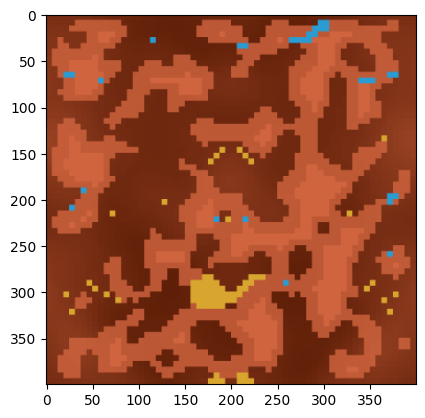

In [19]:
# visualize the environment so far with rgb_array to get a quick look at the map
# dark orange - high rubble, light orange - low rubble
# blue = ice, yellow = ore
img = env.render()
plt.imshow(img)

## Building an Agent
Now we know what the environment looks like, let's try building a working agent. The goal of this environment to ensure at least one factory stays alive by the end of the episode and grow as much lichen as possible.

In our kit we provide a skeleton for building an agent. Avoid removing any function from the kit unless you know what you are doing as it may cause your agent to fail on the competition servers. This agent defintion should be stored in the `agent.py` file.

The agent will have `self.player, self.opp_player, self.env_cfg` populated with the correct values at each step of an environment during competition or when you use the CLI tool to run matches. 

`self.env_cfg` stores the curent environment's configurations, and `self.player, self.opp_player` stores the name of your player/team and the opposition respectively (will always be "player_0" or "player_1").

In [20]:
from lux.kit import obs_to_game_state, GameState, EnvConfig
from luxai_s2.utils import animate
from lux.utils import direction_to, my_turn_to_place_factory
class Agent():
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg

    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        # optionally convert observations to python objects with utility functions
        game_state = obs_to_game_state(step, self.env_cfg, obs) 
        return actions

    def act(self, step: int, obs, env, remainingOverageTime: int = 60):
        actions = dict()
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        return actions

Note that in the environment, there are two distinct phases of the game where you will have to program two different sets of logic to play it.

We will also define a simple function to initialize our agent and interact with the environment and generate a simple video replay.
No need to worry about how this works specifically, you can copy paste this as you see fit. Note that this is a simplified representation. In order to visually see all numbers and details about units, factories etc. use our web visualizer.

In [21]:
def animate(imgs, _return=True):
    # using cv2 to generate videos as moviepy doesn't work on kaggle notebooks
    import cv2
    import os
    import string
    import random
    video_name = ''.join(random.choice(string.ascii_letters) for i in range(18))+'.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width,height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)
def interact(env, agents, steps):
    # reset our env
    obs, _ = env.reset()
    np.random.seed(0)
    imgs = []
    step = 0
    # Note that as the environment has two phases, we also keep track a value called 
    # `real_env_steps` in the environment state. The first phase ends once `real_env_steps` is 0 and used below

    # iterate until phase 1 ends
    while env.state.real_env_steps < 0:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].early_setup(step, o)
            actions[player] = a
        step += 1
        obs, rewards, terminations, truncations, infos = env.step(actions)
        imgs += [env.render()]
#         print(termination)
        dones = {k: terminations[k] or truncations[k] for k in terminations}
    done = False
    while not done:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].act(step, o, env)
            actions[player] = a
        step += 1
        obs, rewards, terminations, truncations, infos = env.step(actions)
        imgs += [env.render()]
        dones = {k: terminations[k] or truncations[k] for k in terminations}
        done = dones["player_0"] and dones["player_1"]
    return animate(imgs)

### Early Phase

During the first turn of the game, each player is given the map, starting resources (N factories and N\*150 water and ore), and are asked to bid for who goes first/second. Each 1 bid removes 1 water and 1 ore from that player's starting resources. Each player responds in turn 1 with their bid, which can be positive to prefer going first or negative to prefer going second. 

After bidding you then place each of your factories. Each team gets `N` factories to place, with. For conveniency the observation contains all possible spawn locations for your team which account for the opponent's factories and resource tiles which you can't spawn on.

We will write a simple `early_setup` function to return the appropriate action to handle this phase.



In [22]:
def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
    if step == 0:
        # bid 0 to not waste resources bidding and declare as the default faction
        # you can bid -n to prefer going second or n to prefer going first in placement
        return dict(faction="AlphaStrike", bid=0)
    else:
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        # factory placement period
        
        # how much water and metal you have in your starting pool to give to new factories
#         water_left = game_state.teams[self.player].water
#         metal_left = game_state.teams[self.player].metal
        
        # how many factories you have left to place
        factories_to_place = game_state.teams[self.player].factories_to_place
        # whether it is your turn to place a factory
        my_turn_to_place = my_turn_to_place_factory(game_state.teams[self.player].place_first, step)
        if factories_to_place > 0 and my_turn_to_place:
            # we will spawn our factory in a random location with 150 metal and water if it is our turn to place
            potential_spawns = np.array(list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1))))
            spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
            
            ice_map = game_state.board.ice
            msize = 64
            def around_ice_mask(ice_map):
                return jnp.zeros((msize,msize)).at[:,:-2].add(ice_map[:,2:]).at[1:,:-2].add(ice_map[:-1,2:]).at[:-1,:-2].add(ice_map[1:,2:])
            def select_spawn(ice_maps, vsm, rng):
                around_ice1 = around_ice_mask(ice_maps)
                around_ice2 = jnp.rot90(around_ice_mask(jnp.rot90(ice_maps,1)),-1)
                around_ice3 = jnp.rot90(around_ice_mask(jnp.rot90(ice_maps,2)),-2)
                around_ice4 = jnp.rot90(around_ice_mask(jnp.rot90(ice_maps,3)),-3)
                around_ices = (around_ice1+around_ice2+around_ice3+around_ice4)*vsm
                rng, subkey = jax.random.split(rng)
                random_idx = jax.random.randint(subkey, (2,),0,jnp.sum(jnp.bool_(around_ices)))
                vsm_random_idx = jax.random.randint(subkey, (2,),0,jnp.sum(vsm))
                return jnp.argwhere(around_ices,size=150)[random_idx[0]]
            vsm = game_state.board.valid_spawns_mask
            spawn = select_spawn(ice_map, vsm, rng)#[:,:,1:]
            rich.print(spawn)
            return dict(spawn=spawn, metal=150, water=150)
        return dict()
Agent.early_setup = early_setup

Each team gets `N` factories to place, with. For conveniency the observation contains all possible spawn locations for your team

In [23]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 15)

[31 46]

[42  2]

[42 42]

[26 39]

[ 6 16]

[10 11]

[ 7 59]

[58 16]

[19 14]

[52  9]

[11  2]

[15  6]

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


Congratz, we have lift off! We got both teams to spawn some factories. With the early phase over, we can now start programming the logic to power the next phase.

### Regular Phase

The goal of the game is to grow more lichen than your opponent by the end of the 1000 step episode (not including early phase steps). To grow lichen factories must consume water. Moreover, factories passively consume 1 water a turn, and you must ensure at least one factory survives until the end. Whichever team loses all their factories first will automatically lose. 

To obtain water, robots/units must mine ice from ice tiles (blue on the map) and deliver them back to a factory which then automatically refines ice into water. 

Moreover, to help us write better code, we will use the provided function `obs_to_game_state` to convert observations from raw dictionaries to interactable python objects. Finally, we will also use a provided `animate` function to easily generate a simple video of the episode and embed it into here without having to upload a replay file to the web visualizer.

#### Building Robots

Only factories can build robots, so for each factory on our team, if there is enough metal and power, we will issue a command to build a new heavy robot.

More advanced strategies will be able to efficiently leverage light units as well to collect resources but for simplicity, this tutorial uses heavy robots since they don't need to move as often to collect many resources but can collect many at a time.

In [24]:
from lux.kit import obs_to_game_state, GameState
def act(self, step: int, obs, env, remainingOverageTime: int = 60):
    actions = dict()
    game_state: GameState = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
    return actions
Agent.act = act

In [25]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 25)

[31 46]

[42  2]

[42 42]

[26 39]

[ 6 16]

[10 11]

[ 7 59]

[58 16]

[19 14]

[52  9]

[11  2]

[15  6]

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


Robots built, but they're idle! Let's get them to work.

#### Moving Robots and Mining

We want the robots to find the closest ice tile and mine it.
We'll worry about delivering the ice back home later. Let's update our `act` function to add this functionality. We will iterate over all our units and find the closest ice tile. Then we will use a given utility function that gives us the direction that takes us towards the desired ice tile. Lastly, we check if we have enough power to move and can move in that direction and submit that action.

Importantly, in this season **units are given action queues (a list of actions). Each time an action queue is given, the unit's old action queue is replaced completely in addition to a small additional action queue submission power cost.**

Moreover, each action has two other attributes, its execution count `n` and `repeat`. Each time the action is succesfully executed, we decrement `n` by 1. If `n` hits 0, we remove the action from the action queue. If `repeat == 0`, then we don't recycle the action. If `repeat > 0`, then we **recycle the same action to the back of the action queue** but this time with `n = repeat`.

For this tutorial, we will be giving units one action at a time with no action recycling or multiple executions. For more advanced competitors, to reduce power costs you may want to submit longer action queues and only update the action queue every once in a while.

In [26]:
from lux.utils import direction_to
import sys
def act(self, step: int, obs, env, remainingOverageTime: int = 60):
    actions = dict()
    game_state = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
            
    # iterate over our units and have them mine the closest ice tile
    units = game_state.units[self.player]
    ice_map = game_state.board.ice # flip the board as it stores by rows then columns
    ice_tile_locations = np.argwhere(ice_map == 1) # numpy magic to get the position of every ice tile
    for unit_id, unit in units.items():
        # compute the distance to each ice tile from this unit and pick the closest
        ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
        closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
        
        # if we have reached the ice tile, start mining if possible
        if np.all(closest_ice_tile == unit.pos):
            if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
                actions[unit_id] = [unit.dig(repeat=0, n=1)]
        else:
            direction = direction_to(unit.pos, closest_ice_tile)
            move_cost = unit.move_cost(game_state, direction)
            # check move_cost is not None, meaning that direction is not off the map or blocked
            # check if unit has enough power to move in addition to updating the action queue.
            if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                actions[unit_id] = [unit.move(direction, repeat=0, n=1)]
        # since we are using the simple embedded visualizer, we will have to print out details about units
        # importantly, note that we print with file=sys.stderr. Printing with anything will cause your agent to fail
        if unit.cargo.ice > 50:
            print(game_state.real_env_steps, unit, f"has {unit.cargo.ice} ice", file=sys.stderr)
    return actions
Agent.act = act

In [ ]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, steps=40)

[31 46]

[42  2]

[42 42]

[26 39]

[ 6 16]

[10 11]

[ 7 59]

[58 16]

[19 14]

[52  9]

[11  2]

[15  6]

7 [0] unit_15 HEAVY at [ 9 59] has 60 ice
7 [0] unit_17 HEAVY at [13  2] has 60 ice
7 [1] unit_19 HEAVY at [26 37] has 60 ice
7 [1] unit_21 HEAVY at [58 18] has 60 ice
7 [1] unit_22 HEAVY at [52  7] has 60 ice
8 [0] unit_12 HEAVY at [33 47] has 60 ice
8 [0] unit_13 HEAVY at [40 41] has 60 ice
8 [0] unit_14 HEAVY at [ 5 18] has 60 ice
8 [0] unit_15 HEAVY at [ 9 59] has 80 ice
8 [0] unit_16 HEAVY at [20 12] has 60 ice
8 [0] unit_17 HEAVY at [13  2] has 80 ice
8 [1] unit_18 HEAVY at [42  5] has 60 ice
8 [1] unit_19 HEAVY at [26 37] has 80 ice
8 [1] unit_20 HEAVY at [12 10] has 60 ice
8 [1] unit_21 HEAVY at [58 18] has 80 ice
8 [1] unit_22 HEAVY at [52  7] has 80 ice
8 [1] unit_23 HEAVY at [13  7] has 60 ice
9 [0] unit_12 HEAVY at [33 47] has 80 ice
9 [0] unit_13 HEAVY at [40 41] has 80 ice
9 [0] unit_14 HEAVY at [ 5 18] has 80 ice
9 [0] unit_15 HEAVY at [ 9 59] has 100 ice
9 [0] unit_16 HEAVY at [20 12] has 80 ice
9 [0] unit_17 HEAVY at [13  2] has 100 ice
9 [1] unit_18 HEAVY at [42  5] h

And they're off! The heavy robots have started to move towards the ice tiles and some have begun mining.

#### Delivering Resources and Keep Factories Alive
We now have ice being mined, but we now need to deliver that back to the factories so they can refine that ice into water and sustain themselves.

In [28]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import distrax
import gym

In [29]:
class SELayer(nn.Module):
    channel: int
    reduction: int = 4#16

    @nn.compact
    def __call__(self, x):
        b, h, w, c = x.shape
        y = jnp.mean(x, axis=(-3, -2), keepdims=True)
        y = nn.Dense(self.channel // self.reduction, kernel_init=orthogonal(np.sqrt(2)))(y)
        y = nn.relu(y)
        y = nn.Dense(self.channel, kernel_init=orthogonal(np.sqrt(2)))(y)
        y = nn.sigmoid(y)
        y = jnp.transpose(y,(0,3,1,2))
        y = jnp.tile(y,(h,w))
        y = jnp.transpose(y,(0,2,3,1))
        return x * y


class ResidualBlock(nn.Module):
    in_channel: int
    out_channel: int
    kernel_size: int = 5
    padding: int = 2

    @nn.compact
    def __call__(self, x):
        left = nn.Conv(self.out_channel,
                       kernel_size=(self.kernel_size, self.kernel_size),
                       padding=(self.padding, self.padding),
                       kernel_init=orthogonal(np.sqrt(2)),
                      )(x)
        left = nn.leaky_relu(left)
        left = nn.Conv(self.out_channel,
                       kernel_size=(self.kernel_size, self.kernel_size),
                       padding=(self.padding, self.padding),
                       kernel_init=orthogonal(np.sqrt(2)),
                      )(left)
        left = nn.leaky_relu(left)
        selayer = SELayer(self.out_channel)
        out = selayer(left)
        out = out + x
        out = nn.leaky_relu(out)
        return out


class Net(nn.Module):
    features: int
    num_act: int

    @nn.compact
    def __call__(self, map_feature, unit_pos):
        B, H, W, C = map_feature.shape
        n_mask = C - self.features
        action_mask = map_feature[:,:,:,-n_mask:]
        map_feature = map_feature[:,:,:,:-n_mask]
        x = nn.Conv(features=self.features, kernel_size=(1, 1),
                    kernel_init=orthogonal(np.sqrt(2)))(map_feature)
        x = nn.leaky_relu(x)
        x = nn.Conv(features=self.features, kernel_size=(1, 1),
                    kernel_init=orthogonal(np.sqrt(2)))(x)
        x = nn.leaky_relu(x)

        for _ in range(4):
            x = ResidualBlock(self.features, self.features)(x)

#         if config["BATCH_NORM"]:
        BN = nn.BatchNorm(use_running_average=False)
        variables = BN.init(jax.random.split(rng)[0], x)
        x,_ = BN.apply(variables,x,mutable=['batch_stats'])
            
        actor_mean = x.at[
            jnp.repeat(jnp.arange(len(x)),len(unit_pos[0])).reshape(-1,len(unit_pos[0])),
            unit_pos[:,:,0],
            unit_pos[:,:,1],
            :].get()
        actor_mean = nn.Conv(
            features=self.num_act, kernel_size=(1,1), kernel_init=orthogonal(np.sqrt(2))
        )(actor_mean)
        action_mask = action_mask.at[
            jnp.repeat(jnp.arange(len(x)),len(unit_pos[0])).reshape(-1,len(unit_pos[0])),
            unit_pos[:,:,0],
            unit_pos[:,:,1],
            :].get()
        actor_mean = actor_mean - action_mask
        pi = distrax.Categorical(logits=actor_mean)
        x = nn.Conv(features=self.features, kernel_size=(1, 1), kernel_init=orthogonal(np.sqrt(2)))(x)
        x = nn.leaky_relu(x)
        critic_value = nn.Conv(features=1, kernel_size=(1, 1))(x)
        critic_value = jnp.mean(critic_value, axis=(-3, -2, -1))

        return pi, critic_value


In [30]:
def obsv_from_state(env_state, obs):
    facocc_map = env_state.board.factory_occupancy_map
    facocc_map = jnp.where(facocc_map==-1,127,facocc_map)
    fac_id = obs['teams']['player_0']['factory_strains']
    enemy_fac_id = obs['teams']['player_1']['factory_strains']
    def new_facocc_map_fn(facocc_map, fac_id):
        def new_facocc_map_i(i,facocc_map):
            new_facocc_map = jnp.where(facocc_map==fac_id[i],127,facocc_map)
            return new_facocc_map
#         new_facocc_map = jax.lax.fori_loop(0,len(fac_id),new_facocc_map_i,facocc_map)
        new_facocc_map = facocc_map
        for i in range(len(fac_id)):
            new_facocc_map = new_facocc_map_i(i,new_facocc_map)
        return new_facocc_map
#     new_facocc_map = jax.vmap(new_facocc_map_fn)(facocc_map,enemy_fac_id)
    new_facocc_map = new_facocc_map_fn(facocc_map,enemy_fac_id)
    # ###rich.print('new_facocc_map',new_facocc_map)
#     enemy_facocc_map = jax.vmap(new_facocc_map_fn)(facocc_map,fac_id)
    enemy_facocc_map = new_facocc_map_fn(facocc_map,fac_id)
    # ###rich.print('enemy_facocc_map',enemy_facocc_map)
    factories = env_state.factories['player_0']
    facpower = [v.power for f,v in factories.items()]
    def facpower_map_fn(one_map, fac_id, facpower):
        def facpower_map_i(i,one_map):
            return jnp.where(one_map==fac_id[i],facpower[i],one_map)
#         return jax.lax.fori_loop(0,len(facpower),facpower_map_i,one_map)
        facpower_map = one_map
        for i in range(len(facpower)):
            facpower_map = facpower_map_i(i,facpower_map)
        return facpower_map
    facpower_map = jnp.array(jnp.where(new_facocc_map==127,-1,new_facocc_map),dtype='int32')
#     facpower_map = jax.vmap(facpower_map_fn)(facpower_map,fac_id,facpower)
    facpower_map = facpower_map_fn(facpower_map,fac_id,facpower)
    # ###rich.print('facpower_map',facpower_map)
    batch_size = 1
    msize = 64
    units = env_state.units['player_0']
    new_unit_map = jnp.zeros((batch_size,msize,msize))
    unit_power_map = jnp.zeros((batch_size,msize,msize))
    unit_ice_map = jnp.zeros((batch_size,msize,msize))
    for uid, unit in units.items():
        new_unit_map.at[:,unit.pos[0],unit.pos[1]].set(1)
        unit_power_map.at[:,unit.pos[0],unit.pos[1]].set(unit.power)
        unit_ice_map.at[:,unit.pos[0],unit.pos[1]].set(unit.cargo.ice)
    opp_units = env_state.units['player_1']
    enemy_unit_map = jnp.zeros((batch_size,msize,msize))
    enemy_unit_power_map = jnp.zeros((batch_size,msize,msize))
    for uid, unit in opp_units.items():
        enemy_unit_map.at[:,unit.pos[0],unit.pos[1]].set(1)
        enemy_unit_power_map.at[:,unit.pos[0],unit.pos[1]].set(unit.power)
    
#     new_unit_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,0,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,0,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(1)
#     enemy_unit_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,1,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,1,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(1)
#     # ###rich.print('new_unit_map',new_unit_map.sum(),new_unit_map)
#     unit_power_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,0,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,0,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(
#                                                       env_state.units.power[:,0,:].reshape(batch_size,max_n_units))
#     # ###rich.print('unit_power_map',unit_power_map[0])
#     enemy_unit_power_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,1,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,1,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(
#                                                       env_state.units.power[:,1,:].reshape(batch_size,max_n_units))
#     # ###rich.print('unit_power_map',unit_power_map)
#     unit_ice_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,0,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,0,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(
#                                                       env_state.units.cargo.stock[:,0,:,0].reshape(batch_size,max_n_units))
    # ###rich.print('unit_ice_map',unit_ice_map[0])
    no_fac_inf_map = jnp.expand_dims(jnp.where(new_facocc_map==127,jnp.inf,0),0)
    action0_move0_mask_map = jnp.zeros((batch_size,msize,msize))
    action1_move1_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,0].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action2_move2_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,-1,:].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action3_move3_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,-1].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action4_move4_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,0,:].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action5_transfer0_mask_map = no_fac_inf_map\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action6_transfer1_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,0].add(jnp.inf).at[
          :,:,1:].add(no_fac_inf_map[:,:,:-1])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action7_transfer2_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,-1,:].add(jnp.inf).at[
          :,:-1,:].add(no_fac_inf_map[:,1:,:])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action8_transfer3_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,-1].add(jnp.inf).at[
          :,:,:-1].add(no_fac_inf_map[:,:,1:])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action9_transfer4_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,0,:].add(jnp.inf).at[
          :,1:,:].add(no_fac_inf_map[:,:-1,:])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action10_pickup_mask_map = no_fac_inf_map\
                                + jnp.expand_dims(jnp.where(facpower_map<=100,jnp.inf,0),0)
    action11_dig_mask_map = jnp.expand_dims(jnp.where(new_facocc_map==127,0,jnp.inf),0)\
                            + jnp.where(unit_power_map<=80,jnp.inf,0)
    return jnp.stack((jnp.expand_dims(env_state.board.ice,0),
                     jnp.expand_dims(env_state.board.rubble/100,0),
                     new_unit_map,
                     unit_power_map/3000,
                     unit_ice_map/1000,
                     enemy_unit_map,
                     jnp.expand_dims(new_facocc_map/127,0),
                     jnp.expand_dims(facpower_map/5000,0),
                     jnp.expand_dims(enemy_facocc_map/127,0),
                     action0_move0_mask_map,
                     action1_move1_mask_map,
                     action2_move2_mask_map,
                     action3_move3_mask_map,
                     action4_move4_mask_map,
                     action5_transfer0_mask_map,
                     action6_transfer1_mask_map,
                     action7_transfer2_mask_map,
                     action8_transfer3_mask_map,
                     action9_transfer4_mask_map,
                     action10_pickup_mask_map,
                     action11_dig_mask_map,
                    ),axis=3)

In [31]:
import orbax.checkpoint
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
raw_restored = orbax_checkpointer.restore('/kaggle/input/single-savetest0-4/single_savetest_8')

In [32]:
rng = jax.random.PRNGKey(36)

In [33]:
# from jux.env import JuxEnv
# from jux.config import JuxBufferConfig, EnvConfig
from flax.linen.initializers import constant, orthogonal

import rich
def act(self, step: int, obs, env, remainingOverageTime: int = 60):
    actions = dict()
    game_state = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    factory_tiles, factory_units = [], []
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
        factory_tiles += [factory.pos]
        factory_units += [factory]
    factory_tiles = np.array(factory_tiles)

    units = game_state.units[self.player]
    ice_map = game_state.board.ice
    ice_tile_locations = np.argwhere(ice_map == 1)
    obsv_ = obsv_from_state(game_state, obs)
    if len(units):
        unipos = np.expand_dims(np.stack(np.array([unit.pos for unit in units.values()])),0)
        network = Net(features=9, num_act=12)
        network_params = raw_restored['runner_state'][0]['params']
#         rng, _rng = jax.random.split(rng)
        pi, value = network.apply(network_params,
                                  obsv_,
                                  unipos,
                                  )
#         action = pi.sample(seed=0)[:,:3]
        action = [pi.probs[0,i].argmax() for i in range(3)]
    action_type = jnp.array([0,0,0,0,0,1,1,1,1,1,2,3],dtype='int8')
    direction = jnp.array([0,1,2,3,4,0,1,2,3,4,0,0],dtype='int8')
    resource = jnp.array([0,0,0,0,0,0,0,0,0,0,4,0],dtype='int8')
    amount = jnp.array([0,0,0,0,0,1000,1000,1000,1000,1000,3000,0],dtype='int16')
    update_q = jnp.array([0,1,1,1,1,1,1,1,1,1,1,1],dtype='bool')
    for i, (unit_id, unit) in enumerate(units.items()):
        if i == 3:
            break
        if update_q[action[i]] and self.player=='player_0':
            actions[unit_id] = np.expand_dims(
                                np.array([action_type[action[i]],
                                        direction[action[i]],
                                        resource[action[i]],
                                        amount[action[i]],
                                        0,
                                        1]),0)
        
#         # track the closest factory
#         closest_factory = None
#         adjacent_to_factory = False
#         if len(factory_tiles) > 0:
#             factory_distances = np.mean((factory_tiles - unit.pos) ** 2, 1)
#             closest_factory_tile = factory_tiles[np.argmin(factory_distances)]
#             closest_factory = factory_units[np.argmin(factory_distances)]
#             adjacent_to_factory = np.mean((closest_factory_tile - unit.pos) ** 2) == 0
        
#             # previous ice mining code
#             if unit.cargo.ice < 40:
#                 ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
#                 closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
#                 if np.all(closest_ice_tile == unit.pos):
#                     if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
#                         actions[unit_id] = [unit.dig(repeat=0, n=1)]
#                 else:
#                     direction = direction_to(unit.pos, closest_ice_tile)
#                     move_cost = unit.move_cost(game_state, direction)
#                     if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
#                         actions[unit_id] = [unit.move(direction, repeat=0, n=1)]
#             # else if we have enough ice, we go back to the factory and dump it.
#             elif unit.cargo.ice >= 40:
#                 direction = direction_to(unit.pos, closest_factory_tile)
#                 if adjacent_to_factory:
#                     if unit.power >= unit.action_queue_cost(game_state):
#                         actions[unit_id] = [unit.transfer(direction, 0, unit.cargo.ice, repeat=0, n=1)]
#                 else:
#                     move_cost = unit.move_cost(game_state, direction)
#                     if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
#                         actions[unit_id] = [unit.move(direction, repeat=0, n=1)]
    rich.print(actions)
    return actions
Agent.act = act

In [34]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 40)

[31 46]

[42  2]

[42 42]

[26 39]

[ 6 16]

[10 11]

[ 7 59]

[58 16]

[19 14]

[52  9]

[11  2]

[15  6]

{'factory_0': 1, 'factory_2': 1, 'factory_4': 1, 'factory_6': 1, 'factory_8': 1, 'factory_10': 1}

{'factory_1': 1, 'factory_3': 1, 'factory_5': 1, 'factory_7': 1, 'factory_9': 1, 'factory_11': 1}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


Some factories are surviving for for more than 150 steps thanks to the delivery of additional ice, but more work will need to be done to keep them alive longer.

Puting all those pieces together the full starter agent looks like this (and we will save it to agent.py)

In [103]:
%%writefile agent.py
from lux.kit import obs_to_game_state, GameState, EnvConfig
from lux.utils import direction_to, my_turn_to_place_factory
import numpy as np
import sys
import os
import orbax.checkpoint
# import distrax
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.initializers import constant, orthogonal

rng = jax.random.PRNGKey(36)

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
# # raw_restored = orbax_checkpointer.restore('/kaggle/input/single-savetest0-4/single_savetest_9')
# if os.getcwd == '/kaggle/working':
#     raw_restored = orbax_checkpointer.restore('single_savetest_8')
# else:
# raw_restored = None

class SELayer(nn.Module):
    channel: int
    reduction: int = 4#16

    @nn.compact
    def __call__(self, x):
        b, h, w, c = x.shape
        y = jnp.mean(x, axis=(-3, -2), keepdims=True)
        y = nn.Dense(self.channel // self.reduction, kernel_init=orthogonal(np.sqrt(2)))(y)
        y = nn.relu(y)
        y = nn.Dense(self.channel, kernel_init=orthogonal(np.sqrt(2)))(y)
        y = nn.sigmoid(y)
        y = jnp.transpose(y,(0,3,1,2))
        y = jnp.tile(y,(h,w))
        y = jnp.transpose(y,(0,2,3,1))
        return x * y


class ResidualBlock(nn.Module):
    in_channel: int
    out_channel: int
    kernel_size: int = 5
    padding: int = 2

    @nn.compact
    def __call__(self, x):
        left = nn.Conv(self.out_channel,
                       kernel_size=(self.kernel_size, self.kernel_size),
                       padding=(self.padding, self.padding),
                       kernel_init=orthogonal(np.sqrt(2)),
                      )(x)
        left = nn.leaky_relu(left)
        left = nn.Conv(self.out_channel,
                       kernel_size=(self.kernel_size, self.kernel_size),
                       padding=(self.padding, self.padding),
                       kernel_init=orthogonal(np.sqrt(2)),
                      )(left)
        left = nn.leaky_relu(left)
        selayer = SELayer(self.out_channel)
        out = selayer(left)
        out = out + x
        out = nn.leaky_relu(out)
        return out


class Net(nn.Module):
    features: int
    num_act: int

    @nn.compact
    def __call__(self, map_feature, unit_pos):
        B, H, W, C = map_feature.shape
        n_mask = C - self.features
        action_mask = map_feature[:,:,:,-n_mask:]
        map_feature = map_feature[:,:,:,:-n_mask]
        x = nn.Conv(features=self.features, kernel_size=(1, 1),
                    kernel_init=orthogonal(np.sqrt(2)))(map_feature)
        x = nn.leaky_relu(x)
        x = nn.Conv(features=self.features, kernel_size=(1, 1),
                    kernel_init=orthogonal(np.sqrt(2)))(x)
        x = nn.leaky_relu(x)

        for _ in range(4):
            x = ResidualBlock(self.features, self.features)(x)

#         if config["BATCH_NORM"]:
        BN = nn.BatchNorm(use_running_average=False)
        variables = BN.init(jax.random.split(rng)[0], x)
        x,_ = BN.apply(variables,x,mutable=['batch_stats'])
            
        actor_mean = x.at[
            jnp.repeat(jnp.arange(len(x)),len(unit_pos[0])).reshape(-1,len(unit_pos[0])),
            unit_pos[:,:,0],
            unit_pos[:,:,1],
            :].get()
        actor_mean = nn.Conv(
            features=self.num_act, kernel_size=(1,1), kernel_init=orthogonal(np.sqrt(2))
        )(actor_mean)
        action_mask = action_mask.at[
            jnp.repeat(jnp.arange(len(x)),len(unit_pos[0])).reshape(-1,len(unit_pos[0])),
            unit_pos[:,:,0],
            unit_pos[:,:,1],
            :].get()
        actor_mean = actor_mean - action_mask
#         pi = distrax.Categorical(logits=actor_mean)
        pi = actor_mean
        x = nn.Conv(features=self.features, kernel_size=(1, 1), kernel_init=orthogonal(np.sqrt(2)))(x)
        x = nn.leaky_relu(x)
        critic_value = nn.Conv(features=1, kernel_size=(1, 1))(x)
        critic_value = jnp.mean(critic_value, axis=(-3, -2, -1))

        return pi, critic_value

def obsv_from_state(env_state, obs):
    facocc_map = env_state.board.factory_occupancy_map
    facocc_map = jnp.where(facocc_map==-1,127,facocc_map)
    fac_id = obs['teams']['player_0']['factory_strains']
    enemy_fac_id = obs['teams']['player_1']['factory_strains']
    def new_facocc_map_fn(facocc_map, fac_id):
        def new_facocc_map_i(i,facocc_map):
            new_facocc_map = jnp.where(facocc_map==fac_id[i],127,facocc_map)
            return new_facocc_map
#         new_facocc_map = jax.lax.fori_loop(0,len(fac_id),new_facocc_map_i,facocc_map)
        new_facocc_map = facocc_map
        for i in range(len(fac_id)):
            new_facocc_map = new_facocc_map_i(i,new_facocc_map)
        return new_facocc_map
#     new_facocc_map = jax.vmap(new_facocc_map_fn)(facocc_map,enemy_fac_id)
    new_facocc_map = new_facocc_map_fn(facocc_map,enemy_fac_id)
    # ###rich.print('new_facocc_map',new_facocc_map)
#     enemy_facocc_map = jax.vmap(new_facocc_map_fn)(facocc_map,fac_id)
    enemy_facocc_map = new_facocc_map_fn(facocc_map,fac_id)
    # ###rich.print('enemy_facocc_map',enemy_facocc_map)
    factories = env_state.factories['player_0']
    facpower = [v.power for f,v in factories.items()]
    def facpower_map_fn(one_map, fac_id, facpower):
        def facpower_map_i(i,one_map):
            return jnp.where(one_map==fac_id[i],facpower[i],one_map)
#         return jax.lax.fori_loop(0,len(facpower),facpower_map_i,one_map)
        facpower_map = one_map
        for i in range(len(facpower)):
            facpower_map = facpower_map_i(i,facpower_map)
        return facpower_map
    facpower_map = jnp.array(jnp.where(new_facocc_map==127,-1,new_facocc_map),dtype='int32')
#     facpower_map = jax.vmap(facpower_map_fn)(facpower_map,fac_id,facpower)
    facpower_map = facpower_map_fn(facpower_map,fac_id,facpower)
    # ###rich.print('facpower_map',facpower_map)
    batch_size = 1
    msize = 64
    units = env_state.units['player_0']
    new_unit_map = jnp.zeros((batch_size,msize,msize))
    unit_power_map = jnp.zeros((batch_size,msize,msize))
    unit_ice_map = jnp.zeros((batch_size,msize,msize))
    for uid, unit in units.items():
        new_unit_map.at[:,unit.pos[0],unit.pos[1]].set(1)
        unit_power_map.at[:,unit.pos[0],unit.pos[1]].set(unit.power)
        unit_ice_map.at[:,unit.pos[0],unit.pos[1]].set(unit.cargo.ice)
    opp_units = env_state.units['player_1']
    enemy_unit_map = jnp.zeros((batch_size,msize,msize))
    enemy_unit_power_map = jnp.zeros((batch_size,msize,msize))
    for uid, unit in opp_units.items():
        enemy_unit_map.at[:,unit.pos[0],unit.pos[1]].set(1)
        enemy_unit_power_map.at[:,unit.pos[0],unit.pos[1]].set(unit.power)
    
    no_fac_inf_map = jnp.expand_dims(jnp.where(new_facocc_map==127,jnp.inf,0),0)
    action0_move0_mask_map = jnp.zeros((batch_size,msize,msize))
    action1_move1_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,0].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action2_move2_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,-1,:].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action3_move3_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,-1].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action4_move4_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,0,:].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action5_transfer0_mask_map = no_fac_inf_map\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action6_transfer1_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,0].add(jnp.inf).at[
          :,:,1:].add(no_fac_inf_map[:,:,:-1])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action7_transfer2_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,-1,:].add(jnp.inf).at[
          :,:-1,:].add(no_fac_inf_map[:,1:,:])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action8_transfer3_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,-1].add(jnp.inf).at[
          :,:,:-1].add(no_fac_inf_map[:,:,1:])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action9_transfer4_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,0,:].add(jnp.inf).at[
          :,1:,:].add(no_fac_inf_map[:,:-1,:])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action10_pickup_mask_map = no_fac_inf_map\
                                + jnp.expand_dims(jnp.where(facpower_map<=100,jnp.inf,0),0)
    action11_dig_mask_map = jnp.expand_dims(jnp.where(new_facocc_map==127,0,jnp.inf),0)\
                            + jnp.where(unit_power_map<=80,jnp.inf,0)
    return jnp.stack((jnp.expand_dims(env_state.board.ice,0),
                     jnp.expand_dims(env_state.board.rubble/100,0),
                     new_unit_map,
                     unit_power_map/3000,
                     unit_ice_map/1000,
                     enemy_unit_map,
                     jnp.expand_dims(new_facocc_map/127,0),
                     jnp.expand_dims(facpower_map/5000,0),
                     jnp.expand_dims(enemy_facocc_map/127,0),
                     action0_move0_mask_map,
                     action1_move1_mask_map,
                     action2_move2_mask_map,
                     action3_move3_mask_map,
                     action4_move4_mask_map,
                     action5_transfer0_mask_map,
                     action6_transfer1_mask_map,
                     action7_transfer2_mask_map,
                     action8_transfer3_mask_map,
                     action9_transfer4_mask_map,
                     action10_pickup_mask_map,
                     action11_dig_mask_map,
                    ),axis=3)

network = Net(features=9, num_act=12)
# if raw_restored is None:
#     rng, _rng = jax.random.split(rng)
# #     init_rng = jax.random.split(_rng, 1)
#     init_x = jnp.expand_dims(jnp.zeros((64,64,21)),axis=0)
#     network_params = network.init(_rng,
#                                   init_x,
#                                   unit_pos=jnp.expand_dims(jnp.zeros((3,2),dtype='int8'),axis=0))
# else:
#     network_params = raw_restored['runner_state'][0]['params']
network_params = {'params': {'Conv_0': {'bias': jnp.array([ 1.8080231 ,  1.9286239 ,  1.6111392 ,  2.0330858 , -0.23175655,
           2.0003154 ,  1.2756248 , -0.31784013, -0.5525396 ], dtype="float32"),
   'kernel': jnp.array([[[[-1.9974946 , -1.1914241 , -1.7024094 , -0.50408554,
             -0.68874437, -0.39089924,  0.06436298,  0.77965003,
              0.4354843 ],
            [ 1.6635854 ,  0.9508257 , -0.46060854,  0.38737577,
              1.2141646 ,  1.0029471 ,  0.23856452,  0.73760104,
             -1.6176285 ],
            [ 0.03561453,  0.14811844, -0.99080694, -0.5597125 ,
             -0.43795675, -0.34556794,  0.25025922, -0.20339775,
              0.80721956],
            [-0.385352  ,  0.06821889, -0.3396323 ,  0.12424454,
              0.98390627, -0.33726454, -0.2653506 ,  0.10463538,
              1.0571903 ],
            [ 0.04716967,  0.97935057,  0.49231598, -0.39455992,
              0.1765765 ,  0.7253375 ,  0.08210322,  0.57731664,
              0.23344812],
            [ 0.69653577,  0.98967594,  0.19058608,  0.599889  ,
              0.327126  ,  1.4109359 , -0.24030635, -0.8490534 ,
             -0.24233735],
            [ 2.1175265 ,  2.548241  ,  1.3582138 ,  2.8606946 ,
             -0.4565099 ,  1.6399343 ,  0.7986311 ,  0.17792639,
             -1.7173797 ],
            [ 0.05686976, -1.8313507 , -0.0746607 , -0.20605287,
             -0.72031087,  0.27395767, -0.64037955,  0.23166247,
              0.5959319 ],
            [ 2.4317856 ,  1.8915021 ,  1.5306451 ,  2.628144  ,
              0.20518292,  2.57136   ,  2.0220368 , -0.5902805 ,
             -0.725157  ]]]], dtype="float32")},
  'Conv_1': {'bias': jnp.array([-0.03853939, -1.2310661 ,  1.4029027 ,  1.359405  , -1.3433584 ,
           1.5037459 ,  1.5066382 ,  1.3640039 , -0.07419299], dtype="float32"),
   'kernel': jnp.array([[[[ 0.09234038, -1.4971795 ,  2.7972116 ,  1.6293572 ,
             -0.8137723 ,  1.7916931 ,  2.011485  ,  1.6089263 ,
             -1.2652658 ],
            [ 0.11559354, -2.6506824 ,  2.5899527 ,  2.8696215 ,
             -2.0264692 ,  2.4867673 ,  2.252377  ,  1.4280579 ,
             -0.8287084 ],
            [ 0.32811195, -1.9663311 ,  1.2143067 ,  0.55237067,
             -1.5952286 ,  1.2012291 ,  1.5561051 ,  1.8465716 ,
             -0.39299595],
            [-0.31871602, -1.5103817 ,  1.7497898 ,  1.7873377 ,
             -2.5860314 ,  2.2053044 ,  2.6307397 ,  1.9765637 ,
             -1.1957535 ],
            [ 0.48742774,  0.09703055,  0.23920175, -0.5882561 ,
              0.42148796,  1.0417556 ,  0.17871624, -0.7628627 ,
             -0.0576594 ],
            [-0.36264247, -1.5104924 ,  2.6871681 ,  2.2845287 ,
             -1.3417501 ,  2.843592  ,  2.9484587 ,  2.0596437 ,
              0.15223059],
            [-0.8284897 , -2.5107923 ,  0.26565173,  1.5459046 ,
             -1.6722753 ,  1.0596197 ,  2.418972  ,  1.5495939 ,
             -0.35851592],
            [ 0.4910659 ,  1.1965373 ,  0.6159268 , -0.40698606,
              0.46619064, -1.0677114 , -0.14086127, -1.4005566 ,
              0.43207794],
            [-1.3561409 ,  0.95333326, -1.5466943 , -1.9402817 ,
              1.1091557 , -1.5948882 , -1.9791805 , -1.1971748 ,
              0.18625759]]]], dtype="float32")},
  'Conv_2': {'bias': jnp.array([ 0.01608444, -0.01738624, -0.01233726, -0.03780878, -0.0320822 ,
           0.00206394, -0.04165552,  0.00041396, -0.01972056, -0.02642592,
          -0.01754125,  0.10926936], dtype="float32"),
   'kernel': jnp.array([[[[-2.00330853e-01,  6.02620482e-01, -1.60950050e-01,
             -7.09224939e-01,  1.42031625e-01,  9.04058143e-02,
              3.98160756e-01,  7.67699480e-01, -1.82041347e-01,
              6.40890077e-02, -3.68774861e-01,  1.72849596e-01],
            [-1.63836569e-01,  6.01788998e-01, -3.30387831e-01,
              4.46219981e-01,  5.31690061e-01,  2.55485862e-01,
              1.49905488e-01, -2.89388090e-01, -8.27938259e-01,
             -1.57065243e-01,  3.99444312e-01, -1.28372625e-01],
            [ 9.47231829e-01,  2.11586654e-01, -2.24831253e-02,
              6.55962050e-01, -1.39289007e-01, -1.08162597e-01,
              4.79895510e-02,  6.57660544e-01,  2.01861942e-04,
             -1.73376903e-01,  7.88930058e-02,  2.02461809e-01],
            [ 1.34162098e-01,  5.57969749e-01, -2.61155337e-01,
             -1.05719194e-01,  1.45206712e-02, -1.16420972e+00,
             -4.83051948e-02, -3.53513628e-01,  2.04385012e-01,
              6.29074723e-02, -9.22522172e-02,  1.38910180e-02],
            [-4.90110844e-01, -6.31418228e-02, -2.95774490e-01,
              4.55827564e-01,  4.83025163e-01, -1.21595226e-01,
             -1.34042650e-01,  7.04239607e-01,  4.51716542e-01,
              3.96109909e-01,  3.57061744e-01, -5.26436567e-01],
            [ 1.24487974e-01,  7.03557849e-01,  3.09437454e-01,
             -3.39533895e-01, -1.65986940e-01,  3.44168156e-01,
             -4.87282127e-01, -1.54632237e-02,  3.90565604e-01,
             -1.08052194e-01,  6.88637495e-01, -5.01544654e-01],
            [-4.85717729e-02, -4.46662307e-01, -3.85419965e-01,
             -2.71950126e-01, -1.49741367e-01, -3.18744808e-01,
             -6.23146474e-01,  3.67891967e-01, -5.13224125e-01,
             -6.79958344e-01, -2.18536183e-02, -3.78741354e-01],
            [ 9.10994336e-02,  2.25396335e-01,  5.99171400e-01,
              2.45615959e-01, -1.41436458e-01, -1.46197779e-02,
             -2.56919742e-01,  1.38790295e-01, -4.81449902e-01,
              6.17021918e-01, -5.59859931e-01, -7.64784992e-01],
            [-2.53970146e-01,  2.40022078e-01,  4.90338176e-01,
              3.43120605e-01,  5.37462234e-01,  1.06637299e-01,
             -1.27082884e-01,  3.27034108e-02,  4.31182206e-01,
             -7.82136858e-01, -6.08336210e-01,  1.93178217e-04]]]],
         dtype="float32")},
  'Conv_3': {'bias': jnp.array([-0.2936137 , -0.30036476, -0.36405468, -0.33304778,  0.52697843,
           0.38552967,  0.32906476,  0.47560862, -0.26534808], dtype="float32"),
   'kernel': jnp.array([[[[-0.36497772, -0.42161173, -0.4520652 ,  0.13771954,
             -0.41295072, -0.41295815,  1.2179823 ,  0.14756577,
             -0.39019608],
            [ 0.02537988,  0.15859927,  0.11781814,  0.8150365 ,
             -0.03780783, -1.016469  , -0.03350765, -0.46559814,
              0.27847964],
            [ 0.52463037,  0.45769644,  0.12398887,  0.00592179,
              0.17557812,  0.498348  ,  0.30151296,  0.5797692 ,
             -0.6713922 ],
            [ 0.5798658 , -0.28466043, -0.00571053, -0.26009962,
              1.2284473 , -0.30427703,  0.23357445,  0.425345  ,
              0.13705155],
            [-0.04847626,  0.890558  , -0.09536947, -0.5936923 ,
             -0.2739382 , -0.31332713,  0.8381366 , -0.6433516 ,
              0.2798441 ],
            [-0.05669116,  0.08806361, -0.6596525 ,  0.54396725,
              0.7935023 ,  1.099612  ,  0.29810578, -0.02509181,
              0.10230299],
            [-0.42204866,  0.48460504,  0.00429425,  0.22406362,
              0.342103  , -0.3231357 , -0.4439912 ,  1.1899834 ,
              0.1178963 ],
            [ 0.40332565,  0.2198661 , -0.6212029 ,  0.08636301,
             -0.2330474 , -0.76770973, -0.65140104, -0.43313652,
             -0.6497991 ],
            [ 0.73823893, -0.15198812, -0.45303124,  0.11496152,
             -0.7898721 ,  0.0996739 ,  0.07373187,  0.34519753,
              0.6885225 ]]]], dtype="float32")},
  'Conv_4': {'bias': jnp.array([0.49110588], dtype="float32"),
   'kernel': jnp.array([[[[-0.62264544],
            [-0.6011735 ],
            [-0.6540387 ],
            [-0.48186383],
            [ 0.91141033],
            [ 0.47404227],
            [ 0.3647443 ],
            [ 0.52901655],
            [-0.6328507 ]]]], dtype="float32")},
  'ResidualBlock_0': {'Conv_0': {'bias': jnp.array([ 0.63089335, -0.03217315,  0.5817161 , -0.08611518,  0.07515308,
            0.64248425,  1.4202666 ,  0.5897065 ,  0.49296013], dtype="float32"),
    'kernel': jnp.array([[[[-2.65757531e-01, -2.53576580e-02, -1.81552455e-01,
              -1.07761972e-01, -4.18137908e-02, -2.78444618e-01,
              -4.91846204e-01, -3.36727768e-01, -5.15730023e-01],
             [-1.36600161e+00, -5.29824570e-03, -1.62201965e+00,
               6.05830029e-02,  1.00079671e-01, -1.54248679e+00,
              -1.62417412e+00, -1.62387431e+00, -1.29623187e+00],
             [ 1.14825583e+00,  1.55903362e-02,  1.23668277e+00,
               2.24818408e-01,  1.01792365e-01,  1.31513953e+00,
               1.87291741e+00,  1.45956862e+00,  9.88241136e-01],
             [ 9.86772835e-01, -1.94152534e-01,  1.34650898e+00,
              -1.61900282e-01, -3.48818600e-01,  1.13397956e+00,
               1.75085783e+00,  1.36776578e+00,  9.80137229e-01],
             [-1.32265401e+00, -6.39612153e-02, -1.44129765e+00,
               6.25276715e-02, -2.01016907e-02, -1.36479068e+00,
              -1.87954795e+00, -1.51550114e+00, -1.15709329e+00],
             [ 1.16039693e+00, -5.21102697e-02,  1.28109050e+00,
              -3.15817185e-02,  3.32426429e-01,  1.34571242e+00,
               1.86352062e+00,  1.15833688e+00,  9.56266761e-01],
             [ 1.14013195e+00, -1.61278725e-01,  1.29128706e+00,
              -1.59584373e-01,  3.81704539e-01,  1.20061135e+00,
               1.75063074e+00,  1.27376211e+00,  9.38663065e-01],
             [ 8.73987675e-01,  2.60389522e-02,  1.12150764e+00,
               1.42321765e-01, -6.25320911e-01,  1.15242696e+00,
               1.78218842e+00,  1.00388277e+00,  7.06571281e-01],
             [-8.37755680e-01, -6.01892546e-02, -8.94666255e-01,
               3.02194562e-02, -8.38191882e-02, -1.11808145e+00,
              -8.64077091e-01, -1.22040939e+00, -7.31783032e-01]],
    
            [[-2.94151068e-01,  6.79612905e-02, -3.38640660e-01,
              -8.94235298e-02,  2.27774352e-01, -2.99304187e-01,
              -2.95477569e-01, -3.78702998e-01, -2.65197784e-01],
             [-1.35625815e+00,  1.78272240e-02, -1.43688488e+00,
               1.02091007e-01,  9.85745713e-02, -1.58995402e+00,
              -1.81144357e+00, -1.62454355e+00, -1.31153619e+00],
             [ 1.11024702e+00, -8.52995813e-02,  1.36200142e+00,
              -5.29682003e-02, -6.16201684e-02,  1.23019147e+00,
               1.80544317e+00,  1.25162375e+00,  1.15661800e+00],
             [ 1.14272988e+00,  1.40650958e-01,  1.41458523e+00,
               1.48103476e-01, -2.19181508e-01,  1.19963491e+00,
               1.81353211e+00,  1.11483991e+00,  1.02923346e+00],
             [-1.64899778e+00,  1.09581694e-01, -1.63007116e+00,
              -6.14572614e-02,  1.98138878e-03, -1.52827847e+00,
              -1.93156767e+00, -1.47029793e+00, -1.44077802e+00],
             [ 1.03838241e+00, -1.29054472e-01,  1.32913244e+00,
              -1.89254686e-01,  2.83016771e-01,  1.05278552e+00,
               1.69400430e+00,  1.22525382e+00,  1.04390800e+00],
             [ 1.31437814e+00, -2.66700089e-01,  1.21757376e+00,
              -2.55493760e-01,  4.10366058e-01,  1.12984359e+00,
               1.68087637e+00,  1.32760239e+00,  9.77815390e-01],
             [ 9.24552977e-01,  1.54510304e-01,  1.10796857e+00,
               2.31042907e-01, -5.72662354e-01,  1.23174262e+00,
               1.60576546e+00,  1.24230587e+00,  8.37756038e-01],
             [-1.07865191e+00,  1.38658747e-01, -1.11504328e+00,
               3.97391394e-02, -2.02298146e-02, -1.07879090e+00,
              -9.89300787e-01, -1.01617265e+00, -8.44218135e-01]],
    
            [[-3.52291852e-01, -3.24642390e-01, -4.20101374e-01,
               1.99931860e-01,  5.90023361e-02, -5.74515045e-01,
              -4.19418246e-01, -2.88843274e-01, -3.30494136e-01],
             [-1.54154801e+00,  4.08752449e-02, -1.73985493e+00,
              -1.72787718e-02,  5.94629161e-02, -1.60112488e+00,
              -1.79860950e+00, -1.77195764e+00, -1.36353087e+00],
             [ 1.14598405e+00,  2.39639282e-02,  1.35978425e+00,
              -2.98882604e-01,  5.67532703e-02,  1.39983249e+00,
               1.79716313e+00,  1.17501867e+00,  1.04768646e+00],
             [ 1.23286569e+00,  8.99073202e-03,  1.37562251e+00,
              -4.56883423e-02, -3.55457872e-01,  1.21301162e+00,
               1.81691182e+00,  1.19275367e+00,  1.20781481e+00],
             [-1.58810580e+00,  3.60525139e-02, -1.74416995e+00,
               5.69923371e-02,  9.29994509e-02, -1.44525945e+00,
              -1.72851419e+00, -1.56420338e+00, -1.35265112e+00],
             [ 1.15957606e+00, -1.03645824e-01,  1.24118292e+00,
              -3.07464153e-01,  4.55588877e-01,  1.17101574e+00,
               1.82776296e+00,  1.37937713e+00,  1.05261850e+00],
             [ 1.20510304e+00, -1.63521826e-01,  1.25679529e+00,
              -5.06043732e-02,  8.57865959e-02,  1.25862467e+00,
               1.66203070e+00,  1.24236405e+00,  1.12133300e+00],
             [ 1.00966096e+00,  2.16856822e-01,  1.15102994e+00,
              -2.39520464e-02, -6.22798800e-01,  1.03620172e+00,
               1.58097696e+00,  1.01599777e+00,  8.61352086e-01],
             [-9.89867926e-01, -1.13753416e-01, -9.28852260e-01,
               3.07687148e-02,  5.25453240e-02, -1.04068542e+00,
              -9.69667614e-01, -9.56150115e-01, -9.43757772e-01]],
    
            [[-3.86724651e-01,  4.12201248e-02, -2.64022976e-01,
               4.57269922e-02,  1.56662583e-01, -5.76330125e-01,
              -3.88740838e-01, -4.21107560e-01, -3.38663012e-01],
             [-1.47870648e+00, -1.05453894e-01, -1.61557591e+00,
              -1.17256947e-01,  1.89054862e-01, -1.44800770e+00,
              -1.89488590e+00, -1.51287520e+00, -1.57989490e+00],
             [ 1.01618290e+00,  1.49331139e-02,  1.28190684e+00,
              -2.29126420e-02, -1.87570229e-01,  1.35551572e+00,
               1.67822433e+00,  1.19247246e+00,  1.12929952e+00],
             [ 1.12089872e+00, -1.04602752e-02,  1.25329804e+00,
              -2.27176230e-02, -2.45240003e-01,  1.09904015e+00,
               1.57599831e+00,  1.20551944e+00,  1.03073525e+00],
             [-1.43603897e+00,  7.76792094e-02, -1.52046299e+00,
              -1.13834646e-02,  4.04116213e-01, -1.58925068e+00,
              -1.72085941e+00, -1.45006192e+00, -1.36483240e+00],
             [ 1.22890949e+00, -2.06920594e-01,  1.09697616e+00,
              -6.65733665e-02,  2.69298851e-01,  1.21571600e+00,
               1.78418469e+00,  1.26841116e+00,  1.12732422e+00],
             [ 1.35747159e+00, -1.13407783e-01,  1.28246379e+00,
              -1.31411120e-01,  2.64476568e-01,  1.19854140e+00,
               1.88855135e+00,  1.11387217e+00,  1.15195930e+00],
             [ 9.31146026e-01,  1.24678366e-01,  1.03435540e+00,
               1.57635421e-01, -6.85006976e-01,  9.47086930e-01,
               1.63900721e+00,  9.76744592e-01,  9.53914583e-01],
             [-9.06481922e-01,  4.30585369e-02, -1.04557359e+00,
              -7.34193176e-02, -6.84470013e-02, -1.03987455e+00,
              -1.10038328e+00, -8.86929810e-01, -7.63685763e-01]],
    
            [[-2.83811539e-01, -5.44266813e-02, -4.38749820e-01,
               5.87130897e-02,  1.73051536e-01, -4.78927702e-01,
              -3.73430818e-01, -3.72856557e-01, -2.19461575e-01],
             [-1.52197790e+00,  7.18297511e-02, -1.76516759e+00,
               2.63863429e-03,  1.17470495e-01, -1.58973789e+00,
              -1.78363883e+00, -1.53103638e+00, -1.26943684e+00],
             [ 1.21789849e+00,  9.86034051e-02,  1.42449677e+00,
              -7.05406303e-03,  6.50046542e-02,  1.26955283e+00,
               1.76375926e+00,  1.27058160e+00,  1.36214864e+00],
             [ 1.20806623e+00,  1.65403280e-02,  1.31829381e+00,
               1.98668510e-01, -2.58023620e-01,  1.13043463e+00,
               1.81382346e+00,  1.12178719e+00,  9.69192743e-01],
             [-1.55524731e+00, -1.17669322e-01, -1.47745371e+00,
               3.35804671e-02,  1.74403012e-01, -1.27371025e+00,
              -1.64041841e+00, -1.55616617e+00, -1.25165939e+00],
             [ 1.11574864e+00, -1.39090747e-01,  1.40590739e+00,
              -1.95822760e-01,  3.74659657e-01,  1.26043010e+00,
               1.68423498e+00,  1.17829800e+00,  1.05224407e+00],
             [ 1.04610121e+00, -1.65223196e-01,  1.29000008e+00,
              -2.55367637e-01,  2.13868305e-01,  1.13417327e+00,
               1.71282208e+00,  1.03717804e+00,  1.02102149e+00],
             [ 9.17210162e-01,  1.94311544e-01,  9.74564135e-01,
               2.90443599e-01, -7.01167762e-01,  1.05703759e+00,
               1.65942061e+00,  1.10702753e+00,  8.85670185e-01],
             [-1.03856575e+00,  3.22860777e-02, -1.01986694e+00,
              -2.79747620e-02,  9.29686707e-03, -8.86120498e-01,
              -9.87426102e-01, -9.97594893e-01, -1.00114703e+00]]],
    
    
           [[[-3.53527725e-01,  1.05692390e-02, -2.06971392e-01,
               1.71883240e-01, -3.38184573e-02, -4.56013232e-01,
              -3.64864588e-01, -4.39865530e-01, -2.09544495e-01],
             [-1.50126028e+00, -7.90356472e-02, -1.55380869e+00,
              -3.62321734e-02,  1.84868366e-01, -1.40111303e+00,
              -1.48659217e+00, -1.31696844e+00, -1.27196491e+00],
             [ 1.16803265e+00, -3.10164168e-02,  1.26994002e+00,
              -2.52490696e-02,  1.11807913e-01,  1.37232149e+00,
               1.79991210e+00,  1.31959689e+00,  1.10373950e+00],
             [ 9.82184947e-01,  3.59024182e-02,  1.33745217e+00,
              -1.10674597e-01, -3.88200432e-01,  1.19965029e+00,
               1.80766928e+00,  1.23674834e+00,  1.10594690e+00],
             [-1.40983176e+00, -1.14567406e-01, -1.74637711e+00,
               2.67118633e-01,  1.50916725e-01, -1.46178246e+00,
              -1.72960067e+00, -1.41261637e+00, -1.44598997e+00],
             [ 1.11962450e+00, -3.11315861e-02,  1.30669022e+00,
               3.42340767e-02,  2.41746575e-01,  1.21373165e+00,
               1.77834940e+00,  1.15023577e+00,  1.01582909e+00],
             [ 1.16199636e+00,  3.98190096e-02,  1.24824631e+00,
              -2.45775562e-02,  2.35875279e-01,  1.19864202e+00,
               1.88031363e+00,  1.05641615e+00,  1.17560279e+00],
             [ 9.66555715e-01,  8.68994296e-02,  1.07651508e+00,
              -3.08240373e-02, -5.46312630e-01,  9.00439858e-01,
               1.67239094e+00,  9.37388659e-01,  9.31561470e-01],
             [-9.30786252e-01,  1.44219592e-01, -1.19871151e+00,
               1.72503129e-01, -7.64553389e-03, -9.32842731e-01,
              -1.14179385e+00, -1.05914855e+00, -8.51002753e-01]],
    
            [[-3.93574089e-01, -1.39193282e-01, -3.04927856e-01,
              -3.61806303e-02,  1.10088870e-01, -3.32486063e-01,
              -3.82106930e-01, -3.50422382e-01, -3.02802652e-01],
             [-1.50539744e+00,  1.50176153e-01, -1.73782897e+00,
              -1.47779062e-01,  8.14157799e-02, -1.41395462e+00,
              -1.67322385e+00, -1.69893384e+00, -1.24707818e+00],
             [ 1.31460452e+00,  2.94482964e-03,  1.23775208e+00,
               2.61930842e-02,  3.30495000e-01,  1.23443782e+00,
               1.71778595e+00,  1.21666336e+00,  1.08493578e+00],
             [ 1.21150589e+00, -9.36548486e-02,  1.14180970e+00,
              -2.66658645e-02, -2.46387124e-01,  1.04173291e+00,
               1.82859850e+00,  1.26583481e+00,  1.17397630e+00],
             [-1.45063686e+00,  2.81481892e-02, -1.52830803e+00,
              -1.18423492e-01,  1.14036454e-02, -1.52257574e+00,
              -1.71088016e+00, -1.60279310e+00, -1.37431014e+00],
             [ 1.28197086e+00, -4.20989171e-02,  1.15114808e+00,
              -8.25878233e-02,  1.73826680e-01,  1.03549993e+00,
               2.05966377e+00,  1.23231924e+00,  9.20404375e-01],
             [ 1.23941386e+00, -5.98452799e-02,  1.50463724e+00,
              -1.95832074e-01,  3.18699777e-01,  1.13599372e+00,
               1.85723829e+00,  1.21732306e+00,  1.18918920e+00],
             [ 9.65213001e-01,  1.90545365e-01,  1.03841639e+00,
               7.38433823e-02, -5.59530795e-01,  8.35383356e-01,
               1.78512585e+00,  1.00032413e+00,  7.51074493e-01],
             [-1.11525857e+00,  1.03708908e-01, -1.07904911e+00,
               5.13325930e-02,  1.07304260e-01, -1.07047987e+00,
              -1.02554381e+00, -1.01601160e+00, -8.12783360e-01]],
    
            [[-3.79694015e-01,  6.55987039e-02, -1.91297486e-01,
              -1.11513041e-01,  2.08876625e-01, -4.90042150e-01,
              -2.97769099e-01, -4.25954193e-01, -3.87169063e-01],
             [-1.59127104e+00, -9.38377827e-02, -1.62807882e+00,
               1.90880336e-02,  2.75294781e-01, -1.42347431e+00,
              -1.57754135e+00, -1.50636399e+00, -1.36781418e+00],
             [ 1.11917150e+00,  4.63349819e-02,  1.30839264e+00,
              -5.39666153e-02,  1.99419782e-01,  1.38153875e+00,
               1.72207367e+00,  1.13414478e+00,  1.05834854e+00],
             [ 1.23569810e+00,  5.15312189e-03,  1.48606384e+00,
              -5.53460717e-02, -3.14665556e-01,  1.13775742e+00,
               1.60403979e+00,  1.11475182e+00,  1.07945752e+00],
             [-1.55850852e+00, -5.74139468e-02, -1.45170784e+00,
               5.86318485e-02, -1.15388678e-02, -1.39105272e+00,
              -1.75855637e+00, -1.48231494e+00, -1.28048468e+00],
             [ 9.93100941e-01,  3.40734385e-02,  1.27468848e+00,
              -9.86557007e-02,  3.03571939e-01,  1.26933610e+00,
               1.87544799e+00,  1.27883458e+00,  1.09624267e+00],
             [ 1.23780680e+00, -1.20260708e-01,  1.05471516e+00,
              -1.29903287e-01,  3.76481920e-01,  1.17217827e+00,
               1.71285319e+00,  1.12263930e+00,  1.20128083e+00],
             [ 1.05646801e+00,  1.86950237e-01,  1.10600889e+00,
              -5.35872914e-02, -5.46445608e-01,  9.64908719e-01,
               1.73314011e+00,  1.03436315e+00,  8.23915243e-01],
             [-1.08029234e+00, -4.58696336e-02, -1.13901758e+00,
               7.84744024e-02,  9.96152610e-02, -1.09825432e+00,
              -1.05178797e+00, -1.04103804e+00, -9.92386818e-01]],
    
            [[-5.01330614e-01,  6.79089502e-02, -1.33489072e-01,
               1.49947777e-01,  6.92599341e-02, -4.27983344e-01,
              -1.74754009e-01, -3.36078048e-01, -3.19337159e-01],
             [-1.55488753e+00,  2.86689140e-02, -1.67633283e+00,
              -7.03188330e-02,  2.86736041e-01, -1.61079955e+00,
              -1.66221917e+00, -1.37994301e+00, -1.57023072e+00],
             [ 1.11176443e+00,  1.12745062e-01,  1.34823942e+00,
               9.48283896e-02,  6.55251592e-02,  1.08365142e+00,
               1.73461080e+00,  1.04427791e+00,  1.12286842e+00],
             [ 1.22312629e+00,  1.23380736e-01,  1.36364353e+00,
              -1.44095281e-02, -2.87232578e-01,  1.27170384e+00,
               1.84230196e+00,  1.15744829e+00,  8.65116596e-01],
             [-1.34828460e+00, -1.60086736e-01, -1.58281362e+00,
               3.17522228e-01,  3.12608555e-02, -1.58330715e+00,
              -1.77516747e+00, -1.50866175e+00, -1.36944890e+00],
             [ 1.14931238e+00,  9.89379734e-02,  1.35339928e+00,
              -1.07470661e-01,  4.10588413e-01,  1.39939559e+00,
               1.75513196e+00,  1.38515186e+00,  1.14627588e+00],
             [ 1.21910036e+00, -9.05990973e-02,  1.18019044e+00,
              -1.22656688e-01,  2.54321575e-01,  1.16896975e+00,
               1.88819635e+00,  1.19471538e+00,  1.13078916e+00],
             [ 1.00024450e+00,  1.92328483e-01,  1.03061545e+00,
               3.58033329e-02, -6.17230773e-01,  9.71773803e-01,
               1.73408961e+00,  1.17255175e+00,  8.97544205e-01],
             [-1.19576550e+00,  1.52934073e-02, -1.04178274e+00,
              -6.59977868e-02, -1.55683652e-01, -1.11627519e+00,
              -9.68655586e-01, -1.07301617e+00, -8.88491273e-01]],
    
            [[-3.43506724e-01,  6.73898160e-02, -4.45159405e-01,
              -6.13422394e-02,  1.39254823e-01, -5.16652703e-01,
              -2.68706650e-01, -3.95550400e-01, -3.39697301e-01],
             [-1.56143999e+00, -1.77037284e-01, -1.62813973e+00,
               8.08743984e-02,  2.76267320e-01, -1.42114234e+00,
              -1.65136373e+00, -1.60390282e+00, -1.27410936e+00],
             [ 1.02026951e+00,  6.15447313e-02,  1.36610150e+00,
               3.96646112e-02,  1.07500833e-02,  1.29935431e+00,
               1.61986184e+00,  1.12482131e+00,  1.18661892e+00],
             [ 1.08189476e+00,  1.82232559e-01,  1.19996905e+00,
              -3.43423560e-02, -2.29250327e-01,  1.15388298e+00,
               1.66971803e+00,  1.14101756e+00,  1.11918128e+00],
             [-1.43245411e+00,  5.33520095e-02, -1.41711164e+00,
               2.10746005e-01,  7.51275122e-02, -1.50232553e+00,
              -1.86416137e+00, -1.60939384e+00, -1.43953013e+00],
             [ 9.21127677e-01, -4.09441851e-02,  1.33626199e+00,
               1.39971869e-02,  5.05918145e-01,  1.36450005e+00,
               1.58938074e+00,  1.10653746e+00,  1.11311018e+00],
             [ 1.10368681e+00, -2.27756768e-01,  1.36906004e+00,
              -1.58708021e-01,  2.56983072e-01,  1.10966277e+00,
               1.89734316e+00,  1.14766943e+00,  1.16176820e+00],
             [ 9.14502800e-01,  1.50733292e-01,  1.16032124e+00,
               2.28657424e-02, -7.82456577e-01,  1.05178308e+00,
               1.53604305e+00,  9.64198947e-01,  9.31722820e-01],
             [-1.02218020e+00, -5.81279630e-03, -1.09462583e+00,
              -2.72289775e-02,  6.54399320e-02, -1.11076713e+00,
              -9.06868815e-01, -9.65853512e-01, -7.64324963e-01]]],
    
    
           [[[-3.09461236e-01,  2.54976545e-02, -3.73064578e-01,
              -9.70644802e-02, -1.35530025e-01, -4.60096955e-01,
              -1.98893502e-01, -4.04847443e-01, -4.24282551e-01],
             [-1.38545954e+00,  6.85388595e-02, -1.59567475e+00,
               5.47997057e-02,  1.70346156e-01, -1.48612487e+00,
              -1.76252222e+00, -1.36105978e+00, -1.33722568e+00],
             [ 1.10641825e+00,  1.12577528e-01,  1.41138971e+00,
               1.64936826e-01,  1.04338542e-01,  1.21366310e+00,
               1.69657290e+00,  1.43768489e+00,  1.06628573e+00],
             [ 1.18862367e+00,  4.86086681e-02,  1.33332813e+00,
              -3.10770217e-02, -3.65256220e-01,  1.16982484e+00,
               1.69127107e+00,  1.13346136e+00,  9.47251737e-01],
             [-1.61567008e+00,  4.20259461e-02, -1.43916321e+00,
               5.95685951e-02,  4.46291268e-02, -1.35612118e+00,
              -1.74489987e+00, -1.57001364e+00, -1.31759238e+00],
             [ 1.19806468e+00, -3.47591713e-02,  1.30448222e+00,
              -9.99866873e-02,  3.98601174e-01,  1.03718281e+00,
               1.52228045e+00,  1.35746121e+00,  9.46802318e-01],
             [ 1.13263857e+00, -8.42952654e-02,  1.36837924e+00,
              -1.52457520e-01,  3.37519944e-01,  1.18745697e+00,
               1.86897075e+00,  1.16142070e+00,  1.04506195e+00],
             [ 1.08672535e+00,  1.01744972e-01,  1.12219381e+00,
               3.00355200e-02, -5.04541278e-01,  9.07989621e-01,
               1.76459599e+00,  9.59206104e-01,  5.95246375e-01],
             [-7.86039054e-01, -1.32274747e-01, -9.60412323e-01,
               4.89400141e-02, -6.41065985e-02, -1.06122231e+00,
              -9.38408315e-01, -1.09657586e+00, -9.05864716e-01]],
    
            [[-4.03463691e-01, -1.46131530e-01, -3.46416801e-01,
               3.82855162e-02,  1.15173496e-01, -3.59605968e-01,
              -7.81940147e-02, -2.95564950e-01, -1.51312023e-01],
             [-1.41906691e+00, -3.72203328e-02, -1.38089001e+00,
               3.31188180e-02,  1.49376586e-01, -1.54782927e+00,
              -1.70964336e+00, -1.47023249e+00, -1.28453600e+00],
             [ 1.21811807e+00, -1.38842493e-01,  1.39874756e+00,
              -3.43895331e-02,  2.15532243e-01,  1.21700978e+00,
               1.91456902e+00,  1.29573321e+00,  9.36555624e-01],
             [ 1.15428782e+00, -5.83583079e-02,  1.23792410e+00,
              -6.78079575e-02, -3.38189542e-01,  1.22913957e+00,
               1.92898870e+00,  1.03337920e+00,  1.08782315e+00],
             [-1.36116552e+00,  3.26731391e-02, -1.67863333e+00,
              -3.53804454e-02,  2.53645959e-03, -1.39161253e+00,
              -1.82236791e+00, -1.53354335e+00, -1.28281569e+00],
             [ 1.26631105e+00, -8.34677741e-02,  1.36669230e+00,
              -2.78125048e-01,  1.76131949e-01,  1.19298708e+00,
               1.61292839e+00,  1.20325518e+00,  1.09495807e+00],
             [ 1.24422073e+00, -5.76663204e-02,  1.25531590e+00,
              -1.33605093e-01,  5.27026057e-01,  1.19510949e+00,
               1.74838519e+00,  1.02085125e+00,  1.10621059e+00],
             [ 8.81954074e-01,  9.74269733e-02,  1.06707847e+00,
               1.02019332e-01, -7.36686647e-01,  8.64080012e-01,
               1.75465584e+00,  1.20065010e+00,  7.90588796e-01],
             [-1.02946544e+00,  1.00786939e-01, -1.02452588e+00,
              -5.06153964e-02, -1.53010756e-01, -9.90504384e-01,
              -9.46097970e-01, -1.03028667e+00, -7.44175136e-01]],
    
            [[-2.53038257e-01, -8.24754536e-02, -1.75781623e-01,
              -1.34008294e-02, -2.78617553e-02, -4.72461253e-01,
              -2.99619019e-01, -3.46094906e-01, -3.02444726e-01],
             [-1.54571617e+00,  5.33822104e-02, -1.50520098e+00,
               7.76893944e-02,  2.54599184e-01, -1.37135649e+00,
              -1.69799078e+00, -1.54106271e+00, -1.19209659e+00],
             [ 1.22418511e+00, -4.86915261e-02,  1.28633904e+00,
              -3.02811805e-02,  1.44909456e-01,  1.29394805e+00,
               1.78681242e+00,  1.29347050e+00,  9.39540625e-01],
             [ 1.20802569e+00,  1.23168662e-01,  1.14218879e+00,
              -8.79184455e-02, -4.01447564e-01,  1.17066312e+00,
               1.82527447e+00,  1.15011692e+00,  1.08648837e+00],
             [-1.58119774e+00,  5.27354814e-02, -1.62670314e+00,
               1.34012010e-02, -8.13361704e-02, -1.40086758e+00,
              -1.80804384e+00, -1.62359333e+00, -1.63751554e+00],
             [ 1.02971804e+00, -1.66670159e-01,  1.40710866e+00,
              -1.48762494e-01,  2.20345527e-01,  1.12572789e+00,
               1.65115440e+00,  1.43118584e+00,  1.21494496e+00],
             [ 1.17768037e+00, -3.07271093e-01,  1.14130569e+00,
              -1.17245480e-01,  3.39540541e-01,  1.14553571e+00,
               1.82135272e+00,  9.86203492e-01,  1.16960478e+00],
             [ 1.05322456e+00,  1.01772130e-01,  1.13244593e+00,
               1.58107936e-01, -6.84447765e-01,  9.30024564e-01,
               1.77168930e+00,  1.11933613e+00,  9.12802935e-01],
             [-9.25507784e-01, -5.89099601e-02, -1.10659826e+00,
              -5.28620742e-03,  1.13706840e-02, -9.32241678e-01,
              -8.40779424e-01, -1.00886714e+00, -9.73619699e-01]],
    
            [[-2.91075289e-01, -1.90557256e-01, -2.17915908e-01,
              -1.24548245e-02,  4.19560000e-02, -3.26111615e-01,
              -3.65008891e-01, -4.51128572e-01, -4.29811716e-01],
             [-1.50765836e+00, -1.98711380e-01, -1.68971086e+00,
               1.53234646e-01,  3.75169009e-01, -1.50105023e+00,
              -1.80474341e+00, -1.65268517e+00, -1.31779277e+00],
             [ 1.24398088e+00,  1.97434619e-01,  1.41479993e+00,
               9.91760567e-02,  5.14849611e-02,  1.13492334e+00,
               1.81388211e+00,  1.08591104e+00,  1.04927564e+00],
             [ 1.29281032e+00, -8.62616226e-02,  1.23762691e+00,
              -1.11405542e-02, -1.39009878e-01,  1.22330487e+00,
               1.98565722e+00,  1.20598221e+00,  1.06085575e+00],
             [-1.47993851e+00,  4.76901606e-02, -1.56068254e+00,
               2.44926125e-01, -3.32148634e-02, -1.45055759e+00,
              -1.80889356e+00, -1.46305108e+00, -1.48513222e+00],
             [ 1.41660976e+00, -1.51938722e-01,  1.43694496e+00,
              -5.07704504e-02,  1.80400997e-01,  1.29733253e+00,
               1.71846676e+00,  1.28720844e+00,  9.52115893e-01],
             [ 1.23646164e+00, -2.26977661e-01,  1.27844620e+00,
              -1.16413459e-01,  2.78946638e-01,  1.28292179e+00,
               1.87360156e+00,  1.15866768e+00,  1.01218879e+00],
             [ 1.17633200e+00,  3.02906930e-01,  9.96619880e-01,
               1.05421178e-01, -6.15243435e-01,  1.19718564e+00,
               1.79804039e+00,  9.24494505e-01,  6.83921516e-01],
             [-9.12178218e-01, -1.01720663e-02, -9.66679990e-01,
               3.63857411e-02,  8.50499868e-02, -1.08879054e+00,
              -1.05801082e+00, -1.07112515e+00, -7.31997728e-01]],
    
            [[-4.61400747e-01, -9.02818590e-02, -1.19017206e-01,
              -2.96011046e-02,  2.61919588e-01, -5.09320438e-01,
              -3.81761432e-01, -3.77169132e-01, -6.07128799e-01],
             [-1.61234343e+00,  3.72277535e-02, -1.61730957e+00,
               3.62452149e-04,  3.78773093e-01, -1.44339454e+00,
              -1.75292408e+00, -1.40993893e+00, -1.38190794e+00],
             [ 1.14102793e+00,  1.01915672e-01,  1.28329432e+00,
              -4.36860099e-02,  9.20758322e-02,  1.25921488e+00,
               1.84940243e+00,  1.12263358e+00,  1.17163265e+00],
             [ 1.21265006e+00,  5.53122014e-02,  1.26571500e+00,
              -8.51798356e-02, -1.72719494e-01,  1.23672998e+00,
               1.78524148e+00,  9.40133393e-01,  1.02323925e+00],
             [-1.31605351e+00,  2.03227758e-01, -1.62914062e+00,
               7.24545270e-02,  1.83438540e-01, -1.61445582e+00,
              -1.70250988e+00, -1.46637678e+00, -1.30507076e+00],
             [ 1.40625751e+00, -7.43933097e-02,  1.30825639e+00,
              -1.39887825e-01,  2.91599244e-01,  1.21110559e+00,
               1.56321990e+00,  1.13877189e+00,  1.26262498e+00],
             [ 1.30694222e+00, -9.26260203e-02,  1.18816710e+00,
               6.46665320e-02,  2.48803049e-01,  1.32108939e+00,
               1.69263637e+00,  1.10935187e+00,  1.14204097e+00],
             [ 9.93671894e-01,  1.49174422e-01,  1.05536830e+00,
               6.96763247e-02, -5.19159317e-01,  9.35422480e-01,
               1.62601829e+00,  9.70363140e-01,  1.01905930e+00],
             [-9.12201047e-01,  9.30887610e-02, -1.21016061e+00,
               3.20442021e-02,  9.85445529e-02, -9.47136045e-01,
              -1.15155315e+00, -1.03666401e+00, -1.02866924e+00]]],
    
    
           [[[-3.43282133e-01,  1.56448334e-01, -3.51786345e-01,
               7.96813890e-02,  2.23663405e-01, -3.85006934e-01,
              -3.12096417e-01, -2.83487737e-01, -2.69874215e-01],
             [-1.43251491e+00,  1.00632519e-01, -1.46603894e+00,
               1.86384887e-01,  1.79228872e-01, -1.38544416e+00,
              -1.71506166e+00, -1.72881091e+00, -1.38990223e+00],
             [ 1.23639107e+00,  1.91889852e-01,  1.43812728e+00,
              -6.40848428e-02,  4.84243296e-02,  1.21937490e+00,
               1.78852677e+00,  1.35804999e+00,  1.10629356e+00],
             [ 1.29431856e+00,  1.28771795e-03,  1.16909301e+00,
              -7.67681748e-02, -1.71706557e-01,  1.24777842e+00,
               1.80859399e+00,  1.13103056e+00,  1.03141212e+00],
             [-1.52302551e+00, -2.49926280e-02, -1.58158755e+00,
               7.99072087e-02, -1.34901339e-02, -1.50275648e+00,
              -1.79795337e+00, -1.49013686e+00, -1.56704807e+00],
             [ 1.14049244e+00, -1.24291494e-01,  1.24659121e+00,
              -8.62432271e-02,  2.73995161e-01,  1.14464068e+00,
               1.73452973e+00,  1.35487854e+00,  1.02253425e+00],
             [ 1.29226816e+00, -7.02320486e-02,  1.28005135e+00,
              -2.23962128e-01,  3.98695290e-01,  1.14609969e+00,
               1.84281778e+00,  1.39571834e+00,  1.10339010e+00],
             [ 1.04926300e+00,  3.17992568e-01,  1.24786723e+00,
               1.71633825e-01, -6.11534357e-01,  9.21952724e-01,
               1.76916993e+00,  9.91032779e-01,  7.26187289e-01],
             [-8.31539810e-01, -2.77485717e-02, -9.90077257e-01,
              -9.33217555e-02,  5.06139994e-02, -9.33836520e-01,
              -1.08892369e+00, -9.15721357e-01, -8.88767242e-01]],
    
            [[-3.56767058e-01, -7.22417608e-02, -3.86106849e-01,
              -2.10267618e-01,  1.55350223e-01, -5.93617618e-01,
              -3.52466643e-01, -4.47390616e-01, -4.00680989e-01],
             [-1.46911395e+00, -9.47382227e-02, -1.61034214e+00,
               8.21796060e-02,  2.37030834e-01, -1.73332679e+00,
              -1.53924882e+00, -1.30427122e+00, -1.44847405e+00],
             [ 1.17857790e+00, -3.86929773e-02,  1.30403876e+00,
              -1.54710531e-01,  1.90612346e-01,  1.29188275e+00,
               1.78061020e+00,  1.03764951e+00,  9.29227829e-01],
             [ 1.09768128e+00,  2.09917158e-01,  1.23989594e+00,
              -4.38087210e-02, -2.56300300e-01,  1.22801590e+00,
               2.02606106e+00,  1.18379927e+00,  1.12227714e+00],
             [-1.55866742e+00, -5.02383001e-02, -1.57882190e+00,
               1.22183159e-01, -2.16753688e-02, -1.57342553e+00,
              -1.84979355e+00, -1.48586178e+00, -1.40984797e+00],
             [ 1.30201244e+00,  4.73284721e-02,  1.43502879e+00,
              -5.88219129e-02,  3.55777144e-01,  1.11453104e+00,
               1.89885044e+00,  1.29923725e+00,  1.17358947e+00],
             [ 1.24354625e+00, -9.25047919e-02,  1.27447188e+00,
              -3.76831114e-01,  1.68032095e-01,  1.11619151e+00,
               1.90429926e+00,  1.27594507e+00,  1.16266048e+00],
             [ 9.43639040e-01,  2.47198388e-01,  1.17993093e+00,
               2.62809917e-02, -5.48197448e-01,  1.12382734e+00,
               1.67107189e+00,  9.73012269e-01,  8.90665770e-01],
             [-9.83582973e-01, -1.58910155e-01, -1.06499875e+00,
              -6.94015548e-02,  6.26274124e-02, -9.05063033e-01,
              -9.75164413e-01, -9.51657295e-01, -9.14554358e-01]],
    
            [[-5.32905161e-01, -3.64315063e-02, -2.84740925e-01,
               2.50423886e-02,  8.18572640e-02, -3.23667526e-01,
              -3.08396995e-01, -4.10841346e-01, -4.11097020e-01],
             [-1.63066244e+00, -6.94165006e-02, -1.46371722e+00,
               3.83635461e-02,  3.14563334e-01, -1.44395936e+00,
              -1.59102952e+00, -1.46566582e+00, -1.21043313e+00],
             [ 1.28000879e+00,  1.76558256e-01,  1.10910547e+00,
              -1.17564194e-01,  1.98388353e-01,  1.28845382e+00,
               1.72781754e+00,  1.31890059e+00,  1.17271161e+00],
             [ 1.22321177e+00,  5.52359149e-02,  1.32575119e+00,
              -1.31812513e-01, -2.02030316e-01,  1.24224937e+00,
               1.77996647e+00,  1.31206954e+00,  1.07271409e+00],
             [-1.43612432e+00, -1.01678185e-01, -1.78659594e+00,
               8.40163007e-02,  1.23311758e-01, -1.45995545e+00,
              -1.55562079e+00, -1.67747605e+00, -1.33634222e+00],
             [ 1.14811289e+00,  1.55999869e-01,  1.39764071e+00,
              -1.63430750e-01,  2.89715052e-01,  1.32008040e+00,
               1.76608431e+00,  1.35881639e+00,  1.04111242e+00],
             [ 1.29472959e+00, -2.80929506e-01,  1.31748593e+00,
               1.35821952e-02,  1.91074550e-01,  1.26374102e+00,
               1.93462574e+00,  1.07188570e+00,  1.08579695e+00],
             [ 1.25769877e+00,  1.66654065e-01,  1.18665445e+00,
               5.61371446e-02, -7.51437843e-01,  1.00108182e+00,
               1.83520365e+00,  9.73509192e-01,  8.17080021e-01],
             [-1.10740387e+00, -1.39088914e-01, -1.08788419e+00,
               2.44854271e-01,  1.65211670e-02, -1.04016209e+00,
              -9.87236559e-01, -9.24799979e-01, -9.36487079e-01]],
    
            [[-3.63794386e-01,  7.57284462e-02, -2.43500203e-01,
               6.29170612e-02,  4.40418161e-02, -3.70848387e-01,
              -1.83867604e-01, -3.59684348e-01, -5.58974147e-01],
             [-1.69150281e+00, -6.84197396e-02, -1.52703524e+00,
              -1.04413994e-01,  8.63855556e-02, -1.70671690e+00,
              -1.61929309e+00, -1.44102418e+00, -1.28749847e+00],
             [ 1.31583536e+00,  1.27333850e-01,  1.21922994e+00,
               9.23413038e-02,  2.51785796e-02,  1.33572114e+00,
               1.73886240e+00,  1.34359193e+00,  1.22081578e+00],
             [ 1.29249287e+00,  1.09771460e-01,  1.39946854e+00,
              -1.56846061e-01, -3.02552015e-01,  1.20341063e+00,
               1.58511615e+00,  1.30638862e+00,  1.08093977e+00],
             [-1.43062568e+00,  2.67187476e-01, -1.58453941e+00,
               7.49949962e-02, -7.95802996e-02, -1.42349660e+00,
              -1.69578087e+00, -1.50263095e+00, -1.23814023e+00],
             [ 1.35551810e+00, -1.71892107e-01,  1.27353168e+00,
              -4.26723696e-02,  3.53343040e-01,  1.25749397e+00,
               1.62625623e+00,  1.19244158e+00,  1.03204715e+00],
             [ 1.31632900e+00, -1.39635712e-01,  1.13172686e+00,
              -1.55560151e-01,  2.12173298e-01,  1.30765331e+00,
               1.78275752e+00,  1.35471356e+00,  1.14545202e+00],
             [ 1.11485803e+00,  1.16693869e-01,  1.15430760e+00,
               2.01218016e-02, -6.16087615e-01,  1.00777555e+00,
               1.75089657e+00,  8.73089075e-01,  8.17338586e-01],
             [-9.75826621e-01, -1.14467718e-01, -9.37602341e-01,
              -1.63307991e-02,  3.71172167e-02, -8.53431165e-01,
              -9.48663771e-01, -1.04353380e+00, -1.04501307e+00]],
    
            [[-3.66581380e-01,  6.86038733e-02, -3.55629891e-01,
              -1.24858115e-02,  4.19670492e-01, -3.23370636e-01,
              -3.74547631e-01, -3.53460640e-01, -2.93948144e-01],
             [-1.49403417e+00, -2.38568373e-02, -1.58061111e+00,
               1.10206064e-02,  2.45398074e-01, -1.49840784e+00,
              -1.54847574e+00, -1.61448145e+00, -1.40467310e+00],
             [ 1.23134565e+00, -7.90477321e-02,  1.24759126e+00,
               1.46950603e-01,  1.75734416e-01,  1.24873388e+00,
               1.72205913e+00,  1.17631209e+00,  1.22393012e+00],
             [ 1.04401016e+00,  8.71044695e-02,  1.34010339e+00,
               8.96915868e-02, -3.69725406e-01,  1.21585035e+00,
               1.75430858e+00,  1.18581903e+00,  1.05162871e+00],
             [-1.42492890e+00, -4.95972298e-03, -1.55584753e+00,
              -7.22127706e-02,  3.28250766e-01, -1.69676673e+00,
              -1.75626373e+00, -1.71778929e+00, -1.38894224e+00],
             [ 1.32854152e+00,  7.82550275e-02,  1.19060314e+00,
              -2.37745509e-01,  2.79228121e-01,  1.33963239e+00,
               1.80522549e+00,  1.22684896e+00,  1.10669887e+00],
             [ 1.27862346e+00, -1.62763670e-01,  1.11471725e+00,
              -1.43826250e-02,  1.28638431e-01,  1.22021341e+00,
               1.79939032e+00,  1.20126998e+00,  1.06135082e+00],
             [ 1.13035989e+00,  4.65415418e-02,  1.26392388e+00,
              -9.34529118e-03, -6.50743544e-01,  9.92503643e-01,
               1.48894417e+00,  1.03599632e+00,  1.05742407e+00],
             [-8.47255707e-01,  5.56040928e-02, -1.25201356e+00,
               5.49298488e-02, -1.55181075e-02, -9.70833480e-01,
              -1.00430703e+00, -8.51496339e-01, -9.65134799e-01]]],
    
    
           [[[-3.83720040e-01,  5.64564094e-02, -2.18966872e-01,
               2.70829070e-03,  1.55454889e-01, -5.10876179e-01,
              -4.30205911e-01, -4.16826606e-01, -4.15174276e-01],
             [-1.18555474e+00,  8.23545922e-03, -1.64816248e+00,
               4.12846431e-02,  1.63064465e-01, -1.53195357e+00,
              -1.76839447e+00, -1.54296291e+00, -1.45384586e+00],
             [ 1.26206517e+00,  7.54172578e-02,  1.24626780e+00,
              -8.89257938e-02,  1.11124404e-01,  1.15926552e+00,
               1.84498179e+00,  1.19325328e+00,  9.92790163e-01],
             [ 1.41062093e+00,  5.17751984e-02,  1.52840137e+00,
               1.00518484e-02, -1.91234231e-01,  1.20344722e+00,
               1.76073682e+00,  1.19990063e+00,  1.08412206e+00],
             [-1.44006050e+00,  3.52718309e-02, -1.57285523e+00,
               2.20974125e-02, -1.12901501e-01, -1.63965440e+00,
              -1.84537709e+00, -1.50656378e+00, -1.41599250e+00],
             [ 1.38494563e+00, -5.13466559e-02,  1.41717410e+00,
               1.70518830e-02,  3.29487175e-01,  1.26738441e+00,
               1.84460115e+00,  1.41629875e+00,  9.81314898e-01],
             [ 1.31694186e+00,  2.31106002e-02,  1.20833325e+00,
              -1.66738987e-01,  1.90590635e-01,  1.09577441e+00,
               1.79370546e+00,  1.36350358e+00,  1.02686799e+00],
             [ 1.00011909e+00,  1.96217403e-01,  1.31663370e+00,
               2.51489490e-01, -5.19034326e-01,  8.78350377e-01,
               1.84661400e+00,  1.04494870e+00,  7.90652156e-01],
             [-8.01715016e-01, -7.92580545e-02, -1.00953996e+00,
              -2.47777216e-02,  7.90184438e-02, -9.35477078e-01,
              -9.63888884e-01, -1.02939856e+00, -1.00695264e+00]],
    
            [[-3.23906422e-01, -3.14659029e-02, -2.80631393e-01,
              -6.12835586e-02,  2.82835573e-01, -4.35363173e-01,
              -2.33128771e-01, -4.76338178e-01, -4.14402187e-01],
             [-1.38174653e+00,  3.00084483e-02, -1.68655264e+00,
               1.19407219e-03,  3.24047953e-01, -1.29488015e+00,
              -1.81908631e+00, -1.57280898e+00, -1.27347660e+00],
             [ 1.13751471e+00,  2.36624777e-01,  1.27388334e+00,
               1.13844700e-01,  2.50757486e-01,  1.11163056e+00,
               1.80894697e+00,  1.29379773e+00,  1.03109527e+00],
             [ 1.22068024e+00,  4.97291796e-02,  1.17931116e+00,
              -5.22245131e-02, -2.61103302e-01,  1.30280602e+00,
               1.76682985e+00,  1.24796581e+00,  1.02009368e+00],
             [-1.46570396e+00, -2.35246532e-02, -1.49139929e+00,
              -5.53533323e-02,  4.79809828e-02, -1.38805807e+00,
              -1.64910257e+00, -1.57995987e+00, -1.40230429e+00],
             [ 1.27873838e+00, -1.73753738e-01,  1.29345906e+00,
              -1.77320138e-01,  2.46391028e-01,  1.38557553e+00,
               1.73356605e+00,  1.44140720e+00,  1.11058831e+00],
             [ 1.25002837e+00, -9.92282480e-02,  1.24365115e+00,
              -2.62545258e-01,  2.81639665e-01,  1.37094188e+00,
               1.82825315e+00,  1.21959078e+00,  1.17104566e+00],
             [ 1.12239289e+00,  1.50850683e-01,  1.19876683e+00,
               1.13229632e-01, -4.86981899e-01,  1.11125159e+00,
               1.65369928e+00,  1.07641768e+00,  8.74943137e-01],
             [-9.92381275e-01,  1.36996329e-01, -9.68352139e-01,
               4.78771515e-02,  1.45800188e-01, -9.82607186e-01,
              -1.01126814e+00, -1.03683054e+00, -7.96201348e-01]],
    
            [[-4.36800212e-01,  1.98433679e-02, -3.31606477e-01,
              -1.29371358e-03,  1.93791434e-01, -4.95474398e-01,
              -2.02204987e-01, -5.46843827e-01, -4.62595731e-01],
             [-1.63307440e+00, -1.45839557e-01, -1.58717668e+00,
              -6.24974072e-02,  2.61681616e-01, -1.23002684e+00,
              -1.66078758e+00, -1.40273702e+00, -1.35895705e+00],
             [ 1.25737679e+00,  1.00507677e-01,  1.44980681e+00,
              -1.62428189e-02,  1.39618888e-01,  1.05413175e+00,
               1.96485472e+00,  1.26306117e+00,  1.03620255e+00],
             [ 1.30953479e+00,  3.35184000e-02,  1.38474154e+00,
              -1.74799308e-01, -2.06662640e-01,  1.23699558e+00,
               1.84344137e+00,  1.18191028e+00,  9.64914382e-01],
             [-1.47192109e+00,  2.84275208e-02, -1.63150644e+00,
              -7.39136292e-03,  4.08642590e-02, -1.49842548e+00,
              -1.72444046e+00, -1.51291847e+00, -1.37981498e+00],
             [ 1.26201212e+00,  1.06278062e-01,  1.20299721e+00,
              -1.27981722e-01,  1.47303447e-01,  1.33295166e+00,
               1.94630229e+00,  1.27153027e+00,  1.21714282e+00],
             [ 1.20300007e+00, -1.12618327e-01,  1.22248018e+00,
              -1.58562928e-01,  1.77882954e-01,  1.21399140e+00,
               1.89964020e+00,  1.31722677e+00,  1.05011284e+00],
             [ 1.14987481e+00,  2.04940602e-01,  1.15421319e+00,
               1.46335796e-01, -6.92612708e-01,  1.09657502e+00,
               1.71156979e+00,  1.02304804e+00,  8.53012443e-01],
             [-1.06288338e+00,  3.63898948e-02, -1.02342892e+00,
              -9.86069515e-02,  4.96243536e-02, -1.06582177e+00,
              -8.46593320e-01, -9.01914656e-01, -8.95366967e-01]],
    
            [[-4.74347502e-01, -2.76495647e-02, -3.32220882e-01,
               1.15070358e-01,  1.17461666e-01, -5.20591259e-01,
              -3.75508159e-01, -4.56335068e-01, -4.29225087e-01],
             [-1.54363215e+00,  8.05623829e-02, -1.62421489e+00,
               4.16268818e-02,  3.69842947e-01, -1.48242795e+00,
              -1.63072145e+00, -1.38304484e+00, -1.40598166e+00],
             [ 1.37837327e+00, -6.54713949e-03,  1.45040870e+00,
               6.49873391e-02,  6.01257710e-03,  1.20057666e+00,
               1.75303507e+00,  1.27816641e+00,  1.11576724e+00],
             [ 1.39760065e+00,  2.54620135e-01,  1.36817622e+00,
              -1.14972070e-01, -3.97213578e-01,  1.20481408e+00,
               1.91373277e+00,  1.26108313e+00,  1.00538146e+00],
             [-1.51789546e+00,  8.08986351e-02, -1.61589599e+00,
              -3.45757157e-02,  2.28485808e-01, -1.65094674e+00,
              -1.71260822e+00, -1.45714462e+00, -1.43506837e+00],
             [ 1.38768566e+00, -5.82656004e-02,  1.15241158e+00,
              -9.35681984e-02,  8.25609192e-02,  1.27183259e+00,
               1.72076166e+00,  1.35374248e+00,  1.24327469e+00],
             [ 1.32717800e+00, -1.29090995e-01,  1.16053545e+00,
              -2.80450016e-01,  1.06969781e-01,  1.25500631e+00,
               1.79550552e+00,  1.28612506e+00,  9.94710803e-01],
             [ 1.03106081e+00,  2.41596922e-01,  1.24649179e+00,
               1.09935559e-01, -8.02294612e-01,  1.19540679e+00,
               1.83634162e+00,  1.15032125e+00,  6.79875374e-01],
             [-1.02572834e+00,  7.25674257e-02, -1.05526006e+00,
               1.95015788e-01,  1.26308009e-01, -9.67742026e-01,
              -9.42547739e-01, -9.17921424e-01, -1.06211853e+00]],
    
            [[-4.60265309e-01, -4.18099500e-02, -3.44407260e-01,
              -6.50164261e-02,  2.09074184e-01, -4.94436026e-01,
              -2.17410520e-01, -3.83486480e-01, -3.09914619e-01],
             [-1.58465159e+00,  5.54760732e-02, -1.52980971e+00,
               4.54086848e-02,  1.79682061e-01, -1.47998953e+00,
              -1.72045171e+00, -1.55299366e+00, -1.33423316e+00],
             [ 1.26406777e+00, -1.49179231e-02,  1.35844731e+00,
              -2.70911008e-02,  1.92702278e-01,  1.16137266e+00,
               1.72415125e+00,  1.45195222e+00,  1.33806086e+00],
             [ 1.21736407e+00,  1.81300953e-01,  1.25495875e+00,
              -1.24273701e-02, -1.95418403e-01,  1.09066749e+00,
               1.63128805e+00,  1.20132542e+00,  1.08043694e+00],
             [-1.47228038e+00,  3.17339152e-02, -1.59448016e+00,
              -8.50405842e-02, -3.33641656e-02, -1.43653679e+00,
              -1.81671798e+00, -1.51693559e+00, -1.43119943e+00],
             [ 1.35752714e+00, -1.74085140e-01,  1.30581439e+00,
              -2.25660652e-01,  1.77626595e-01,  1.22111189e+00,
               1.67123675e+00,  1.17801809e+00,  1.21718466e+00],
             [ 1.37078369e+00, -5.05849980e-02,  1.25006223e+00,
              -2.89183017e-02,  2.16187149e-01,  1.26808286e+00,
               1.87614870e+00,  1.28483999e+00,  1.26888072e+00],
             [ 9.88927782e-01,  3.36523116e-01,  1.17919350e+00,
               1.34334981e-01, -5.60541749e-01,  1.00825918e+00,
               1.61289608e+00,  9.40706432e-01,  8.01759303e-01],
             [-1.05993235e+00, -1.44310459e-01, -1.22162175e+00,
               2.40715276e-02, -3.43320146e-02, -9.35504377e-01,
              -9.76232529e-01, -1.09822810e+00, -9.44117486e-01]]]],
          dtype="float32")},
   'Conv_1': {'bias': jnp.array([-0.02289629, -0.02032407,  0.14785072,  0.3557524 , -0.01041091,
           -0.01202147,  0.01171333,  0.00077311, -0.02770233], dtype="float32"),
    'kernel': jnp.array([[[[-2.03242019e-01, -4.85554598e-02,  3.03546488e-01,
               7.46928513e-01,  3.04199085e-02, -8.66765827e-02,
              -5.42540289e-02,  1.49272680e-01, -3.45231555e-02],
             [ 8.64126533e-02, -7.48757913e-04,  3.72892246e-02,
              -3.57656404e-02,  4.60679121e-02,  4.82139848e-02,
              -7.58152306e-02,  7.40069523e-02, -1.64655700e-01],
             [ 3.83956470e-02,  1.02214947e-01,  6.75798297e-01,
               7.44510531e-01,  3.86905260e-02, -1.37732737e-02,
              -1.53388709e-01,  4.53390414e-03, -1.25816777e-01],
             [ 3.40716988e-02,  8.17611292e-02, -6.05458952e-02,
              -1.48095667e-01, -1.58763260e-01, -9.85379517e-02,
              -1.30032465e-01,  2.30054371e-02,  1.76711336e-01],
             [-1.90564096e-02, -1.98513880e-01, -1.35352463e-01,
               1.40022114e-02,  3.24278791e-03, -1.79663718e-01,
               1.91490591e-01, -8.71655717e-03, -1.81294814e-01],
             [-2.44644687e-01, -1.96748853e-01,  2.28226453e-01,
               7.31758952e-01, -2.78707743e-02, -1.37067325e-02,
              -6.21709339e-02,  3.67117412e-02,  5.22048362e-02],
             [-6.69393409e-03, -6.73369542e-02,  9.63434756e-01,
               9.74372506e-01, -8.45884159e-02,  1.06642805e-01,
              -1.63693458e-01, -6.38357699e-02,  1.17385380e-01],
             [ 2.19271407e-01, -7.98117295e-02,  3.72667611e-01,
               7.78803527e-01,  1.35727208e-02,  6.14021067e-03,
              -1.34947404e-01, -2.05811158e-01,  1.27488196e-01],
             [ 1.23882703e-02, -9.44987312e-02,  3.18029732e-01,
               5.85594058e-01, -7.85548538e-02, -4.65160199e-02,
              -2.29567870e-01, -2.19548643e-02, -8.24224576e-02]],
    
            [[-3.65176387e-02,  3.28080803e-02,  4.97398108e-01,
               7.64216959e-01,  3.03242523e-02, -2.22967044e-02,
              -2.63286352e-01, -6.16378784e-02,  4.53477651e-02],
             [ 1.08866498e-01,  7.91164711e-02, -5.11752926e-02,
               1.33779541e-01, -1.26155823e-01,  6.28740713e-02,
              -1.81627467e-01, -4.52337004e-02, -2.10415106e-02],
             [ 1.88268811e-01, -4.90988791e-02,  5.82184196e-01,
               1.03607190e+00, -1.11808619e-02,  5.61811868e-03,
              -3.01178187e-01, -1.10957166e-02, -2.59299874e-02],
             [ 2.71095727e-02,  2.53629297e-01, -1.43540993e-01,
              -1.07115306e-01, -1.34837165e-01, -6.52132556e-02,
              -9.73611698e-02,  5.13364673e-02, -1.01907939e-01],
             [ 7.76495188e-02,  1.09982435e-02, -9.63269621e-02,
              -9.14084315e-02, -3.11717927e-01,  9.93970260e-02,
               1.27863452e-01,  5.63953929e-02,  8.49898439e-04],
             [-9.59120840e-02,  6.01097122e-02,  3.09498996e-01,
               5.86119235e-01,  7.39408806e-02,  1.08505979e-01,
              -7.07193613e-02, -3.12490463e-02, -3.49070430e-02],
             [-6.36670738e-02,  3.31041999e-02,  8.61485004e-01,
               8.40790749e-01,  1.17194749e-01, -9.04061794e-02,
              -3.89373451e-02,  1.47346541e-01,  1.34710774e-01],
             [ 1.17671169e-01, -2.13101074e-01,  4.18689460e-01,
               7.76744545e-01, -3.94292548e-02, -1.84642807e-01,
              -2.26966023e-01,  2.76888907e-02, -4.49628718e-02],
             [-9.20202509e-02, -1.53462723e-01,  1.94945231e-01,
               6.01446509e-01,  1.06676191e-01, -4.90400158e-02,
              -2.80709118e-01,  1.22782484e-01,  7.57149160e-02]],
    
            [[-1.07587047e-01, -8.72236863e-02,  5.61267376e-01,
               9.30170476e-01, -1.11170955e-01,  1.32597052e-02,
              -1.58997342e-01, -1.39553845e-01, -1.63682383e-02],
             [ 7.67063349e-02, -2.79771145e-02, -1.69493496e-01,
              -5.30223688e-03, -3.68472748e-02,  7.30919838e-02,
              -1.52880564e-01, -9.97484997e-02,  1.26912734e-02],
             [-7.24190474e-02,  2.10848041e-02,  4.19644594e-01,
               8.40828478e-01, -7.73365870e-02,  9.02112499e-02,
              -7.00991079e-02, -1.25685439e-01, -5.61131276e-02],
             [ 4.83366884e-02, -1.06549740e-01, -1.08777396e-01,
              -2.82240659e-01, -1.48023590e-02,  1.22878663e-01,
              -1.87022060e-01, -1.17244152e-02, -1.06561616e-01],
             [-1.55033723e-01,  6.49381662e-03, -1.78714111e-01,
              -9.49017927e-02,  3.04411072e-02, -1.18964780e-02,
               1.79771796e-01, -8.35225806e-02,  6.00540526e-02],
             [-5.76185919e-02,  1.27319461e-02,  2.35151932e-01,
               7.44231105e-01,  1.21265557e-02,  1.06578358e-01,
              -2.33294770e-01,  4.80608605e-02, -2.77015176e-02],
             [ 4.37302925e-02,  7.55214021e-02,  8.56350720e-01,
               8.69292557e-01,  2.27315947e-02,  1.84051633e-01,
               5.61867692e-02,  1.13362171e-01, -1.17330261e-01],
             [-9.02414769e-02, -1.68285459e-01,  2.83850223e-01,
               5.49726844e-01, -4.26509045e-02, -5.43801822e-02,
              -3.01657498e-01, -7.08406568e-02,  1.37945479e-02],
             [-9.57912505e-02, -8.81369691e-03,  2.79675841e-01,
               8.27690482e-01,  1.60706788e-01,  3.88611406e-02,
              -2.36677736e-01, -1.52363162e-02, -4.43583950e-02]],
    
            [[-1.82638124e-01,  1.91394277e-02,  4.12433058e-01,
               6.55359864e-01,  4.39735018e-02, -2.40573902e-02,
              -1.67808369e-01,  4.44319621e-02,  2.17420205e-01],
             [-9.09190774e-02, -1.17691055e-01,  1.39035285e-02,
               1.00672089e-01,  2.45837644e-01,  1.67776108e-01,
              -1.49728566e-01,  6.55713156e-02, -3.30209136e-02],
             [ 2.73352694e-02,  6.36759624e-02,  5.15615880e-01,
               8.81093800e-01, -7.74669573e-02,  6.68482929e-02,
              -3.26275855e-01, -5.28709926e-02, -1.07459448e-01],
             [ 8.81318003e-02,  8.94260779e-02, -1.44576669e-01,
              -1.38754234e-01,  1.17269397e-01, -1.78612918e-01,
              -1.45178825e-01,  8.66215155e-02,  6.66229520e-03],
             [-1.81587234e-01,  9.54114422e-02, -1.47575259e-01,
              -9.07372311e-02,  8.25204253e-02, -6.46156445e-02,
               3.16330940e-02, -1.43858269e-01, -1.43143490e-01],
             [-2.96564028e-02,  2.09003855e-02,  4.25290674e-01,
               6.47184253e-01,  1.04217678e-01, -9.32624191e-02,
              -1.53420016e-01,  1.25108674e-01,  4.20816690e-02],
             [ 1.83274344e-01,  3.02653499e-02,  7.87996471e-01,
               7.11902380e-01, -3.09193078e-02,  1.43678486e-01,
              -3.15049849e-02, -1.43442219e-02,  2.49976087e-02],
             [ 1.07015558e-02,  2.09348723e-02,  2.42508292e-01,
               6.89121723e-01,  1.63780764e-01,  7.06767514e-02,
              -1.36958897e-01,  9.11549777e-02,  3.37565430e-02],
             [ 3.68239135e-02, -4.61876951e-02,  4.07015324e-01,
               7.36770749e-01,  6.15282333e-04,  1.75386503e-01,
              -3.34528863e-01, -4.37777080e-02, -2.64869742e-02]],
    
            [[-1.26855329e-01,  3.45818587e-02,  5.18877149e-01,
               6.58983231e-01, -9.54559222e-02, -1.62875354e-02,
              -1.23376064e-01,  2.31212620e-02,  5.29592577e-03],
             [-3.98889408e-02, -3.82468849e-02, -2.75585316e-02,
              -1.75466086e-03, -2.76185665e-02,  8.44497532e-02,
              -1.89549759e-01,  3.98766175e-02, -3.05762626e-02],
             [ 1.03698075e-01, -8.32893997e-02,  6.05967462e-01,
               9.12015438e-01, -2.95109162e-03, -4.20200415e-02,
              -2.61620134e-01,  7.45485947e-02,  1.34089127e-01],
             [-2.34468207e-02, -2.18202755e-01, -1.78684950e-01,
              -2.21247688e-01,  5.23855276e-02,  8.09609145e-02,
               7.00801313e-02,  4.69724275e-02, -1.38686225e-01],
             [-1.85870994e-02,  6.50148885e-03, -1.50766999e-01,
               8.18775445e-02,  4.10973374e-03,  5.11069261e-02,
               1.58713654e-01,  4.42849509e-02,  7.06158727e-02],
             [-6.87910914e-02, -1.64294743e-03,  1.74064115e-01,
               7.09689319e-01,  3.33639160e-02,  2.05237558e-03,
              -2.43952766e-01, -4.99131065e-03, -9.89125222e-02],
             [ 1.41898440e-02,  9.40756425e-02,  9.34106767e-01,
               9.52262998e-01, -7.96254200e-04, -3.07332128e-02,
              -9.29649770e-02,  1.21262535e-01,  1.05061665e-01],
             [-1.25712715e-02,  1.15262881e-01,  1.54890254e-01,
               7.08778381e-01, -8.84199962e-02, -1.27297178e-01,
              -1.33603007e-01, -6.07709959e-02, -3.33156064e-02],
             [-1.48614183e-01,  4.66573983e-02,  3.60536307e-01,
               7.96390772e-01, -5.68685606e-02,  1.91460922e-02,
              -3.66074115e-01,  1.27726346e-01,  7.00920001e-02]]],
    
    
           [[[ 3.02825589e-03,  4.27696072e-02,  4.36756641e-01,
               7.07942843e-01,  6.80485740e-02, -3.16939279e-02,
              -8.44353214e-02,  3.91478203e-02,  5.96948452e-02],
             [-1.35128915e-01, -1.80959180e-01, -2.20174305e-04,
              -7.59706348e-02,  1.02157988e-01,  1.64919928e-01,
              -3.28249931e-01, -1.02651656e-01, -2.82358564e-03],
             [-4.74394299e-02,  1.85863420e-01,  4.65322733e-01,
               9.90825236e-01, -2.23241627e-01, -7.14648888e-02,
              -1.18150964e-01, -7.76109919e-02,  7.06708804e-02],
             [ 3.26514579e-02,  2.14100890e-02, -1.02987126e-01,
              -1.35588363e-01, -6.84477203e-03,  1.41032413e-01,
              -4.34323587e-02,  5.14300130e-02,  1.16404764e-01],
             [ 9.25025418e-02,  4.64023352e-02, -1.74274608e-01,
              -4.26491648e-02,  2.23555312e-01,  3.51492539e-02,
               2.65977206e-03,  1.50967082e-02,  4.55238950e-03],
             [-1.30866423e-01, -1.29547477e-01,  2.68012136e-01,
               7.39557445e-01, -1.53022379e-01, -8.16529691e-02,
              -2.66969800e-01, -1.19142765e-02,  1.22657299e-01],
             [ 6.54223785e-02,  6.60905167e-02,  8.53569329e-01,
               8.23637724e-01,  7.35470578e-02, -1.11904636e-01,
               8.37951433e-03, -7.97282830e-02,  1.60855651e-01],
             [-1.53022083e-02, -9.18912143e-02,  2.81022459e-01,
               7.25431442e-01,  1.09340958e-02,  4.44201417e-02,
              -2.81007588e-01,  1.34345010e-01,  8.05427041e-03],
             [ 8.82406607e-02, -1.30032033e-01,  3.12166393e-01,
               6.58929050e-01,  3.40044573e-02,  3.99412308e-03,
              -1.84139743e-01, -7.86674991e-02, -1.17550917e-01]],
    
            [[ 8.55770800e-03,  6.07811250e-02,  3.50694448e-01,
               6.37266278e-01,  1.01798058e-01, -9.07636359e-02,
              -1.86485559e-01,  1.28054082e-01,  1.22467101e-01],
             [ 8.03631470e-02,  1.78758260e-02, -2.09494308e-02,
              -1.55703455e-01,  1.45754948e-01,  6.56679198e-02,
              -1.39380142e-01, -1.38566049e-03,  1.46931604e-01],
             [ 1.20404214e-01,  6.84845969e-02,  5.42284131e-01,
               8.34471643e-01,  4.10214402e-02, -1.90156326e-01,
              -7.37006515e-02, -1.35334834e-01,  1.75327528e-02],
             [ 9.66319516e-02,  1.01089858e-01, -4.94591929e-02,
              -7.17901364e-02,  1.01848029e-01, -4.29183692e-02,
               2.93615125e-02,  1.88903306e-02, -2.17241019e-01],
             [ 1.93712208e-02,  8.88663977e-02, -2.92849727e-04,
              -3.18253897e-02,  3.64416763e-02,  6.94024488e-02,
               6.91986084e-02, -1.63552305e-03, -5.69690838e-02],
             [ 8.79863948e-02, -1.36303365e-01,  3.11753035e-01,
               7.34498024e-01, -7.60506392e-02,  7.03206137e-02,
              -2.80852586e-01, -1.50643572e-01, -8.35413560e-02],
             [ 1.23614453e-01,  1.79964915e-01,  8.66879106e-01,
               7.42235243e-01,  2.61401683e-02, -6.52403459e-02,
              -8.68632570e-02,  1.36518896e-01,  6.38296306e-02],
             [ 6.39089420e-02, -2.40784377e-01,  1.72061473e-01,
               6.47676885e-01, -1.09709352e-02,  8.49543810e-02,
              -9.26717818e-02,  3.25499997e-02,  1.15298077e-01],
             [-4.64299507e-02, -5.81299663e-02,  2.73174942e-01,
               5.96594453e-01, -1.78891391e-01, -8.06516409e-02,
              -1.82725087e-01,  6.29675090e-02,  3.68245207e-02]],
    
            [[-2.06888393e-02, -6.50468022e-02,  3.74448538e-01,
               5.80390155e-01, -1.13575198e-01, -1.90526422e-03,
              -9.99962613e-02, -6.84110969e-02, -2.98188385e-02],
             [ 1.26298726e-01,  1.12539195e-01, -1.25494137e-01,
              -8.96569863e-02,  9.17040035e-02,  1.97212510e-02,
              -1.20399170e-01,  1.54870257e-01, -2.53905151e-02],
             [ 9.49158892e-02,  1.24250241e-01,  5.97168386e-01,
               8.75716746e-01, -7.63607919e-02, -3.50088738e-02,
               3.20482142e-02, -4.39763181e-02,  7.26570189e-02],
             [-3.16024828e-03, -1.15799807e-01, -6.06295280e-02,
              -1.50518715e-01, -5.87565266e-02,  3.21010835e-02,
              -2.12053925e-01, -1.15548074e-01,  1.14317268e-01],
             [-6.80258200e-02, -2.95520425e-02, -3.27537060e-02,
              -2.04409197e-01, -5.12568839e-03,  1.56443223e-01,
               3.13032925e-01, -7.98050389e-02,  4.77170572e-02],
             [-4.04172316e-02, -1.11007802e-02,  3.26652467e-01,
               6.98433220e-01,  1.94621190e-01,  1.00772073e-02,
              -2.67339885e-01,  1.04235686e-01, -8.91749561e-02],
             [ 1.73015535e-01, -1.56401932e-01,  7.47632980e-01,
               9.05100882e-01,  4.54062298e-02, -4.83217835e-02,
              -1.12155877e-01,  1.38447760e-02,  3.79710837e-04],
             [-1.30415052e-01,  2.78743953e-02,  2.84059107e-01,
               7.45362282e-01,  1.71125829e-01,  7.70428702e-02,
              -1.44363597e-01,  1.43238818e-02,  1.64057195e-01],
             [ 4.23870236e-02, -9.80704278e-02,  4.28252429e-01,
               8.25810194e-01, -2.03650678e-03,  3.98766845e-02,
              -1.30770698e-01,  8.63758400e-02, -5.25604263e-02]],
    
            [[-2.29773633e-02,  1.29928425e-01,  4.58919883e-01,
               7.49111235e-01, -2.56696969e-01, -8.38841274e-02,
               1.66282337e-03,  5.09729758e-02,  5.14618400e-03],
             [-2.22525951e-02, -4.71202331e-03, -1.60952099e-02,
               5.56375831e-02,  4.02854495e-02, -1.31344885e-01,
              -1.71838090e-01, -1.53581873e-01, -3.30362841e-02],
             [ 1.53433710e-01,  1.57155171e-01,  5.95015466e-01,
               9.30415332e-01,  1.18980333e-01,  1.38010457e-01,
              -2.16348261e-01, -1.44500032e-01,  9.48361605e-02],
             [-5.80002926e-02,  8.48163515e-02, -1.81452721e-01,
              -1.31632149e-01, -6.03823923e-02,  4.17900421e-02,
              -2.62938023e-01,  4.81332280e-02, -7.24673495e-02],
             [-1.90840010e-03, -1.64870024e-01, -2.42596194e-01,
              -8.25052932e-02, -9.17798206e-02,  9.44494829e-02,
               1.81880340e-01,  1.61173061e-01, -1.01723947e-01],
             [-1.97399691e-01, -1.15585499e-01,  3.75308156e-01,
               6.80206001e-01, -2.94538084e-02, -4.73682322e-02,
              -7.60228634e-02,  3.42521369e-02, -1.35541886e-01],
             [ 4.14740900e-03,  1.45022452e-01,  7.06052303e-01,
               8.66919279e-01,  1.09148689e-03,  6.21199235e-02,
              -2.77776681e-02, -4.36198562e-02,  1.49990439e-01],
             [-1.30179571e-02,  2.35072635e-02,  3.03978682e-01,
               6.72981322e-01,  2.07614657e-02,  5.17708212e-02,
              -3.25921804e-01, -1.13024823e-01,  3.07799786e-01],
             [ 9.62821618e-02, -1.19203866e-01,  2.93686986e-01,
               5.17543912e-01,  2.13630050e-02,  7.97723327e-03,
               1.63627956e-02,  9.10064392e-03,  2.15057074e-03]],
    
            [[-8.95495042e-02,  3.38400267e-02,  4.28449214e-01,
               8.05589437e-01,  1.04015373e-01,  1.39940362e-02,
              -1.89039484e-02,  1.27092406e-01,  4.05145846e-02],
             [ 1.39422119e-01,  7.59178475e-02,  6.01047464e-02,
              -6.89569861e-02,  2.36243941e-02,  6.30385950e-02,
              -1.04341231e-01,  1.20317206e-01, -2.89780665e-02],
             [ 1.89054221e-01, -4.67988811e-02,  7.03161478e-01,
               7.28878617e-01,  1.32835358e-01, -6.73221499e-02,
              -2.01453328e-01, -3.47821303e-02, -6.79669455e-02],
             [-1.64229706e-01,  1.89576045e-01, -2.06943706e-01,
              -4.77318801e-02, -4.43635248e-02,  6.88310852e-03,
              -1.53688237e-01,  1.80627465e-01, -1.06183283e-01],
             [-7.04109967e-02,  7.27693364e-02, -4.60843742e-02,
              -1.50956839e-01, -5.30952066e-02,  2.06673637e-01,
               2.77772248e-01, -9.04170498e-02, -3.18614617e-02],
             [-1.84163824e-01, -4.64887060e-02,  3.95369291e-01,
               7.24330187e-01,  2.47716326e-02, -9.55913439e-02,
              -1.74862400e-01, -1.06685776e-02, -1.19724728e-01],
             [ 1.51965410e-01, -9.22156647e-02,  8.69377375e-01,
               9.39296126e-01,  1.93231236e-02, -1.06009081e-01,
              -4.50201854e-02, -2.59519350e-02,  6.82234485e-03],
             [-1.44689068e-01,  2.76024211e-02,  2.56615758e-01,
               8.79713118e-01,  1.14077292e-01, -5.67851663e-02,
              -1.77057628e-02, -9.99153629e-02,  9.73610803e-02],
             [ 2.48380154e-02, -7.73734823e-02,  3.56182188e-01,
               6.25103056e-01,  1.03509143e-01,  1.12087540e-01,
              -1.35481954e-02, -6.62760064e-02, -1.55410089e-03]]],
    
    
           [[[-1.83352828e-02, -5.63003458e-02,  5.21577120e-01,
               6.95744514e-01, -1.18547924e-01,  2.20515013e-01,
              -4.82857786e-02,  1.21715344e-01, -7.25376755e-02],
             [-4.71177027e-02, -6.25234842e-02,  1.28085539e-01,
               1.05008759e-01,  2.28027068e-02,  1.53772905e-02,
               4.43320759e-02, -4.66957409e-03, -4.80220616e-02],
             [-8.09533000e-02, -4.13136892e-02,  5.45619130e-01,
               7.71771729e-01,  2.92967688e-02, -1.24834608e-02,
              -1.58451885e-01,  1.67114716e-02, -1.49525687e-01],
             [-8.68207663e-02,  1.03934467e-01, -1.12463925e-02,
              -1.05380997e-01, -7.58986175e-02,  3.33251692e-02,
              -1.61249653e-01,  9.51727554e-02, -1.15851708e-01],
             [ 1.01279337e-02,  9.73611623e-02, -2.87750382e-02,
               7.35183135e-02,  2.11492658e-01,  7.94154927e-02,
               1.96699575e-01, -1.94394644e-02,  3.17239016e-02],
             [ 1.74852699e-01, -2.01557763e-02,  1.12884536e-01,
               7.13338554e-01, -8.20590258e-02,  7.66503513e-02,
              -3.92376631e-01, -2.55377311e-02, -1.36899963e-01],
             [ 1.68124326e-02,  1.92704666e-02,  8.01518559e-01,
               8.79531801e-01, -2.50995327e-02,  1.31002128e-01,
              -4.35245335e-02, -1.26113653e-01, -6.62970394e-02],
             [-1.21322118e-01, -4.65870425e-02,  1.09133631e-01,
               7.60658443e-01,  2.56850272e-01, -7.33945519e-02,
              -2.07326353e-01, -3.95813584e-02,  1.18250288e-01],
             [-6.28374442e-02, -7.93245658e-02,  3.00592184e-01,
               5.39179862e-01,  3.85191813e-02,  1.82224642e-02,
              -2.14333609e-01, -1.35342097e-02, -5.17396349e-03]],
    
            [[ 8.30350146e-02, -6.08192869e-02,  3.97940993e-01,
               8.58061910e-01, -9.04444382e-02,  8.25496614e-02,
              -6.10071421e-02, -1.39535993e-01, -9.61602032e-02],
             [-1.10553689e-01, -6.15359843e-02, -1.92976415e-01,
               5.62279485e-02, -2.44094525e-02,  1.15578398e-01,
              -1.53489739e-01,  7.28006959e-02,  5.51957786e-02],
             [-1.57171443e-01, -1.53093990e-02,  5.56566834e-01,
               7.83449292e-01, -1.09538801e-01,  3.26168188e-03,
              -7.67802820e-02, -9.89096463e-02,  1.01722710e-01],
             [ 2.25257128e-01, -1.44107305e-02, -2.01338917e-01,
              -1.76212013e-01, -1.97151713e-02, -3.80894504e-02,
              -1.79214440e-02,  1.27523854e-01,  1.75804272e-03],
             [-1.72698647e-01, -8.62466022e-02,  1.80140976e-02,
              -1.58796489e-01, -1.42174319e-03,  2.43772157e-02,
              -1.07804760e-02,  1.25713460e-03, -6.08185828e-02],
             [ 5.07161841e-02, -5.70623875e-02,  1.24037005e-01,
               5.05375326e-01,  4.73156199e-02, -2.61686258e-02,
              -2.72814363e-01, -1.27096266e-01, -1.37368679e-01],
             [-3.34814787e-02,  6.86149523e-02,  7.25922525e-01,
               1.06010687e+00,  5.14791496e-02, -1.91601932e-01,
               1.00810505e-01, -1.99281678e-01, -8.48564506e-02],
             [ 5.94087578e-02,  1.67659745e-02,  1.93851128e-01,
               6.27368033e-01, -6.62934184e-02,  1.92823559e-02,
              -4.11590114e-02,  7.40584731e-03,  1.02878064e-01],
             [ 1.53213292e-01, -1.57954060e-02,  4.53555316e-01,
               7.96869159e-01, -1.28216937e-01, -2.36011073e-02,
              -2.71475345e-01,  2.37181827e-01, -1.38555005e-01]],
    
            [[-8.22908580e-02, -9.93376747e-02,  4.35450613e-01,
               7.67076433e-01, -7.25932494e-02, -4.13854793e-03,
              -1.24906860e-02,  7.64920702e-03, -5.00444435e-02],
             [-3.58145609e-02, -4.69081588e-02, -9.81391370e-02,
               6.40187189e-02,  1.67095095e-01,  1.39100879e-01,
              -1.81030203e-02, -8.52775201e-02, -4.10091318e-02],
             [-8.25697705e-02,  4.07936983e-02,  6.09027684e-01,
               1.06244695e+00,  1.31812721e-01,  1.56103909e-01,
              -1.78938136e-01,  1.15674049e-01,  2.76945694e-03],
             [ 8.92694294e-02, -5.72768077e-02, -1.76062986e-01,
              -1.08137295e-01,  5.61712645e-02,  1.02021404e-01,
              -1.92373157e-01,  1.15228735e-01, -1.92500904e-01],
             [-4.15223837e-02, -2.11704690e-02, -1.81399778e-01,
              -1.80450946e-01, -6.21366911e-02,  9.36410390e-03,
               2.32820943e-01, -1.19261727e-01, -5.15914559e-02],
             [ 5.20254485e-02,  1.96052548e-02,  4.02735949e-01,
               8.57506394e-01,  2.27919146e-02, -5.97213693e-02,
              -2.05957413e-01, -1.41664818e-01,  1.00464687e-01],
             [-4.46468107e-02,  6.01023249e-02,  7.36237526e-01,
               9.15574372e-01, -3.63124683e-02, -3.34133580e-02,
               1.50247365e-02, -9.01636630e-02, -4.74685542e-02],
             [ 6.18747622e-02, -6.40004426e-02,  1.06199697e-01,
               7.51188278e-01, -2.32482314e-01, -1.41781300e-01,
              -2.26215959e-01,  9.07818452e-02, -9.79217142e-03],
             [ 1.40541047e-01,  4.74172607e-02,  4.49012488e-01,
               7.54583359e-01, -3.90916020e-02,  3.51181626e-02,
              -2.72572994e-01,  5.58698885e-02, -1.48388175e-02]],
    
            [[ 1.76305342e-02,  7.13403150e-02,  5.67941010e-01,
               6.31800413e-01, -2.41572540e-02, -4.80613019e-03,
              -2.56415039e-01,  1.02484114e-01,  5.73130697e-02],
             [ 1.01829268e-01,  4.94251996e-02, -3.15845907e-02,
              -9.25810486e-02, -3.87740284e-02, -1.32631585e-01,
              -1.04291521e-01, -5.14124334e-02, -5.64677007e-02],
             [ 1.48321027e-02,  9.32837054e-02,  6.43857062e-01,
               8.33120704e-01, -1.13672093e-02, -1.60522219e-02,
              -1.46016609e-02,  2.58529752e-01,  1.43329322e-01],
             [ 2.61007249e-01, -2.59314626e-02, -2.14680612e-01,
              -1.13040946e-01, -1.73708007e-01, -5.60171790e-02,
               4.27315086e-02,  6.75904155e-02,  3.02345306e-02],
             [-8.12701806e-02,  9.62799340e-02, -8.15747008e-02,
              -1.21699154e-01,  1.31776303e-01,  2.00790670e-02,
               4.56732139e-02, -9.99139249e-02, -2.02248469e-01],
             [-1.10651717e-01,  8.45902786e-02,  2.40200400e-01,
               5.61493158e-01, -3.30306329e-02, -4.70096245e-02,
              -1.59492895e-01, -8.05443302e-02, -5.36676906e-02],
             [-9.88683626e-02,  1.01066455e-01,  7.06401408e-01,
               8.94501030e-01, -9.28653702e-02, -6.16058148e-02,
              -1.46321803e-01,  1.34660095e-01,  3.94798815e-02],
             [ 5.34809791e-02, -6.58914074e-02,  1.42722949e-01,
               7.62929082e-01, -5.95360287e-02,  7.31407329e-02,
              -2.38575786e-01, -1.02867573e-01,  7.72303715e-02],
             [-2.21329778e-02, -8.45826417e-02,  4.56364214e-01,
               7.84446299e-01, -2.13142415e-03,  4.91994657e-02,
              -2.66471952e-01, -6.86411336e-02,  1.16981126e-01]],
    
            [[-5.08491918e-02, -1.10798307e-01,  3.92146647e-01,
               6.45063877e-01, -1.17535211e-01,  8.31799507e-02,
              -3.37119885e-02,  3.87158543e-02,  3.60162109e-02],
             [-2.90966351e-02,  5.11315465e-02,  9.77828056e-02,
              -3.23841944e-02, -1.27795320e-02, -6.44221157e-02,
              -1.37613058e-01, -1.90511271e-01, -7.53319561e-02],
             [ 4.17943997e-03, -1.00883968e-01,  4.63718295e-01,
               8.41596544e-01,  1.32448487e-02,  3.30480300e-02,
              -9.76082012e-02, -5.17135253e-03, -1.89896151e-01],
             [-8.13041702e-02,  8.60540941e-03, -1.37252435e-01,
              -1.47008240e-01, -2.69284565e-02,  6.02934025e-02,
              -1.20174840e-01,  1.44721314e-01, -9.98428315e-02],
             [-8.25974494e-02, -1.03009716e-01, -6.93052774e-03,
               7.88351819e-02, -4.79284637e-02,  1.08410105e-01,
               2.24612564e-01,  2.52520596e-03, -1.16389632e-01],
             [-7.33807608e-02, -1.22847669e-01,  3.88115108e-01,
               7.08813190e-01, -1.09957874e-01,  1.40399635e-02,
              -1.31305173e-01, -2.80334592e-01,  1.90498661e-02],
             [ 7.70177096e-02,  1.95526686e-02,  8.99560392e-01,
               9.37130988e-01, -7.60387033e-02, -9.78623256e-02,
              -1.04261748e-01,  6.59089535e-02, -3.70507874e-02],
             [-4.79516871e-02, -1.53017566e-01,  2.73024768e-01,
               7.34801412e-01, -5.57843037e-02, -9.77848768e-02,
              -2.57786870e-01, -1.83870554e-01,  1.42365526e-02],
             [-3.55536640e-02, -1.31136045e-01,  2.34715432e-01,
               5.98734438e-01,  1.19191729e-01, -4.51215506e-02,
              -1.95408314e-01,  1.97976585e-02, -4.04688455e-02]]],
    
    
           [[[-9.90130082e-02, -7.41993859e-02,  4.80517477e-01,
               8.23423266e-01, -5.23130782e-02, -6.52328879e-02,
              -9.45642143e-02,  1.03100955e-01,  9.37017277e-02],
             [ 4.68106382e-02,  3.58726643e-02,  6.96829036e-02,
               1.71280429e-02,  8.52659047e-02, -1.41931415e-01,
              -1.48423895e-01, -1.42431915e-01,  8.08277577e-02],
             [-6.15805835e-02, -1.59013029e-02,  9.10809934e-01,
               8.53844404e-01, -1.34413257e-01,  3.20939682e-02,
              -2.83027627e-02, -1.01262436e-03,  6.39348710e-03],
             [ 4.66757528e-02,  1.15783282e-01, -1.94794282e-01,
              -1.37362912e-01, -1.35544762e-01, -4.57778573e-02,
              -1.21132642e-01, -8.35091099e-02,  6.61772937e-02],
             [-1.08421579e-01, -1.86099280e-02, -1.58997416e-01,
              -8.99087712e-02, -9.25471261e-02, -3.18669342e-03,
               9.72694084e-02, -2.65809931e-02,  7.75450394e-02],
             [ 2.65101530e-02,  4.57054228e-02,  2.70108670e-01,
               6.60205841e-01,  7.43143409e-02, -1.65389448e-01,
              -1.51014954e-01, -1.39687240e-01,  3.90970930e-02],
             [-5.45053817e-02, -1.47816181e-01,  1.04161453e+00,
               8.52896571e-01,  2.76046488e-02, -2.62331199e-02,
               5.89143299e-02,  1.17733344e-01,  1.21400297e-01],
             [-1.31748512e-01, -9.61812064e-02,  1.90723941e-01,
               7.37417102e-01, -1.32499203e-01, -1.13927729e-01,
              -1.60741553e-01,  4.86981198e-02,  7.72065893e-02],
             [-8.07442516e-02,  1.22082554e-01,  4.38830495e-01,
               6.04792714e-01, -4.13119905e-02,  9.82898101e-02,
               5.79811409e-02,  3.63978446e-02,  8.35399330e-02]],
    
            [[-1.63996890e-01, -1.03114672e-01,  5.14186680e-01,
               6.79887593e-01, -6.46668598e-02,  3.07250973e-02,
              -9.69656557e-02,  5.92895187e-02,  1.14126708e-02],
             [-1.05131663e-01, -1.46991704e-02,  1.62863240e-01,
              -1.94674611e-01,  1.61476940e-01, -1.07726917e-01,
              -1.69615164e-01, -1.31208986e-01, -3.11021302e-02],
             [ 7.77791664e-02,  4.19362932e-02,  5.76961398e-01,
               1.01673746e+00,  3.48438360e-02, -3.93619984e-02,
              -1.86666757e-01,  9.26813185e-02,  6.33369982e-02],
             [ 5.52148223e-02, -5.54782599e-02, -1.44589737e-01,
              -8.88325423e-02, -8.71583913e-03, -3.75786796e-02,
              -1.94396064e-01, -1.65434763e-01, -3.12508792e-02],
             [-1.11041762e-01,  3.62660475e-02,  1.10586546e-01,
              -2.75903851e-01, -6.80927038e-02,  1.97742760e-01,
               1.45699801e-02,  6.60205334e-02,  5.90207204e-02],
             [-4.50175963e-02,  9.64194164e-02,  3.41544241e-01,
               6.88845873e-01, -3.33615057e-02,  1.46693289e-01,
              -1.94104955e-01, -1.47072658e-01, -6.33952441e-03],
             [-8.63442644e-02, -7.61109889e-02,  8.49009752e-01,
               9.09614742e-01,  1.50002494e-01, -3.87666747e-02,
              -1.83906168e-01,  2.71932893e-02, -4.52463105e-02],
             [-1.74639970e-01,  4.10163663e-02,  2.18973562e-01,
               7.39676118e-01, -1.45990610e-01,  8.52877870e-02,
              -8.85082185e-02,  4.88734879e-02, -1.45874396e-01],
             [ 3.89214233e-02, -7.56678134e-02,  2.81912684e-01,
               8.17031264e-01,  5.63780516e-02, -6.72314465e-02,
              -1.92444116e-01,  3.63571756e-02,  1.49768805e-02]],
    
            [[-2.25777831e-03, -7.94586986e-02,  2.82840222e-01,
               7.73686349e-01, -4.45610620e-02,  2.30086103e-01,
              -1.27149209e-01,  7.15012625e-02,  1.22924291e-01],
             [ 6.37653796e-03,  2.02274397e-01,  4.57485579e-02,
              -4.61877845e-02,  8.67109001e-02, -2.04596370e-01,
              -1.41590044e-01, -4.55470756e-02,  3.48262563e-02],
             [ 5.64495362e-02, -6.12746412e-03,  4.08885986e-01,
               8.74650121e-01, -3.02066114e-02, -2.28054263e-02,
              -1.69441789e-01, -1.18253846e-02, -1.74248278e-01],
             [-6.16711471e-03,  4.48108055e-02, -2.24067509e-01,
              -2.90643007e-01, -5.12217619e-02, -6.08909875e-02,
              -2.32887983e-01, -6.79086288e-03, -2.98393015e-02],
             [ 5.06983921e-02, -2.79359613e-02, -1.63206816e-01,
              -2.51438171e-01,  1.62323445e-01,  1.08879298e-01,
               1.56923890e-01,  1.30497823e-02,  2.27117315e-01],
             [-9.45416018e-02,  1.07551336e-01,  1.51498556e-01,
               6.07517958e-01,  2.74289418e-02,  1.94738895e-01,
              -2.66923428e-01, -4.86407690e-02,  2.63795685e-02],
             [-3.38474140e-02, -8.18424001e-02,  7.61597335e-01,
               7.09828854e-01,  7.44163012e-03, -7.98488408e-02,
              -1.38749368e-03,  3.42291668e-02, -1.38123214e-01],
             [-2.35633422e-02,  8.02115425e-02,  1.27380475e-01,
               6.93903446e-01,  1.01101451e-01,  7.64385192e-03,
              -2.74002492e-01,  2.84641832e-02,  2.36053113e-02],
             [-8.93273130e-02, -1.11208841e-01,  3.23572159e-01,
               6.64792776e-01,  1.01269037e-01, -9.41869318e-02,
              -1.21731631e-01, -1.59661487e-01,  1.58550253e-03]],
    
            [[-7.63634145e-02, -7.29484633e-02,  5.27401030e-01,
               7.90163994e-01,  7.89537951e-02,  1.03843220e-01,
              -1.62161961e-02, -7.90478140e-02, -1.81009933e-01],
             [-5.13358787e-02, -2.22856954e-01,  1.11798927e-01,
              -8.57120529e-02, -7.54099190e-02, -1.57606825e-01,
              -4.99849804e-02,  1.07792482e-01,  2.36661211e-02],
             [-1.29425049e-01, -1.52957998e-03,  7.80029416e-01,
               7.70073056e-01,  1.17728397e-01, -1.43230632e-01,
              -1.73811048e-01, -5.39000072e-02, -1.29469186e-01],
             [-1.54883936e-01,  4.68759350e-02, -2.91687489e-01,
              -1.33400872e-01, -4.42497171e-02, -1.83083620e-02,
              -1.35380849e-01, -4.27745245e-02,  1.62624829e-02],
             [ 1.02904052e-01, -3.06310654e-01, -7.84314722e-02,
              -2.63865352e-01,  1.63820479e-02, -1.02331765e-01,
               1.80273831e-01,  1.54725909e-02,  7.85367340e-02],
             [ 1.25654608e-01,  3.37807350e-02,  3.19534779e-01,
               6.81638241e-01, -7.07001612e-02, -2.96146609e-02,
              -2.87491143e-01, -1.35469183e-01, -1.54755801e-01],
             [-1.02950156e-01,  9.06460918e-03,  6.91759288e-01,
               6.71744406e-01, -8.84119570e-02,  3.07338368e-02,
              -1.12132557e-01,  6.54778406e-02, -1.27960062e-02],
             [-1.04086034e-01, -6.56383485e-02,  2.69192815e-01,
               5.35504282e-01,  5.51188886e-02, -7.56203756e-02,
              -3.88061345e-01, -5.80319501e-02, -8.10019393e-03],
             [ 3.28842551e-02, -1.37619406e-01,  1.99591205e-01,
               6.95002019e-01,  8.50368366e-02,  4.16817814e-02,
              -1.63918927e-01,  1.38056008e-02, -1.32118464e-01]],
    
            [[-2.07422167e-01, -1.25407085e-01,  2.15421095e-01,
               7.95429826e-01,  3.19725573e-02, -1.49948969e-01,
              -2.34906465e-01,  1.83634400e-01,  3.72576267e-02],
             [-1.01197436e-01,  1.12316869e-01, -9.63616818e-02,
               3.52402553e-02,  1.17400765e-01,  1.07723311e-01,
              -7.71931559e-02,  6.39620647e-02, -3.68550383e-02],
             [-9.99245644e-02,  6.09924421e-02,  7.69682050e-01,
               8.08492422e-01,  1.76595189e-02,  1.06587455e-01,
              -4.22605835e-02, -8.90434235e-02, -4.81496006e-02],
             [-3.49719934e-02, -7.35073984e-02, -1.76291615e-01,
               7.60402828e-02,  1.43570527e-02, -1.49667785e-01,
              -1.26335815e-01, -1.39492437e-01, -7.14006126e-02],
             [-1.26015237e-02, -3.37075405e-02,  1.55345555e-02,
              -9.40615498e-03, -6.88154250e-03, -5.76630756e-02,
               1.69348821e-01,  6.61798567e-02, -1.80566944e-02],
             [ 1.20687388e-01,  1.96312438e-03,  1.66407034e-01,
               6.39925778e-01,  1.11917667e-01,  3.33721638e-02,
              -6.78436384e-02,  4.82314900e-02,  1.17914587e-01],
             [ 6.21955767e-02, -1.22450124e-02,  9.71250832e-01,
               9.94590878e-01,  1.15847707e-01,  1.08538024e-01,
               5.63125908e-02,  3.85780707e-02, -1.55466348e-01],
             [-8.77846107e-02,  1.45949498e-01,  3.28239620e-01,
               6.43151879e-01,  1.37229282e-02, -1.01981841e-01,
              -1.47463828e-01,  4.00884002e-02, -6.29586875e-02],
             [-9.40880254e-02,  5.41689806e-02,  2.98853546e-01,
               6.39526129e-01,  1.96343616e-01,  3.55597772e-02,
              -2.39598647e-01, -1.43690147e-02, -2.57420242e-01]]],
    
    
           [[[-8.27194005e-02, -1.60452947e-01,  3.94938856e-01,
               6.68667376e-01, -4.87111881e-02, -7.56335706e-02,
              -3.75877954e-02,  4.27208841e-02, -6.44116662e-04],
             [ 3.40022035e-02,  8.47677365e-02,  3.87802571e-02,
               1.10950368e-02,  9.82662141e-02,  1.69582456e-01,
               6.45410791e-02, -4.78390278e-03, -1.61249235e-01],
             [ 1.81914762e-01,  1.42149583e-01,  6.69244766e-01,
               8.34153473e-01,  1.82351559e-01, -4.21013273e-02,
              -1.01413786e-01, -6.37376755e-02, -2.89263483e-02],
             [ 5.33980094e-02,  5.92310205e-02, -2.38011777e-01,
               3.29493694e-02, -9.92203280e-02,  7.99343642e-03,
              -2.00713858e-01, -1.76989704e-01,  1.13072164e-01],
             [-5.88667754e-04, -8.05352777e-02,  2.69927830e-02,
              -2.93166220e-01, -7.91740716e-02,  7.63801709e-02,
              -9.03589930e-03, -1.59257084e-01, -1.92183966e-03],
             [-8.76356512e-02, -2.94094235e-02,  4.42909926e-01,
               6.11947000e-01,  3.54390703e-02,  4.32294374e-03,
              -1.17825773e-02, -2.10390016e-02, -3.58621590e-03],
             [ 1.90884862e-02,  2.03480944e-02,  9.61358368e-01,
               1.01784039e+00,  1.20865278e-01, -5.57855964e-02,
              -1.99829355e-01,  5.11804502e-03, -6.62085786e-02],
             [-3.20300385e-02, -7.40870759e-02,  7.03063533e-02,
               8.96249175e-01, -4.18582372e-02,  1.19734377e-01,
              -2.75332361e-01,  1.42452642e-04,  6.11312874e-02],
             [ 1.04335241e-01, -1.81309413e-02,  3.84802580e-01,
               7.05282331e-01,  3.19288000e-02,  1.10721432e-01,
              -1.26534581e-01,  8.37713405e-02,  9.22812298e-02]],
    
            [[-3.73771116e-02, -5.43132275e-02,  3.65915954e-01,
               8.10026348e-01,  9.42746997e-02,  2.45305970e-01,
               3.50729041e-02, -9.28354487e-02,  2.24056080e-01],
             [-1.06296707e-02, -4.21023043e-03, -1.14520244e-01,
              -1.24728352e-01,  7.14824125e-02, -5.44336773e-02,
              -1.17704347e-01, -1.63739040e-01,  4.12215665e-02],
             [-5.87443225e-02, -4.09349240e-02,  4.12545770e-01,
               8.66590023e-01,  3.24052870e-02, -8.88075903e-02,
              -1.71232536e-01,  7.26307034e-02,  8.73954792e-04],
             [-1.41444445e-01,  9.81293544e-02, -1.93294138e-01,
              -7.82208145e-02, -4.88832369e-02,  1.71484798e-01,
              -2.83858597e-01,  9.40942112e-03,  3.22709116e-03],
             [-2.27030173e-01, -1.03107616e-01, -2.08424944e-02,
              -1.96194097e-01,  3.13884765e-02, -2.53521907e-03,
               2.28203479e-02, -2.25155354e-02,  4.36205231e-02],
             [-4.57567275e-02, -8.58809426e-02,  3.57434064e-01,
               6.50094509e-01, -7.45997056e-02,  1.58425525e-01,
              -3.48957419e-01,  2.68074535e-02, -1.92222327e-01],
             [-3.59820924e-03,  6.13716245e-02,  9.51343894e-01,
               9.07853842e-01, -6.30159350e-03, -3.05557530e-02,
              -1.15307279e-01,  1.12198889e-02,  4.61088046e-02],
             [-1.08756945e-01,  2.33169943e-01,  1.38602331e-01,
               5.12367904e-01, -1.99994758e-01,  5.92902489e-02,
              -2.77173221e-01, -6.70139492e-02,  2.54524034e-02],
             [-9.78673473e-02,  1.08118825e-01,  2.84778565e-01,
               7.26432264e-01, -5.11171632e-02, -1.22549444e-01,
              -1.11093581e-01, -3.36425863e-02, -1.86792672e-01]],
    
            [[-5.25612244e-03,  6.01321757e-02,  3.74631137e-01,
               7.22954750e-01, -6.60314038e-02,  1.74157754e-01,
              -9.70019922e-02,  4.61182632e-02,  1.08753510e-01],
             [ 1.39311984e-01, -2.28498727e-02, -2.27406304e-02,
              -1.03752442e-01, -4.94750887e-02,  1.71785116e-01,
              -1.34000838e-01, -3.69167812e-02, -7.87748173e-02],
             [ 8.43143836e-02, -6.76557124e-02,  5.38879454e-01,
               8.24284196e-01, -2.15047672e-01, -3.16317864e-02,
              -1.62685409e-01,  4.90324348e-02,  6.72665238e-02],
             [ 1.19538531e-01,  1.10896766e-01, -2.96125710e-01,
              -1.53075740e-01,  1.71341285e-01,  7.56649971e-02,
              -1.56000152e-01, -1.76323116e-01, -2.60199625e-02],
             [ 1.43640898e-02, -2.54749767e-02, -9.28547531e-02,
              -1.95396394e-01, -5.14680380e-03, -1.27271235e-01,
               2.09356084e-01,  1.00841574e-01,  1.17522040e-02],
             [-1.19641423e-01,  8.36576298e-02,  6.14806116e-01,
               6.82466149e-01, -7.94670582e-02,  1.94791369e-02,
              -1.49593711e-01, -8.01878422e-02,  1.94138326e-02],
             [-1.39965773e-01,  4.84255403e-02,  7.95447111e-01,
               7.42484212e-01,  4.40274402e-02, -3.67445499e-02,
              -8.87843445e-02,  5.26664853e-02,  7.65528232e-02],
             [ 1.41873234e-03, -4.38595116e-02,  2.83370968e-02,
               7.57397771e-01, -1.07829261e-03, -1.76756844e-01,
              -1.60011590e-01,  2.57334742e-03, -1.18067011e-01],
             [-1.15779258e-01, -1.49223447e-01,  2.95425653e-01,
               9.40082312e-01, -3.78495606e-04,  2.73944717e-02,
              -1.60037592e-01,  1.36019856e-01,  5.91288768e-02]],
    
            [[ 3.13455984e-02, -7.09095411e-03,  3.07222664e-01,
               7.59183824e-01,  1.54036388e-01,  5.77079579e-02,
              -9.25612599e-02, -2.09376961e-03,  6.62528202e-02],
             [-4.86607142e-02,  2.18056023e-01,  6.15402078e-03,
               7.53568709e-02,  5.11693768e-02, -7.43040890e-02,
              -1.84131235e-01,  6.35441616e-02, -2.04703286e-01],
             [-5.81754632e-02,  1.73380181e-01,  5.11778772e-01,
               8.15364897e-01,  9.93130058e-02,  1.51316440e-02,
               1.31206200e-01, -8.69018305e-03, -5.46469092e-02],
             [-4.22832072e-02, -7.01197889e-03, -6.82938695e-02,
              -1.92531392e-01, -2.95101870e-02,  2.14744762e-01,
              -1.24700516e-01, -1.46694720e-01, -4.49283747e-03],
             [-3.66895311e-02, -8.04224014e-02,  5.18979207e-02,
              -2.26189151e-01, -1.80769190e-01, -1.24962687e-01,
               1.97138309e-01,  4.14187647e-02, -5.13903387e-02],
             [ 1.24557525e-01, -1.07626943e-02,  3.05343956e-01,
               7.04859018e-01,  4.53020297e-02, -8.17628577e-02,
              -2.49225602e-01,  4.38399091e-02,  5.97225986e-02],
             [-5.63383996e-02,  5.59551977e-02,  7.97071695e-01,
               9.86121476e-01,  3.60168479e-02, -4.69288677e-02,
               1.17780149e-01,  4.89725433e-02,  1.30848393e-01],
             [ 1.12069346e-01, -4.83270660e-02,  2.08067656e-01,
               6.14882708e-01, -1.03448004e-01, -3.34406979e-02,
              -3.24211299e-01,  5.88192903e-02,  4.22024960e-03],
             [-6.18951134e-02, -4.68826927e-02,  3.44483405e-01,
               6.78660870e-01,  3.92168127e-02,  1.17738038e-01,
              -3.18515271e-01, -2.45822653e-01,  1.05087467e-01]],
    
            [[ 5.76955006e-02, -6.74715936e-02,  4.40051287e-01,
               7.36778319e-01,  4.51308787e-02, -3.20046321e-02,
               7.92587176e-02,  3.49385254e-02, -3.62922214e-02],
             [-4.84241173e-03, -8.49486813e-02,  1.04178734e-01,
               1.31919593e-01,  4.33924422e-02,  5.96916229e-02,
              -9.09902528e-02, -3.70399691e-02, -8.19909945e-02],
             [ 1.75022125e-01,  1.26771629e-01,  6.23649657e-01,
               6.87484264e-01, -7.39130657e-03,  1.95702203e-02,
              -1.88821644e-01, -1.24718100e-02, -1.24605700e-01],
             [-9.44377258e-02,  2.14731187e-01, -1.12105213e-01,
              -2.82077417e-02, -1.24437571e-01,  5.62480576e-02,
              -1.23319790e-01, -6.80262083e-03,  1.65498834e-02],
             [-1.28425146e-02, -1.34140477e-01, -1.63708299e-01,
              -3.52702104e-02, -8.41714293e-02,  5.72647434e-03,
              -7.05242753e-02,  9.30894762e-02,  2.78706606e-02],
             [-5.11542074e-02, -2.40307868e-01,  2.54454553e-01,
               9.16163385e-01, -1.03882529e-01,  8.28701928e-02,
              -4.18991633e-02, -9.77841243e-02,  1.06591031e-01],
             [-7.48968124e-02, -4.29767668e-02,  7.59227991e-01,
               9.11809325e-01, -7.32119083e-02, -9.89816487e-02,
               1.25601977e-01, -1.37687698e-01, -2.38195397e-02],
             [ 4.32550758e-02, -2.76549924e-02,  2.03458488e-01,
               7.31081784e-01, -1.48003614e-02,  1.52771950e-01,
              -2.16576427e-01,  1.16481215e-01, -6.04328141e-02],
             [ 8.29543993e-02,  5.57353348e-02,  3.93056154e-01,
               6.72973752e-01,  4.31153327e-02, -3.52234021e-02,
              -1.02487460e-01, -2.88853627e-02, -9.81376134e-03]]]],
          dtype="float32")},
   'SELayer_0': {'Dense_0': {'bias': jnp.array([ 0.08046594, -0.01775993], dtype="float32"),
     'kernel': jnp.array([[ 0.24037707,  0.83737326],
            [ 0.12398425,  0.58101183],
            [-0.6641745 , -0.02115591],
            [-0.511341  , -0.36992148],
            [-0.50854427,  0.07834726],
            [ 0.30691567, -0.86962175],
            [ 0.77606016, -0.14532477],
            [-0.63928753,  0.09831041],
            [ 0.04749406,  0.17255151]], dtype="float32")},
    'Dense_1': {'bias': jnp.array([-0.08709524, -0.00079366,  0.30469325,  0.45945218, -0.00962696,
            -0.08777621, -0.15831539, -0.06781304,  0.01474603], dtype="float32"),
     'kernel': jnp.array([[-0.02508522,  0.39006484,  0.18601908, -0.57631904, -0.36291575,
             -0.21816239,  0.8830946 , -0.04213736,  0.83167267],
            [ 0.44327763, -0.79521406,  0.04833246, -0.6444512 , -0.40160176,
             -0.22719964, -0.6552362 , -0.10577523,  0.31395406]],
           dtype="float32")}}},
  'ResidualBlock_1': {'Conv_0': {'bias': jnp.array([-0.03390403, -0.1454339 , -0.00144487, -0.03199079, -0.04434393,
           -0.07217736,  0.20107996, -0.03214719,  0.34085706], dtype="float32"),
    'kernel': jnp.array([[[[ 1.34314284e-01,  9.58712213e-03, -2.12253798e-02,
              -5.26961423e-02, -9.09167081e-02,  2.01952249e-01,
              -7.65760168e-02, -9.54287127e-03,  9.94063690e-02],
             [ 1.64210588e-01, -4.31059743e-04, -1.35677177e-02,
              -1.45496791e-02, -1.19179264e-02,  2.78680790e-02,
              -2.41511270e-01,  1.60967410e-01, -2.96100855e-01],
             [ 9.98820737e-02, -5.14200889e-02,  1.21776164e-01,
               4.99887615e-02, -5.94742745e-02,  1.56203061e-01,
               1.84241980e-01,  5.71252443e-02,  4.57211345e-01],
             [-3.06305271e-02,  1.50034025e-01,  5.93315996e-02,
               9.49791744e-02,  4.41846922e-02, -3.44048105e-02,
               3.04359347e-01,  1.82368234e-01,  3.03965777e-01],
             [-7.75360838e-02, -3.58125791e-02,  6.57643452e-02,
              -3.40219773e-03, -6.52003065e-02,  6.40303940e-02,
              -3.44375044e-01, -4.01206836e-02, -1.92890450e-01],
             [-8.65239501e-02, -2.95138657e-01,  9.19107571e-02,
              -6.72484264e-02, -7.29341805e-02, -1.38957322e-01,
               3.25169712e-02, -9.87225547e-02,  1.86663538e-01],
             [-2.12198049e-02, -1.02931485e-01, -9.65918824e-02,
              -5.66093214e-02,  4.40049171e-03, -1.07008696e-01,
               8.43549594e-02,  5.86180948e-02,  5.61199747e-02],
             [ 1.71269223e-01,  1.74129993e-01,  1.26947850e-01,
               7.83977807e-02,  1.07661851e-01,  1.51315510e-01,
               1.97776034e-01,  6.23488575e-02,  3.89830440e-01],
             [-8.38887915e-02,  2.33055711e-01,  4.94942591e-02,
               1.95408523e-01,  6.62230104e-02, -5.33459783e-02,
               1.47748673e-02, -1.24813445e-01, -2.52337158e-01]],
    
            [[-2.97952034e-02,  6.85974583e-02,  1.37004768e-02,
              -4.26234119e-02,  2.70467307e-02,  1.83753312e-01,
              -1.78014785e-01, -7.57783279e-02, -2.22342119e-01],
             [-1.07061215e-01,  9.29023400e-02, -1.79015435e-02,
              -6.93548024e-02,  1.75872415e-01,  2.06082128e-02,
              -2.50989944e-01, -8.41598026e-03, -3.19070071e-01],
             [-2.88855447e-03,  7.83054084e-02,  5.13937175e-02,
              -1.52450297e-02,  5.79585060e-02, -1.00421635e-02,
               1.03405401e-01, -1.37051523e-01,  3.96525145e-01],
             [ 2.80548055e-02, -1.41866684e-01, -7.61404857e-02,
               3.13477702e-02, -1.03715017e-01,  1.55466497e-01,
               2.77532071e-01,  1.82522628e-02,  2.55326837e-01],
             [-5.16086593e-02, -1.38498515e-01, -1.27604455e-01,
              -2.01659486e-01,  8.16719886e-03,  4.12673242e-02,
              -1.76110044e-01,  1.18081056e-01, -1.39171481e-01],
             [-1.45249203e-01,  1.89630985e-01,  6.29750565e-02,
              -1.25634611e-01, -1.04157748e-02,  1.77682623e-01,
               1.71437159e-01, -1.27827168e-01,  2.67287344e-01],
             [-1.64928496e-01, -2.69095376e-02, -5.05864657e-02,
              -1.59437209e-01, -1.86895892e-01, -2.93829381e-01,
               2.85694778e-01, -7.14218765e-02,  2.41533265e-01],
             [ 4.49916460e-02, -1.15901083e-01,  1.40512139e-01,
              -9.94671062e-02,  1.21008612e-01,  1.92284789e-02,
               2.88426846e-01, -1.75540093e-02,  3.63064319e-01],
             [-1.19931269e-02,  1.19752727e-01, -1.48099428e-02,
               1.20034907e-02,  2.19430476e-01,  1.40477577e-03,
              -1.01734083e-02,  1.16253272e-02, -3.18689570e-02]],
    
            [[-2.51660906e-02, -1.12295352e-01,  1.16751038e-01,
               9.79141966e-02,  5.61034903e-02,  1.41360506e-01,
              -1.89096868e-01, -1.16766289e-01, -6.58309087e-02],
             [-4.64149714e-02,  1.58471931e-02,  1.10001780e-01,
               4.24793549e-02, -2.71874834e-02, -3.15017207e-03,
              -2.96514392e-01, -1.87548816e-01, -2.31247395e-01],
             [ 5.27887680e-02, -1.21670805e-01,  1.04462102e-01,
              -7.19860941e-02,  1.82266347e-02, -4.45683151e-02,
               2.79474586e-01,  1.29411938e-02,  2.19390064e-01],
             [ 1.40026912e-01, -6.39855564e-02,  2.21168017e-03,
               1.21091679e-02,  7.07799867e-02,  1.31512582e-01,
               2.51433283e-01,  9.94966738e-03,  4.39702779e-01],
             [-6.32874519e-02,  1.15021832e-01, -3.27326022e-02,
               4.04115580e-02, -1.11198194e-01,  2.48039458e-02,
              -2.06436083e-01, -6.24890905e-03, -3.40290397e-01],
             [-1.08530961e-01, -7.52684250e-02,  2.43787132e-02,
              -3.24792080e-02,  8.96460190e-02, -1.89800888e-01,
               1.36397004e-01,  8.03277493e-02,  3.30359876e-01],
             [-2.94351373e-02, -7.49652162e-02,  2.86722258e-02,
              -7.16382191e-02, -8.54192004e-02, -2.54945844e-01,
               9.32730958e-02,  1.34364888e-01,  2.90682197e-01],
             [ 6.27020076e-02, -1.02578714e-01,  1.32665411e-01,
               5.12553975e-02,  1.33418098e-01, -6.94690943e-02,
               2.98354506e-01, -1.89422816e-01,  5.62181115e-01],
             [ 6.66573346e-02,  2.07973897e-01,  6.67810766e-03,
               1.38839245e-01,  8.42205957e-02,  2.95621082e-02,
              -1.02873325e-01, -2.86204368e-02,  1.13872457e-02]],
    
            [[ 1.21572338e-01,  4.44203950e-02, -4.93091606e-02,
               4.94048409e-02, -1.67446479e-01, -4.50467058e-02,
              -1.63342014e-01,  1.70173213e-01, -1.17669590e-01],
             [-5.19715473e-02,  6.41084760e-02, -1.14698827e-01,
               8.02570675e-03, -1.09620569e-02, -5.78744300e-02,
              -3.94445181e-01, -6.86294362e-02, -2.01180100e-01],
             [ 6.42031878e-02, -8.57677981e-02,  1.25676677e-01,
               2.03971356e-01,  1.81686312e-01,  5.07092662e-02,
               4.16100949e-01,  1.94178715e-01,  3.28613102e-01],
             [ 2.76365448e-02, -7.70580396e-02, -4.30905633e-02,
              -2.41391431e-03,  1.04932532e-01,  2.16642302e-03,
               2.03822896e-01,  1.18262907e-02,  3.48593771e-01],
             [-1.14662640e-01,  4.67271637e-03,  4.55632098e-02,
              -7.65607879e-02, -8.43771622e-02,  5.98629192e-02,
              -3.56540471e-01, -8.03371519e-02, -2.56760567e-01],
             [-2.63835728e-01, -1.31290272e-01,  9.30440873e-02,
              -4.11297940e-02, -1.34895861e-01, -9.28528048e-03,
               3.70725751e-01,  8.50315690e-02,  1.25259966e-01],
             [-1.34589031e-01, -1.05740212e-01,  2.21944630e-01,
              -5.82888760e-02, -3.35716695e-01, -2.60549963e-01,
               1.43219575e-01,  8.47586691e-02,  3.46331865e-01],
             [-9.75680258e-03,  2.21839780e-03, -1.08638868e-01,
              -4.08276580e-02,  7.47513445e-03,  1.70087695e-01,
               2.34083191e-01,  1.01805210e-01,  3.81516784e-01],
             [ 7.41096362e-02,  9.92339030e-02,  1.10707358e-01,
               1.17255524e-01,  1.09470606e-01,  4.34144475e-02,
              -1.03768416e-01,  2.34163888e-02, -7.13940784e-02]],
    
            [[ 1.97466493e-01, -3.08763087e-02,  6.73048124e-02,
               1.96578540e-02, -1.15775935e-01,  2.63261027e-03,
              -3.32454950e-01,  1.47700682e-01, -1.10134631e-01],
             [-1.75309584e-01,  2.01428011e-01, -1.62661355e-02,
              -1.23509966e-01, -9.78765190e-02, -1.04084536e-01,
              -4.12438571e-01,  1.40244335e-01, -2.24165082e-01],
             [ 1.97879169e-02,  2.20341813e-02,  4.09812666e-02,
               3.33692878e-02,  3.35313529e-02,  6.67370558e-02,
               4.36476231e-01,  9.73101854e-02,  3.02009791e-01],
             [-5.12920953e-02, -3.31561379e-02,  2.16088956e-03,
              -3.85274435e-03,  1.04641281e-01,  1.73686489e-01,
               3.34777683e-01, -4.51684706e-02,  3.77235472e-01],
             [-7.78576285e-02,  5.45301028e-02,  3.67071256e-02,
               5.38000725e-02,  4.14909311e-02, -1.07835136e-01,
              -1.89592943e-01,  9.13056210e-02, -1.87248141e-01],
             [-1.48897305e-01, -9.55387764e-03, -8.69130250e-03,
              -1.11907953e-02, -7.23252371e-02,  2.97698542e-04,
               2.78413266e-01,  3.30165476e-02,  5.36934912e-01],
             [-2.75123473e-02, -1.22532599e-01, -5.66632748e-02,
              -1.83643848e-01, -2.61129200e-01,  2.51438972e-02,
               6.08696379e-02, -1.37218209e-02,  3.92656140e-02],
             [ 6.35589436e-02,  2.86107153e-01, -2.08697729e-02,
               4.64748172e-03, -1.82296187e-02, -2.07120390e-03,
               3.73042524e-01,  1.04498670e-01,  4.25094336e-01],
             [-6.32558241e-02,  1.05698816e-01, -3.44937555e-02,
               1.11431591e-01,  9.51307416e-02,  8.57804269e-02,
              -1.65911689e-01, -2.39914611e-01, -1.73184916e-01]]],
    
    
           [[[-4.55568172e-02,  7.71806948e-03, -1.97162181e-01,
               1.34896263e-01,  2.55889259e-02,  1.03263870e-01,
              -5.29187769e-02, -8.90816152e-02, -2.08608925e-01],
             [ 1.13264702e-01, -5.00527136e-02, -5.05868495e-02,
               8.16526189e-02,  9.50066149e-02,  1.81222409e-02,
              -2.79673636e-01, -1.06348015e-01, -2.26152226e-01],
             [-4.20285091e-02,  2.93079321e-03,  1.48243353e-01,
               2.37455126e-02,  5.22073433e-02,  1.30445510e-01,
               1.09177113e-01, -3.82333621e-02,  5.32780230e-01],
             [-6.38188571e-02,  1.42586241e-02, -3.74082418e-04,
               1.34709701e-01,  7.30704144e-03, -3.87709588e-02,
               6.02381490e-02,  1.36443764e-01,  5.74169278e-01],
             [ 8.05727839e-02,  4.72510271e-02, -7.88237154e-02,
               5.39296381e-02,  5.21682464e-02, -2.30749711e-01,
              -2.15377212e-01,  5.51913632e-03, -2.49903947e-01],
             [-2.27299402e-03,  5.91500066e-02,  5.11545055e-02,
              -3.73102516e-01, -1.98434263e-01, -2.68443972e-01,
               1.42600819e-01, -3.32222581e-02,  1.97526261e-01],
             [-1.29347101e-01, -1.44038405e-02, -1.57546803e-01,
              -5.65248132e-02, -2.94666626e-02,  3.03847324e-02,
               4.79662381e-02,  3.09512336e-02,  1.78904206e-01],
             [-4.95205075e-02, -7.28224218e-02,  3.87360714e-02,
               7.38498494e-02,  2.40941513e-02,  7.03885779e-02,
               2.60370433e-01, -3.82952690e-02,  2.92078525e-01],
             [ 4.27192152e-02,  5.10894135e-02,  1.61534145e-01,
               7.49166980e-02, -6.67739883e-02,  2.49992358e-03,
              -2.51728714e-01, -1.78807244e-01,  1.75131429e-02]],
    
            [[-1.98065247e-02,  4.90181036e-02, -9.09110084e-02,
               1.07610658e-01, -1.22560851e-01, -4.27398458e-02,
              -6.33613169e-02,  7.98803195e-02, -6.35293052e-02],
             [-4.48520342e-03, -2.77496241e-02,  1.00443707e-04,
              -5.25951385e-02, -1.42147660e-01,  2.36053959e-01,
              -2.16457367e-01, -3.34929526e-02, -1.24571234e-01],
             [-3.20401452e-02, -1.34290308e-02,  1.54163897e-01,
              -8.64001065e-02,  1.49619848e-01,  8.41153562e-02,
               2.14175761e-01,  2.91923255e-01,  3.85638773e-01],
             [-6.58265203e-02, -2.04369247e-01, -1.88906044e-01,
               1.34870633e-01, -1.09446496e-01,  9.40570310e-02,
               2.80864090e-01,  1.38032645e-01,  4.12256062e-01],
             [ 4.97697219e-02,  1.06399886e-01,  1.57813057e-01,
              -6.58678114e-02, -9.23850834e-02, -9.92036089e-02,
              -1.22774251e-01, -7.89838508e-02, -2.52482384e-01],
             [-9.51499399e-03, -2.03601375e-01, -1.42931547e-02,
              -3.66603851e-01, -7.45814145e-02,  2.32761912e-02,
               1.88597769e-01,  2.80780755e-02,  1.56212673e-01],
             [-6.88450709e-02, -1.76931247e-02, -1.97992250e-01,
              -1.50573641e-01, -2.32810125e-01, -1.39490739e-01,
               9.54085886e-02, -7.46370777e-02,  2.44137183e-01],
             [ 5.38830757e-02, -5.24333008e-02,  1.19873481e-02,
               1.08248353e-01,  3.92394215e-02,  1.13867205e-02,
               2.02672511e-01, -1.83807481e-02,  2.74569035e-01],
             [ 3.40144546e-03, -4.91864346e-02, -8.53010863e-02,
               9.67267305e-02, -2.58583836e-02,  5.50514087e-02,
               1.30883127e-01, -5.47837950e-02, -1.88899845e-01]],
    
            [[-1.29750771e-02, -6.27318993e-02, -1.24059450e-02,
               6.51256815e-02,  1.93945765e-02, -6.69388622e-02,
              -1.02878116e-01, -9.51164123e-03, -2.21708581e-01],
             [ 2.55564731e-02,  4.23418768e-02, -1.61992595e-01,
              -9.66653898e-02,  4.56670448e-02,  9.03368592e-02,
              -9.70073864e-02,  1.02263704e-01, -8.23177025e-02],
             [ 1.86845988e-01,  1.24854885e-01, -3.28633003e-02,
              -5.43879084e-02, -1.87028751e-01,  4.02936712e-02,
               2.20732138e-01, -1.74026489e-02,  3.16737980e-01],
             [-8.35189521e-02,  9.29448307e-02, -8.05436354e-03,
              -7.22933654e-03,  1.23659447e-01,  7.94754699e-02,
               2.66725570e-01, -7.28421807e-02,  4.02197123e-01],
             [ 1.06010400e-01, -8.39282870e-02, -7.27822557e-02,
               4.37248833e-02,  9.75552201e-02,  1.54125616e-02,
              -2.28473186e-01,  3.68513577e-02, -2.65189379e-01],
             [ 1.38302529e-02, -1.76848158e-01,  2.80461125e-02,
              -1.04030378e-01, -2.16962006e-02, -2.47631609e-01,
               1.76783517e-01, -4.18057404e-02,  3.37652594e-01],
             [-1.42315671e-01, -2.19017640e-01, -6.17852882e-02,
              -1.94074646e-01, -1.11492097e-01, -2.41560340e-01,
               1.44250497e-01,  9.83092859e-02,  3.60642493e-01],
             [ 2.73096144e-01,  1.78554794e-03, -1.47813756e-03,
               1.15717739e-01,  1.81959957e-01,  2.19382763e-01,
               1.56570971e-01,  9.82408002e-02,  5.57436883e-01],
             [-6.15082532e-02,  1.01895072e-01,  4.61974414e-03,
               5.18423319e-02,  4.45754640e-02, -2.88855322e-02,
              -1.83059558e-01,  4.04660963e-02, -2.73538753e-02]],
    
            [[-2.82332189e-02,  4.55493666e-02,  2.19711009e-02,
              -2.81803887e-02,  9.88270566e-02,  1.60196796e-02,
              -2.07030758e-01, -2.56658167e-01,  2.02655587e-02],
             [ 1.75521132e-02, -1.75846145e-01,  2.99457274e-02,
              -1.88364252e-01,  1.09506380e-02,  6.09564520e-02,
              -1.61453828e-01, -1.81743335e-02, -3.36733997e-01],
             [ 2.46119741e-02,  5.72459921e-02,  9.36906636e-02,
              -1.73437614e-02, -1.08574159e-01,  8.30266625e-02,
               2.45046377e-01,  6.03040028e-03,  4.01381135e-01],
             [ 1.01645760e-01,  4.57060849e-03, -4.46472727e-02,
               1.86715290e-01, -6.72049671e-02,  1.68952316e-01,
               2.57678330e-01,  2.88174357e-02,  3.20169061e-01],
             [ 1.99812111e-02,  5.82479984e-02,  5.89299994e-03,
              -1.21867202e-01, -1.13379247e-01,  3.31510119e-02,
              -4.10594493e-01,  3.23976167e-02, -2.90543109e-01],
             [ 1.13359004e-01, -5.18399328e-02,  3.23275737e-02,
              -2.99637973e-01, -6.18331432e-02,  8.02910980e-03,
               3.79785225e-02, -1.64559513e-01,  1.45753503e-01],
             [ 8.19473178e-04, -1.51092932e-01, -1.57739028e-01,
              -7.26454332e-02, -2.40206588e-02, -1.21241279e-01,
               2.53773272e-01, -8.29890445e-02,  2.63978511e-01],
             [ 1.03618853e-01, -2.10739356e-02,  1.10761076e-01,
               2.80280799e-01,  3.17721860e-04,  6.33512363e-02,
               2.51949370e-01,  2.67259479e-01,  3.75919938e-01],
             [-2.74902079e-02,  7.89635926e-02, -9.52518731e-03,
              -1.72942430e-01, -9.59152728e-02,  8.25783312e-02,
              -1.66193813e-01, -1.68673554e-03, -4.44661975e-02]],
    
            [[-9.74640176e-02, -1.58886567e-01, -7.14713037e-02,
              -4.06619608e-02, -1.89823899e-02,  1.09666574e-03,
              -3.14870104e-02,  1.18961737e-01, -1.78837970e-01],
             [-1.33584499e-01, -2.30739992e-02,  2.33183175e-01,
              -1.66917682e-01, -7.31422231e-02, -8.91536921e-02,
              -4.50138330e-01,  6.94652498e-02, -2.60701478e-01],
             [-7.67686814e-02, -1.29620032e-02, -9.72851142e-02,
               1.03518859e-01,  3.18296105e-02, -5.71982469e-03,
               8.01448002e-02,  5.40679274e-03,  4.01358962e-01],
             [ 2.02297084e-02,  1.16600664e-02,  2.17900306e-01,
               8.19891877e-03,  8.95140767e-02,  1.54311374e-01,
               1.54381648e-01, -9.39327776e-02,  3.27930987e-01],
             [ 4.53653820e-02, -6.67879954e-02,  1.95695579e-01,
               6.25400990e-02, -8.06387514e-02,  4.73753177e-02,
              -3.94187897e-01,  1.60769280e-02, -1.55616969e-01],
             [-9.92450863e-02, -6.14585960e-03, -9.66226235e-02,
              -2.13848352e-01, -4.43173107e-03, -1.26010597e-01,
               7.95900673e-02, -1.53139615e-02,  2.27535635e-01],
             [-1.39165431e-01, -1.09758452e-01, -9.17817280e-02,
              -3.06812730e-02, -1.91774279e-01, -4.30532508e-02,
               3.98820400e-01, -9.26797464e-02,  1.94451764e-01],
             [ 1.85996234e-01,  7.67776743e-02,  3.09348106e-01,
              -1.58349536e-02,  2.08750889e-01,  1.09936908e-01,
               3.92958999e-01, -8.00706968e-02,  2.93657988e-01],
             [ 9.92043689e-03, -8.33190512e-03,  1.41807988e-01,
               8.00442025e-02, -1.35740656e-02, -4.27641496e-02,
              -2.72656959e-02,  1.76669911e-01, -2.05580369e-01]]],
    
    
           [[[ 1.62458703e-01,  1.66499823e-01,  1.18455425e-01,
               1.32395416e-01, -6.90863505e-02,  7.98506960e-02,
              -1.08162969e-01,  3.05100884e-02, -1.56198055e-01],
             [-1.65193930e-01, -2.00636182e-02, -1.22709505e-01,
              -7.97969997e-02, -1.68348312e-01, -1.98377762e-02,
              -2.73295671e-01, -8.07799548e-02, -2.99584121e-01],
             [ 1.79085135e-01,  1.91749886e-01,  4.15265672e-02,
               1.02397218e-01,  1.06578872e-01, -2.76049860e-02,
               2.97474712e-01, -3.27828201e-03,  3.36544633e-01],
             [ 2.38983538e-02,  7.63099790e-02, -1.64954457e-02,
               3.65657844e-02,  1.44395204e-02,  2.20111340e-01,
               2.91478634e-01,  5.43822721e-02,  5.32212913e-01],
             [ 5.53525239e-02,  9.63267982e-02,  1.00557901e-01,
               1.51861519e-01,  1.49662206e-02,  6.61706701e-02,
              -8.05204883e-02, -3.99986841e-03, -1.63907632e-01],
             [-1.44136865e-02, -4.76799831e-02, -2.73036994e-02,
              -7.40373209e-02,  4.82022315e-02, -2.01643050e-01,
               1.38361067e-01,  1.32553324e-01,  1.69021994e-01],
             [ 1.22532733e-02, -1.60903513e-01, -1.47757828e-01,
              -6.18073903e-02, -8.15409645e-02, -1.20571516e-01,
               5.22679575e-02, -1.29166767e-01,  2.81159788e-01],
             [ 7.45142922e-02, -1.27813984e-02,  1.37837186e-01,
               1.25557214e-01,  7.60389939e-02,  9.08135101e-02,
               3.28247160e-01,  5.77666517e-03,  3.38110745e-01],
             [-3.13348207e-03,  1.94656961e-02,  1.09120078e-01,
              -1.50032267e-01, -2.08103620e-02,  1.61018357e-01,
               7.89822042e-02,  9.29637402e-02,  1.26227820e-02]],
    
            [[ 1.41571417e-01, -8.59808624e-02, -5.40309995e-02,
               9.53998566e-02, -1.56093752e-02,  1.01818731e-02,
              -1.72834814e-01, -1.30558744e-01, -3.39154229e-02],
             [ 2.57490706e-02, -5.07110776e-03,  1.01832012e-02,
              -2.45037507e-02, -1.42359296e-02,  1.47567153e-01,
              -4.82009575e-02, -3.93320657e-02, -5.32490946e-02],
             [-1.45962328e-01,  6.51810318e-03,  8.85918885e-02,
              -3.62911411e-02, -8.21927935e-03,  3.11596058e-02,
               2.43848369e-01, -3.31574529e-02,  3.47171098e-01],
             [-9.81919169e-02, -1.11683793e-01,  3.88304442e-02,
              -7.31441155e-02,  1.66739244e-02,  1.51522327e-02,
               2.48442546e-01, -1.39142415e-02,  4.15670305e-01],
             [-3.74612771e-02, -1.29358203e-03,  1.42283412e-02,
               1.10821845e-03, -1.10863440e-03, -3.00709680e-02,
              -1.86682209e-01,  9.92891565e-02, -1.86420098e-01],
             [-5.61653674e-02, -1.50287703e-01,  7.19953924e-02,
              -6.13918193e-02,  1.00677840e-01, -1.21761195e-01,
               5.99447191e-02, -1.90695152e-02,  1.32909298e-01],
             [-1.49678841e-01, -1.12881348e-01,  2.01549426e-01,
              -2.46321291e-01, -2.36773744e-01, -2.53487706e-01,
               9.35056582e-02, -1.88549589e-02,  5.16908407e-01],
             [ 1.32854521e-01,  3.71076465e-02, -4.16707695e-02,
               1.98461965e-01,  2.16190636e-01, -2.86341589e-02,
               2.61844188e-01,  7.18293813e-05,  4.56998289e-01],
             [-1.29417554e-01,  3.14341635e-02,  3.86252254e-02,
              -7.25111142e-02, -1.91292446e-03, -4.11843769e-02,
              -3.48164216e-02,  6.73900545e-02, -4.39032279e-02]],
    
            [[-1.34148046e-01, -4.54653166e-02,  2.16019511e-01,
               5.77487275e-02,  3.63548398e-02,  3.70880403e-02,
              -2.14994878e-01, -5.91745041e-02,  9.99578647e-03],
             [-1.61419004e-01,  2.99307425e-02,  1.26332939e-01,
               1.85523942e-01, -1.45599749e-02, -1.14144698e-01,
              -2.34758526e-01,  1.28760515e-02, -3.49787831e-01],
             [-1.47606125e-02,  1.70144781e-01, -3.96908186e-02,
              -5.00433259e-02, -5.97528033e-02,  8.59457254e-03,
               2.58710325e-01, -2.07116432e-03,  2.94691354e-01],
             [-9.14807245e-02, -1.95091859e-01, -3.03326435e-02,
              -8.39961246e-02, -1.45170633e-02,  2.11659148e-02,
               4.38056290e-01, -6.11648262e-02,  3.96564603e-01],
             [ 4.97590713e-02,  3.72456312e-02, -2.13177223e-03,
               4.98312935e-02,  7.11620376e-02,  7.37621784e-02,
              -1.50588542e-01,  3.55124921e-02, -2.18177766e-01],
             [-2.23482102e-02, -6.33035898e-02,  1.42876148e-01,
              -2.28080526e-01,  5.47716618e-02, -9.41161662e-02,
               1.31589592e-01,  1.05441004e-01,  1.36897132e-01],
             [-1.80631593e-01,  2.31613778e-03,  1.98829062e-02,
              -5.00779785e-02, -2.70592608e-02, -1.65480061e-03,
               1.75536141e-01, -1.12847567e-01,  3.05404127e-01],
             [ 1.26804769e-01,  4.58134301e-02,  4.16777050e-03,
               1.31032243e-01,  3.14122111e-01,  8.47489107e-03,
               1.70317128e-01, -9.75542516e-02,  2.05132484e-01],
             [-1.75487101e-02,  2.85475031e-02, -5.12625910e-02,
               5.38768359e-02, -5.22322138e-04, -3.26262899e-02,
              -9.02971849e-02,  2.27168247e-01, -1.17099732e-02]],
    
            [[-3.00023239e-02, -7.92588443e-02, -2.74264887e-02,
               1.36944221e-03,  1.76764458e-01,  2.11530412e-03,
              -1.52417555e-01, -4.76988554e-02, -9.42183360e-02],
             [-2.04738472e-02,  4.28556427e-02,  7.15997145e-02,
              -5.82677647e-02, -4.85446379e-02,  1.68875113e-01,
              -2.92455673e-01,  8.42451006e-02, -3.92043263e-01],
             [ 1.00407943e-01,  2.16374487e-01,  1.23345427e-01,
              -2.57693008e-02, -4.05250713e-02,  1.40079528e-01,
               3.21979374e-01,  3.31970975e-02,  2.90693432e-01],
             [-7.38763288e-02, -1.26836628e-01, -7.08907321e-02,
              -6.27848040e-03, -4.15844694e-02,  5.74195050e-02,
               2.43432492e-01, -7.82580823e-02,  4.77425426e-01],
             [-2.54769027e-02,  1.80176483e-03, -5.47762997e-02,
              -2.21898630e-01,  2.56059994e-03,  1.20577045e-01,
              -2.81191796e-01,  4.65304740e-02, -3.77106249e-01],
             [-3.13470628e-05, -1.49730727e-01, -1.82326704e-01,
              -1.06220752e-01, -1.64860860e-01, -9.00594145e-02,
               2.87396938e-01, -8.01731199e-02,  2.05989942e-01],
             [-3.10908437e-01, -2.32327074e-01, -5.32559268e-02,
              -1.16415747e-01, -2.72827029e-01,  9.85056609e-02,
               1.68074831e-01, -7.44539648e-02,  1.67417720e-01],
             [ 7.89389312e-02,  6.74763992e-02,  4.14125696e-02,
               1.77258387e-01,  8.35272372e-02,  6.00154474e-02,
               3.18432927e-01,  1.52025502e-02,  3.80184889e-01],
             [-2.96842679e-03,  2.06666186e-01, -1.33507596e-02,
               5.22140451e-02,  1.21773351e-02,  8.78778324e-02,
              -1.79239318e-01, -1.31593794e-01, -2.28407532e-01]],
    
            [[-7.78424665e-02,  4.68037874e-02,  1.60662726e-01,
               3.73456441e-02, -3.75044048e-02,  4.94123623e-02,
              -1.25003844e-01, -3.20177153e-02, -1.70754582e-01],
             [-8.64359066e-02,  6.95922300e-02,  1.24271706e-01,
              -1.57970712e-02,  1.06245898e-01,  4.29837070e-02,
              -3.16008866e-01, -1.11478709e-01, -2.31867507e-01],
             [-1.86308231e-02,  9.27535594e-02,  5.99987768e-02,
              -6.70220256e-02,  1.31467474e-03,  8.62863511e-02,
               2.15190634e-01, -4.41573523e-02,  4.69240725e-01],
             [ 2.44182110e-01, -1.33514162e-02,  6.37605935e-02,
               3.58149335e-02,  1.23712368e-01,  1.20425306e-01,
               3.62615108e-01, -5.92177361e-03,  2.03962609e-01],
             [ 1.68489471e-01,  5.68362735e-02, -5.97860925e-02,
              -1.78774044e-01, -7.17157871e-02, -1.32782031e-02,
              -2.71095157e-01, -6.88112602e-02, -2.41579473e-01],
             [-5.18930890e-02, -5.62683344e-02, -1.27597392e-01,
              -2.19507411e-01,  1.06034771e-01, -7.47358575e-02,
               1.21427618e-01,  2.50936210e-01,  9.08708498e-02],
             [-2.65978500e-02, -2.76765555e-01, -1.20363735e-01,
               4.77088243e-02, -6.90345764e-02, -7.59499595e-02,
               1.70786306e-01,  4.80408315e-03,  2.28123710e-01],
             [ 1.88507169e-01,  3.06104627e-02,  6.86583966e-02,
              -1.40748210e-02,  1.39745757e-01,  2.04291403e-01,
               3.54583025e-01, -1.28243044e-01,  3.19117814e-01],
             [ 4.77907527e-03, -6.75192624e-02,  1.16081256e-02,
               2.06444645e-03,  6.64976984e-02,  5.36532886e-02,
              -2.20752880e-01,  3.87958921e-02, -1.62075922e-01]]],
    
    
           [[[ 8.95226821e-02,  3.07199378e-02, -3.67137650e-03,
               4.61762957e-02, -1.60477340e-01, -2.11558901e-02,
               1.75466016e-02,  5.83860651e-02, -1.41641811e-01],
             [-3.04180887e-02, -6.28495142e-02, -4.21676710e-02,
               5.39490394e-02,  4.23079617e-02,  7.13857859e-02,
              -3.88701141e-01,  1.52043700e-01, -4.19222176e-01],
             [ 2.51304582e-02,  7.52231553e-02,  1.10839829e-01,
              -5.14322929e-02, -1.50447171e-02,  4.68775257e-03,
               1.82643905e-01, -1.00422129e-01,  2.61145443e-01],
             [-1.03402428e-01, -2.46371701e-02, -3.93702425e-02,
               1.63490549e-02,  2.75509000e-01,  3.45661677e-03,
               2.47750759e-01,  2.67657451e-02,  3.63737911e-01],
             [ 5.57812415e-02,  3.30136791e-02,  6.25682920e-02,
              -9.10590515e-02,  9.78610963e-02,  1.35112315e-01,
              -3.61346379e-02, -1.02212138e-01, -3.24076861e-01],
             [ 7.16408119e-02, -2.69390553e-01,  2.75640562e-02,
              -2.07724214e-01, -9.78608951e-02, -2.25413889e-01,
               1.64338782e-01, -1.59860760e-01,  2.62936831e-01],
             [-6.70526028e-02, -6.61840737e-02, -3.22886999e-03,
              -2.55491525e-01, -2.77471772e-05, -1.80636242e-01,
               2.15632543e-01,  8.53853002e-02,  2.46467978e-01],
             [ 1.16128929e-01,  5.15105687e-02,  1.56276971e-02,
               1.29181907e-01,  1.49099350e-01,  6.86054379e-02,
               3.06124717e-01,  4.16036770e-02,  3.98968250e-01],
             [ 9.85244960e-02, -5.42314127e-02,  7.22303018e-02,
               1.99086651e-01, -2.38171918e-03,  2.34798845e-02,
              -1.48189381e-01, -5.28418794e-02, -7.22116306e-02]],
    
            [[ 8.12458545e-02,  1.24724820e-01,  2.14401037e-02,
               1.20002581e-02, -6.24533817e-02,  1.35166079e-01,
              -1.81847662e-01,  1.19976990e-01, -3.62488851e-02],
             [-4.66315309e-03,  4.71675806e-02, -5.00432821e-03,
              -1.03973359e-01,  6.65411428e-02,  1.73653886e-02,
              -2.54692703e-01,  8.09224546e-02, -1.17981359e-01],
             [-5.52803185e-03,  2.32009873e-01, -4.51671779e-02,
               1.36719961e-02, -2.34498642e-02, -6.46644458e-02,
               4.07275081e-01,  4.92623635e-02,  2.74590105e-01],
             [-3.30474856e-03, -8.08032826e-02, -1.42875224e-01,
              -1.96998082e-02,  1.37250081e-01, -1.66443512e-01,
               3.64662230e-01,  3.20632532e-02,  3.27277452e-01],
             [ 4.79169190e-02, -1.09637447e-01,  3.21731390e-03,
               4.96456958e-02,  1.09189562e-01, -2.15198826e-02,
              -1.63871109e-01,  1.33003499e-02, -2.87446916e-01],
             [-7.90993124e-02, -1.69831753e-01, -7.30744600e-02,
              -2.47023478e-01,  6.75262371e-03, -8.34800228e-02,
               2.15459704e-01, -1.27275020e-01,  2.23643765e-01],
             [ 1.36470675e-01, -1.39659539e-01, -1.34998515e-01,
              -1.88969806e-01, -1.09196030e-01, -2.66915947e-01,
               2.09730878e-01, -7.04230070e-02,  3.28195363e-01],
             [ 2.91580468e-01,  1.70126840e-01, -1.45966589e-01,
               1.16657831e-01, -2.19142530e-02,  6.43920302e-02,
               1.09402604e-01,  3.74224558e-02,  3.15499306e-01],
             [ 1.19741261e-01,  3.15333717e-02,  1.87854961e-01,
              -8.54153782e-02, -1.16897218e-01,  6.79199770e-02,
              -7.78126195e-02,  8.23418051e-03, -1.22434162e-01]],
    
            [[-2.09728330e-01,  9.76984203e-02, -4.67320681e-02,
               2.88122986e-03, -4.17755358e-02,  1.54090956e-01,
              -4.98815347e-03,  1.03904694e-01, -7.74491280e-02],
             [ 1.69071183e-02, -6.81801066e-02, -5.27708828e-02,
               1.05867669e-01, -1.06644556e-01,  4.83994447e-02,
              -2.94926941e-01, -9.41160172e-02, -1.66571960e-01],
             [ 3.78929377e-02, -1.99978337e-01,  9.18120146e-02,
              -2.35282090e-02, -2.91605778e-02, -4.07634117e-02,
               3.61169666e-01, -9.93772596e-02,  3.12424928e-01],
             [-5.99882491e-02,  1.32598057e-01,  3.24292481e-02,
              -3.76150720e-02, -4.56840359e-02, -2.90868226e-02,
               2.88700581e-01, -9.50555578e-02,  4.30707783e-01],
             [ 8.19507241e-02,  1.33578673e-01, -1.73960105e-02,
               1.85483489e-02,  3.02603166e-03,  1.58599108e-01,
              -2.62928933e-01, -1.87399518e-02, -3.08800787e-01],
             [ 3.15348916e-02, -4.14320827e-02,  4.80048954e-02,
              -1.13792092e-01, -1.47995800e-01,  1.55157847e-02,
               1.54581070e-01, -2.84278346e-03,  2.97828782e-02],
             [ 3.38910595e-02, -2.59371519e-01,  9.03305858e-02,
               2.60020513e-02, -1.35348782e-01, -1.36229917e-01,
               1.03516504e-01, -1.24625504e-01,  1.30248711e-01],
             [-1.18592642e-02,  1.90827742e-01, -1.23307936e-01,
               2.18065772e-02,  8.14806297e-02,  1.30200893e-01,
               2.30678126e-01,  3.10564246e-02,  3.38844627e-01],
             [ 1.09702997e-01,  5.63210510e-02, -9.49482769e-02,
               9.13679525e-02, -1.18112005e-01, -1.25025451e-01,
              -4.75826785e-02, -1.41807139e-01,  1.27189294e-01]],
    
            [[ 3.76349017e-02, -6.84328005e-02, -5.42933345e-02,
              -2.44117174e-02,  1.12521499e-01,  1.33997435e-02,
              -1.24508306e-01,  2.55246460e-03,  7.50521868e-02],
             [-1.76005065e-02, -3.19546722e-02,  6.72271661e-03,
               9.35256109e-03, -2.15242570e-03,  1.25449747e-01,
              -3.56287211e-01, -3.71740088e-02, -2.56788492e-01],
             [ 8.01563784e-02, -7.89023265e-02,  5.72235249e-02,
              -1.31427487e-02,  5.09435385e-02,  1.34988323e-01,
               1.65246442e-01,  1.33449987e-01,  4.09645259e-01],
             [ 9.25052539e-03,  8.93128961e-02, -1.41224220e-01,
              -5.47900684e-02,  1.46598220e-01, -1.28134817e-01,
               3.70174497e-01,  8.19228962e-02,  4.39863950e-01],
             [-7.35208765e-02,  1.45011514e-01, -1.06925540e-01,
              -1.34756798e-02,  2.03977115e-02, -1.75692126e-01,
              -2.25429431e-01,  2.35346332e-02, -2.13725463e-01],
             [ 2.43385673e-01,  1.53025864e-02, -7.76580945e-02,
              -1.41427636e-01,  3.40304971e-02, -1.92060135e-02,
               9.28763747e-02, -2.63354667e-02,  2.44561866e-01],
             [-1.33479074e-01, -1.47739857e-01, -1.00718820e-02,
              -8.06163400e-02, -1.65917307e-01, -4.38943738e-03,
               4.07143354e-01,  3.12062241e-02,  1.21965565e-01],
             [-5.16918004e-02,  1.70443520e-01, -7.85418078e-02,
               1.20673990e-02,  1.43883854e-01,  3.15566301e-01,
               5.40620863e-01, -1.14120938e-01,  4.55576986e-01],
             [ 9.92497206e-02,  3.19216475e-02, -5.38597554e-02,
               5.16344719e-02, -1.60724252e-01,  3.19100842e-02,
              -1.64694421e-03, -7.76125938e-02, -8.60503688e-02]],
    
            [[-9.21273828e-02, -7.57508501e-02, -5.21849096e-02,
               1.21954702e-01, -1.54587012e-02,  9.76640284e-02,
              -2.23051429e-01,  1.11567304e-02, -1.10920623e-01],
             [-2.27598920e-02, -5.92759810e-02, -2.65073311e-03,
               1.17429771e-01, -3.59090278e-03,  8.51872042e-02,
              -2.15469077e-01, -7.22584501e-02, -2.56197095e-01],
             [ 2.49344930e-01,  1.86272159e-01,  2.30564296e-01,
              -7.20997378e-02, -7.51514733e-03,  4.37481627e-02,
               5.04071057e-01, -4.75570187e-02,  2.84522235e-01],
             [ 1.95916951e-01,  2.31203493e-02, -1.32921580e-02,
              -2.72268411e-02, -9.90392640e-02, -2.47368664e-02,
               4.58958775e-01, -1.26276731e-01,  3.74892265e-01],
             [-4.33179699e-02, -3.76647152e-02, -8.44275486e-03,
              -9.89390537e-02,  1.18082725e-01,  1.99999005e-01,
              -3.21226090e-01, -1.28791798e-02, -4.32056606e-01],
             [-4.76680137e-02, -1.84161618e-01, -7.33881965e-02,
              -1.98559731e-01, -1.04588494e-01, -2.40072235e-01,
               3.11104953e-01, -7.82448798e-02,  2.27978393e-01],
             [ 1.56595372e-02, -2.00752199e-01, -1.50612965e-01,
              -2.39577219e-01, -9.96578261e-02,  1.40075549e-01,
               1.76158682e-01,  4.49448377e-02,  2.60810852e-01],
             [ 8.69010836e-02, -4.41267006e-02,  5.78202754e-02,
               1.57641754e-01,  2.20859572e-02, -1.57390218e-02,
               3.04830492e-01,  4.73240986e-02,  3.97960961e-01],
             [-1.04541861e-01, -1.53759671e-02, -1.77597103e-03,
               6.53858706e-02, -3.37966457e-02, -3.87669504e-02,
              -6.50621951e-02, -1.43110557e-02, -2.05847770e-01]]],
    
    
           [[[-6.25501797e-02, -2.03566737e-02, -7.50792399e-02,
               8.48836824e-02,  1.01960562e-01,  6.22159615e-03,
               2.50145663e-02, -8.55425000e-02, -6.88771755e-02],
             [ 1.02017093e-02, -6.39962330e-02, -7.09644780e-02,
               1.30172921e-02,  7.09908223e-03, -6.18822388e-02,
              -2.87225693e-01, -1.04380257e-01, -2.69505471e-01],
             [ 6.69353530e-02, -1.97092351e-02, -2.63726786e-02,
               5.57882488e-02,  2.75319256e-02,  9.81248915e-02,
               1.90126076e-01, -7.60977715e-02,  3.50759864e-01],
             [ 8.81830405e-04,  8.94244090e-02, -3.43726315e-02,
               2.31667548e-01, -2.31833197e-02,  1.32303014e-01,
               1.93203926e-01,  2.74070837e-02,  3.07105601e-01],
             [ 8.56443122e-02, -7.54957972e-03, -1.04419068e-01,
              -5.61353490e-02, -5.95745370e-02,  3.70927528e-02,
              -2.11488917e-01,  1.12933725e-01, -3.43725085e-01],
             [-1.94891453e-01, -8.34772922e-03, -6.11544251e-02,
              -2.33601689e-01,  9.25593264e-03, -1.56761035e-01,
               8.53502825e-02,  2.22729100e-03,  3.97046916e-02],
             [-1.24759629e-01, -9.38731655e-02, -5.83874993e-02,
              -9.34453905e-02, -3.01352680e-01, -5.70343807e-02,
               2.61530906e-01, -8.06837622e-03,  1.04174443e-01],
             [ 2.49378428e-01,  2.94130296e-02,  2.10820837e-03,
               4.67899889e-02,  1.23916678e-02,  1.23715121e-03,
               2.75605023e-01, -1.86750263e-01,  2.18340307e-01],
             [ 6.69041574e-02, -2.30093356e-02,  1.40150622e-01,
               3.98987625e-03,  5.19112684e-03,  1.57949999e-01,
              -8.82359520e-02,  3.31946425e-02, -2.07010135e-01]],
    
            [[ 9.39959958e-02,  9.62152928e-02,  5.55498041e-02,
               9.77201536e-02, -2.36955822e-01,  3.40400599e-02,
              -1.98230967e-01,  1.29150659e-01, -1.96979031e-01],
             [ 5.47703691e-02, -1.44469708e-01, -1.07714623e-01,
               1.36361243e-02,  5.94423227e-02, -5.97521337e-03,
              -3.62733811e-01, -2.27505559e-04, -4.12447363e-01],
             [ 5.43687306e-03, -6.58559278e-02,  9.27371718e-03,
               3.29855904e-02,  1.28297865e-01,  9.85158756e-02,
               3.36680740e-01, -2.03409746e-01,  4.28807884e-01],
             [ 1.64703697e-01,  3.12147271e-02,  2.12519750e-01,
               9.56303924e-02,  1.02462530e-01,  7.49278814e-02,
               3.23392063e-01, -1.80952754e-02,  5.70377886e-01],
             [ 1.08806260e-01, -7.80902803e-02, -5.41707277e-02,
              -5.98233677e-02, -9.72424671e-02, -1.00754946e-01,
              -2.73261845e-01,  7.77676627e-02, -2.47280240e-01],
             [ 2.37023011e-02, -1.39076531e-01,  8.11750535e-03,
              -2.17790172e-01, -1.52716907e-02, -1.76681742e-01,
               1.41564980e-01,  1.29590675e-01,  1.55453384e-01],
             [-1.24311358e-01,  3.14096513e-04,  6.79459497e-02,
              -8.56433064e-02, -1.81498080e-01, -1.89817563e-01,
               8.22169036e-02, -1.16284385e-01,  3.91417146e-02],
             [-1.94007624e-02,  1.20919868e-01,  1.84318107e-02,
               1.64993561e-03,  1.07700251e-01,  7.54166394e-02,
               3.61529171e-01,  6.82693049e-02,  4.18032497e-01],
             [ 3.25348340e-02, -7.67937526e-02, -2.66865529e-02,
              -4.86600026e-03, -8.80205631e-02,  5.83895631e-02,
              -1.82029068e-01, -4.01518345e-02,  3.74964625e-03]],
    
            [[ 5.54156490e-02,  2.55810283e-02,  1.27174616e-01,
               7.07396194e-02,  1.19774938e-02, -4.60223621e-03,
               5.65291084e-02, -1.97291933e-02, -8.89950991e-02],
             [-1.18903063e-01,  1.15255423e-01, -3.15239578e-02,
              -2.77349688e-02,  3.17298621e-02, -6.30585775e-02,
              -3.34175795e-01, -1.23612121e-01, -4.16428536e-01],
             [-1.25441745e-01, -3.46739329e-02,  2.58645713e-01,
              -2.95854304e-02,  2.07838267e-01, -3.88076855e-03,
               3.55420053e-01, -1.53310910e-01,  4.20358598e-01],
             [ 2.74808675e-01,  6.02948628e-02, -1.21090226e-01,
              -1.39311384e-02,  2.03342482e-01,  1.99944749e-01,
               3.19526851e-01,  1.42717555e-01,  5.83127797e-01],
             [ 1.19344987e-01,  1.60219565e-01, -8.21271017e-02,
               2.07058825e-02,  7.64763951e-02, -1.48753583e-01,
              -3.71606499e-01, -8.20040405e-02, -2.99025267e-01],
             [-1.91451326e-01, -2.96532065e-02, -3.68277244e-02,
              -2.18925163e-01, -3.59595418e-02,  4.33321530e-03,
               1.54798910e-01,  1.58180110e-02,  4.14399683e-01],
             [-1.05316095e-01, -1.65077463e-01,  3.41400430e-02,
              -2.35619947e-01,  3.14079151e-02, -4.95907217e-02,
               1.11404926e-01,  2.54385639e-02,  3.22016269e-01],
             [ 7.04959929e-02,  1.71693027e-01, -5.43935634e-02,
               1.16997752e-02,  9.82445702e-02,  2.97568947e-01,
               2.34285817e-01, -2.71790493e-02,  6.09561980e-01],
             [ 6.96663111e-02,  1.46755293e-01,  7.36220703e-02,
               6.23354353e-02,  5.79762943e-02,  9.48530063e-02,
               2.33269222e-02,  6.37232810e-02, -1.88400701e-01]],
    
            [[-2.22644098e-02,  3.26080970e-03, -1.18459657e-01,
              -1.83385074e-01, -6.86711296e-02, -6.76994324e-02,
              -2.22389445e-01, -4.61029587e-03, -7.29518086e-02],
             [ 9.17713046e-02, -3.98555808e-02,  8.35539401e-02,
               4.35466878e-02, -3.37841781e-03, -4.63700444e-02,
              -1.92397818e-01, -3.70911160e-03, -3.29294950e-01],
             [ 2.10604474e-01,  4.97854166e-02,  1.63676023e-01,
              -1.54789433e-01,  1.33766845e-01, -7.22837672e-02,
               4.67671186e-01,  9.78436321e-02,  3.90834987e-01],
             [ 1.18022643e-01, -5.60728740e-03,  5.19298352e-02,
               1.84343457e-01,  3.66673656e-02,  1.27268448e-01,
               2.79100150e-01,  3.70184705e-03,  3.37451279e-01],
             [ 1.09319493e-01,  1.20514803e-01,  7.30972588e-02,
              -1.13189086e-01,  3.17355711e-03,  3.70851196e-02,
               5.00913002e-02, -2.99785193e-02, -3.12149137e-01],
             [-5.29437624e-02, -1.12686187e-01, -8.43100250e-02,
              -2.80281514e-01, -1.69945329e-01, -1.34404590e-02,
               2.13729337e-01, -9.92935151e-03,  2.03713179e-01],
             [-7.43336650e-03, -5.11648245e-02, -1.51909962e-01,
              -4.64019999e-02, -5.91659881e-02, -1.37769887e-02,
               1.79415613e-01, -5.99955283e-02,  3.09049278e-01],
             [ 1.46949902e-01,  1.40009532e-02,  1.65821537e-01,
               1.92747205e-01,  1.33329451e-01,  2.03926072e-01,
               3.24690640e-01,  1.26992330e-01,  3.70796561e-01],
             [ 3.95780243e-02,  2.11998433e-01,  8.58028084e-02,
               1.42406346e-02, -7.87987038e-02,  5.61457872e-02,
              -2.19691798e-01, -7.75211304e-03, -6.49323985e-02]],
    
            [[ 1.04935355e-01,  1.27507418e-01, -8.59192223e-04,
               2.03481559e-02, -1.72704771e-01, -1.53481856e-01,
              -1.54957235e-01, -1.40451401e-01,  2.99772024e-02],
             [ 1.73801724e-02, -3.82399298e-02, -8.46647564e-03,
               1.88199058e-01, -1.29268914e-01, -1.49402648e-01,
              -2.43270397e-01, -3.83702964e-02, -3.82743627e-01],
             [ 9.88473836e-03,  9.06320512e-02,  5.14945835e-02,
               1.53069496e-01, -3.95428538e-02,  1.43341914e-01,
               3.85629267e-01, -1.06736310e-01,  5.00421762e-01],
             [-9.72758830e-02,  1.34022743e-01,  2.35108426e-03,
              -4.29201424e-02,  1.90276176e-01, -2.22825371e-02,
               1.84798628e-01,  1.17329568e-01,  2.57934123e-01],
             [-1.04519978e-01,  2.53228843e-01,  4.06456133e-03,
               2.79185059e-03,  2.29459301e-01,  2.41566077e-02,
              -3.59794021e-01, -2.75395196e-02, -3.59228462e-01],
             [-8.00155178e-02, -1.98442824e-02, -2.66863704e-02,
               1.45698920e-01, -1.39968291e-01, -1.96120460e-02,
               2.02370971e-01,  4.70934212e-02,  2.83766001e-01],
             [ 1.88414101e-02,  1.34025132e-02, -1.89876914e-01,
              -2.53648013e-01,  5.80086447e-02, -2.45723203e-01,
               3.89210612e-01, -6.96937218e-02,  3.32409322e-01],
             [ 1.88224137e-01,  3.47690582e-02,  1.06865026e-01,
               1.84739940e-02,  2.27265805e-01,  4.48053032e-02,
               3.38736594e-01,  8.08752775e-02,  2.98503250e-01],
             [ 1.14249721e-01, -1.46527018e-03,  1.09933317e-01,
              -1.58203289e-01,  1.41271846e-02,  1.07484505e-01,
              -1.91626072e-01,  9.79730636e-02,  1.15057956e-02]]]],
          dtype="float32")},
   'Conv_1': {'bias': jnp.array([ 0.00030776, -0.01132492,  0.19832025,  0.02542744, -0.00254853,
           -0.02015076,  0.037116  ,  0.21002138, -0.031624  ], dtype="float32"),
    'kernel': jnp.array([[[[-1.18771985e-01,  1.20132290e-01, -1.00655578e-01,
               2.73316175e-01, -7.10382089e-02, -5.73766641e-02,
              -1.03088304e-01, -8.55726525e-02,  2.35516559e-02],
             [-3.40330377e-02,  2.11598575e-02,  1.53545603e-01,
              -1.81696415e-02,  2.86589172e-02,  1.07154779e-01,
              -2.23157316e-01, -5.84771670e-02, -4.78186421e-02],
             [-7.13094473e-02,  1.04802728e-01,  9.49327052e-02,
               1.20304577e-01,  8.02311152e-02,  4.97665629e-02,
              -1.20949171e-01,  4.26727766e-03,  1.24068268e-01],
             [ 4.22847718e-02,  8.05690065e-02, -2.35015918e-02,
               4.48153056e-02, -5.10628298e-02,  3.26063670e-02,
              -1.31515428e-01,  4.21771780e-03, -7.29278773e-02],
             [-6.43255636e-02, -1.70505062e-01, -4.71858308e-02,
              -8.03781301e-02, -8.50969646e-03, -7.88500383e-02,
              -4.53854352e-03,  4.16076295e-02, -1.21141903e-01],
             [ 1.14330165e-02,  5.62519506e-02, -1.50962593e-02,
               2.61921827e-02, -4.86778915e-02,  9.03314818e-03,
              -1.49141043e-01, -1.13554373e-01, -1.01936333e-01],
             [ 3.23209278e-02, -3.81183326e-02, -7.10876510e-02,
              -2.75950968e-01,  1.34277986e-02, -8.25151131e-02,
               1.80490077e-01, -4.24904823e-02, -1.47317983e-02],
             [-5.10574318e-02,  2.28550397e-02,  4.86445278e-02,
               2.96093598e-02, -1.67691130e-02, -1.75983578e-01,
              -9.30409431e-02, -3.12714055e-02, -4.32395823e-02],
             [ 7.65776336e-02,  1.70848649e-02, -1.37801737e-01,
              -1.72539800e-01,  1.52541012e-01, -1.04877323e-01,
               2.15120181e-01,  1.59867816e-02, -9.31178406e-02]],
    
            [[ 6.15295433e-02,  4.66371048e-03, -1.44445717e-01,
               4.86637764e-02,  1.44307746e-03,  3.32369208e-02,
              -1.11473322e-01, -5.13871871e-02,  1.25751227e-01],
             [ 1.65473707e-02,  1.02551162e-01, -5.53819314e-02,
               1.71546802e-01, -2.72388966e-03, -4.38055489e-03,
               6.40812591e-02, -3.36726993e-01,  6.71775714e-02],
             [ 5.54224811e-02,  2.64332071e-02,  4.25692461e-02,
               2.67181862e-02,  6.06340505e-02,  2.21131854e-02,
              -5.66820167e-02,  4.81444485e-02, -1.71406478e-01],
             [-7.24353641e-02, -1.69110745e-01, -3.44887003e-02,
               2.59096678e-02,  8.84589329e-02,  4.00950760e-02,
               1.00397123e-02, -4.04138155e-02,  1.67275727e-01],
             [-1.62245661e-01, -1.04225539e-01,  2.06194837e-02,
               8.08341056e-02, -2.23520070e-01, -7.10539892e-02,
              -1.28798977e-01, -6.87993169e-02,  2.87638456e-02],
             [ 4.86356951e-02, -4.60006967e-02,  5.18903695e-02,
               4.80853096e-02, -1.36198923e-01,  1.61572862e-02,
              -7.11405575e-02, -6.68775141e-02, -7.55878687e-02],
             [-1.00224033e-01,  1.00766741e-01, -3.35659504e-01,
              -1.46357939e-01, -9.77825969e-02,  1.93957109e-02,
               7.41345286e-02, -7.10217506e-02,  3.61188948e-02],
             [ 1.60561219e-01, -1.85670685e-02, -2.78927349e-02,
               2.62941867e-02,  3.30399349e-02, -5.10606058e-02,
              -2.48213857e-02,  1.32795433e-02,  4.01037410e-02],
             [ 9.96381938e-02,  9.08284709e-02, -2.56086662e-02,
              -5.01670351e-04,  4.48379703e-02, -1.33145213e-01,
               4.76107225e-02,  4.91867661e-02, -1.52334288e-01]],
    
            [[-1.96458325e-01,  1.02148890e-01, -1.45526946e-01,
              -9.02626570e-03, -2.17065901e-01,  1.02790006e-01,
              -6.45744279e-02, -5.61974458e-02, -1.30059853e-01],
             [-6.82962462e-02, -9.80870053e-02, -1.56538069e-01,
               1.65911138e-01,  2.64650062e-02,  1.22121662e-01,
              -1.07336812e-01, -2.52939701e-01,  2.30113953e-01],
             [ 1.17877342e-01,  5.87212369e-02,  6.90465346e-02,
               4.68550697e-02,  2.28581787e-03, -2.89693028e-02,
              -1.02227606e-01, -8.24123472e-02, -6.20527677e-02],
             [-2.64374297e-02,  7.23691508e-02, -7.76944235e-02,
               1.29340708e-01,  1.11873811e-02,  3.08636855e-02,
               1.37588726e-02,  9.54599306e-03,  1.45257652e-01],
             [-2.76811942e-02, -7.15525821e-02, -6.47209659e-02,
               9.01424810e-02,  3.66604468e-03,  1.67492658e-01,
              -1.34913206e-01,  2.90396288e-02, -7.27043673e-02],
             [-7.18204603e-02,  2.10758135e-01,  2.04100814e-02,
              -2.75242716e-01, -3.24412026e-02, -9.70815495e-02,
              -1.11132793e-01,  1.52915316e-02, -5.91625348e-02],
             [ 2.27116738e-02,  5.60423806e-02, -1.49341999e-02,
              -1.51777402e-01, -8.19722041e-02,  9.59618166e-02,
               1.12120137e-02, -1.03703760e-01,  1.39284700e-01],
             [ 2.66091973e-01,  2.10646261e-02, -3.39228921e-02,
              -1.17898248e-02, -1.34605244e-01, -2.09405348e-01,
              -1.24330424e-01,  1.39039978e-01, -3.05299405e-02],
             [ 4.44030985e-02, -8.40465575e-02, -1.09328426e-01,
               1.16274236e-02, -6.72571138e-02,  2.05337778e-01,
               1.65984869e-01,  1.59978643e-02,  2.35264841e-02]],
    
            [[ 2.65352484e-02, -1.53190836e-01,  3.07634175e-02,
               1.15774564e-01,  4.37754020e-02, -5.40359654e-02,
              -2.86227334e-02,  1.68603007e-02, -1.11259073e-01],
             [-2.39761602e-02,  1.15028284e-01, -2.67034508e-02,
               1.06542565e-01, -1.89526871e-01, -5.06771170e-02,
              -1.72619611e-01, -2.39907816e-01,  1.75483659e-01],
             [-4.94324490e-02,  2.35582307e-01,  5.32641262e-02,
               6.20234497e-02,  1.24718927e-01,  1.61390007e-02,
               2.28016675e-02,  2.15348750e-02, -8.84994194e-02],
             [ 3.58858816e-02,  9.13254172e-02, -8.49691853e-02,
              -1.70346111e-01, -7.55119026e-02, -7.52780810e-02,
              -1.74269602e-01, -1.94757655e-01, -5.92101887e-02],
             [ 2.61406787e-02,  1.01770118e-01,  1.27900556e-01,
               6.01955177e-03, -2.01415792e-01,  1.07130580e-01,
              -1.86381429e-01, -1.31232679e-01, -2.59260107e-02],
             [ 8.58568326e-02,  1.40147984e-01, -3.86162363e-02,
               6.43665344e-02,  2.00319484e-01,  3.53749879e-02,
              -1.27283111e-01, -9.88700241e-02,  1.07463505e-02],
             [ 4.71438430e-02,  6.55524731e-02, -2.22803742e-01,
              -2.96017617e-01,  9.13731009e-02,  8.31353143e-02,
              -6.29568249e-02, -1.08749650e-01,  4.75882292e-02],
             [ 1.62116848e-02, -3.50564495e-02,  1.36788070e-01,
               3.62950051e-03, -1.38295084e-01, -1.22839503e-01,
              -1.14140868e-01, -7.69805983e-02, -4.31155525e-02],
             [ 1.65511444e-02,  5.34709059e-02, -3.57596517e-01,
              -2.37540692e-01,  1.31561449e-02, -2.01059610e-01,
               9.29560233e-03, -9.40774456e-02,  3.92867401e-02]],
    
            [[-2.41009563e-01,  1.91119760e-02, -7.49744549e-02,
              -4.99384925e-02,  2.38950312e-01,  1.19706690e-02,
              -1.53807953e-01, -2.00796664e-01, -1.25538141e-01],
             [ 3.89690287e-02,  1.18159838e-01, -1.24915019e-01,
               3.05015892e-01,  6.06401227e-02, -1.07836746e-01,
               1.06629759e-01, -1.64739773e-01, -1.00392655e-01],
             [-1.29299998e-01, -7.69097805e-02,  4.29248856e-03,
              -3.77363749e-02, -6.70301467e-02, -6.87280670e-02,
              -1.79449886e-01, -1.92382082e-01,  9.47780500e-04],
             [ 6.47347271e-02,  6.21366873e-02, -8.13904330e-02,
              -5.95841594e-02,  1.56779140e-01, -2.01490968e-02,
              -2.15070341e-02, -1.06321603e-01, -1.52365863e-01],
             [-4.49114107e-02,  3.13355820e-03, -3.85588706e-02,
              -6.98129162e-02, -9.50698331e-02, -7.54822716e-02,
              -2.19470203e-01, -2.82552429e-02,  1.38231032e-02],
             [-2.07156804e-03,  1.87344581e-03, -1.05894834e-01,
              -3.82501334e-02,  5.12242913e-02, -8.81067757e-03,
              -9.61846113e-02, -1.14641920e-01,  9.35458392e-02],
             [ 1.57213405e-01,  1.08988509e-01, -5.06317727e-02,
              -1.41428187e-01,  1.07033730e-01,  9.63266343e-02,
              -1.30437817e-02, -9.31931287e-03, -4.35844576e-03],
             [-2.04557031e-02,  8.44598934e-02, -6.36989176e-02,
               1.17876001e-01,  1.34156421e-01, -2.17875049e-01,
              -6.19390048e-02, -4.45512943e-02, -7.06132352e-02],
             [-3.32625769e-02,  1.09931469e-01, -1.87239662e-01,
              -2.69140452e-01, -2.07196176e-02,  1.50280893e-01,
               2.93630749e-01, -4.18866165e-02,  1.54313049e-03]]],
    
    
           [[[-7.12446421e-02, -9.50474218e-02,  5.12082912e-02,
              -6.72295168e-02,  1.30871266e-01,  1.29271448e-01,
              -1.01623200e-01, -8.01076517e-02, -2.66424984e-01],
             [ 1.08715363e-01,  1.72279514e-02, -1.14133861e-02,
               2.38639712e-01,  4.82286625e-02, -1.29006013e-01,
              -6.78163543e-02, -1.04430281e-02, -1.89289991e-02],
             [ 9.97934192e-02,  1.24136478e-01, -1.10234126e-01,
              -1.07718624e-01, -9.84627753e-02,  2.28931569e-02,
              -1.14535101e-01,  7.88662285e-02,  7.86183774e-02],
             [-3.51862572e-02,  1.69898625e-02, -7.74720162e-02,
              -4.38280702e-02,  5.43637015e-02,  3.98661681e-02,
              -1.24930881e-01, -1.77002512e-02, -7.91979581e-02],
             [-1.88262016e-01, -7.71781802e-02, -5.38058020e-03,
               4.73471060e-02, -1.82022870e-01,  2.12469429e-01,
              -1.98136419e-02, -1.05271168e-01, -6.31079897e-02],
             [ 8.00249800e-02,  7.83831179e-02, -2.03199834e-02,
               1.00364484e-01,  1.45930499e-01,  7.90959783e-03,
              -1.18042029e-01,  5.51964045e-02,  3.07257250e-02],
             [-2.06597000e-02,  5.82332835e-02,  5.33830114e-02,
              -9.92583632e-02,  5.01749814e-02, -2.94685476e-02,
              -7.41913393e-02,  5.61167635e-02,  1.79183930e-01],
             [-6.08793646e-02, -1.35021703e-02, -5.40557019e-02,
               6.32054880e-02,  3.96216549e-02,  9.55088355e-04,
               8.28734785e-02, -1.40600298e-02, -8.43734220e-02],
             [-1.93705574e-01,  1.55683294e-01, -1.91712037e-01,
              -6.93044960e-02, -1.49785355e-01,  7.05857053e-02,
               1.48098871e-01, -1.96797624e-01,  2.79903300e-02]],
    
            [[ 5.88896498e-02, -2.14989990e-01, -6.21923134e-02,
              -1.05678067e-01,  1.27457967e-02,  1.31865370e-03,
              -9.94654372e-02,  5.11051863e-02, -9.84644145e-03],
             [ 1.68888956e-01,  2.83588748e-02, -1.57449096e-01,
               2.53298581e-01, -6.03961851e-03, -2.07485646e-01,
              -1.58504173e-01, -5.89181483e-02,  1.77241907e-01],
             [ 9.21985805e-02,  6.34796470e-02, -1.34529009e-01,
              -9.77098346e-02,  5.90803176e-02, -5.49914911e-02,
               4.62005772e-02, -7.74961412e-02,  2.94737369e-02],
             [-7.32554197e-02, -2.52539925e-02, -6.27260283e-02,
              -1.97760854e-02, -5.45181111e-02,  8.94425064e-02,
              -3.28053571e-02, -1.51706487e-01,  9.92712192e-03],
             [-2.15466209e-02,  1.15541957e-01, -1.53518632e-01,
              -6.67550266e-02,  4.29935846e-03,  1.83208004e-01,
              -1.74105600e-01,  1.56246992e-02,  4.99799475e-03],
             [ 3.69484536e-02,  9.70894247e-02, -1.40504047e-01,
               1.06878027e-01,  1.78246163e-02, -2.02945888e-01,
              -1.21777095e-01, -6.82902709e-02, -2.47210474e-03],
             [ 7.97788501e-02,  6.30243449e-03, -7.42458552e-02,
              -3.56258970e-04,  8.10508430e-02,  1.71209872e-02,
               1.43897459e-02, -3.53718698e-02,  1.13541864e-01],
             [-6.75857961e-02,  4.41490039e-02,  4.34353463e-02,
               1.52246624e-01,  1.40199512e-01, -1.03137076e-01,
               5.25368005e-02, -7.45313391e-02, -1.25686109e-01],
             [ 1.57609433e-01, -4.11795080e-02, -1.49066195e-01,
              -5.33302613e-02, -2.81806201e-01, -4.98812385e-02,
               1.23387292e-01, -5.71894795e-02, -1.16404355e-01]],
    
            [[-7.21111298e-02,  5.88452667e-02,  5.06157114e-04,
               7.75955897e-03,  8.52832571e-02,  1.02522016e-01,
              -9.93548334e-02, -1.43712377e-02,  4.97743972e-02],
             [ 6.96917810e-03,  2.77193952e-02, -3.15938473e-01,
               1.23036548e-01,  1.22970790e-01,  7.64685646e-02,
              -3.27264927e-02,  9.93471220e-02,  3.32474522e-02],
             [-1.47784129e-01, -7.06111267e-02,  1.13405295e-01,
              -1.24691866e-01,  8.41554068e-03, -4.71853316e-02,
              -7.30853453e-02,  1.72671638e-02,  3.80825587e-02],
             [ 4.99609597e-02,  2.21110657e-02,  1.35346070e-01,
               7.33410344e-02,  2.68204421e-01, -1.46603465e-01,
              -2.75906026e-02,  1.35479111e-03,  1.06285734e-03],
             [-3.65991294e-02,  3.54402736e-02,  1.42594621e-01,
               1.16610684e-01,  5.24010770e-02, -1.13296561e-01,
               2.97404174e-02, -1.31085768e-01,  1.69435054e-01],
             [ 1.17706016e-01,  1.93509758e-01,  2.21204460e-02,
               2.00222321e-02, -3.32760848e-02, -7.85445571e-02,
              -1.76653102e-01, -9.62291360e-02, -3.85768339e-03],
             [-1.96666531e-02, -1.08826168e-01, -1.22779859e-02,
              -9.49070007e-02, -3.25607732e-02,  7.49131590e-02,
               1.73473075e-01, -2.31139377e-01,  1.58427909e-01],
             [-1.20947175e-01,  1.03212141e-01, -4.01016548e-02,
              -5.08929268e-02,  8.14062431e-02,  1.42260700e-01,
              -2.58376986e-01, -1.54428706e-01, -1.33645996e-01],
             [ 2.70695575e-02, -2.18117200e-02, -4.65419851e-02,
              -1.93494260e-01,  1.02545097e-01, -4.26806174e-02,
              -1.26358286e-01,  1.18190147e-01,  1.50442928e-01]],
    
            [[-5.87647296e-02, -1.22214310e-01,  5.40365092e-02,
               1.27637386e-02,  9.20475796e-02,  1.36046493e-02,
              -6.82551637e-02, -1.57287702e-01,  9.40368250e-02],
             [-7.94585869e-02,  9.91035178e-02,  3.22705903e-03,
              -8.12112466e-02,  4.91112471e-02, -2.05840413e-02,
               8.75698477e-02, -2.16973707e-01, -3.41241695e-02],
             [ 5.43567876e-04, -1.23296410e-01,  1.98710635e-01,
              -2.46717315e-02, -1.59820065e-01, -1.94509905e-02,
              -1.22821137e-01,  5.95534816e-02,  1.65069923e-01],
             [-6.46098852e-02, -1.57919563e-02, -8.39151293e-02,
               3.46970484e-02,  1.10759176e-01, -3.96311097e-02,
              -3.02673243e-02, -2.47499235e-02,  6.03050552e-02],
             [ 3.22074891e-04,  3.82397622e-02, -1.58321366e-01,
               2.26003304e-01, -3.14561054e-02, -1.45777509e-01,
              -1.93485364e-01,  1.63585648e-01, -1.97527617e-01],
             [ 4.75759730e-02,  4.21996191e-02, -1.61121532e-01,
              -1.01017831e-02,  1.11901686e-02, -1.90595947e-02,
              -2.15505958e-01, -1.41675308e-01, -7.79313296e-02],
             [ 5.29792719e-02,  4.46767099e-02, -5.96334897e-02,
              -1.93783119e-01,  4.05538566e-02,  1.85498819e-02,
               8.85508433e-02, -1.80090636e-01,  5.71259344e-03],
             [-1.25865668e-01, -2.01326199e-02,  2.00002994e-02,
               1.43175602e-01,  3.78259942e-02, -1.47861600e-01,
              -9.43190753e-02,  9.40605253e-03, -8.05793926e-02],
             [-1.86216570e-02, -3.41876969e-02, -2.85697907e-01,
              -1.77684084e-01,  1.55500015e-02, -1.46921780e-02,
               1.25203937e-01, -1.34740055e-01,  4.61463146e-02]],
    
            [[-3.69080976e-02,  2.01614033e-02,  6.22299092e-04,
               6.61544576e-02, -1.39800897e-02, -2.48014294e-02,
              -2.37408742e-01,  8.21158662e-02, -2.68747825e-02],
             [-3.34526077e-02, -8.71028006e-02,  7.21608177e-02,
               2.10939750e-01,  1.73202634e-01, -4.38733324e-02,
               1.31171066e-02,  1.42354533e-01,  7.72870285e-03],
             [-2.56746467e-02,  1.35599911e-01, -1.23457842e-01,
              -4.22224477e-02, -1.98099148e-02, -5.22522666e-02,
               4.39179204e-02,  5.63509651e-02,  1.51756480e-01],
             [-2.65801717e-02, -5.34347072e-02, -1.26498461e-01,
              -5.70111163e-02,  9.62091908e-02,  1.17216393e-01,
              -1.49367601e-01, -1.18608512e-01, -7.38754077e-03],
             [-3.57539095e-02,  1.01105399e-01,  5.16935661e-02,
              -1.10235456e-02,  2.93604080e-02,  3.84678096e-02,
              -3.25110443e-02, -3.40665877e-02,  1.39818043e-01],
             [ 1.51471406e-01, -4.19770069e-02, -1.48344496e-02,
               1.79130986e-01, -9.94442016e-05,  4.91598174e-02,
              -3.87233734e-01, -3.43910158e-01,  1.55241877e-01],
             [-6.07757689e-03,  2.30355963e-01, -1.74406603e-01,
              -8.98897126e-02,  4.60084341e-03,  8.89946744e-02,
               1.16041213e-01,  4.02573161e-02, -7.81816915e-02],
             [ 4.59313691e-02,  1.18204476e-02, -4.56362441e-02,
              -3.35571691e-02, -4.57732268e-02,  6.13848083e-02,
               3.23230028e-02, -1.15196571e-01, -5.41449599e-02],
             [ 1.07874006e-01,  2.39951909e-01, -1.97543334e-02,
              -1.17920861e-01, -5.80471233e-02,  1.07398756e-01,
               6.14530370e-02, -7.12348968e-02, -1.48780257e-01]]],
    
    
           [[[-5.81911718e-03, -1.44698083e-01, -3.67534347e-02,
               5.43282628e-02,  2.60623209e-02, -2.73114033e-02,
               6.13524206e-02,  6.18155077e-02,  1.06793150e-01],
             [-1.30727263e-02,  2.45137922e-02, -2.56074756e-01,
               4.40779775e-02,  1.66626096e-01, -4.25280817e-02,
              -8.03360343e-02,  5.81289977e-02,  4.01924225e-03],
             [ 2.14898420e-04,  1.55095160e-01,  1.27482250e-01,
               2.28624195e-02, -8.87337490e-04, -1.28773347e-01,
              -7.83305466e-02, -5.96330762e-02,  5.20114563e-02],
             [-1.13413580e-01,  6.14637956e-02, -1.67912822e-02,
               8.94891843e-02,  6.90342486e-02,  8.67938399e-02,
              -2.51371861e-01, -1.76701590e-01, -8.23826268e-02],
             [-6.52347058e-02,  9.51566771e-02, -5.21530062e-02,
              -8.71768519e-02, -1.83037594e-01,  5.09500764e-02,
               4.40380387e-02, -7.68155158e-02, -5.08598238e-02],
             [ 8.00914094e-02,  3.14411446e-02, -9.52288043e-03,
               1.75411850e-01, -8.13115481e-03,  5.90640269e-02,
              -1.59972608e-01, -1.85437158e-01, -1.46951992e-02],
             [-1.04980491e-01,  5.79631701e-02, -1.47360116e-01,
              -2.09193692e-01, -4.00731228e-02,  6.43752865e-04,
              -7.07066953e-02, -1.11610979e-01, -7.72819668e-02],
             [ 1.22770436e-01, -5.70758954e-02,  1.27216727e-01,
              -4.34200019e-02,  1.03539169e-01,  1.61674485e-01,
               3.75681818e-02, -7.57433102e-02, -2.01948471e-02],
             [ 1.69986099e-01, -1.15396418e-01, -2.14524150e-01,
              -1.69743717e-01,  1.13692120e-01, -5.56531437e-02,
               7.12679923e-02, -1.83449704e-02,  1.56307012e-01]],
    
            [[ 7.71805793e-02, -1.98853791e-01, -7.98548907e-02,
              -3.79718207e-02,  2.81256903e-02,  7.55763277e-02,
              -4.82024290e-02, -9.71041024e-02, -1.22045279e-01],
             [-2.28940979e-01, -3.49192228e-03, -9.35930237e-02,
               1.29718959e-01, -8.34688917e-02,  6.85009435e-02,
              -6.86366558e-02, -2.71873102e-02, -8.28491710e-03],
             [-2.07008589e-02,  1.01087637e-01, -1.49985151e-02,
              -3.86362374e-02, -1.56190293e-02,  5.20335138e-02,
              -1.38173714e-01, -1.74789615e-02, -6.57203491e-04],
             [ 3.86906154e-02,  1.69624165e-01, -8.22499618e-02,
              -2.36829594e-01, -1.92513932e-02, -4.77418229e-02,
              -1.93507865e-01, -2.13737428e-01,  1.85755968e-01],
             [-1.21950179e-01, -1.39645003e-02, -2.20349610e-01,
               2.28937387e-01,  1.14894249e-01,  7.94243142e-02,
              -1.13543876e-01, -3.16718630e-02, -5.17530665e-02],
             [-1.76235531e-02,  1.81292072e-02, -4.90546785e-02,
               2.79141869e-02,  8.17358270e-02,  2.43475288e-02,
              -2.55463570e-01, -6.35601431e-02, -8.45675170e-03],
             [-7.78101236e-02, -1.08130023e-01,  2.88463272e-02,
              -1.61347657e-01, -1.53559521e-01, -3.76216859e-01,
               3.09510008e-02,  3.02624833e-02, -4.15102765e-02],
             [-7.34920427e-02,  7.02249333e-02, -2.03427691e-02,
              -7.43030235e-02,  1.09900683e-01,  6.19858578e-02,
               8.88245627e-02, -2.71888673e-02, -9.54802632e-02],
             [ 2.82375272e-02, -9.38781053e-02, -1.05191797e-01,
              -1.73135027e-01, -4.92944382e-02, -3.22601162e-02,
              -8.56513232e-02, -1.60943523e-01, -4.86562215e-03]],
    
            [[ 1.34516573e-02, -8.90360177e-02, -1.01712577e-01,
               3.70592736e-02,  6.43883869e-02, -2.99808644e-02,
              -2.00523362e-01, -1.11312814e-01, -6.48789853e-02],
             [-3.89596298e-02,  1.23427913e-01, -5.28505854e-02,
              -7.24418238e-02, -5.49088977e-02,  9.15824622e-02,
              -8.39433372e-02, -9.21832572e-04,  8.16744938e-02],
             [-2.66668033e-02, -1.26987204e-01,  4.94681038e-02,
               4.13806960e-02,  5.04692569e-02,  1.04467571e-01,
              -1.52611598e-01, -1.81220546e-01,  1.79337279e-03],
             [-1.28604352e-01,  3.54790725e-02, -1.81611508e-01,
               2.24903524e-02, -1.27805341e-02, -1.35975257e-01,
              -1.49776325e-01, -6.43474534e-02, -4.66459664e-03],
             [-4.55448180e-02,  5.78111112e-02,  6.90936693e-04,
               1.51958004e-01,  8.90824653e-04, -1.21268176e-01,
              -7.83682019e-02, -1.68566376e-01, -8.89162496e-02],
             [-5.05590811e-02, -7.07698660e-03, -8.29141364e-02,
              -2.66296118e-02,  3.24823745e-02,  4.90669021e-03,
              -9.30032879e-02, -4.26119305e-02,  5.23413010e-02],
             [-4.32279380e-03, -5.89619018e-02, -8.49269144e-03,
               5.13348319e-02,  3.64986174e-02,  1.11589544e-01,
              -3.29209805e-01,  4.27611992e-02,  2.75495555e-02],
             [-1.27096493e-02, -5.41756377e-02, -3.85047011e-02,
              -6.19322993e-02, -1.19202837e-01, -7.08527416e-02,
               9.50598866e-02,  3.61778699e-02,  9.27367955e-02],
             [ 1.24559570e-02,  1.30606204e-01, -7.58058578e-03,
              -7.61813577e-03,  8.00359622e-02,  1.13056742e-01,
              -1.33878231e-01,  1.51831478e-01,  2.88898312e-03]],
    
            [[ 3.13600637e-02,  8.62441361e-02,  6.13758266e-02,
               4.09042835e-03,  5.08160628e-02,  1.12178035e-01,
              -7.32931867e-02,  5.71077224e-04, -5.36158867e-02],
             [ 5.19244485e-02, -1.35180205e-02, -1.67164225e-02,
               7.19654188e-02,  8.08915496e-02,  4.39536907e-02,
              -1.05323322e-01,  7.35277543e-03, -1.31623760e-01],
             [ 1.27199307e-01, -1.54165775e-01, -9.04041156e-02,
              -1.39814958e-01, -1.83792282e-02,  3.61102186e-02,
              -1.66386932e-01,  2.98098028e-01, -9.91379395e-02],
             [-3.75036411e-02,  3.29018384e-02, -1.84680268e-01,
               6.43053977e-03,  2.72260569e-02, -4.42951210e-02,
              -1.52006090e-01,  8.46548378e-02, -2.80607473e-02],
             [-1.40683597e-03, -3.81239615e-02, -5.05853221e-02,
              -1.29485801e-01, -1.13710701e-01, -2.62237564e-02,
              -1.79616734e-01, -8.05711523e-02, -1.21456422e-01],
             [-7.01730028e-02, -4.09669466e-02, -8.28524232e-02,
               1.79611146e-01, -6.81875227e-03, -1.39956027e-01,
               1.28487786e-02, -1.90785810e-01,  5.46034984e-02],
             [ 1.09142013e-01,  7.20501170e-02, -3.79900225e-02,
               3.51596922e-02, -1.05845109e-01,  1.67518109e-01,
              -1.75654128e-01,  4.11531962e-02, -3.06679774e-02],
             [ 1.52970895e-01, -2.13075858e-02, -1.12548150e-01,
              -3.16846780e-02,  4.83594015e-02, -9.79965646e-03,
               3.35735865e-02, -3.43978452e-03, -4.06017080e-02],
             [-5.72674684e-02, -3.18574160e-02,  1.83559000e-03,
               1.52387857e-01, -1.07631207e-01,  2.61711497e-02,
              -3.67921218e-02, -5.63612245e-02, -4.15502787e-02]],
    
            [[-1.48368537e-01,  8.25314447e-02,  6.54586777e-02,
              -5.84164225e-02,  2.01508012e-02,  5.84546477e-02,
               5.04705086e-02,  5.71515560e-02,  4.42703553e-02],
             [-1.31102920e-01,  3.03432107e-01, -2.03996059e-02,
               7.34077394e-02,  1.28446564e-01, -1.33235961e-01,
              -1.55891597e-01, -2.70440072e-01,  3.08232773e-02],
             [-2.61554420e-02, -1.59388166e-02, -1.33791760e-01,
               8.87926444e-02, -1.28850096e-03,  1.14712864e-01,
              -1.02593079e-01, -2.80981511e-02, -1.13016613e-01],
             [-6.04613961e-05, -8.02153796e-02, -6.10253885e-02,
               1.17524333e-01, -8.27801786e-03,  1.40893802e-01,
              -6.00109585e-02, -1.43994465e-02,  1.03386365e-01],
             [-1.42181516e-01,  3.91137563e-02,  5.60240932e-02,
              -1.08166218e-01,  2.25797266e-01, -3.53132971e-02,
              -3.97296399e-02,  1.71802361e-02,  1.19347677e-01],
             [ 3.44577767e-02, -9.04963538e-02, -1.41622454e-01,
              -1.29091190e-02,  4.00396669e-03,  7.48745948e-02,
              -4.04052101e-02, -1.65920109e-01, -3.64751252e-03],
             [-1.56882405e-01, -5.26382308e-03, -1.45973284e-02,
              -1.60351127e-01, -8.68405625e-02,  6.11462221e-02,
              -5.18511720e-02,  6.13449216e-02, -7.41882250e-02],
             [ 6.72681555e-02,  1.13242604e-02, -1.83733646e-02,
              -3.01970523e-02, -3.29429074e-03, -8.34078565e-02,
              -8.96254480e-02, -8.84659663e-02,  5.31379022e-02],
             [ 3.08707096e-02, -1.07682243e-01,  6.57113940e-02,
              -1.60290316e-01, -1.17336810e-01, -6.84864074e-02,
               1.29856721e-01, -2.60994937e-02,  3.85307483e-02]]],
    
    
           [[[-2.14569077e-01,  3.25529724e-02, -1.18540533e-01,
              -2.46504191e-02,  4.51609157e-02,  8.64784867e-02,
              -4.40404788e-02, -1.04890868e-01, -7.85229281e-02],
             [ 1.08116940e-01, -1.03451192e-01, -2.11883068e-01,
               2.45107323e-01,  7.58269876e-02,  1.47338614e-01,
               2.00031213e-02, -1.25541449e-01, -2.16562897e-02],
             [ 1.49457650e-02, -1.32123798e-01,  1.02944627e-01,
              -2.62502909e-01,  4.18790430e-02,  8.40344131e-02,
              -1.40095338e-01,  1.02721006e-01, -1.41562760e-01],
             [-7.97831863e-02, -6.46013319e-02, -1.28170341e-01,
              -1.56023279e-01, -2.36682802e-01, -2.96598729e-02,
              -5.61173186e-02,  2.88153924e-02,  7.27983471e-03],
             [ 1.49467140e-01, -1.19513432e-02, -1.04261301e-01,
               8.44530016e-02,  2.13677883e-01,  1.26720369e-01,
               8.73606205e-02, -1.77905366e-01,  1.30046293e-01],
             [ 1.11908000e-02,  1.27985120e-01, -1.17450841e-02,
               3.73533927e-02, -7.38867968e-02,  1.75900429e-01,
              -4.17563245e-02, -1.51352407e-02,  2.97027808e-02],
             [ 4.49818373e-02, -7.88436383e-02, -1.21088244e-01,
              -2.93890297e-01,  5.54139167e-02,  8.25722665e-02,
              -1.45102196e-04, -1.68516979e-01,  4.36869264e-02],
             [ 2.77956389e-02, -1.99942701e-02, -9.93078798e-02,
               1.19674131e-02, -3.05634029e-02, -6.36001769e-03,
              -2.13280722e-01, -2.47824177e-01,  8.60368609e-02],
             [ 2.40410671e-01, -1.23671643e-01,  1.29474759e-01,
              -2.35435054e-01,  1.40428739e-02,  2.69544106e-02,
               1.09953284e-01, -1.79275692e-01, -3.60732190e-02]],
    
            [[-1.11121535e-02,  4.29602936e-02, -2.44162574e-01,
               5.46687283e-02, -7.56584257e-02, -2.05926225e-02,
               4.59742323e-02, -6.96695549e-03,  9.13470909e-02],
             [-2.78152883e-01,  8.42844248e-02, -1.68582290e-01,
               3.07929590e-02, -9.71783623e-02, -1.01902254e-01,
              -1.82006955e-02,  1.01427874e-03, -1.13626393e-02],
             [ 1.59314454e-01,  2.38865856e-02,  3.67319435e-02,
              -1.40292004e-01,  7.95990974e-02,  4.40541953e-02,
               6.24039285e-02, -3.27782035e-02, -1.29828170e-01],
             [ 5.31253442e-02,  3.58250588e-02,  5.64181851e-03,
              -2.27854922e-02,  4.39937301e-02,  1.87101960e-01,
              -1.98985219e-01, -1.02216013e-01, -1.28677249e-01],
             [ 3.27794664e-02,  1.09688811e-01, -1.70150980e-01,
               1.44372493e-01, -1.10660873e-01, -7.32744634e-02,
               4.14196178e-02, -6.56682923e-02,  9.49978977e-02],
             [ 1.21347137e-01,  2.85141170e-01, -5.79445548e-02,
              -1.50950521e-01, -4.74667735e-02, -6.39892295e-02,
              -2.32432172e-01, -1.62791356e-01, -3.30384932e-02],
             [ 4.45572399e-02,  1.19501911e-01, -1.06965616e-01,
              -1.00397959e-01,  2.20416673e-02, -1.25253526e-02,
               9.02384799e-03, -8.03675279e-02, -3.70884538e-02],
             [ 1.57657817e-01,  1.31891862e-01, -9.76338238e-02,
              -1.34930527e-03, -1.00530341e-01,  1.04653072e-02,
               5.77912033e-02,  4.17152978e-02,  2.73641516e-02],
             [-7.73321688e-02, -3.78749482e-02, -1.96647942e-01,
              -1.18597426e-01,  1.76260188e-01, -6.22020289e-02,
              -1.52687915e-02, -7.58064017e-02,  1.35128796e-02]],
    
            [[ 9.72675066e-03, -9.87174511e-02, -3.59306000e-02,
               8.83648619e-02,  4.96327244e-02,  1.05949894e-01,
              -3.31611969e-02, -4.27094698e-02,  9.21191722e-02],
             [ 7.14463443e-02,  9.37204808e-02, -3.11516106e-01,
              -1.66414436e-02,  4.14223596e-02,  8.18296000e-02,
              -1.06169797e-01, -2.56234050e-01, -5.35696857e-02],
             [-1.34775907e-01,  1.44257605e-01,  1.03541330e-01,
               2.73619480e-02,  3.28648090e-03,  3.60683315e-02,
               9.99811664e-02,  1.22942619e-01,  2.63576880e-02],
             [-6.62885047e-03, -1.50534645e-01, -5.84832840e-02,
               4.24678586e-02, -4.01819199e-02, -5.48119545e-02,
              -1.89896867e-01, -5.20258360e-02, -1.03128672e-01],
             [-6.27663881e-02, -1.12917796e-01,  5.27193025e-02,
              -5.26444279e-02,  6.77363575e-02,  8.89227241e-02,
               4.04284112e-02, -3.55020761e-02, -7.44285136e-02],
             [ 1.55069893e-02, -4.85639274e-02,  1.27117187e-01,
              -4.28681169e-03, -1.70097023e-01, -5.08445874e-03,
              -1.06000695e-02, -1.03566736e-01, -7.17610866e-02],
             [-1.03289172e-01, -1.95672307e-02,  1.77630827e-01,
              -1.12463780e-01,  7.07398579e-02,  9.58015621e-02,
               1.62170678e-02, -5.32826735e-03,  1.24100134e-01],
             [-4.64003813e-03, -9.62556228e-02, -1.91623896e-01,
              -1.35116607e-01,  1.20034017e-01,  1.26102656e-01,
              -5.80933727e-02,  2.69839596e-02,  7.87471980e-02],
             [-1.04393274e-01,  5.56537993e-02, -7.34119266e-02,
              -1.01070173e-01,  2.54123844e-02,  1.47262798e-03,
               8.40765610e-02,  9.67038795e-02,  6.13165163e-02]],
    
            [[ 1.46244327e-02, -7.97674805e-02,  5.31324632e-02,
               6.51038587e-02, -1.30371705e-01,  1.36290506e-01,
              -1.12069026e-01, -6.65812790e-02, -1.69485494e-01],
             [ 1.27100378e-01, -9.40861478e-02, -1.32604197e-01,
               7.89688453e-02, -6.96333349e-02,  9.92565379e-02,
              -8.07431235e-04, -6.11435696e-02,  1.16387159e-01],
             [-1.16537109e-01,  2.06680838e-02, -8.30051303e-02,
               5.97582152e-03,  1.39893815e-01,  3.57371047e-02,
               2.63612606e-02, -1.65532827e-01,  1.08472690e-01],
             [ 1.81192644e-02,  1.07006013e-01, -1.07702650e-02,
              -1.11679547e-01,  1.70991018e-01, -5.92020266e-02,
              -2.70386606e-01, -3.31848785e-02, -9.74845812e-02],
             [-9.65362787e-02, -7.86319897e-02,  2.94699911e-02,
              -2.16373727e-02,  5.18091097e-02, -6.43485859e-02,
              -2.11405501e-01, -7.45624155e-02,  2.14454532e-01],
             [-4.77310605e-02, -1.54301971e-02, -2.06668571e-01,
               2.41687205e-02, -6.09807894e-02,  3.66532505e-02,
              -1.50008544e-01,  6.17861114e-02,  8.24708715e-02],
             [-3.19475792e-02,  1.91680342e-01,  8.11659321e-02,
              -2.91587025e-01, -2.20709872e-02, -4.31788601e-02,
               2.94480752e-03,  1.22575071e-02,  4.24646400e-02],
             [-9.92719531e-02,  5.31228399e-03, -5.41686751e-02,
              -1.38769429e-02,  3.38152759e-02, -7.81324580e-02,
              -5.51511981e-02, -2.04167515e-01, -1.19137406e-01],
             [-2.71240294e-01, -5.42129725e-02, -5.32310084e-02,
              -9.25725177e-02, -1.42771266e-02, -7.28252903e-02,
               1.78868756e-01, -3.92071679e-02,  1.26251593e-01]],
    
            [[-1.71520766e-02, -1.90764088e-02, -1.78909525e-01,
               1.86429724e-01, -7.47040734e-02, -9.80718955e-02,
               2.47731991e-02, -2.24865437e-01, -1.21187717e-01],
             [-7.79441893e-02, -1.24617098e-02, -9.82241984e-03,
               6.63432032e-02,  2.63548106e-01, -4.98391688e-02,
              -5.50051779e-02, -2.13100389e-01,  4.74935807e-02],
             [ 5.09484001e-02,  1.89518914e-01,  6.89145550e-02,
              -3.42970788e-02,  2.41424725e-03, -4.68864031e-02,
              -6.35057315e-02,  8.15509707e-02,  2.79771872e-02],
             [ 2.21374035e-02,  6.18597120e-02, -2.15958208e-01,
              -1.53678134e-02, -6.59937039e-02, -6.73909783e-02,
              -3.31245065e-02,  3.64561984e-03,  1.34419635e-01],
             [ 9.73977894e-02,  2.22538516e-01,  5.94607815e-02,
               1.09894551e-01, -4.27296162e-02,  9.88384187e-02,
              -9.91286337e-02, -8.76513869e-02, -1.09939083e-01],
             [-8.05970207e-02,  1.04844524e-02, -1.28421420e-02,
               8.05555210e-02,  1.18287299e-02, -1.96573343e-02,
              -5.94080426e-02, -1.12419538e-01,  7.77319819e-02],
             [ 7.57058337e-02, -8.15555230e-02, -1.16030656e-01,
              -2.02582434e-01, -9.03217271e-02,  1.94917500e-01,
               1.78046554e-01,  1.42766815e-02,  3.64495218e-02],
             [ 8.01127255e-02, -5.83913252e-02,  1.06251583e-01,
               9.77893546e-02,  3.89418229e-02, -2.39325948e-02,
              -1.89174041e-01, -1.45486921e-01,  6.07191883e-02],
             [ 3.24576534e-02, -8.52906480e-02, -4.13083807e-02,
              -2.01467365e-01,  1.50563225e-01, -1.65474638e-01,
              -5.27836662e-03, -8.97318497e-02,  3.84835042e-02]]],
    
    
           [[[ 3.21118794e-02,  1.87722087e-01, -1.35731414e-01,
               5.36349900e-02, -1.99556187e-01,  1.00016724e-02,
               1.84949185e-03,  5.01404740e-02, -2.23532063e-03],
             [-6.02764338e-02, -9.21152905e-02, -9.98987406e-02,
               1.82038918e-01,  1.85391083e-02, -7.65568167e-02,
              -1.57945380e-01, -1.16206042e-01,  9.13344771e-02],
             [-3.59133594e-02, -7.49855563e-02,  4.12862822e-02,
               2.61463746e-02,  1.21193435e-02,  6.85740188e-02,
              -2.93731410e-02,  4.65904810e-02,  6.53214529e-02],
             [ 1.41827434e-01,  8.40774104e-02,  1.46375924e-01,
               3.88852581e-02, -1.40280230e-02,  6.60620183e-02,
              -1.63389474e-01,  7.96605274e-02,  1.36214823e-01],
             [-4.56235632e-02, -2.60457005e-02, -4.38860953e-02,
               7.61573166e-02,  3.70459370e-02, -6.78327456e-02,
              -1.84805036e-01,  6.56699464e-02,  7.02086613e-02],
             [ 3.74276973e-02,  1.37927488e-03, -2.61669844e-01,
               1.73884079e-01,  1.35407999e-01,  7.70139992e-02,
              -1.37571841e-01, -1.51126698e-01,  1.30934656e-01],
             [-2.38867477e-01, -2.36399788e-02, -2.93947980e-02,
              -1.15039006e-01, -4.09503002e-03,  1.78163439e-01,
               1.46439141e-02, -2.22484600e-02, -3.65445204e-02],
             [ 5.77992238e-02,  2.73016170e-02, -1.33927986e-01,
               6.52375724e-03, -7.71019384e-02,  4.61548306e-02,
              -1.58895820e-01,  2.06052661e-02,  1.29270300e-01],
             [ 4.03680988e-02,  1.44491587e-02, -1.53826326e-01,
              -2.28981033e-01,  2.80961655e-02,  3.35902348e-02,
               1.63230747e-01, -2.21701637e-01,  8.02911371e-02]],
    
            [[ 8.04564506e-02,  9.35831666e-02, -4.82832529e-02,
               5.26552163e-02, -5.35080954e-02,  9.61316451e-02,
              -8.58513936e-02, -7.21260607e-02, -1.28168449e-01],
             [ 2.04958856e-01, -1.56429708e-01, -8.36411864e-02,
               1.11647166e-01, -1.34564620e-02,  9.57542136e-02,
              -1.62926793e-01, -1.91067755e-01,  3.51548754e-02],
             [ 4.10579778e-02,  8.50018114e-02,  1.34764850e-01,
               1.74161140e-02, -1.26782045e-01,  3.30963656e-02,
              -5.56605347e-02, -1.07312299e-01,  6.97206557e-02],
             [ 8.53757709e-02,  1.19333364e-01,  4.67317328e-02,
               3.36785987e-02,  7.34811202e-02, -6.41132817e-02,
               9.20313038e-03, -2.70634711e-01, -2.00615134e-02],
             [ 7.53767490e-02,  7.33353645e-02, -1.24133445e-01,
               9.56748426e-02, -6.30296580e-03,  7.70473704e-02,
              -4.72617429e-03, -5.54251596e-02, -2.85059505e-04],
             [-1.48932025e-01,  1.08447550e-02, -8.11743736e-02,
              -3.07438076e-02,  1.48365637e-02,  2.96750832e-02,
              -2.29930375e-02, -2.24060975e-02, -2.37769075e-02],
             [-2.59686653e-02, -1.12846203e-01, -9.84306782e-02,
              -2.05749691e-01, -8.77089053e-03, -9.26204994e-02,
               6.13733567e-02, -3.76268700e-02,  5.46862185e-02],
             [-4.86966074e-02, -1.20505309e-02, -1.24660820e-01,
               1.07125066e-01,  1.39529607e-03, -7.56860822e-02,
              -1.48566529e-01, -2.32801586e-01, -5.26574217e-02],
             [ 9.51855406e-02,  4.18450385e-02, -1.63525864e-01,
              -2.68392026e-01,  7.09456131e-02, -1.29895762e-01,
               7.24427924e-02, -8.83582234e-02, -4.48881537e-02]],
    
            [[-8.45146775e-02, -4.74221352e-03, -3.76561098e-02,
              -1.15257287e-02, -2.24418323e-02, -1.38559863e-01,
              -1.79243594e-01, -3.52892503e-02, -9.59057882e-02],
             [ 3.49957533e-02, -4.36702445e-02, -1.31862938e-01,
               3.30865942e-03, -9.04710218e-03, -9.42873880e-02,
               3.73202190e-02, -2.05912918e-01,  1.09767519e-01],
             [-5.53529635e-02,  1.19340062e-01,  2.46056728e-02,
               9.36423466e-02,  6.63340166e-02, -3.51922996e-02,
              -1.17825478e-01,  5.36062988e-03,  4.30663340e-02],
             [-1.04976311e-01, -5.28541766e-02, -9.20007825e-02,
               2.99037062e-02, -4.48241346e-02,  3.40196937e-02,
              -2.52307385e-01,  4.08422621e-03,  4.33735512e-02],
             [-9.03540179e-02, -6.88523352e-02, -1.33793473e-01,
               1.74912393e-01,  4.72528972e-02, -5.93850240e-02,
              -2.11193055e-01, -6.27788231e-02, -7.15484843e-02],
             [ 5.57882935e-02, -1.94354385e-01,  2.33229492e-02,
               1.01584829e-01, -4.01484743e-02, -1.93806022e-01,
               6.08523302e-02, -1.29046068e-01, -1.57194495e-01],
             [-5.23101054e-02, -1.31078367e-03,  4.40214342e-03,
              -1.03373580e-01,  8.79243836e-02, -1.83667673e-03,
               4.61449884e-02, -2.07128171e-02,  5.47866104e-04],
             [ 1.22657068e-01,  4.48016077e-02, -3.00781000e-02,
               1.95154086e-01,  5.99819468e-03,  2.16086030e-01,
              -1.14455976e-01, -4.20061797e-02,  7.65539706e-02],
             [-1.01257805e-02, -2.96276752e-02, -4.33651991e-02,
              -5.01049794e-02, -8.32052380e-02,  6.63697273e-02,
              -1.36328518e-01, -7.90041238e-02,  1.13286264e-01]],
    
            [[-4.36941758e-02, -1.30011171e-01,  1.82568431e-02,
               8.43262449e-02, -9.59822983e-02,  7.29701519e-02,
              -7.28630796e-02,  1.15810027e-02,  4.66482602e-02],
             [ 1.61807373e-01, -8.20924118e-02, -1.77343383e-01,
               1.82719529e-01,  6.20024763e-02, -3.98049504e-02,
              -2.76575536e-01, -1.52509347e-01,  5.46603166e-02],
             [-2.10375056e-01, -4.42416333e-02,  7.50724692e-03,
               5.20746075e-02,  2.00242132e-01,  4.84664515e-02,
              -1.34640813e-01,  2.78480370e-02, -1.63541049e-01],
             [-5.47118336e-02, -1.84535645e-02, -1.42794371e-01,
              -9.19049531e-02,  7.65606612e-02, -1.61684453e-01,
              -1.40746284e-04, -1.78494841e-01, -5.36563024e-02],
             [ 7.77742714e-02, -1.38766915e-02, -3.22262733e-03,
               1.86831757e-01, -1.09639272e-01, -7.77576491e-02,
              -1.04789391e-01, -1.37459546e-01, -2.34006390e-01],
             [-1.16309654e-02,  6.63832724e-02, -1.35158852e-01,
              -3.17933299e-02,  2.41708949e-01,  3.21156949e-05,
              -7.83474669e-02, -1.73955224e-03,  2.31657017e-04],
             [ 4.84345369e-02,  4.55493815e-02, -2.63538182e-01,
               4.09140717e-03,  5.10073155e-02,  1.05055450e-02,
               6.98049515e-02,  1.07154690e-01, -2.11771429e-02],
             [-1.07389636e-01, -4.29131985e-02,  8.86370093e-02,
              -2.36298554e-02,  6.51347078e-03, -5.59157804e-02,
              -2.35795394e-01, -6.68611974e-02,  1.29393592e-01],
             [-6.42611906e-02,  6.77902922e-02, -5.32904686e-03,
               1.02816038e-01,  2.21001003e-02,  1.05288230e-01,
               5.34136593e-02,  2.85918899e-02, -4.84685674e-02]],
    
            [[ 2.61866599e-02,  7.83644840e-02,  5.61305881e-03,
               6.64458126e-02,  5.57852089e-02, -4.19608578e-02,
              -1.22362450e-01,  7.38367215e-02,  1.68083161e-01],
             [-1.51113749e-01,  1.73587222e-02, -1.30948693e-01,
               1.70255050e-01,  5.52940601e-03, -4.34303582e-02,
              -3.48263264e-01, -1.37406111e-01,  2.44314522e-01],
             [-7.23468214e-02, -9.80064347e-02, -7.24798813e-02,
               3.69681865e-02,  1.11013785e-01, -2.44846791e-02,
              -1.88132972e-01, -8.88724476e-02, -1.86298534e-01],
             [-7.89364725e-02,  1.75133452e-01,  5.92337847e-02,
               1.34848371e-01,  3.08469739e-02,  1.33208083e-02,
              -7.63454139e-02, -2.68802829e-02,  6.80649951e-02],
             [-1.08002243e-03, -7.93034881e-02, -4.49293386e-03,
               1.60978422e-01, -1.19054735e-01, -6.39911368e-02,
              -1.15097381e-01, -5.08044064e-02, -8.28018859e-02],
             [-8.43881294e-02,  9.28340852e-02,  6.46549314e-02,
               2.21742421e-01, -4.64646481e-02,  5.23185357e-04,
              -2.13308319e-01, -5.93093857e-02,  1.75215676e-01],
             [ 5.88961244e-02,  1.43525265e-02, -1.75225213e-01,
              -1.65275872e-01,  7.64474422e-02, -1.02136903e-01,
               2.98634022e-02, -1.04284167e-01,  6.98835552e-02],
             [-8.54571462e-02, -7.58189410e-02, -1.46969467e-01,
              -5.84811047e-02, -1.86411738e-02, -3.63413431e-02,
              -2.53010750e-01,  2.03268498e-01, -2.43581850e-02],
             [-8.54381993e-02, -9.35235061e-03, -1.49307460e-01,
              -6.53226301e-02, -1.66027378e-02,  5.62404050e-03,
               2.40002479e-02, -1.32066309e-01, -5.02828918e-02]]]],
          dtype="float32")},
   'SELayer_0': {'Dense_0': {'bias': jnp.array([ 0.00164165, -0.00658474], dtype="float32"),
     'kernel': jnp.array([[-0.14555752,  0.4933441 ],
            [-0.9437626 , -0.33526868],
            [-0.42599985,  0.24947686],
            [-0.07857975,  0.27189454],
            [-0.02800712,  0.6923248 ],
            [ 0.6577348 , -0.6450657 ],
            [-0.28106448, -0.15614112],
            [-0.5942867 , -0.24762274],
            [ 0.18687625,  0.7258844 ]], dtype="float32")},
    'Dense_1': {'bias': jnp.array([-0.03519226, -0.02808562,  0.08356151, -0.00269739, -0.01079994,
            -0.05675023,  0.05860491,  0.10619256,  0.0206925 ], dtype="float32"),
     'kernel': jnp.array([[ 0.48767945,  0.05075852,  0.22984621,  0.20818122,  0.25018945,
             -0.77607197, -0.6037766 , -0.7932578 , -0.06889066],
            [ 0.37715283, -0.82707745,  0.8063367 ,  0.06197762,  0.21265455,
              0.2801744 ,  0.42786378, -0.1419797 ,  0.43899983]],
           dtype="float32")}}},
  'ResidualBlock_2': {'Conv_0': {'bias': jnp.array([-0.01482427,  0.03859217, -0.01417719, -0.00252216, -0.00317472,
           -0.00591658, -0.00773376, -0.00866332, -0.00031646], dtype="float32"),
    'kernel': jnp.array([[[[-7.41043463e-02,  4.66895401e-02,  1.07923068e-01,
               1.96301695e-02, -1.00927070e-01,  1.87830552e-02,
               1.10431246e-01, -1.12543605e-01, -8.63939449e-02],
             [-9.11698490e-02, -1.63595214e-01,  3.26870680e-02,
              -1.96583688e-01, -6.57632798e-02,  1.40785486e-01,
              -1.28170565e-01, -1.07519731e-01,  2.73383334e-02],
             [ 1.10590830e-01, -1.64176732e-01, -8.37464631e-02,
              -2.89220978e-02, -7.74185583e-02,  9.09364149e-02,
               7.73528367e-02, -2.22779512e-02,  5.25471531e-02],
             [ 3.26381810e-02, -3.79247457e-01,  2.31689289e-02,
               6.63451031e-02,  2.04967689e-02, -4.30616774e-02,
              -8.49616230e-02,  9.85419899e-02, -1.34339944e-01],
             [ 1.21834390e-01, -9.05400366e-02,  1.48132235e-01,
               7.55284131e-02, -8.55518430e-02, -5.21238036e-02,
              -1.44530006e-03,  9.23959818e-03,  1.96086541e-02],
             [-8.28246400e-02,  2.14237384e-02, -3.54922488e-02,
              -1.69926494e-01, -9.74456668e-02, -2.23488823e-01,
              -9.30235311e-02,  2.93244384e-02,  2.58838758e-02],
             [-9.05675292e-02,  1.50764361e-01, -1.59636196e-02,
               6.54839724e-02,  9.75507349e-02, -1.10868983e-01,
              -6.91895187e-02,  2.53192969e-02, -1.49813458e-01],
             [ 9.02897716e-02, -1.34077385e-01,  6.18930757e-02,
               8.90035741e-03,  6.15079515e-02, -6.31428286e-02,
              -9.32976156e-02, -2.93992274e-02, -1.96891408e-02],
             [ 3.61857601e-02, -7.04329312e-02,  1.72713455e-02,
              -2.05353145e-02, -5.51763773e-02,  5.48677444e-02,
               2.32036978e-01, -1.34946898e-01,  8.89247283e-02]],
    
            [[ 1.24595303e-03, -1.93982378e-01,  2.52931178e-01,
               6.53307736e-02,  5.29491231e-02,  1.90666065e-01,
              -1.05697930e-01, -1.05337016e-01, -8.94754007e-02],
             [ 1.54233351e-01,  2.46799998e-02,  6.16535079e-03,
               1.06087029e-01, -1.85392261e-01,  9.81101394e-02,
              -7.49110654e-02,  3.86636029e-03,  7.94542134e-02],
             [ 7.32411146e-02, -3.07309180e-01, -2.68926634e-03,
               9.28267688e-02,  5.79112209e-02, -4.25555333e-02,
               2.99859978e-02,  9.71629396e-02,  8.67776349e-02],
             [ 8.17028135e-02, -5.27465045e-02,  1.69508889e-01,
              -3.93902399e-02, -8.70791078e-03, -1.78076699e-01,
               4.09741960e-02,  2.40838584e-02,  3.83020006e-02],
             [ 3.26111577e-02,  3.38976048e-02, -1.70545429e-02,
              -1.24108875e-02,  2.41239858e-03, -8.31090063e-02,
               1.41580179e-01, -1.37767553e-01, -1.02293501e-02],
             [-8.15050825e-02,  2.61627018e-01, -1.32993311e-01,
               7.56826699e-02, -5.87175973e-02, -2.55615264e-02,
              -9.02601052e-03,  6.25977525e-03,  1.19747110e-02],
             [-2.45721713e-01,  1.53837055e-01, -5.53488210e-02,
               5.14264107e-02, -1.50045455e-01,  1.10466428e-01,
              -1.45099819e-01,  2.18115255e-01, -6.27330989e-02],
             [-5.91892675e-02, -3.18320125e-01,  1.08089842e-01,
               8.25421512e-02,  5.74497506e-02, -6.84723854e-02,
               1.38769075e-01, -4.79480810e-02,  1.90329123e-02],
             [-3.75369228e-02, -2.79716495e-02,  9.79933664e-02,
               7.70437121e-02, -4.81989570e-02, -8.71459618e-02,
               4.21851920e-03,  7.55591365e-03, -4.97355387e-02]],
    
            [[-1.37166962e-01, -4.78480831e-02,  4.49918248e-02,
              -4.56654578e-02, -1.44896973e-02, -7.17277974e-02,
               5.08698858e-02,  1.08320214e-01, -7.44829252e-02],
             [ 8.51201043e-02,  1.55067025e-02, -7.96289966e-02,
               5.31434491e-02, -4.77764988e-03, -7.00862035e-02,
              -2.06400119e-02,  7.34034553e-02, -2.39983201e-03],
             [-1.38075605e-01, -1.74627274e-01,  5.94571978e-02,
               1.99253440e-01, -2.04066128e-01,  3.21859308e-02,
              -5.99160977e-03,  1.09192714e-01,  2.72256918e-02],
             [ 5.80737814e-02, -9.08452421e-02,  5.32079339e-02,
               1.23609267e-01,  9.06079914e-03,  8.38866606e-02,
              -9.57288593e-02, -6.55285046e-02, -8.82787108e-02],
             [-9.40027088e-02,  1.12310588e-01,  1.17907532e-01,
              -3.44988741e-02, -1.02436692e-01, -1.70810074e-01,
              -1.09121569e-01, -9.26700905e-02, -1.54503688e-01],
             [-3.46808061e-02,  5.94025217e-02, -2.40427516e-02,
               1.06227301e-01, -3.28726992e-02, -2.05653697e-01,
               1.60376367e-03, -9.00372118e-02,  1.30348271e-02],
             [-2.74093263e-02,  2.34400004e-01,  2.95806602e-02,
              -9.39792767e-02,  5.24593703e-03, -1.44384736e-02,
              -2.95104813e-02, -3.95992249e-02,  4.82263528e-02],
             [-3.01885046e-02, -3.07577133e-01, -5.01458570e-02,
               9.10255387e-02, -4.23332565e-02,  7.43296742e-02,
              -1.03397137e-02, -4.80816998e-02,  5.09007908e-02],
             [ 7.64316767e-02, -2.85197329e-02, -6.13527633e-02,
               3.98184061e-02,  7.87465125e-02,  1.43059213e-02,
               1.20238699e-02, -1.68307453e-01,  6.45778328e-02]],
    
            [[ 5.63308932e-02, -2.30348483e-02, -8.23273286e-02,
               1.25834001e-02, -1.38855100e-01,  1.02685429e-01,
              -4.46755104e-02,  1.03959665e-01,  2.16716882e-02],
             [-3.63732539e-02,  2.11889237e-01, -6.55770600e-02,
               5.71727566e-02, -1.79347560e-01,  7.57311657e-02,
               1.45483389e-01,  5.20890020e-02, -1.42234087e-01],
             [ 4.96523157e-02, -9.87867862e-02, -9.00684372e-02,
               8.35094377e-02, -3.46338935e-02, -4.27042656e-02,
              -2.45641634e-01,  1.59543335e-01,  5.33829443e-02],
             [ 6.77645802e-02, -2.41547644e-01,  8.56928527e-02,
              -9.31945443e-02, -1.97508454e-01,  4.71061952e-02,
               1.37215719e-01, -7.43576065e-02,  1.16530014e-02],
             [-7.33550824e-03, -6.26418516e-02, -1.31429523e-01,
              -2.46576089e-02, -3.33837420e-02,  7.81545341e-02,
               3.76783125e-02, -3.66160944e-02, -1.86025172e-01],
             [ 1.30593494e-01,  1.32866398e-01, -2.31156708e-03,
              -7.98727944e-02,  4.80161645e-02,  8.64999369e-02,
              -8.70842766e-03,  1.98670298e-01,  6.03242964e-02],
             [-5.92585355e-02,  2.47004032e-01, -2.10474789e-01,
              -9.36346203e-02, -2.32678670e-02, -2.79329181e-01,
              -1.06535479e-01, -7.52866548e-03,  4.07332890e-02],
             [-8.13518837e-02, -2.87959903e-01,  6.43925145e-02,
              -4.09888402e-02, -1.73327059e-01, -4.07290971e-03,
              -1.27935261e-02, -5.64418845e-02, -6.56419769e-02],
             [ 1.82708651e-01, -1.41234800e-01,  4.12921831e-02,
               6.94732815e-02, -4.25317511e-03, -8.74417871e-02,
               1.66706920e-01,  1.20037735e-01, -8.36436730e-03]],
    
            [[ 3.35355811e-02, -1.25685230e-01,  9.19541270e-02,
              -6.50022626e-02, -1.01557918e-01,  1.27126321e-01,
              -6.37220815e-02, -9.02093127e-02,  2.53705848e-02],
             [-5.51897138e-02, -3.23307626e-02, -1.33584693e-01,
              -5.91957290e-03, -1.20827541e-01, -1.82349905e-01,
               1.34491893e-02,  4.62371949e-03,  6.48506954e-02],
             [ 7.14937076e-02, -2.42884606e-01, -1.50902182e-01,
               7.67578185e-02,  1.12701513e-01, -1.40813053e-01,
              -3.96929309e-02, -4.02256325e-02,  3.94719839e-02],
             [ 5.80725670e-02, -1.97229832e-01, -1.87884748e-01,
               4.99201864e-02,  5.76990023e-02, -1.51974291e-01,
              -4.73545305e-02, -1.39085837e-02,  2.38984257e-01],
             [ 2.04706788e-01,  2.54010572e-03, -1.14858570e-02,
               1.47637978e-01,  4.14292887e-02, -3.49247344e-02,
              -1.10136636e-01, -5.15644886e-02, -2.07893521e-01],
             [-6.49653450e-02,  9.94960591e-02,  3.63682769e-02,
               8.33832175e-02,  2.05238640e-01, -1.66231245e-02,
              -2.41983533e-02,  3.85983773e-02, -6.51429445e-02],
             [-1.33055560e-02,  7.31988475e-02,  3.90904024e-02,
               2.30280265e-01,  1.14447646e-01,  5.03008254e-03,
              -7.81135932e-02, -6.35219887e-02,  4.88725491e-02],
             [ 1.86059043e-01, -3.48144919e-01,  3.04636270e-01,
               1.27552655e-02, -3.86809139e-03, -6.49243146e-02,
              -8.23443010e-02,  1.24507129e-01,  3.63115370e-02],
             [-4.91781086e-02, -7.11635500e-02,  1.23854131e-01,
              -1.80386566e-02,  1.22091724e-02, -3.84602882e-02,
               8.72004926e-02, -7.77836591e-02,  1.65107965e-01]]],
    
    
           [[[ 6.59589618e-02, -5.64699881e-02,  1.34992912e-01,
               1.68185100e-01, -1.03936335e-02, -3.17532830e-02,
              -1.15473486e-01, -2.08855364e-02, -7.94827566e-02],
             [-5.41569442e-02,  7.26637542e-02, -2.16903929e-02,
               4.33901586e-02,  4.37741280e-02, -2.58020498e-02,
              -1.70280263e-01,  3.35066859e-03, -7.37784207e-02],
             [ 1.04523808e-01, -2.05780834e-01, -6.83682188e-02,
               1.15668900e-01, -7.14752823e-02,  1.69478264e-02,
               3.96613255e-02, -2.87114978e-01,  7.24485936e-03],
             [ 8.72970745e-02, -1.69117823e-01,  9.36867595e-02,
              -1.39497504e-01, -5.36821298e-02, -2.57299393e-01,
               2.29407951e-01, -2.30775643e-02,  6.45513907e-02],
             [-5.53663373e-02,  6.98259398e-02,  4.18801606e-02,
              -1.52778596e-01,  1.51576800e-02, -5.79345636e-02,
              -1.17416292e-01, -5.06224483e-02, -3.86156552e-02],
             [ 1.66404963e-01,  9.52179208e-02,  7.15779811e-02,
               8.37840363e-02,  9.56846252e-02, -3.77602503e-02,
              -4.22789901e-02, -3.87292914e-02, -1.29377827e-01],
             [ 1.18304733e-02,  2.54755393e-02, -7.35390112e-02,
              -9.58339572e-02,  1.14930399e-01, -2.91381273e-02,
              -1.10723756e-01,  2.40326524e-01, -4.49614115e-02],
             [ 5.35642877e-02, -2.37648815e-01,  9.85213891e-02,
              -8.71359631e-02,  9.47378725e-02,  7.08051249e-02,
               8.71757418e-02,  6.51338920e-02,  1.58701062e-01],
             [-1.29719764e-01, -1.08188711e-01,  4.97085042e-02,
              -9.37672183e-02,  5.06915785e-02, -5.91115020e-02,
               7.55111799e-02,  6.64925873e-02, -3.70421424e-03]],
    
            [[ 1.14795357e-01, -8.67621321e-03, -2.25150562e-03,
              -3.44264135e-02,  2.00899124e-01,  2.03579515e-01,
               2.22296845e-02,  1.80171520e-01, -4.81651239e-02],
             [-6.17677122e-02,  1.55348852e-01, -6.06634142e-03,
              -5.39508462e-02, -1.05149105e-01,  1.35803342e-01,
               3.26505750e-02,  1.73327494e-02,  2.15825606e-02],
             [-1.69472769e-02, -2.27101162e-01,  1.88255012e-02,
              -1.97876766e-02,  6.43191040e-02, -2.54393253e-03,
              -1.75081529e-02,  7.26065934e-02,  4.16324958e-02],
             [-1.25144813e-02, -1.40016794e-01,  1.96091514e-02,
               5.93470596e-02,  1.04984075e-01, -5.23547195e-02,
               1.02217332e-01,  1.13801323e-01, -1.57667294e-01],
             [ 6.60099387e-02,  1.71775103e-01,  2.01466978e-02,
              -3.53298075e-02,  6.63597360e-02, -7.34873116e-02,
               1.05119541e-01, -2.50426326e-02, -1.09403603e-01],
             [-9.00332164e-03,  6.09143963e-03,  9.87435430e-02,
              -6.36641681e-02,  2.51490057e-01, -2.85277795e-02,
              -6.26024753e-02, -7.64050856e-02,  1.30505532e-01],
             [ 3.99329811e-02, -7.91837275e-02, -2.99407214e-01,
              -1.01963207e-01, -5.39238304e-02, -7.51476064e-02,
              -1.48378849e-01,  1.13219053e-01, -5.80186099e-02],
             [ 4.09536734e-02, -2.66066343e-01, -1.80169828e-02,
              -5.16113415e-02, -8.01371932e-02,  1.20699336e-03,
               8.38996470e-02, -2.16197103e-01, -1.10560074e-01],
             [ 2.99164474e-01, -1.63048387e-01,  5.17005213e-02,
               2.90386230e-02, -1.52073786e-01,  1.32945150e-01,
              -1.03214040e-01,  6.58063889e-02,  8.45754668e-02]],
    
            [[ 8.55015963e-02, -3.05445325e-02,  2.33674161e-02,
              -5.97344376e-02,  4.73788567e-03,  4.45519686e-02,
              -2.35815509e-03, -4.03359830e-02, -1.98583063e-02],
             [ 4.07978892e-02, -6.09699413e-02,  1.49368018e-01,
               1.36325985e-01,  1.52228028e-01, -4.97423895e-02,
               5.00898734e-02,  7.90494010e-02,  7.21947774e-02],
             [-7.66389519e-02, -1.49574682e-01,  1.12875976e-01,
               3.35266776e-02,  4.48538698e-02, -8.56449008e-02,
               7.91669264e-02,  7.86139071e-02,  1.62916884e-01],
             [ 1.72030758e-02, -1.04180239e-01,  8.74269307e-02,
              -2.24468242e-02,  1.18452879e-02,  8.40707719e-02,
              -9.81811583e-02,  2.58582365e-02, -9.61412042e-02],
             [ 8.45318735e-02, -3.54727544e-02,  8.01488608e-02,
              -3.00040022e-02, -5.96580543e-02, -1.33927032e-01,
               9.49418079e-03, -6.99388161e-02,  1.28419280e-01],
             [-4.02568020e-02,  9.39256698e-02, -1.64114907e-01,
              -6.77540228e-02, -5.43158315e-02,  5.27513511e-02,
              -3.94743495e-02, -2.32540295e-01, -3.43376361e-02],
             [-9.27634016e-02,  3.70693654e-01,  7.58698806e-02,
              -6.26772549e-03,  1.34106249e-01, -5.34996688e-02,
               1.73734163e-03, -1.96830332e-01,  6.53452724e-02],
             [ 7.06136674e-02, -2.51198858e-01, -1.05499655e-01,
               1.34283572e-01, -9.99610405e-03,  1.15152448e-01,
               9.78442505e-02,  2.79802177e-03, -9.06563774e-02],
             [-1.35000199e-01, -1.29834801e-01,  1.75393239e-01,
               6.78401813e-02, -5.95033765e-02, -2.02946155e-03,
               9.95614976e-02, -2.03137621e-02,  6.37990832e-02]],
    
            [[ 6.46936148e-02, -4.77607436e-02, -1.78875308e-02,
               3.47643951e-03,  2.09072437e-02, -2.30277609e-02,
               6.47276789e-02, -1.45752832e-01, -9.85531062e-02],
             [ 1.26809746e-01,  1.57169774e-01,  1.76073208e-01,
              -2.00598747e-01, -1.82248782e-02,  9.48137119e-02,
               5.93761913e-02,  1.69264972e-02, -1.57508433e-01],
             [ 6.18036799e-02, -7.29048997e-02,  2.23294664e-02,
               9.51594580e-03,  5.15160970e-02,  3.06145288e-02,
              -7.22388104e-02,  1.73329711e-01, -1.01452745e-01],
             [-1.05575733e-01, -2.57651478e-01, -8.33118930e-02,
              -3.39082628e-02,  1.79236203e-01, -3.16710472e-02,
               4.04566154e-02, -1.18137099e-01,  5.33327796e-02],
             [ 2.73771118e-03, -5.05258366e-02, -3.86647359e-02,
              -3.10104024e-02, -1.77848730e-02, -9.11459997e-02,
              -1.38073102e-01, -1.93373188e-02, -1.02407083e-01],
             [-5.85460402e-02,  2.00744018e-01,  1.31555963e-02,
              -3.59992199e-02, -4.17046100e-02, -1.99600101e-01,
              -8.15468729e-02, -1.23880953e-02, -1.28290877e-01],
             [ 1.78748816e-01,  8.58964622e-02,  2.44712159e-02,
              -7.55597055e-02, -6.16029352e-02, -1.15114905e-01,
              -2.43293438e-02,  3.99509333e-02, -8.19695517e-02],
             [-9.54554696e-03, -3.15452009e-01, -1.83841737e-04,
              -3.64141017e-02, -5.44877863e-03,  4.93158028e-03,
               4.75367904e-02,  1.16038002e-01,  5.69060594e-02],
             [-1.29376516e-01, -8.95519406e-02, -7.24657029e-02,
              -6.98504448e-02,  3.69696729e-02,  3.68094817e-02,
              -1.02372468e-01, -5.58687598e-02, -6.59175739e-02]],
    
            [[-8.55055973e-02,  2.65657101e-02,  1.44531697e-01,
              -2.35163588e-02,  7.00616091e-02,  9.95685607e-02,
              -3.06977611e-02,  6.16971813e-02,  5.43832928e-02],
             [ 1.40931830e-01, -4.00191508e-02,  8.12737867e-02,
              -1.82267815e-01, -6.81550577e-02, -8.09869394e-02,
              -3.13184075e-02, -1.10343620e-02, -1.71048835e-01],
             [ 9.49368477e-02, -1.25612319e-01,  9.60823074e-02,
              -2.91272253e-02,  2.16665193e-02, -3.66356820e-02,
              -3.80788594e-02,  2.86150519e-02,  4.52966280e-02],
             [-1.86454598e-02, -2.81749815e-01, -4.53645810e-02,
               7.80560672e-02, -6.52345642e-02,  1.61797151e-01,
              -1.07879624e-01, -3.27961482e-02,  1.96976572e-01],
             [-1.89644411e-01, -8.78288597e-02,  1.24465108e-01,
               1.01701051e-01,  3.87604050e-02, -9.68898833e-02,
               3.07264626e-02,  2.03592796e-03,  9.10901092e-03],
             [-1.85459048e-01,  2.92088538e-01,  1.17542572e-01,
              -3.77057754e-02, -2.13041417e-02, -1.59033492e-01,
               2.18027625e-02, -4.50025275e-02, -9.26125571e-02],
             [-6.26082271e-02, -1.17643833e-01, -2.35721484e-01,
              -1.32242951e-03, -1.56304747e-01, -1.12134300e-01,
               2.08973773e-02,  1.02474935e-01, -1.08315170e-01],
             [ 3.13681662e-02, -2.72353560e-01,  1.59982443e-01,
              -1.42405406e-01, -3.98496464e-02, -5.66292033e-02,
              -2.72979662e-02, -9.35210586e-02,  1.80023074e-01],
             [ 7.78155550e-02, -9.59036276e-02,  9.05868486e-02,
              -6.62700012e-02,  6.21039830e-02, -4.76528183e-02,
               7.33465329e-02, -2.69645117e-02,  8.30044225e-02]]],
    
    
           [[[ 1.25328287e-01, -6.59690648e-02, -1.14532262e-01,
              -3.56944948e-02, -1.21640906e-01, -1.61160067e-01,
               8.95351544e-02,  2.24953946e-02,  2.94138398e-02],
             [ 2.90610064e-02, -4.80678305e-02, -7.01881349e-02,
               1.46652926e-02,  5.29546710e-03,  1.78503767e-02,
               5.86316399e-02, -1.31096229e-01, -7.15577826e-02],
             [-6.63050590e-03, -5.33220656e-02,  1.05884232e-01,
               9.27353799e-02,  1.97579898e-02,  2.03543887e-01,
              -4.61329930e-02, -5.24608903e-02,  1.69632569e-01],
             [ 1.63123757e-01, -4.69135121e-02, -7.12459236e-02,
              -4.29201648e-02,  1.28257692e-01,  4.95887622e-02,
              -9.89478678e-02,  3.91885936e-02, -4.79665510e-02],
             [-1.75867394e-01,  4.14366126e-02, -3.16111185e-02,
              -4.96432837e-03,  8.93985629e-02,  2.28233468e-02,
              -2.01131329e-01,  1.35061041e-01,  5.37544340e-02],
             [-8.22880119e-02,  1.10628687e-01, -2.53035408e-02,
               7.82941729e-02, -1.67635053e-01, -1.73836619e-01,
              -2.83687003e-02, -5.82610033e-02,  6.76182136e-02],
             [-1.53671458e-01,  9.66980159e-02, -4.19376493e-02,
               6.16068840e-02,  5.05689755e-02, -3.34987091e-03,
               1.63988277e-01,  6.37438223e-02, -1.04037710e-01],
             [-1.27758645e-02, -2.26446494e-01,  1.43296912e-01,
               4.95186783e-02,  5.14708832e-02,  3.92176397e-02,
               9.54193920e-02,  3.36943604e-02,  6.15409650e-02],
             [-4.40029949e-02,  3.68299447e-02,  5.67130186e-02,
               6.15298450e-02,  2.97890324e-02, -3.96621861e-02,
               1.41021952e-01, -2.62864828e-02, -1.17431909e-01]],
    
            [[-3.97835299e-02, -8.14787298e-02, -1.82326487e-03,
               2.05888879e-02,  2.75413170e-02,  6.45611808e-02,
               1.35793328e-01,  7.61100724e-02, -3.39862555e-02],
             [-8.46500918e-02, -1.39713436e-01, -1.66538998e-01,
              -1.23243779e-01,  1.00491509e-01,  4.11585998e-03,
               6.14184029e-02,  1.03776112e-01, -2.08141301e-02],
             [-7.64458328e-02, -1.29779041e-01,  6.42894804e-02,
               1.47736028e-01, -8.67397040e-02, -1.87429879e-02,
              -5.07822484e-02,  2.35334430e-02,  1.34422958e-01],
             [-1.58159919e-02, -5.13072908e-02, -2.49665193e-02,
              -1.71980813e-01, -2.16641109e-02, -1.09166905e-01,
              -1.39483139e-01,  9.05121397e-03,  5.80234602e-02],
             [-3.58785130e-02,  9.07169655e-02,  1.57937650e-02,
               1.72408242e-02, -3.85184214e-02,  5.49131073e-02,
               4.97870073e-02,  1.05560431e-02,  5.65657057e-02],
             [-3.43696401e-02,  7.72996917e-02, -3.94050293e-02,
               9.75153595e-02, -1.82807110e-02, -6.44681901e-02,
              -8.57787654e-02, -1.74802113e-02, -1.21313566e-02],
             [-1.65107504e-01, -2.18293425e-02,  1.77125409e-02,
               4.82329912e-02, -2.18145549e-01, -6.32763728e-02,
              -2.13963520e-02, -1.65629108e-02, -5.11266757e-03],
             [-1.39951572e-01, -1.08468980e-01,  3.78336618e-03,
               2.20944900e-02,  7.83498958e-02,  4.69381958e-02,
               5.90119623e-02, -9.74868163e-02, -9.42701697e-02],
             [ 9.33377072e-02, -5.36675863e-02,  1.04148360e-02,
               5.69402948e-02,  1.95799187e-01, -2.32723020e-02,
               2.34993864e-02, -2.25758180e-01,  1.03765957e-01]],
    
            [[-5.04583679e-02,  4.61275131e-02,  3.36933881e-02,
              -7.27791861e-02,  5.69689274e-02, -1.31188706e-01,
              -8.64296630e-02, -1.02171645e-01, -7.65716508e-02],
             [-2.30905950e-01, -1.40111241e-02,  9.48738977e-02,
              -6.29979670e-02,  9.43918377e-02, -4.28906828e-02,
              -1.39828756e-01,  2.48158276e-02,  6.06541671e-02],
             [ 6.65828809e-02,  5.52716572e-03,  4.56263795e-02,
               3.66587639e-02,  9.38818455e-02, -3.97359692e-02,
               2.85449624e-02,  7.04468787e-02,  2.45461822e-01],
             [-9.47736353e-02, -1.42548248e-01,  4.82194545e-03,
               3.83791588e-02, -1.78721212e-02,  1.04761638e-01,
              -8.42612013e-02,  2.92326789e-02,  6.65859878e-02],
             [ 5.93604334e-02, -3.77817340e-02, -7.57794734e-03,
               4.07510996e-02, -7.82760531e-02,  1.13903292e-01,
               1.61215216e-01, -6.00805134e-02,  3.54227833e-02],
             [-8.93450528e-02,  1.99943390e-02,  6.26871884e-02,
               4.66691367e-02, -1.14143275e-01, -6.34756312e-02,
              -9.05295461e-02,  9.36543643e-02, -2.09713094e-02],
             [-2.31253682e-03,  9.73362848e-02, -5.38651645e-02,
              -7.45421052e-02, -6.93986844e-03,  1.16057880e-02,
               1.27381098e-03, -1.19405895e-01, -1.97981372e-01],
             [ 1.55724645e-01, -1.32996336e-01, -1.40373141e-03,
               2.54598018e-02, -1.47587061e-02, -4.89189252e-02,
               6.94889575e-02,  5.43947145e-02, -8.04802701e-02],
             [ 6.55539185e-02,  1.29319876e-01, -2.13954188e-02,
               3.05008572e-02,  5.83591945e-02,  1.22654565e-01,
               1.35949284e-01, -2.36452892e-02,  1.53378099e-01]],
    
            [[ 1.32050499e-01, -6.20502084e-02,  9.28428099e-02,
              -1.20680533e-01, -1.35329023e-01, -5.86665645e-02,
              -3.22547816e-02,  4.75624129e-02, -9.31423530e-02],
             [-1.08653642e-01,  1.35810925e-02, -5.18302806e-02,
              -3.06591094e-01,  9.74415392e-02,  1.46196321e-01,
               1.55371539e-02, -4.87621464e-02, -3.07240129e-01],
             [-3.29892114e-02,  5.89230377e-03, -3.39341611e-02,
               1.09670006e-01,  1.64759196e-02, -9.53360572e-02,
              -9.35371444e-02, -4.16089483e-02,  1.74153477e-01],
             [ 1.26948997e-01,  8.04733485e-02, -1.39385998e-01,
              -3.98569219e-02, -1.35778815e-01, -3.88470367e-02,
               8.39504227e-02,  2.45802730e-01,  5.01957759e-02],
             [ 4.51349132e-02, -1.69514328e-01,  7.71493092e-02,
              -8.01637545e-02,  7.38339797e-02,  5.46235591e-02,
               1.62999272e-01,  2.28865385e-01, -1.09050525e-02],
             [-1.58617005e-01,  1.25673160e-01, -7.93195609e-03,
              -6.24540932e-02, -7.74481297e-02,  1.20968744e-01,
               2.33976673e-02, -1.42603263e-01,  1.93572506e-01],
             [-2.76276767e-02,  1.82004586e-01, -4.97090481e-02,
               4.04071249e-02, -5.04317991e-02, -1.17076179e-02,
               6.17538951e-02, -4.27215584e-02,  1.03768826e-01],
             [-8.50768536e-02, -3.52086365e-01,  7.57071078e-02,
              -1.06094480e-01,  5.09604625e-02, -6.82918075e-03,
              -8.26616734e-02,  9.32930931e-02, -2.95049921e-02],
             [-7.40000457e-02, -8.57854541e-03, -2.05239087e-01,
               1.25472412e-01, -3.01842451e-01, -5.00827208e-02,
              -9.26217288e-02,  1.33709339e-02,  1.20750301e-01]],
    
            [[-9.49018374e-02, -2.11439412e-02, -5.44406399e-02,
              -3.18499990e-02,  4.85928133e-02,  1.53106153e-02,
               9.44369510e-02, -9.24219713e-02, -8.64160731e-02],
             [ 7.62655959e-02,  1.09575436e-01,  1.00834467e-01,
              -1.06368177e-01, -1.29236624e-01,  2.20452268e-02,
              -6.71006087e-03,  1.32336691e-02, -9.49014947e-02],
             [ 5.84186912e-02, -3.35432410e-01, -1.09924875e-01,
              -1.33290207e-02,  2.66147424e-02,  9.99702662e-02,
               1.44647881e-01, -1.96218919e-02,  1.71025768e-01],
             [-3.63304690e-02, -9.95069668e-02, -7.81034604e-02,
               7.23038614e-02,  1.48788299e-02, -3.37876491e-02,
              -8.75952169e-02, -1.26635760e-01, -4.75132726e-02],
             [ 3.78310904e-02,  9.21287090e-02,  2.52325032e-02,
              -6.33783937e-02, -3.89139503e-02, -1.34911627e-01,
               1.04115143e-01,  1.38796821e-01,  3.89228761e-02],
             [ 3.75060588e-02,  1.53813109e-01, -1.31263331e-01,
               7.17990398e-02, -8.33246112e-02,  5.19386865e-02,
               1.92982689e-01,  5.94487004e-02,  5.70378527e-02],
             [-1.95361167e-01,  5.01371920e-02, -5.24014570e-02,
              -1.47944530e-02,  4.50890325e-02, -9.86358672e-02,
              -9.13643390e-02,  1.39855832e-01, -5.21130301e-02],
             [ 5.22738062e-02, -1.76061481e-01,  1.59514062e-02,
              -7.59629440e-03, -5.19396737e-02, -6.99293017e-02,
               1.55090302e-01,  1.43110737e-01, -7.54234493e-02],
             [-3.80077660e-02, -4.36707065e-02,  5.28571531e-02,
              -7.52356574e-02, -1.03275493e-01, -7.80391619e-02,
              -6.40406907e-02,  5.20253927e-02,  3.57985310e-02]]],
    
    
           [[[-6.14914633e-02, -2.06104726e-01,  5.56900874e-02,
               3.69609520e-02, -1.61238909e-02, -9.03291106e-02,
              -7.28012323e-02, -1.29875049e-01,  1.69537887e-01],
             [-1.15206428e-01, -9.05080289e-02,  9.77865160e-02,
               1.07236847e-01,  5.61673380e-03,  2.02877820e-01,
              -1.42176807e-01, -8.46326202e-02,  1.20423706e-02],
             [-9.20425206e-02, -1.00182049e-01,  2.13979617e-01,
               1.24917611e-01,  1.87397435e-01, -8.93514454e-02,
               1.13001734e-01,  6.49697036e-02, -2.08699312e-02],
             [ 6.54376671e-02, -1.13329105e-01, -1.76133528e-01,
               4.12172191e-02,  2.41167039e-01, -8.79487619e-02,
               8.58792588e-02, -1.05602399e-01, -8.11078623e-02],
             [-6.25660783e-03, -1.47911206e-01,  5.69317415e-02,
              -7.76871070e-02, -8.29728916e-02, -7.15740665e-04,
               1.11751236e-01, -1.99963879e-02, -2.44458430e-02],
             [-1.75230742e-01,  1.44093916e-01,  5.21475896e-02,
               4.36662957e-02, -1.18258502e-03,  6.70207590e-02,
              -1.32914260e-02, -1.45176902e-01, -8.27166587e-02],
             [-9.84536111e-02,  1.05424017e-01, -4.07642275e-02,
              -7.53115118e-02, -3.03029362e-02, -2.08545312e-01,
               6.84842691e-02, -2.89991926e-02,  5.36378957e-02],
             [-9.54105705e-03, -2.27520555e-01, -9.34346244e-02,
              -1.69338484e-03, -4.46318351e-02,  1.43618405e-01,
               1.74883947e-01, -6.23237751e-02, -3.85558419e-02],
             [ 3.48150320e-02, -1.29535794e-02, -6.74421936e-02,
               2.62662381e-01, -6.85631037e-02,  5.10521419e-02,
               1.03129461e-01, -3.28467414e-02, -1.08881377e-01]],
    
            [[ 3.87021117e-02,  3.90652083e-02,  1.17094535e-03,
              -6.65824264e-02, -1.38685420e-01, -4.38002497e-03,
              -9.05403346e-02, -1.82193592e-01, -1.94782931e-02],
             [-3.91308963e-02, -2.97793262e-02, -7.16994330e-02,
               1.50413066e-01, -1.63683072e-01, -6.93149120e-02,
              -2.17139125e-02,  5.94632439e-02,  8.56102407e-02],
             [ 2.80943569e-02, -2.78615534e-01,  4.35974523e-02,
              -1.23848580e-01,  4.83625643e-02, -5.87372221e-02,
               6.55815192e-03,  1.23616271e-02,  2.73468103e-02],
             [ 9.27207805e-03, -3.76575254e-02, -1.16970822e-01,
               2.35297948e-01,  5.51547855e-02,  9.62852836e-02,
               1.14197746e-01,  1.54397953e-02, -1.47378534e-01],
             [ 1.06019210e-02,  2.96750758e-02, -2.67143622e-02,
               9.43156183e-02, -1.38138786e-01,  6.48858324e-02,
              -2.23413855e-01,  4.46480028e-02, -5.40749310e-03],
             [-2.02304646e-02,  2.61867911e-01, -1.08748436e-01,
               1.65980428e-01,  1.45766726e-02,  4.17783596e-02,
               2.26468910e-02,  2.16384791e-02, -6.26296178e-02],
             [-3.43383759e-01,  2.36234158e-01,  3.52878659e-03,
              -5.49535751e-02, -1.61403567e-02,  1.17257543e-01,
               6.73076361e-02,  6.35297224e-02,  6.52484074e-02],
             [-6.10659420e-02, -1.25707358e-01,  3.93040217e-02,
              -1.43740341e-01,  5.40522747e-02, -8.64228308e-02,
               1.75458565e-02, -5.24575636e-03, -2.96423640e-02],
             [-2.44119897e-01, -2.39340037e-01, -3.65621671e-02,
               7.68203810e-02,  6.23680912e-02, -7.45897293e-02,
               3.50990705e-02,  2.84877531e-02,  1.15889572e-01]],
    
            [[ 5.01905521e-03, -2.01769099e-02,  3.97938266e-02,
               4.70682606e-02,  1.20375380e-02,  1.29697155e-02,
               1.42036617e-01,  1.45352438e-01,  8.60124677e-02],
             [ 1.13302648e-01, -5.96261397e-02, -5.12487553e-02,
               9.92320180e-02,  3.32407630e-03, -1.17060713e-01,
               1.48701951e-01,  6.76364526e-02, -7.70182610e-02],
             [ 1.05558522e-02, -2.48405218e-01,  3.30547318e-02,
              -7.46800564e-03,  5.12087643e-02,  1.70016885e-02,
              -7.99205005e-02, -1.11701101e-01,  6.56745676e-03],
             [ 4.70897257e-02, -1.47478893e-01,  1.65808111e-01,
               1.32628724e-01,  1.48771197e-01, -4.11240906e-02,
               3.63798141e-02,  2.21492574e-01, -5.11494055e-02],
             [-5.91682456e-02, -3.75821255e-02,  1.25047386e-01,
               5.39132729e-02,  5.11749387e-02, -1.09535888e-01,
              -2.84329932e-02, -6.65266737e-02,  1.12431265e-01],
             [-2.16026027e-02, -1.36851380e-03, -4.41883206e-02,
               2.93559786e-02,  5.81803592e-03,  2.54524704e-02,
               6.56740144e-02, -4.08997945e-02, -1.07436150e-01],
             [-1.16645008e-01,  2.66895860e-01, -1.38933703e-01,
              -1.60902366e-01,  1.02659516e-01,  1.86863050e-01,
              -1.01151757e-01,  1.18157886e-01,  1.12106293e-01],
             [-8.83136392e-02, -1.34360254e-01, -1.00663275e-01,
               4.18493599e-02, -1.05505601e-01,  7.40821585e-02,
               1.52643695e-02,  8.02457798e-03, -3.15363146e-02],
             [-3.99294309e-02,  2.98012011e-02, -7.76039213e-02,
               1.63317725e-01,  1.61941916e-01, -2.05790564e-01,
               1.73870221e-01,  1.64007530e-01,  4.13206778e-02]],
    
            [[ 1.06029641e-02, -1.55028641e-01, -7.91383013e-02,
              -1.69982567e-01, -5.82017601e-02, -4.95032175e-03,
               7.20731616e-02,  6.92783743e-02, -1.26037493e-01],
             [ 1.51005909e-01,  1.47101834e-01, -1.48424923e-01,
              -1.58318624e-01,  7.43582472e-02, -6.41532019e-02,
              -1.10078352e-02, -1.11890145e-01,  6.81969672e-02],
             [ 2.00109810e-01,  5.25551615e-03,  2.94247214e-02,
              -4.44489345e-02,  3.14674750e-02, -2.88924463e-02,
              -6.54478148e-02, -1.29944742e-01, -1.81444120e-02],
             [ 3.17242462e-03, -8.79161060e-02, -5.22273108e-02,
               7.49936774e-02,  8.12993273e-02, -1.05835766e-01,
               3.36722694e-02, -7.95743242e-02, -8.95610079e-03],
             [ 9.01087448e-02, -6.95643798e-02,  5.67964911e-02,
               2.34390572e-02, -1.03977680e-01, -4.11208197e-02,
               1.58184171e-02, -2.92676128e-02,  3.89783978e-02],
             [-9.62047372e-03,  8.45225006e-02, -2.72605009e-02,
              -6.07598536e-02, -1.99903138e-02,  1.37777105e-01,
              -4.24455814e-02,  5.78306615e-02, -1.15706466e-01],
             [-1.11918554e-01,  1.10425547e-01, -4.28164452e-02,
              -4.33240458e-02, -8.65751728e-02, -8.74323994e-02,
               2.11116467e-02,  3.61401550e-02, -1.55324638e-01],
             [-9.60194767e-02, -2.36147016e-01,  5.08559830e-02,
              -1.87427685e-01,  2.22431589e-03,  1.11865737e-01,
               8.69943127e-02,  1.07418094e-02,  7.30217993e-02],
             [ 1.72547519e-01, -1.14803314e-01, -5.16487844e-02,
               1.94317877e-01,  3.81880775e-02,  9.71442834e-02,
               8.49320441e-02, -4.80881222e-02,  2.08483469e-02]],
    
            [[ 1.05992600e-01, -1.27429157e-01,  4.12927009e-02,
               6.58080131e-02,  5.64170890e-02, -1.02823168e-01,
              -1.09660320e-01,  2.27429625e-03, -1.09956577e-01],
             [-9.37072039e-02,  1.80527437e-02, -1.06445536e-01,
              -1.12108409e-01,  1.70988381e-01,  6.42661974e-02,
               6.97318837e-02,  9.61438268e-02,  1.74170420e-01],
             [ 7.06791356e-02, -3.34044456e-01, -7.62488842e-02,
               3.44692133e-02,  3.76136564e-02,  1.49437204e-01,
              -1.90706939e-01,  1.04454093e-01, -9.62494873e-04],
             [-1.11085035e-01, -2.01803446e-01, -1.02092408e-01,
              -1.32292360e-01, -2.31835857e-01,  9.45838261e-03,
              -1.58215836e-01,  2.39097476e-02,  3.52961360e-03],
             [-4.24176753e-02,  7.55228624e-02, -3.80228348e-02,
              -5.77675737e-02, -4.51733023e-02, -1.75810263e-01,
               1.58350244e-02,  1.93050787e-01,  5.28927967e-02],
             [-4.80740443e-02,  3.31445411e-02, -1.57365441e-01,
              -2.42857495e-03,  8.55999216e-02,  2.02589594e-02,
              -1.53822685e-02, -1.78190172e-01,  4.89649214e-02],
             [-5.97498659e-03, -3.71220745e-02, -3.58978033e-01,
               6.87405542e-02,  1.45934850e-01, -1.89478155e-02,
              -7.46853352e-02, -1.02768531e-02,  1.21444866e-01],
             [ 3.03219836e-02, -2.52466828e-01,  1.39313102e-01,
               1.10857710e-01, -1.43843427e-01,  5.47532029e-02,
               7.90899098e-02,  8.61825645e-02,  5.21734208e-02],
             [-3.16385999e-02, -1.31149396e-01, -3.92112210e-02,
              -8.31308886e-02,  6.69735223e-02,  1.82237014e-01,
               3.43561262e-01, -1.69720501e-01,  9.45543721e-02]]],
    
    
           [[[ 9.92064774e-02,  2.43474413e-02, -6.91578090e-02,
               7.94589743e-02, -6.40654564e-02,  6.49711266e-02,
               6.39836341e-02, -1.14234701e-01,  8.85127261e-02],
             [-1.16943367e-01, -1.30779967e-01, -4.21332046e-02,
               3.49453427e-02, -4.92282584e-02, -4.68244255e-02,
               2.28079110e-01,  1.66828394e-01, -1.29357353e-01],
             [ 7.61262625e-02, -2.40342140e-01,  2.95404419e-02,
              -1.70452625e-01,  6.66759983e-02,  2.25053467e-02,
               1.01308249e-01, -1.60736650e-01,  7.48478109e-03],
             [ 1.42586343e-02, -1.04889937e-01, -1.69366091e-01,
              -1.64487287e-01,  1.01419777e-01, -1.04707703e-01,
              -4.39746911e-03, -9.05864388e-02, -4.77451496e-02],
             [-4.72041890e-02, -1.94697097e-01,  4.19057300e-03,
              -1.40994322e-02,  9.54126790e-02,  2.22392548e-02,
              -7.85394907e-02, -4.78416234e-02, -2.67392420e-03],
             [-1.88229948e-01, -1.78265855e-01, -5.69183156e-02,
               5.82886394e-03,  9.58318263e-02,  1.09697431e-02,
               9.79583245e-03, -5.61018698e-02, -1.12095855e-01],
             [-1.35326579e-01,  5.78972325e-02,  1.41231701e-01,
               3.75791341e-02,  5.63296257e-04, -5.56326248e-02,
               3.19669321e-02, -4.93486002e-02, -1.49353027e-01],
             [-9.77237299e-02, -1.08863726e-01,  1.17261097e-01,
               1.29314959e-01,  4.53794040e-02, -9.05347317e-02,
               2.05272455e-02, -3.22768316e-02,  1.84950203e-01],
             [ 4.19412591e-02,  5.29348217e-02,  6.47759363e-02,
               6.55862922e-03,  1.00533813e-01, -1.66225191e-02,
              -1.10825645e-02, -3.26932147e-02,  7.00127846e-03]],
    
            [[-5.77212609e-02, -1.39011458e-01, -4.36353199e-02,
              -6.29664259e-03, -3.99041474e-02,  9.71309934e-03,
               6.43409416e-02,  6.30651489e-02, -1.11538887e-01],
             [ 5.49869053e-02,  1.35460585e-01,  4.54814546e-02,
              -1.09239914e-01, -1.83070153e-01,  1.48333699e-01,
              -1.03724644e-01,  6.10256866e-02,  4.73882146e-02],
             [-2.66770478e-02, -2.67462879e-01,  1.03492953e-01,
              -8.38194713e-02, -1.47418886e-01, -6.64847195e-02,
               4.41367105e-02, -3.87836955e-02, -1.47300661e-01],
             [-1.47156015e-01, -2.10049033e-01, -1.99940339e-01,
              -3.16124111e-02,  4.96045686e-04, -6.13688007e-02,
              -4.98025455e-02, -4.44502123e-02, -6.22928888e-02],
             [ 4.59391922e-02, -4.15364504e-02, -5.53280078e-02,
               4.50347476e-02,  1.68544248e-01,  3.22418753e-03,
              -9.23098549e-02, -3.01214252e-02, -1.16409816e-01],
             [ 8.00530147e-03,  2.53579319e-01, -1.16973944e-01,
               4.78098281e-02, -2.21317690e-02,  1.43256679e-01,
              -5.66722564e-02, -4.59612645e-02,  5.01113534e-02],
             [-6.39264062e-02,  1.24961518e-01,  9.42868814e-02,
              -4.69307713e-02,  1.43478895e-02, -7.03325421e-02,
              -1.07844613e-01, -1.19253777e-01,  1.28172310e-02],
             [-1.94482982e-01, -1.79715425e-01,  6.34505227e-02,
               5.47561087e-02,  8.14408213e-02,  4.48185466e-02,
               6.90082386e-02, -9.35319904e-03, -1.15242124e-01],
             [ 8.65142196e-02, -1.76397145e-01, -7.04425946e-03,
               8.29378515e-02,  1.07436165e-01,  7.21384212e-02,
              -8.85091424e-02,  3.95905748e-02,  1.96589649e-01]],
    
            [[ 1.53153628e-01,  1.88339502e-02,  1.33242249e-01,
              -1.91216022e-02,  3.96916382e-02,  1.76461302e-02,
               8.96407813e-02,  6.60441741e-02,  7.48981610e-02],
             [-1.46186560e-01, -3.16908024e-02,  5.31079918e-02,
               8.31334442e-02,  2.17728600e-01,  1.03108890e-01,
              -5.23479320e-02,  9.62352827e-02,  4.40366007e-02],
             [ 6.16101176e-02, -1.60803586e-01,  3.76453735e-02,
               5.80066405e-02, -7.62952073e-03,  4.08855006e-02,
              -1.33651504e-02,  7.83775970e-02, -8.32671523e-02],
             [ 6.01315685e-02, -2.24132568e-01,  1.20439984e-01,
              -6.76584169e-02,  1.09453894e-01,  1.31542414e-01,
              -1.18087701e-01,  1.20643139e-01,  1.64880589e-01],
             [-1.58999003e-02,  2.07275525e-02,  3.03095486e-02,
              -2.33466685e-01, -5.44775203e-02,  7.20576346e-02,
               4.30495553e-02,  5.72677888e-02,  6.77251220e-02],
             [-2.76761432e-03, -3.25338505e-02,  8.04358125e-02,
              -4.26961407e-02, -1.40074249e-02, -8.72639567e-02,
              -1.83970965e-02,  1.23348916e-02,  3.25482525e-02],
             [ 6.77269846e-02,  2.60658473e-01,  7.72764012e-02,
               9.19882357e-02, -2.78066248e-02, -5.72338477e-02,
              -1.24016806e-01, -4.20066491e-02, -6.35244027e-02],
             [-9.60586686e-03, -2.46661216e-01,  1.50957406e-01,
               7.16123506e-02, -1.34889364e-01,  8.83542299e-02,
               1.14361987e-01,  7.42402151e-02, -7.30306357e-02],
             [ 3.96397943e-03, -1.02490351e-01, -2.70924624e-02,
              -9.93903354e-03,  2.06588116e-03,  3.82894115e-03,
               1.18729463e-02,  4.56148013e-02,  2.00524237e-02]],
    
            [[-1.26943395e-01,  1.06143117e-01,  9.78219043e-03,
              -1.34399295e-01, -4.28571887e-02,  3.18349190e-02,
               5.65338656e-02,  4.20951396e-02, -1.37216151e-02],
             [ 2.59545334e-02,  4.75781560e-02,  1.22850768e-01,
              -3.31498273e-02,  4.74019460e-02,  1.91760793e-01,
               1.53090432e-01,  4.86184284e-02, -5.72426766e-02],
             [ 3.04088090e-02, -2.59632885e-01, -1.94031764e-02,
               1.87893108e-01, -2.89292894e-02, -1.22065261e-01,
               1.29457206e-01,  1.10791117e-01,  4.74678911e-02],
             [ 2.24744994e-03, -1.60134301e-01, -6.19945750e-02,
               2.40617976e-01,  2.16473993e-02, -8.25631171e-02,
              -1.46938652e-01, -1.30965576e-01, -4.71938141e-02],
             [-1.08636040e-02, -2.00768009e-01,  4.02578153e-02,
               7.76169226e-02,  2.09979969e-03, -6.56382740e-02,
               2.67104842e-02, -8.25788081e-02, -9.98970866e-02],
             [ 1.01486199e-01, -1.48927560e-03,  1.40468284e-01,
               5.18272035e-02, -9.60768014e-02, -5.35312556e-02,
              -1.94575787e-01, -8.73349160e-02, -6.27883226e-02],
             [ 8.90302658e-03,  1.45315140e-01, -4.10603955e-02,
              -1.15834884e-01,  3.32978480e-02, -1.40243664e-01,
              -9.34663340e-02,  8.66023004e-02, -1.02246121e-01],
             [ 1.32823825e-01, -2.71787077e-01,  4.15984839e-02,
              -3.15089189e-02,  7.29672387e-02, -4.89701331e-02,
              -3.24455760e-02, -4.68650721e-02,  4.00751531e-02],
             [ 1.79271754e-02, -1.57293379e-01, -4.40166444e-02,
               2.24653911e-02,  1.04096055e-01, -2.18590014e-02,
              -1.35522693e-01, -2.72667501e-02,  3.71148549e-02]],
    
            [[ 1.68275073e-01, -1.23034697e-02,  2.32561212e-02,
              -6.45246580e-02, -8.30185190e-02,  9.43771750e-02,
               1.51373059e-01,  8.43377560e-02,  1.87223703e-01],
             [-1.48669900e-02,  6.30721375e-02,  9.51258391e-02,
              -1.02648549e-02, -1.71786845e-02,  3.27460691e-02,
              -5.44278808e-02,  4.54300456e-02, -8.26830417e-02],
             [-7.45187476e-02, -1.71155483e-01,  5.71448728e-02,
               2.20647275e-01, -1.06112994e-01,  2.15196144e-02,
               5.81705496e-02, -1.98426917e-02,  9.65503007e-02],
             [ 1.16028726e-01, -1.07195571e-01,  1.35891646e-01,
               3.49648632e-02, -5.87824769e-02,  1.95129469e-01,
              -6.22164691e-03,  2.25709584e-02, -8.82647559e-02],
             [ 1.33592203e-01,  2.53392775e-02,  8.79391655e-03,
              -1.01045139e-01,  1.97286367e-01, -1.10266574e-01,
               1.17801227e-01, -5.47117461e-03,  2.31953394e-02],
             [ 3.63918883e-03,  1.30202323e-01, -1.75406173e-01,
               9.66513529e-03,  1.55151799e-01,  1.38305366e-01,
              -8.58310759e-02,  8.55419636e-02, -2.49759331e-01],
             [-3.31695117e-02,  7.36014172e-02,  5.68266958e-02,
              -2.62697544e-02,  6.53552562e-02,  3.79581237e-03,
              -1.89135760e-01, -3.31267603e-02, -6.23049065e-02],
             [ 6.64965361e-02, -4.05567378e-01,  9.49180946e-02,
               2.24696890e-01,  2.79925615e-02,  1.33201420e-01,
               1.21950954e-01,  8.14537928e-02, -9.78880748e-03],
             [ 1.14484586e-01, -2.55100261e-02, -9.22515057e-03,
              -1.07190460e-01, -8.83250870e-03, -1.36468131e-02,
               1.44945150e-02,  1.42704532e-01,  2.07878426e-01]]]],
          dtype="float32")},
   'Conv_1': {'bias': jnp.array([ 0.00388881, -0.01087192, -0.01353585, -0.00040397, -0.00662841,
           -0.00600185, -0.01541257, -0.00298014, -0.01207908], dtype="float32"),
    'kernel': jnp.array([[[[-3.15897577e-02,  9.54298675e-02, -2.38542095e-01,
               8.03238750e-02, -7.40302205e-02, -2.86721736e-02,
               5.62911779e-02,  7.87344128e-02,  9.89066064e-02],
             [ 4.81656902e-02, -7.28690177e-02,  2.63494551e-02,
              -1.21847382e-02, -1.02510890e-02, -6.33436069e-02,
               1.71461552e-02,  3.57661024e-02, -2.82483790e-02],
             [ 7.27856234e-02, -1.01596536e-02, -1.97232932e-01,
               1.18922163e-02, -1.00100987e-01, -1.27966464e-01,
              -1.09764487e-01,  1.34911627e-01,  1.82026446e-01],
             [ 1.46399200e-01, -4.00468446e-02,  1.20231897e-01,
               9.62662920e-02,  5.16582169e-02, -5.53940842e-03,
              -7.07988068e-02,  1.33657292e-01, -2.80878544e-02],
             [-1.50059015e-01,  6.55678660e-02,  6.89378157e-02,
              -1.69096828e-01, -9.07814316e-03,  2.21277103e-02,
              -3.65907811e-02,  8.60670209e-02,  6.44489601e-02],
             [-1.58892770e-03,  1.79525644e-01, -1.13216639e-01,
               1.21099308e-01,  1.17317803e-01, -1.31615266e-01,
               7.47318640e-02,  8.27505216e-02, -1.51085956e-02],
             [ 7.07604690e-03, -1.59871459e-01, -1.59961537e-01,
               6.23999164e-02, -1.33391870e-02, -1.34474888e-01,
              -1.14859253e-01,  1.98356993e-02,  5.98305948e-02],
             [ 3.25618118e-01,  1.88309148e-01, -6.25419943e-03,
               6.24988275e-03, -1.58914864e-01, -8.75404254e-02,
              -1.84168015e-02,  1.46898791e-01, -2.27177534e-02],
             [-4.00442928e-02, -1.55786658e-02, -3.53493239e-03,
               1.20389827e-01,  2.26466507e-01,  6.73661008e-02,
              -4.35713679e-02,  7.11554959e-02,  1.99894920e-01]],
    
            [[ 2.85352264e-02,  2.44126394e-02, -1.08031914e-01,
              -1.58298373e-01, -2.43049357e-02, -1.61390193e-02,
               4.44638319e-02, -1.33090898e-01,  1.13661863e-01],
             [ 1.07517757e-01, -4.16147336e-03, -5.20141274e-02,
               1.80751681e-01, -1.10632151e-01,  7.55916312e-02,
              -1.72952801e-01,  8.08475688e-02, -1.24183632e-01],
             [ 1.54039860e-01,  1.11046977e-01,  7.03517199e-02,
               4.25570309e-02,  1.19328462e-01, -4.14320864e-02,
              -1.83672473e-01,  4.55115251e-02,  3.07831299e-02],
             [-6.27140403e-02, -2.16352451e-03,  3.14191217e-04,
               1.21948935e-01, -3.55876647e-02, -1.26798078e-01,
              -8.26847926e-02, -1.06037475e-01,  3.00218593e-02],
             [ 7.57872388e-02, -2.55405456e-02, -3.02643366e-02,
               1.07322566e-01, -4.17099483e-02, -1.08332075e-01,
               2.92417873e-03, -1.94304481e-01, -7.60511775e-03],
             [ 1.00421667e-01, -1.11073345e-01, -6.16797954e-02,
              -2.70170812e-02, -9.87641606e-03, -6.49241507e-02,
               3.98182943e-02, -9.77518559e-02, -1.48169398e-01],
             [ 9.02948342e-03,  5.67772947e-02,  1.60564080e-01,
               4.23988737e-02,  1.18395664e-01, -4.27538492e-02,
               5.12904227e-02, -1.20544910e-01,  3.21276039e-02],
             [-4.23602201e-02,  7.22559765e-02, -5.93140982e-02,
              -6.34899288e-02,  1.42051140e-02, -1.35414690e-01,
              -9.84390080e-03, -3.74881513e-02, -8.05428773e-02],
             [ 9.19113457e-02,  1.31237328e-01,  1.48091465e-01,
              -9.35030356e-02, -5.34151010e-02, -5.91705479e-02,
               1.00038029e-01, -3.11680268e-02, -6.96359053e-02]],
    
            [[-7.10009933e-02, -1.84585843e-02, -4.71179709e-02,
               1.73458263e-01, -3.18697505e-02, -1.02123290e-01,
               4.32550982e-02, -9.46509689e-02,  1.76798198e-02],
             [-1.16822772e-01, -1.63743738e-02, -6.37716129e-02,
               1.11460924e-01, -5.09586297e-02,  8.87102038e-02,
               7.70340040e-02, -1.89953670e-01,  1.49023622e-01],
             [-4.78220098e-02, -1.31191358e-01, -6.94261566e-02,
              -4.53770868e-02, -1.62452474e-01, -1.82265341e-02,
              -3.07137743e-02, -1.70195997e-02,  7.94757307e-02],
             [ 1.81103155e-01, -4.44965735e-02, -6.86660409e-02,
              -1.23578370e-01,  6.52095675e-02, -3.83972526e-02,
              -3.00735664e-02,  3.88635509e-03,  1.90421358e-01],
             [ 1.72565077e-02,  9.74304602e-03, -1.69249862e-01,
               3.49883884e-02, -3.80701683e-02, -7.23970756e-02,
              -9.97045785e-02,  4.63181213e-02, -2.40890190e-01],
             [ 6.32553026e-02, -3.29561532e-02, -4.28401642e-02,
              -4.01223563e-02, -7.35629871e-02,  2.10427642e-01,
               1.20953970e-01,  2.95641925e-02, -1.38232350e-01],
             [-3.03159133e-02,  7.19508752e-02, -5.41326515e-02,
               1.55061752e-01, -8.18817839e-02, -9.81200114e-02,
               1.88735314e-02, -1.46981776e-01, -4.42533866e-02],
             [-6.58202544e-02, -1.18780561e-01,  8.94451234e-03,
              -1.85069740e-02, -2.74250299e-01, -1.82092890e-01,
               5.18655889e-02,  1.20069653e-01,  1.09789364e-01],
             [ 1.33722335e-01,  2.17975974e-01, -2.10614521e-02,
              -1.04990043e-01, -2.00731605e-02, -1.52326569e-01,
               2.36982387e-02,  1.56634241e-01, -2.29940377e-02]],
    
            [[-1.35864705e-01,  2.28058025e-02,  4.25282381e-02,
              -2.23914653e-01,  1.03759274e-01, -1.90547988e-01,
              -1.25141874e-01, -4.84373532e-02, -1.53901517e-01],
             [-7.03061149e-02,  8.78608823e-02,  4.99454439e-02,
               1.72965713e-02, -1.22971563e-02,  1.91096172e-01,
               2.03381583e-01, -4.55407649e-02,  1.53011139e-02],
             [-9.96145755e-02, -1.35366797e-01, -1.24579459e-01,
               1.88984960e-01, -9.03874403e-04, -3.20075750e-01,
              -6.47836477e-02,  9.55803767e-02, -9.68889669e-02],
             [-4.44779219e-03, -3.48919258e-02,  4.85690357e-03,
              -2.79896706e-02,  3.52008604e-02, -3.04683223e-02,
               5.94348758e-02, -4.40485822e-03, -8.97473916e-02],
             [-1.08564898e-01, -8.27376023e-02, -4.49343165e-03,
               1.50162637e-01,  1.03692740e-01, -1.17046691e-01,
               1.90565035e-01,  2.08210930e-01,  7.37725943e-02],
             [ 2.13399634e-01, -8.14980939e-02, -6.52271658e-02,
               1.35950282e-01,  1.85361624e-01, -1.47165164e-01,
               2.60724463e-02, -7.57624954e-02,  1.30485604e-02],
             [ 1.17724992e-01, -1.97590217e-02,  3.84609923e-02,
               6.15268350e-02, -2.90261395e-02, -2.18498036e-01,
              -6.91567138e-02,  2.77511571e-02, -5.62581792e-03],
             [ 1.02357849e-01,  2.24433541e-01,  1.11015916e-01,
              -5.37779182e-02,  5.50071374e-02, -1.07098930e-01,
               7.56294429e-02,  1.31536931e-01,  1.19152717e-01],
             [-9.79856867e-03, -1.96763761e-02,  1.33412583e-02,
              -3.35583128e-02, -6.21609874e-02, -5.77503294e-02,
               3.76270451e-02,  9.33877453e-02,  1.01545952e-01]],
    
            [[-6.49356171e-02,  1.37406802e-02,  5.54639213e-02,
               4.18754630e-02,  1.21829703e-01, -1.23018540e-01,
               1.62728522e-02,  1.32819235e-01,  4.36261334e-02],
             [-2.98162233e-02,  1.87559761e-02,  9.95429903e-02,
              -3.47974859e-02,  5.71540650e-03,  2.62986243e-01,
               1.89313535e-02,  1.40696275e-03, -1.75103545e-03],
             [ 1.21353916e-03,  2.12716952e-01,  1.33965807e-02,
               2.36329436e-01,  9.24053714e-02, -7.22301826e-02,
               6.12032525e-02, -2.74767429e-02, -7.85276070e-02],
             [-3.13368044e-04,  9.40277502e-02, -3.29020247e-02,
              -6.87398985e-02, -7.38890246e-02, -1.39391366e-02,
               2.56637242e-02,  1.59511819e-01,  9.30596069e-02],
             [ 1.25922427e-01,  5.29225096e-02,  1.15058035e-01,
               4.82866429e-02, -3.89463454e-02,  3.73937264e-02,
              -5.52369170e-02,  9.29965638e-03,  9.96856093e-02],
             [ 1.85352899e-02, -1.86256006e-01, -8.66765380e-02,
              -3.56202312e-02, -1.24506339e-01, -8.90369490e-02,
               1.08135596e-01,  1.59182027e-01,  1.04114659e-01],
             [-1.88790392e-02, -1.26571655e-01,  6.09653108e-02,
              -1.02408618e-01,  9.68703479e-02, -3.95808220e-02,
              -4.95844986e-03,  9.32379067e-02, -1.29548870e-02],
             [ 1.30198654e-02,  7.59783247e-03,  8.95943493e-02,
               5.48478179e-02,  6.17463607e-03, -1.38187245e-01,
               3.28874798e-03,  1.86561704e-01,  5.82989417e-02],
             [-6.14844486e-02, -1.51357889e-01, -1.80670768e-01,
               4.23396416e-02, -1.64586939e-02, -1.08576357e-01,
               1.28200337e-01, -1.08844049e-01, -1.56970304e-02]]],
    
    
           [[[ 1.07079498e-01, -4.97966856e-02,  2.07713898e-02,
               5.76493591e-02,  4.97869812e-02, -1.84078828e-01,
              -1.85837165e-01, -2.96928454e-02,  2.85569616e-02],
             [ 3.24369371e-02,  6.91612288e-02, -5.30883931e-02,
              -2.88508516e-02, -1.07733332e-01,  1.07849255e-01,
               5.15663065e-02, -8.75433385e-02,  3.30203660e-02],
             [-2.07513154e-01,  8.02536011e-02,  2.66215988e-02,
              -8.42958018e-02,  6.43095821e-02,  5.47360852e-02,
              -3.15462388e-02, -8.57463628e-02,  3.21910344e-02],
             [-1.69649690e-01,  1.80258289e-01, -1.05956830e-01,
               1.09267533e-01,  1.06352260e-02, -1.17416047e-01,
              -1.52251631e-01, -1.57146141e-01,  1.08141070e-02],
             [-1.93409264e-01, -9.79613140e-02,  1.15347497e-01,
               1.47086143e-01,  6.51745945e-02, -3.48979719e-02,
              -6.31073341e-02, -1.76988482e-01,  5.41522168e-02],
             [ 8.82014707e-02, -6.46183491e-02, -4.43345644e-02,
              -2.63488805e-03,  1.29393488e-02, -2.87278052e-02,
               7.14788511e-02, -7.45215863e-02,  6.39310554e-02],
             [-1.93889990e-01, -5.75156957e-02, -1.80619378e-02,
               1.93339482e-01,  6.57111779e-02, -6.95613623e-02,
               2.55291332e-02, -2.31087282e-02, -1.48828905e-02],
             [-3.03757098e-02,  1.23561427e-01,  6.42466694e-02,
              -4.84554879e-02, -4.83721830e-02,  3.10203526e-02,
              -8.17897022e-02,  6.05777185e-03, -5.45091322e-03],
             [-3.60791944e-02, -3.24061252e-02, -7.65872002e-02,
               1.34590805e-01,  6.27545938e-02,  4.99362200e-02,
              -3.09586339e-02,  1.18127517e-01, -3.38806864e-03]],
    
            [[ 4.01319526e-02, -3.80818695e-02, -1.61871970e-01,
              -1.09639643e-02, -2.42369603e-02, -2.49544993e-01,
               1.34468144e-02, -4.40833159e-02, -6.56065419e-02],
             [ 3.34259681e-02,  1.24408245e-01, -1.19265117e-01,
              -5.63703943e-03,  1.09843975e-02,  7.68614262e-02,
               1.09122410e-01, -2.71543730e-02, -8.49255621e-02],
             [-4.40308824e-02,  4.80161533e-02, -6.19739592e-02,
               6.25982881e-02, -1.06981538e-01, -4.43479642e-02,
              -1.25297660e-03, -4.83358987e-02,  2.76401222e-01],
             [-9.29123610e-02, -5.09826757e-04, -3.97655740e-02,
               1.22435503e-01, -4.35459167e-02, -3.59976366e-02,
               1.24067739e-01,  7.18443748e-03, -2.25643790e-03],
             [ 1.15698539e-02,  1.68756470e-01,  4.14966568e-02,
               1.64232776e-01,  8.28900635e-02, -4.31594476e-02,
               3.52347456e-02,  3.19316015e-02,  1.13350749e-01],
             [-9.06366929e-02,  1.25001460e-01, -2.14656219e-01,
              -1.76800773e-01,  1.56131506e-01,  4.38833758e-02,
               1.83688447e-01,  2.06331655e-01, -1.27502367e-01],
             [ 2.81309746e-02, -1.24355026e-01,  1.58957496e-01,
               1.05264150e-01, -8.42371285e-02, -2.01346844e-01,
               1.30205899e-02,  2.94143409e-02,  9.41024721e-02],
             [ 1.00728080e-01,  4.02803384e-02, -1.61225423e-01,
              -6.08713217e-02,  7.04317121e-03,  4.71557258e-03,
              -8.44794586e-02, -1.29434336e-02, -5.87972589e-02],
             [-3.07223033e-02, -8.74700770e-02, -6.30115569e-02,
              -1.31552881e-02,  1.00393541e-01, -1.40242666e-01,
              -1.49939284e-01,  2.46894695e-02, -1.02970824e-01]],
    
            [[-6.62148148e-02,  1.16529465e-01, -6.65387660e-02,
              -6.05384707e-02, -1.48247957e-01,  2.60186642e-02,
               7.39677921e-02,  4.48798910e-02,  1.47798970e-01],
             [ 4.54170294e-02, -4.22111712e-02,  4.00695801e-02,
               2.49241590e-02,  1.55541062e-01,  9.32081789e-02,
               4.31059785e-02, -1.95859194e-01,  5.14892302e-02],
             [ 3.82413380e-02,  5.13352752e-02,  1.14824392e-01,
               1.34359926e-01, -1.16727918e-01,  6.43760636e-02,
              -6.40622992e-03,  9.14873108e-02,  1.53022841e-01],
             [-1.43314347e-01, -8.61667767e-02, -8.39541554e-02,
              -1.92323640e-01, -3.27202156e-02, -1.29625246e-01,
               8.89202580e-02, -5.11006303e-02,  1.70372307e-01],
             [ 9.56367031e-02, -1.23187620e-02, -5.65180257e-02,
              -1.98120270e-02,  1.56108588e-01, -4.57514562e-02,
               2.15332732e-02,  7.86457285e-02,  1.77054569e-01],
             [-6.35548607e-02,  6.18788563e-02,  5.23447134e-02,
               1.14161722e-01,  6.34308755e-02,  7.33646452e-02,
               4.35343869e-02, -1.33541331e-01,  3.77520062e-02],
             [ 8.61850753e-02,  6.72463179e-02,  3.48336138e-02,
               5.51199839e-02,  6.78786710e-02, -1.52209088e-01,
               1.36894807e-01,  9.94020849e-02,  4.71399948e-02],
             [-1.21790595e-01, -1.29931450e-01,  1.60925716e-01,
              -6.77447990e-02,  6.43557906e-02, -1.46003561e-02,
              -3.11350171e-02,  4.78627346e-03, -5.13326414e-02],
             [-2.84356382e-02, -3.94131653e-02, -1.18989781e-01,
               6.73582330e-02,  6.01001829e-02, -1.10324507e-03,
               4.09316123e-02, -7.98294172e-02,  5.79859391e-02]],
    
            [[-7.60238692e-02, -1.20272622e-01, -5.68198925e-03,
               3.18989903e-02,  4.82896306e-02, -1.96713388e-01,
              -4.97820973e-02,  1.37421370e-01,  2.31895652e-02],
             [ 3.88777629e-02, -5.17094694e-02,  3.19129787e-02,
               8.59349146e-02,  4.74319160e-02,  1.32414505e-01,
               3.61615904e-02, -1.90799683e-03, -1.32991970e-01],
             [-6.91025108e-02,  1.14309646e-01,  2.72588688e-03,
              -4.44995947e-02, -6.58038706e-02,  6.39578998e-02,
              -4.42338511e-02, -1.32613316e-01, -1.11235835e-01],
             [ 7.24324733e-02,  1.83745660e-02,  1.09838650e-01,
               3.94226499e-02, -1.98324136e-02,  2.16853190e-02,
              -4.75397669e-02, -2.17648619e-03,  4.62127402e-02],
             [-9.53128636e-02, -1.79322697e-02,  1.11445487e-01,
              -2.38693636e-02, -1.20748624e-01, -1.85170710e-01,
               1.20075990e-03, -9.07547474e-02,  5.70982322e-02],
             [ 6.71084523e-02, -9.03454199e-02, -8.87622014e-02,
              -2.03121174e-02,  7.36246780e-02, -1.70809746e-01,
               3.44732329e-02, -1.62902042e-01, -2.89121526e-03],
             [-1.23528289e-02, -4.22884151e-02,  3.23919132e-02,
              -5.96684627e-02,  2.27047037e-02, -3.29430811e-02,
               1.20889610e-02, -4.51115593e-02,  8.56055005e-04],
             [ 6.41520470e-02,  6.92262724e-02,  4.42555360e-02,
               3.04657053e-02, -6.19844496e-02, -9.90384072e-02,
              -6.57396391e-02,  2.18653921e-02,  1.29969120e-01],
             [ 3.04985344e-02, -1.37374565e-01,  4.35927324e-03,
               3.51253003e-02, -3.36314328e-02,  6.17860071e-03,
               5.39489836e-02, -2.19919421e-02,  2.21413970e-02]],
    
            [[-2.49969680e-02,  1.01069577e-01,  4.54035588e-02,
               3.81750911e-02,  1.06366165e-01,  1.57452941e-01,
              -1.43319324e-01,  4.31096219e-02, -1.01296015e-01],
             [ 1.00567512e-01, -8.29775110e-02,  5.70407845e-02,
               8.33000150e-03, -1.67053387e-01,  7.75830448e-02,
              -1.67417720e-01, -3.82577889e-02,  8.11065659e-02],
             [ 4.87995408e-02, -3.57949287e-02,  1.49329618e-01,
               1.40720963e-01,  5.87863326e-02, -1.30933255e-01,
               1.12201013e-01,  2.29970496e-02,  1.34656921e-01],
             [ 7.62395412e-02, -4.75565977e-02, -3.08523010e-02,
              -1.47461081e-02, -9.80738774e-02, -1.32592678e-01,
               3.90754528e-02,  6.18366413e-02, -2.49751225e-01],
             [-1.04696639e-01,  1.05026886e-01, -6.34943917e-02,
               9.00496170e-02,  1.13447249e-01, -4.56591845e-02,
               3.60889956e-02,  1.14430539e-01, -3.39340530e-02],
             [-4.99130338e-02,  1.52672112e-01, -1.10436685e-01,
              -9.77689587e-03,  6.29964769e-02, -1.94847107e-01,
              -4.53841127e-02,  9.29217264e-02,  5.95066026e-02],
             [ 9.19027999e-03, -6.74808631e-03, -1.56258076e-01,
              -2.01350793e-01,  9.22676995e-02,  3.68085243e-02,
              -6.56929612e-02, -7.42182210e-02, -3.12117152e-02],
             [-9.99573022e-02, -3.11808195e-02,  2.79686954e-02,
               2.99314141e-01,  4.31607179e-02, -1.68006420e-02,
              -4.24016416e-02,  2.63820980e-02,  6.40594512e-02],
             [-2.26639926e-01,  4.58036317e-03, -1.68797374e-02,
               1.14223242e-01,  4.73524481e-02,  2.64153451e-01,
               1.23513326e-01,  2.40369588e-01,  6.95299879e-02]]],
    
    
           [[[ 5.11884913e-02, -2.76298169e-02,  2.83958558e-02,
              -1.82155222e-01,  9.18805599e-02, -9.88957211e-02,
              -1.60006478e-01,  6.46233410e-02, -1.28273070e-01],
             [-2.96812708e-04,  1.90977603e-01,  1.87987741e-02,
               5.57538122e-02, -3.74936946e-02,  9.48433131e-02,
               1.53632417e-01,  5.14332540e-02, -1.54159352e-01],
             [-6.38916492e-02,  3.03685609e-02,  1.61521345e-01,
               9.26736929e-03, -6.56400323e-02, -2.40032271e-01,
              -1.08326331e-01,  3.25278775e-03, -2.62221973e-02],
             [-1.51653647e-01,  2.59504952e-02,  1.24715619e-01,
               1.38667449e-02,  5.24421874e-03,  8.03584307e-02,
              -1.15951926e-01,  5.36230877e-02,  5.08273542e-02],
             [ 2.43449286e-02,  7.94572532e-02,  5.21926768e-02,
               9.13538709e-02,  1.29040986e-01,  1.45347595e-01,
              -1.29099816e-01,  4.05330323e-02,  1.49239227e-01],
             [ 2.55820155e-02, -8.67234915e-02,  1.82543918e-02,
               3.96039560e-02, -1.03901923e-01,  7.43471682e-02,
               1.07997470e-01, -9.05701891e-02, -6.93266094e-03],
             [ 1.35553464e-01, -1.68867692e-01, -1.07489631e-01,
              -1.00517653e-01,  1.60067484e-01,  1.21534713e-01,
               1.45016517e-02,  7.82034919e-02,  1.15231737e-01],
             [ 2.30034292e-01, -5.88078685e-02,  5.49834520e-02,
               9.27917287e-02,  8.93806815e-02,  9.58601013e-02,
              -7.33083487e-02, -3.46124880e-02,  2.98681427e-02],
             [ 2.87151374e-02, -6.45835027e-02, -8.83671548e-03,
               1.48356289e-01, -2.76908204e-02,  2.79827472e-02,
               1.92268007e-02, -9.91732720e-03, -1.46185774e-02]],
    
            [[ 1.71057805e-01, -7.83341452e-02, -2.46876795e-02,
              -8.38017538e-02,  2.40013674e-02,  5.21722138e-02,
              -1.18204184e-01, -5.23877181e-02,  3.65375951e-02],
             [-1.77171230e-02,  2.31011417e-02, -8.94784033e-02,
              -8.04697871e-02, -1.27094656e-01, -3.32546532e-02,
               2.26441845e-01, -2.35570781e-02, -8.29443187e-02],
             [ 3.13769355e-02,  1.06173381e-02, -9.18851420e-02,
              -1.44817322e-01, -2.16214247e-02, -8.96081142e-03,
              -1.09206587e-01, -1.01978309e-01,  1.20585598e-02],
             [ 9.04449373e-02,  5.67730982e-03, -2.34653562e-01,
              -1.05756586e-02, -2.14710571e-02, -3.83621571e-03,
              -8.80532637e-02, -8.67477357e-02, -8.92335773e-02],
             [ 1.69657975e-01,  1.32939190e-01,  5.37101999e-02,
               2.79602129e-03, -2.94890324e-05, -9.76867974e-02,
               4.54319678e-02,  1.17189782e-02, -1.26383128e-02],
             [ 7.36367553e-02, -4.32931110e-02,  1.31810114e-01,
               6.51844591e-02, -5.13923950e-02,  1.94336791e-02,
               9.13739651e-02,  4.99632284e-02, -4.86148559e-02],
             [-3.73742878e-02,  7.03866333e-02,  7.06703663e-02,
              -1.64130777e-01,  1.55321315e-01, -1.51408300e-01,
               3.19287777e-02,  7.46584237e-02, -8.15151036e-02],
             [-2.88026850e-03, -9.46773812e-02, -1.88208800e-02,
               1.02226093e-01,  2.66114652e-01, -2.20061794e-01,
              -6.20931201e-03,  1.60903465e-02, -1.69838771e-01],
             [ 6.35984987e-02,  1.76044434e-01,  3.19430493e-02,
              -6.95163310e-02, -1.57786563e-01, -4.64377254e-02,
              -2.07505208e-02, -1.42279968e-01, -1.59840863e-02]],
    
            [[-5.56484424e-02, -7.98883066e-02,  1.28449351e-01,
              -1.15476564e-01,  4.01615202e-02,  8.47043097e-02,
               5.43963276e-02,  1.45948753e-01, -6.70525655e-02],
             [ 4.54158559e-02,  3.54055837e-02, -9.61212516e-02,
               2.19773296e-02, -4.68839593e-02, -3.99980471e-02,
              -2.91445386e-02,  6.75816238e-02,  1.57822389e-02],
             [-5.07214777e-02,  6.73013702e-02, -2.88564805e-02,
               5.14998324e-02,  5.73775358e-02, -6.70577586e-02,
              -1.37662455e-01, -6.72338083e-02, -1.12482481e-01],
             [ 1.39218003e-01, -2.00716760e-02, -9.12917256e-02,
              -1.89192593e-02,  1.51787728e-01, -7.82420635e-02,
              -3.48995663e-02,  6.15087524e-02,  3.21546420e-02],
             [ 1.89642590e-02,  1.24859586e-02,  6.33970648e-02,
               7.37722218e-02, -7.60157332e-02,  1.12542830e-01,
               3.00334040e-02, -1.35583267e-01, -2.22351644e-02],
             [-3.55834924e-02, -1.04163051e-01, -5.07489853e-02,
              -1.67076495e-02, -7.58136511e-02,  1.12723991e-01,
              -7.17960810e-03,  4.70743999e-02,  1.56116551e-02],
             [ 8.37122872e-02, -4.38566394e-02,  6.47006407e-02,
               5.23855127e-02,  1.08156264e-01, -4.50245403e-02,
               1.52761415e-01,  3.69545706e-02,  9.80666876e-02],
             [-2.88592856e-02, -9.52200070e-02,  8.63085836e-02,
               6.19573258e-02,  2.07853809e-01, -3.78823839e-02,
              -3.07030976e-02,  4.02835123e-02,  3.00595701e-01],
             [-1.55264884e-01, -1.04366250e-01,  2.22820714e-02,
               1.41519532e-01, -1.15777485e-01,  1.28775071e-02,
               7.89205506e-02,  1.03042893e-01, -8.03175569e-03]],
    
            [[ 6.39788806e-03, -5.61567955e-02, -1.07521415e-01,
               1.40041664e-01, -1.27563104e-01, -1.26212850e-01,
               1.04491748e-01,  2.40031537e-02, -1.41334906e-01],
             [ 6.34445995e-02,  1.81212872e-01,  1.24594141e-02,
              -1.39586374e-01,  7.05085620e-02, -9.54224318e-02,
               1.49432674e-01, -1.40571566e-02, -9.49857906e-02],
             [ 1.41320573e-02,  1.01275712e-01, -1.55637572e-02,
              -8.59597102e-02,  5.84065914e-02, -1.59237027e-01,
               1.05119586e-01,  6.38582453e-04,  1.89797834e-01],
             [ 5.06157242e-02,  2.24991441e-02,  9.77853909e-02,
              -6.61494434e-02, -1.15370721e-01, -3.28634237e-03,
              -2.25753374e-02,  3.77524504e-03, -2.34750286e-01],
             [-6.23150356e-02, -1.09395040e-02,  1.63883604e-02,
              -2.17389967e-02, -1.76044286e-03, -1.33921325e-01,
              -5.65901175e-02,  9.89889726e-02,  1.22479219e-02],
             [ 1.05295606e-01,  7.39119276e-02, -4.89377119e-02,
              -5.85024543e-02,  7.39231631e-02, -1.46533102e-01,
               9.23007876e-02, -7.06807598e-02,  6.60775602e-02],
             [ 8.45932737e-02,  4.74681146e-02,  3.43412943e-02,
              -2.75880266e-02, -1.78083568e-03,  1.25387371e-01,
              -9.83096808e-02, -1.69339718e-03, -1.92432716e-01],
             [-2.60289502e-03, -7.39710480e-02,  6.05493598e-02,
              -1.62188128e-01, -1.46522924e-01,  5.99159971e-02,
              -4.59287167e-02, -1.16162188e-01, -3.76468003e-02],
             [ 6.38913689e-03, -1.25641329e-02,  1.44045372e-02,
               6.38380572e-02,  1.35692969e-01, -2.39289194e-01,
              -6.52139410e-02, -2.62403581e-02, -5.79974242e-03]],
    
            [[-1.36129737e-01, -4.78371531e-02,  5.52802235e-02,
              -9.33120623e-02, -3.10098864e-02, -2.15341553e-01,
               9.71840546e-02,  1.09543710e-03,  3.98737267e-02],
             [-2.04075780e-02,  2.91883387e-02,  1.76708363e-02,
               7.32326880e-02,  7.71293342e-02,  6.21499568e-02,
               3.40978578e-02,  7.76825612e-03,  3.38846631e-02],
             [ 3.08670178e-02, -3.40340398e-02,  7.39561766e-02,
              -7.54801109e-02, -4.47933972e-02, -5.99749312e-02,
              -4.22989540e-02,  1.01944119e-01,  4.96490151e-02],
             [ 9.34224278e-02,  5.76682985e-02,  9.68381986e-02,
               6.51184693e-02, -2.34764032e-02, -9.13287178e-02,
              -4.60730121e-02,  7.94141088e-03, -5.13209179e-02],
             [ 6.21713884e-02, -2.28255987e-02,  1.14054568e-01,
               4.18609120e-02,  9.15585309e-02, -4.62384410e-02,
               1.12745069e-01, -4.36522551e-02,  4.80279513e-02],
             [-1.58960253e-01,  1.80256173e-01,  3.04083172e-02,
              -8.16893503e-02,  2.95703951e-03, -1.82091802e-01,
               3.17543671e-02, -7.76403248e-02,  2.53305212e-02],
             [-9.28969085e-02,  1.96381770e-02, -1.98011566e-02,
               1.53605845e-02,  2.08801016e-01, -3.66619267e-02,
              -1.21718796e-03, -1.93623677e-02, -1.99792115e-03],
             [ 1.27276033e-01,  3.47238369e-02,  9.90927592e-02,
              -4.43766564e-02, -4.28529643e-03,  1.18665300e-01,
               1.97445992e-02,  1.31109552e-02,  4.18912359e-02],
             [ 1.47007070e-02,  6.44848421e-02, -8.23499635e-02,
               6.71470538e-03,  5.40489554e-02, -9.71716717e-02,
              -5.13158590e-02, -1.85283385e-02,  3.58216427e-02]]],
    
    
           [[[ 2.06794336e-01, -3.84083786e-03, -4.20463085e-02,
               1.08510572e-02,  5.33480272e-02,  6.19055703e-02,
               3.49308290e-02, -3.51087712e-02, -6.29751459e-02],
             [-6.43362403e-02, -2.08377535e-03, -6.17355220e-02,
              -5.84486164e-02,  3.67844403e-02,  1.14640996e-01,
               5.66147175e-03,  1.46262944e-01,  4.56022136e-02],
             [-4.70580831e-02,  7.02753514e-02, -7.29259104e-02,
              -8.05004092e-05, -3.07162423e-02, -5.92521839e-02,
              -1.12088598e-01,  4.39434918e-03, -1.21608481e-01],
             [ 2.15953439e-01, -1.18502952e-01, -7.74977133e-02,
               8.88780057e-02,  2.09107380e-02, -5.94277568e-02,
              -3.12412977e-02, -3.80429998e-02, -6.95784912e-02],
             [ 5.56175560e-02,  5.45763634e-02, -5.54343313e-02,
               2.43970916e-01, -1.08090989e-01,  6.41783476e-02,
              -3.65453064e-02,  1.13189436e-01, -1.31409867e-02],
             [-5.11602722e-02,  3.15034427e-02, -8.21014196e-02,
               5.45354337e-02,  1.20235980e-01, -1.11667432e-01,
               8.09499156e-03,  1.81521654e-01,  2.55883988e-02],
             [-2.01807637e-02,  1.25027567e-01, -7.85296932e-02,
               1.01113476e-01, -2.86786348e-01, -1.34450391e-01,
              -2.35529039e-02, -1.70604795e-01,  9.02917609e-02],
             [-4.98177558e-02,  1.84368148e-01,  1.28049385e-02,
              -7.49121606e-03, -6.22213595e-02, -1.69892222e-01,
               7.07925484e-02, -2.44341210e-01,  2.18685448e-01],
             [-3.53729986e-02,  2.43371233e-01,  1.02500804e-01,
              -9.11044423e-03, -5.08315526e-02, -2.72996929e-02,
              -1.72794610e-01,  1.02686450e-01, -1.14454627e-01]],
    
            [[ 5.14473282e-02,  4.73582046e-03, -4.74269241e-02,
               8.29561576e-02, -6.76675327e-03,  3.25931758e-02,
               9.73938257e-02,  3.63819748e-02,  2.45003570e-02],
             [-3.42169665e-02, -1.86326906e-01,  5.02854101e-02,
               1.85291208e-02,  1.91253200e-01,  5.58719151e-02,
              -3.43402363e-02, -1.47122487e-01, -3.15211490e-02],
             [ 5.77120595e-02,  1.10726327e-01,  2.72647068e-02,
              -3.68801616e-02,  8.58395994e-02, -1.02985322e-01,
              -2.94693448e-02,  6.71258271e-02,  4.98461090e-02],
             [-6.02071360e-02, -1.11960702e-01,  1.15218073e-01,
               1.64631993e-01, -1.32744014e-01, -4.72692698e-02,
               9.34534147e-02, -9.00287405e-02, -5.54478988e-02],
             [-1.73049308e-02, -1.16471902e-01, -1.29344076e-01,
              -3.82005833e-02,  1.00967325e-02, -3.11389752e-02,
              -1.26281753e-01,  8.38800445e-02,  4.13803384e-02],
             [ 4.32615690e-02,  3.17272022e-02,  8.09317976e-02,
               7.09771812e-02,  2.63605583e-02,  4.82801720e-02,
              -5.04241139e-02,  5.90465739e-02, -3.21769118e-02],
             [ 2.85819303e-02, -7.16154743e-03, -7.92613402e-02,
               5.87956645e-02,  6.82187974e-02,  9.66920480e-02,
              -7.27101117e-02,  1.34244084e-01, -5.35688289e-02],
             [-2.02626839e-01,  8.52614418e-02,  6.50555938e-02,
               8.16210955e-02, -7.01684207e-02, -1.31680131e-01,
               9.18592513e-02,  7.21170753e-02,  2.05200501e-02],
             [ 9.83127058e-02,  6.56218156e-02,  3.86277176e-02,
              -6.84171496e-03,  2.69621480e-02, -9.38844234e-02,
               1.11399978e-01, -1.80577431e-02,  1.06919698e-01]],
    
            [[-7.71251768e-02, -8.49900767e-03, -3.18247110e-01,
               7.82280564e-02,  2.03843370e-01,  1.97295144e-01,
              -1.08739078e-01, -7.71127418e-02, -7.23209605e-02],
             [ 7.81571493e-03, -2.93966848e-02,  1.76789194e-01,
               1.31788328e-01, -1.77359834e-01,  1.04045153e-01,
              -1.63047239e-01, -2.21400768e-01, -1.05635151e-01],
             [-1.07984491e-01,  5.80500960e-02, -6.09840341e-02,
               5.00229262e-02, -1.65145785e-01, -3.61680128e-02,
              -5.57864532e-02,  4.38013449e-02, -1.98164687e-01],
             [ 1.08720250e-02,  2.10647322e-02,  2.33514346e-02,
               1.23492844e-01,  2.57704165e-02,  4.12284471e-02,
               9.07822251e-02, -9.61443186e-02, -5.99722266e-02],
             [ 7.65989423e-02,  6.89174607e-02, -1.40710138e-02,
               1.72055900e-01,  1.23020541e-02, -5.25739305e-02,
               4.53072116e-02,  1.14596352e-01, -2.30704010e-01],
             [ 1.08172067e-01,  1.23595335e-01,  5.59227355e-02,
              -1.31461238e-02, -1.11769266e-01, -1.41227335e-01,
              -1.59560125e-02,  1.38368294e-01, -6.77323714e-02],
             [-9.42728370e-02, -6.61632419e-02, -1.23491250e-01,
              -1.34644002e-01,  1.28512844e-01, -3.17069739e-02,
               2.13374197e-01, -9.00109112e-02, -1.00282423e-01],
             [ 7.43364841e-02, -1.03583485e-02,  1.54003322e-01,
              -2.17484706e-03,  1.65574457e-02, -1.01494929e-02,
              -7.88581520e-02, -3.29720601e-02,  4.22135144e-02],
             [ 1.03231497e-01, -1.51131988e-01, -9.41005796e-02,
              -1.81845762e-02,  1.41427919e-01, -1.97967246e-01,
              -7.10295066e-02, -6.69741035e-02,  1.41695857e-01]],
    
            [[ 1.90753564e-01, -1.38979539e-01, -7.84002896e-03,
               1.30018488e-01, -5.99968880e-02, -9.09374431e-02,
               2.15645041e-02, -9.97980777e-03, -5.38283810e-02],
             [-1.29885286e-01, -9.20705497e-02, -4.31796461e-02,
              -1.83732346e-01, -8.41059610e-02,  1.02393620e-01,
               5.44088855e-02, -1.79726779e-02,  1.39777124e-01],
             [ 3.06049045e-02, -9.27979872e-02,  1.50437236e-01,
              -1.65195912e-01,  1.36586800e-01,  2.53998931e-03,
              -7.73542002e-03,  6.16242997e-02, -1.11867012e-02],
             [-1.70806330e-02, -3.01886108e-02, -7.70435333e-02,
               1.57845035e-01,  8.84115398e-02, -9.87821370e-02,
               8.22752491e-02,  9.24946517e-02, -1.02414809e-01],
             [ 1.03558399e-01, -1.31669566e-01, -3.93440612e-02,
               1.60783559e-01,  1.30068153e-01, -1.54693186e-01,
               5.74379340e-02, -6.71957955e-02, -1.75521106e-01],
             [ 2.10486399e-03, -1.07600011e-01,  1.58237405e-02,
              -2.02506315e-02,  3.54133174e-02, -1.13730282e-01,
               7.96778351e-02,  1.69138040e-03, -6.51944503e-02],
             [-5.30866124e-02,  4.93271276e-02,  1.63329348e-01,
              -1.06947444e-01,  6.62792996e-02, -1.63468257e-01,
              -1.09468307e-02, -7.51176849e-02, -5.11312596e-02],
             [-9.65573192e-02,  7.95359984e-02, -2.03786567e-02,
               1.31000951e-01, -8.35200921e-02, -4.79335524e-02,
              -3.38293351e-02,  3.74645479e-02,  8.17720070e-02],
             [ 3.80401090e-02,  1.04514651e-01, -7.52024949e-02,
              -5.71432114e-02,  1.99217796e-02, -1.42873600e-01,
               3.17502581e-02, -3.18460092e-02, -1.03789233e-01]],
    
            [[ 8.97147041e-03,  1.02615483e-01, -8.37401450e-02,
               9.02091444e-04, -6.32354617e-02, -1.09720141e-01,
               5.14621511e-02,  5.59480302e-02,  2.14207500e-01],
             [-1.42129175e-02, -1.28588900e-02,  9.88410786e-02,
              -1.21232774e-02,  5.25551811e-02,  1.47094369e-01,
              -1.05675064e-01,  7.44725093e-02,  3.46902125e-02],
             [ 9.80297476e-02,  4.12086472e-02, -2.53441781e-02,
              -1.31933868e-01, -4.26991582e-02, -5.55748083e-02,
               1.42964423e-02,  1.69548243e-01, -1.38842631e-02],
             [-3.51470616e-03,  3.85290496e-02,  1.10431641e-01,
               9.52868387e-02,  7.16813728e-02,  8.92489702e-02,
               1.87589556e-01, -2.20226906e-02, -1.21299997e-01],
             [-7.33661577e-02,  1.34270385e-01, -7.91281760e-02,
               7.57840797e-02, -5.30467704e-02,  1.30365029e-01,
              -3.56815793e-02,  1.80426263e-03,  2.89288107e-02],
             [ 1.44145235e-01,  1.19266778e-01, -1.17456496e-01,
              -2.57444847e-02, -5.92291839e-02,  1.35301789e-02,
               5.40147573e-02, -1.93857662e-02,  8.93975049e-02],
             [-2.19997883e-01, -5.64850084e-02,  3.26739140e-02,
               4.95034195e-02,  3.68243009e-02, -4.16450463e-02,
               1.07099049e-01,  7.31436834e-02, -2.78028343e-02],
             [ 8.25216770e-02, -2.69319881e-02,  1.01901121e-01,
               1.07637113e-02, -8.99605975e-02, -2.39707567e-02,
              -3.42026465e-02, -2.77430192e-02,  3.07130888e-02],
             [-1.22290179e-01, -3.66772562e-02, -5.57120964e-02,
              -5.33532053e-02, -8.37245863e-03, -7.09039122e-02,
              -2.60605123e-02,  7.91798346e-03, -1.06723271e-01]]],
    
    
           [[[ 3.52130793e-02, -1.98228374e-01,  2.50258327e-01,
              -3.16888019e-02,  8.38049576e-02, -4.29839753e-02,
              -1.32413372e-01,  5.79491444e-02, -1.25844017e-01],
             [-1.08641706e-01, -1.02224506e-01,  4.47232649e-02,
               5.42712696e-02, -1.60858482e-01,  8.64565670e-02,
              -4.32098508e-02, -9.42702070e-02, -9.02847648e-02],
             [-2.43893284e-02, -8.41576234e-02, -9.93389264e-02,
               3.06755379e-02, -1.23469476e-02,  2.64405552e-02,
               1.24210939e-01, -9.15090293e-02,  1.18569667e-02],
             [-1.12629719e-01,  9.24882814e-02, -1.82229988e-02,
               8.43837205e-03,  1.23069629e-01, -2.35131700e-02,
              -2.43843034e-01, -1.39440456e-02,  8.19285959e-02],
             [ 4.66271415e-02,  1.07892692e-01,  1.99444517e-01,
               8.40645004e-03, -7.48954564e-02, -1.86827630e-01,
              -1.66681409e-01,  2.25431584e-02, -5.37815094e-02],
             [-9.20837000e-02,  1.20626517e-01,  1.80972293e-01,
              -1.03582963e-02,  9.83380005e-02, -9.42419171e-02,
               1.88665802e-03, -2.51228642e-02,  4.78314906e-02],
             [ 1.24653704e-01, -4.45982590e-02,  8.20233524e-02,
               4.16105539e-02, -8.86166617e-02, -8.28229412e-02,
               9.91598219e-02,  1.79656565e-01, -9.38143060e-02],
             [-1.42188696e-02, -8.35427344e-02,  6.33531138e-02,
              -7.74044544e-02,  2.01464966e-02, -4.12406363e-02,
               2.47618482e-01,  6.46542311e-02, -2.13664338e-01],
             [-6.61466736e-03, -4.58923951e-02, -7.29043176e-03,
               3.58646475e-02,  7.61086494e-02, -1.40616372e-01,
               2.39081532e-02,  8.67045522e-02, -1.23872541e-01]],
    
            [[ 7.10156485e-02, -1.71959456e-02,  3.11499760e-02,
               8.49696249e-02,  9.52694267e-02, -2.15502933e-01,
               1.22324966e-01, -4.75426242e-02,  1.36171309e-02],
             [-9.41021666e-02,  4.77462076e-03, -1.05277136e-01,
              -3.40728834e-02, -1.63899586e-02, -5.53952046e-02,
               8.89347643e-02, -7.52128437e-02,  4.45122570e-02],
             [ 3.83433066e-02, -1.82775751e-01,  3.60309221e-02,
              -6.49437383e-02, -1.12848334e-01, -5.27617820e-02,
               1.76280849e-02, -5.31815141e-02,  2.00563483e-02],
             [-3.27453166e-02, -6.64828951e-03,  6.58680797e-02,
              -9.16522443e-02,  1.13733858e-01,  1.77419689e-02,
               9.36668739e-02, -3.38135436e-02,  9.35722142e-02],
             [ 3.76256742e-02, -2.27321729e-01, -1.70514490e-02,
              -6.41355440e-02, -8.22162032e-02, -2.94761769e-02,
               2.41312623e-01,  7.81146213e-02, -1.07965253e-01],
             [ 1.29843801e-01,  1.37048870e-01,  1.70907900e-01,
               1.52644232e-01, -1.66034400e-02, -1.27674684e-01,
               2.18597353e-01,  9.24458280e-02, -5.14654554e-02],
             [-2.27127094e-02, -1.00830115e-01,  1.08875394e-01,
              -2.72646043e-02, -2.30958372e-01,  1.14427572e-02,
               2.88467319e-03, -1.22435965e-01,  8.38200524e-02],
             [-1.19688578e-01, -8.99058804e-02,  3.81030291e-02,
              -2.97288988e-02, -9.15164053e-02, -3.02951094e-02,
               1.72069639e-01, -7.33702406e-02, -2.39839368e-02],
             [ 8.97368863e-02,  7.05262423e-02,  2.25542426e-01,
               1.50069846e-02,  9.05076340e-02,  5.25850616e-02,
               1.35865375e-01, -2.25644246e-01, -8.00715238e-02]],
    
            [[ 6.73537627e-02,  3.48362774e-02, -9.44586620e-02,
               2.13308454e-01, -5.53168617e-02, -2.16695145e-02,
              -1.23183660e-01, -1.74963512e-02,  6.24204166e-02],
             [-1.61768258e-01, -1.54177109e-02,  1.29198208e-01,
              -7.03170598e-02, -6.46092817e-02,  2.01141136e-03,
              -9.13361683e-02, -2.78201569e-02, -4.86736707e-02],
             [ 8.47168863e-02, -9.43833590e-02,  2.24539228e-02,
              -4.99958172e-02,  1.34323603e-02, -5.57043739e-02,
              -6.07342869e-02, -1.64125487e-02,  1.19536065e-01],
             [-1.07986048e-01,  3.55971493e-02, -5.03874421e-02,
              -8.97833928e-02, -3.71636525e-02, -1.69598777e-02,
              -9.50001255e-02,  2.60633640e-02, -6.19097129e-02],
             [-3.59571241e-02,  4.00422961e-02, -1.32624239e-01,
               9.82185639e-03,  1.28268711e-02, -3.20536681e-02,
              -8.41731951e-02,  1.39691114e-01,  2.14906335e-02],
             [-1.28692845e-02,  6.11522086e-02,  1.25837415e-01,
               5.15591353e-02,  1.06852971e-01, -2.98235100e-02,
              -8.60605389e-03, -1.49528617e-02,  8.74055326e-02],
             [ 1.05717994e-01, -2.36551672e-01, -3.20779383e-02,
              -7.46738613e-02, -4.91208322e-02,  9.28862486e-03,
              -4.87110205e-02,  2.11190060e-03,  1.28169686e-01],
             [ 1.35743886e-01, -9.34650451e-02,  2.84374058e-02,
              -1.53817162e-01,  1.03424907e-01, -1.69214066e-02,
               3.16185988e-02, -1.85725018e-01, -4.25628163e-02],
             [ 1.07426353e-01, -2.94432025e-02,  1.40544787e-01,
              -4.92999842e-03,  7.23719671e-02, -5.22860959e-02,
               8.49266201e-02, -6.38652965e-02,  7.46375918e-02]],
    
            [[-1.38499945e-01,  1.66587204e-01,  6.94403276e-02,
              -1.18203513e-01,  1.94682077e-01,  1.95255447e-02,
               5.61800599e-02, -1.31396100e-01, -6.59652427e-02],
             [ 1.25465453e-01,  1.59145743e-02,  5.86551130e-02,
              -1.31338447e-01, -1.30566955e-01, -2.95214914e-03,
               1.41208127e-01,  6.92524388e-02,  7.42085800e-02],
             [-2.42156405e-02, -1.86732821e-02,  3.47597264e-02,
               2.41680071e-02,  1.80912297e-02, -5.70299737e-02,
              -3.28247517e-01,  4.79739159e-02,  2.29800306e-02],
             [-9.93564129e-02, -1.57546207e-01,  4.69473675e-02,
               1.14158250e-01, -2.95321718e-02,  5.03972620e-02,
              -1.08238950e-01,  2.52793103e-01,  2.60314289e-02],
             [-2.18529794e-02,  7.27528483e-02,  4.31563109e-02,
               1.08429641e-01,  1.68322086e-01, -1.65853366e-01,
               5.61415106e-02, -7.81205893e-02, -6.80306926e-03],
             [ 1.75465778e-01,  1.63387004e-02, -2.78517902e-01,
              -7.57507805e-04, -2.85315830e-02,  8.23766887e-02,
              -5.39323203e-02, -1.53673545e-01,  2.70518730e-03],
             [ 3.92509392e-03, -5.83955087e-02,  3.69772799e-02,
              -2.20832601e-02,  7.91205764e-02, -6.26611337e-02,
               7.91455433e-02, -1.27923906e-01,  5.09653725e-02],
             [-4.22665058e-03, -6.52344385e-03, -2.66708545e-02,
               7.13204890e-02, -9.27206576e-02, -8.98799580e-03,
               5.81717901e-02,  1.67900622e-01,  4.36440967e-02],
             [-4.87532876e-02, -2.12054148e-01,  1.80193543e-01,
               1.09267987e-01,  1.07944898e-01, -1.26923785e-01,
              -3.90417390e-02,  9.46071651e-03, -1.45993438e-02]],
    
            [[ 1.90135285e-01,  1.84642058e-03,  9.61613879e-02,
               3.43680158e-02,  1.31973932e-02, -1.54198393e-01,
               6.97608888e-02, -3.94528173e-02,  7.21287429e-02],
             [ 9.73486677e-02,  8.30204710e-02,  5.92928231e-02,
              -6.33345544e-02,  2.64121033e-03,  8.60116705e-02,
              -9.92369931e-03, -9.21932459e-02, -4.12011566e-03],
             [ 1.67975500e-01, -7.68496692e-02, -1.96055174e-02,
               4.56507653e-02,  5.60378321e-02,  2.43174098e-02,
               1.18971512e-01,  6.08209521e-02,  7.36405104e-02],
             [-8.18722993e-02, -2.31801774e-02,  1.18450888e-01,
               8.55866820e-02, -5.35176247e-02, -1.07666090e-01,
              -5.65276332e-02,  4.50404771e-02,  3.45308445e-02],
             [-6.17396683e-02, -1.08218201e-01,  1.34519294e-01,
              -1.91067263e-01, -1.19785495e-01,  4.56927456e-02,
              -6.29422590e-02,  1.52989075e-01, -1.66122485e-02],
             [ 1.45713657e-01,  8.12770128e-02, -3.88950557e-02,
               1.02727927e-01, -2.00958755e-02, -1.39907990e-02,
               2.74314471e-02, -1.33806854e-01,  1.33987159e-01],
             [-3.08237560e-02,  6.29822090e-02,  2.02371762e-03,
               1.28378391e-01, -6.41146973e-02,  6.57332167e-02,
               1.67496055e-01, -7.00084120e-02, -1.25226319e-01],
             [ 1.00300193e-01, -5.01461811e-02,  1.22134751e-02,
              -1.89788695e-02,  6.75994297e-03,  6.31716624e-02,
               2.03057110e-01,  1.04967825e-01,  6.23745359e-02],
             [ 3.40837659e-03,  7.38246441e-02, -1.84727237e-02,
               7.12788552e-02,  1.94829240e-01,  1.27063930e-01,
               3.38151716e-02, -1.17697708e-01,  1.38644539e-02]]]],
          dtype="float32")},
   'SELayer_0': {'Dense_0': {'bias': jnp.array([0.05706536, 0.07732236], dtype="float32"),
     'kernel': jnp.array([[ 0.51105887,  0.0260595 ],
            [-0.81343514,  0.15144192],
            [-0.60744214, -0.96606344],
            [ 0.49772453, -0.5982012 ],
            [ 0.10888682,  0.4961099 ],
            [-0.2051609 ,  0.36562502],
            [-0.48508936,  0.5103528 ],
            [-0.13470319, -0.10405777],
            [-0.40044644, -0.20859963]], dtype="float32")},
    'Dense_1': {'bias': jnp.array([-0.0474742 , -0.02395439,  0.0058945 , -0.00755531, -0.03455607,
             0.05745315, -0.03594637, -0.00125761,  0.00187954], dtype="float32"),
     'kernel': jnp.array([[-0.5165193 , -0.517923  , -0.35809568,  0.8723987 ,  0.35157856,
              0.20810458, -0.62519735,  0.15880364,  0.10372759],
            [-0.31366882, -0.03565227,  0.30940974,  0.45451227, -0.7363599 ,
              0.76038164,  0.5215085 ,  0.1859988 , -0.44641376]],
           dtype="float32")}}},
  'ResidualBlock_3': {'Conv_0': {'bias': jnp.array([-0.01531484, -0.00716388, -0.00570799, -0.00089454, -0.00037871,
           -0.02841493, -0.01528961, -0.01748317, -0.02217408], dtype="float32"),
    'kernel': jnp.array([[[[-3.61759812e-02, -1.17230229e-01,  2.73526479e-02,
               6.85863569e-02, -4.81725996e-03,  7.26894736e-02,
               5.18584549e-02, -5.85011654e-02,  5.35836034e-02],
             [ 8.35654661e-02, -6.04117103e-02,  5.61322011e-02,
              -4.48632501e-02,  6.73879460e-02,  4.83983429e-03,
               1.23190042e-02,  1.07896194e-01,  6.50887713e-02],
             [-2.76278686e-02, -2.69822516e-02,  2.35731117e-02,
              -1.28208578e-01,  1.46770492e-01, -1.67459026e-02,
              -5.27410768e-02, -2.44103279e-02, -2.44076192e-01],
             [-7.11276010e-02, -2.00001001e-01,  5.69802523e-02,
               4.73432839e-02, -4.20752801e-02, -5.81290387e-02,
               8.97125527e-02, -8.51661563e-02, -1.00992046e-01],
             [-8.66752118e-02, -2.07098663e-01,  2.66067814e-02,
              -1.43474296e-01, -6.04326352e-02, -2.22715624e-02,
               2.24399921e-02,  2.46255994e-02, -1.75338611e-02],
             [-4.45712470e-02, -4.19380143e-02,  1.32716835e-01,
               5.24762310e-02, -8.55807960e-02,  9.73549187e-02,
              -3.62333022e-02, -4.09583710e-02,  7.80771449e-02],
             [ 5.29480614e-02,  2.24815473e-01,  1.77785065e-02,
               1.50975600e-01,  1.17633522e-01,  1.76945552e-01,
              -6.59999251e-02, -5.67103364e-02, -1.40339583e-01],
             [ 3.02848108e-02,  6.95696548e-02, -1.55409323e-02,
              -1.34921595e-01,  8.02616328e-02,  7.81939924e-02,
               9.99885425e-02, -7.65094608e-02,  1.08338013e-01],
             [-4.84480038e-02, -2.01691076e-01, -1.10695317e-01,
               1.66032929e-02,  3.47968154e-02, -2.74116453e-03,
              -4.72118258e-02, -5.53331189e-02, -1.40241966e-01]],
    
            [[-1.68332439e-02, -1.89596787e-02,  1.18627124e-01,
              -4.82542180e-02,  9.90112945e-02,  1.68275818e-01,
              -4.85776318e-03, -2.97507733e-01,  2.11865697e-02],
             [ 1.23030782e-01, -2.28286609e-01,  4.08817492e-02,
               1.22225396e-01, -8.91531408e-02,  1.14571869e-01,
               7.97713548e-02, -5.43040447e-02,  2.22092937e-03],
             [-5.05112074e-02,  8.82880855e-03, -1.67056799e-01,
               1.05012581e-01, -2.20615398e-02,  3.90178561e-02,
               6.07620087e-03,  1.33046750e-02, -2.68135276e-02],
             [ 1.58068985e-01,  5.95659018e-02,  7.46192634e-02,
               1.67317107e-01,  9.20602605e-02, -6.17013201e-02,
              -1.27509451e-02,  5.28578740e-03, -4.47874144e-02],
             [-9.43035632e-03, -2.97365785e-02, -2.62830760e-02,
               1.21756010e-01,  1.02107778e-01,  1.36913911e-01,
              -9.48151797e-02, -2.14587543e-02, -4.75899410e-03],
             [ 1.55479163e-02,  8.57827812e-03,  3.81736532e-02,
              -4.23947200e-02,  8.84952545e-02, -1.09892301e-01,
              -1.12086855e-01,  8.52686465e-02,  2.03035288e-02],
             [ 7.80277997e-02,  5.84732965e-02, -1.40770813e-02,
               1.06653288e-01,  1.22034945e-01, -6.48400560e-03,
               1.56695217e-01,  3.71433720e-02,  7.79855698e-02],
             [-1.42283544e-01,  9.08891261e-02,  1.10566661e-01,
               1.12605229e-01, -7.06978217e-02,  1.24751199e-02,
               1.23030245e-02, -4.91075329e-02, -1.23354398e-01],
             [ 1.99888662e-01, -3.44919637e-02,  1.24106677e-02,
              -9.49365348e-02,  9.45558865e-03, -1.89688891e-01,
               1.33175943e-02, -1.57205313e-02,  2.07924321e-01]],
    
            [[ 2.24229157e-01, -4.31191027e-02,  8.83365981e-03,
               2.38651261e-02, -1.94759984e-02,  8.52903724e-02,
              -1.54776827e-01, -4.31006551e-02, -3.20866369e-02],
             [-1.64550357e-02, -1.87415089e-02,  2.38300022e-02,
              -3.78475785e-02, -1.09495416e-01, -1.09218180e-01,
              -1.74805857e-02, -1.18271802e-02, -1.49558038e-01],
             [ 4.13822643e-02, -1.91249147e-01,  3.10955402e-02,
               4.00654040e-03, -1.35138243e-01, -3.66024231e-03,
               3.47116515e-02,  3.46767455e-02,  3.43506560e-02],
             [ 2.60893465e-03,  6.78272452e-03,  3.84893008e-02,
               1.68017864e-01, -4.79508452e-02, -5.15473373e-02,
               1.20025584e-02, -2.21541896e-01,  6.57099783e-02],
             [-3.56508046e-02, -1.99593470e-01,  3.11671430e-03,
               1.15181200e-01, -2.61161625e-02, -9.43383425e-02,
               1.47845969e-01,  4.62048613e-02, -9.62727964e-02],
             [-1.85962528e-01,  3.92642356e-02,  1.22361928e-01,
               1.00157447e-01, -8.73690471e-02,  1.20728768e-01,
               1.14988871e-01,  2.61442829e-02, -5.18645048e-02],
             [-5.85712083e-02,  1.59276634e-01,  1.00858115e-01,
               1.88562274e-01, -9.30964276e-02, -8.79315659e-03,
               1.14930347e-02,  4.15584557e-02, -1.17045023e-01],
             [-8.21023993e-03,  1.27932668e-01,  5.39591610e-02,
              -2.24419340e-01, -1.13042645e-01,  9.40783769e-02,
               2.56911349e-02, -6.22206442e-02, -4.83185500e-02],
             [-9.12643597e-02, -1.40701860e-01,  1.11379631e-01,
              -3.24654914e-02,  5.66849485e-02, -1.13290511e-01,
              -4.00159657e-02, -9.06420574e-02,  3.56199555e-02]],
    
            [[ 6.94407523e-02,  4.54660393e-02,  1.78891290e-02,
               1.34595096e-01,  4.25692983e-02, -5.18944860e-02,
               8.80032033e-02, -1.59332454e-01,  7.43656307e-02],
             [-1.01399839e-01,  4.58300337e-02,  4.05489542e-02,
              -1.81559131e-01, -6.36389330e-02,  7.10510686e-02,
               5.24276197e-02,  5.63696139e-02,  1.10110581e-01],
             [ 5.41843399e-02, -2.18638733e-01,  8.96335095e-02,
               4.09206897e-02, -1.17911898e-01, -2.19340473e-01,
               4.21558321e-02, -1.50698319e-01, -6.88691624e-03],
             [ 1.59363430e-02, -4.80970256e-02,  1.95174158e-01,
              -1.75332706e-02,  1.02761656e-01,  7.53384158e-02,
              -4.31544743e-02,  1.21712707e-01, -9.27397981e-03],
             [ 8.48218948e-02, -1.15023099e-01, -6.46112785e-02,
               4.66582216e-02, -3.98583710e-02, -1.56772107e-01,
              -1.85408249e-01,  1.98897243e-01,  4.86464947e-02],
             [ 5.54030389e-02,  6.71748668e-02, -9.25034657e-02,
               5.01392735e-03, -1.26193419e-01,  1.30016014e-01,
               8.37183092e-03,  5.75079881e-02, -1.74788743e-01],
             [ 2.37848163e-02,  7.26287737e-02,  3.51605937e-02,
              -7.27671236e-02,  1.36392275e-02, -8.01343173e-02,
               3.74952219e-02,  7.63325207e-03, -8.77716690e-02],
             [-3.18030044e-02, -5.36423884e-02, -1.15267538e-01,
              -1.34189963e-01, -7.58968741e-02, -1.49486661e-01,
              -2.02428754e-02, -2.01307073e-01,  4.09342349e-02],
             [-4.83007841e-02, -7.11704884e-03,  2.20685452e-02,
              -1.27576053e-01,  8.80736560e-02, -2.21875776e-02,
              -2.56174020e-02,  2.88959853e-02,  2.37657562e-01]],
    
            [[-1.68319955e-01,  3.32466811e-02, -2.33063791e-02,
              -1.07946113e-01, -1.03376471e-01, -2.93490719e-02,
               4.54279445e-02, -4.58645038e-02,  1.91615805e-01],
             [ 1.81765422e-01, -1.16654210e-01,  8.12015906e-02,
              -3.27824987e-02,  1.20931230e-01, -1.31032974e-01,
               8.76036659e-02, -4.24496122e-02,  7.21930861e-02],
             [-7.69705921e-02, -1.03740543e-02,  7.94478804e-02,
               1.49311051e-01, -8.27277899e-02, -1.12110980e-01,
              -1.24146650e-02,  2.13071316e-01,  3.42060030e-02],
             [-9.60513763e-03, -1.53244287e-01,  6.14185706e-02,
              -1.49488568e-01, -7.76183531e-02, -1.02253281e-01,
              -3.55778039e-02, -2.26555347e-01,  7.74391592e-02],
             [ 4.16406319e-02, -2.97510941e-02, -1.56145439e-01,
               2.07501277e-01,  2.21708506e-01, -2.62410636e-03,
               7.64472634e-02,  3.38869430e-02,  9.62171331e-02],
             [-1.40911579e-01,  1.92339104e-02, -3.27131618e-03,
               1.43609658e-01, -8.18138346e-02,  4.86652851e-02,
               1.08438715e-01,  7.77401701e-02,  7.78888315e-02],
             [-1.95630848e-01,  3.19819719e-01,  1.64769553e-02,
              -4.12042476e-02,  5.79381622e-02, -3.65516841e-02,
              -1.39003232e-01,  2.45447174e-01, -7.57001787e-02],
             [-1.42765209e-01,  1.41464055e-01,  1.77093148e-01,
              -2.17841133e-01,  1.19597942e-01, -5.61861582e-02,
              -5.33935130e-02, -7.20676407e-02,  9.55345109e-02],
             [ 1.17160184e-02, -5.52097820e-02,  1.98834315e-01,
               1.70309693e-01, -1.07551120e-01, -1.55122757e-01,
               1.40780076e-01, -5.32676000e-03,  4.63524722e-02]]],
    
    
           [[[ 6.84412643e-02, -1.52356952e-01, -2.32003592e-02,
              -2.28010793e-03, -2.26552840e-02,  2.88022906e-02,
              -1.60671130e-03, -1.25034805e-02,  2.41726041e-02],
             [ 7.28756636e-02,  1.58337597e-02,  5.24838716e-02,
               1.04599141e-01,  6.82711303e-02, -8.65147039e-02,
              -3.12275179e-02, -3.08086693e-01,  8.38703960e-02],
             [-1.97191164e-02, -8.30884352e-02,  1.13730051e-01,
               1.42687008e-01,  7.20242187e-02,  2.18798637e-01,
              -2.92557366e-02, -2.03523692e-02, -1.87849745e-01],
             [-1.18975304e-01, -2.75110543e-01,  4.69511263e-02,
               2.71269921e-02, -1.05159879e-01,  4.48575355e-02,
               1.86957449e-01,  1.06814243e-02,  3.82525905e-04],
             [ 1.30961597e-01, -1.61886930e-01,  4.97417413e-02,
              -1.13151178e-01, -4.52505238e-02,  9.59584787e-02,
              -2.93707829e-02, -1.70266896e-01, -1.17417753e-01],
             [ 5.39955944e-02, -6.01580888e-02, -3.30298245e-02,
               8.33546817e-02, -8.55627432e-02,  2.33610183e-01,
              -4.76883017e-02,  6.11229800e-03, -1.43912107e-01],
             [-1.11144587e-01, -7.94884488e-02,  1.40145630e-01,
              -2.17390377e-02, -5.62747009e-03,  9.79470387e-02,
              -2.17726663e-01, -1.86604653e-02, -3.24158394e-03],
             [-1.38490135e-02, -8.55578482e-02, -1.17786966e-01,
              -1.46709353e-01, -9.48821660e-03,  7.47046433e-03,
              -5.63475452e-02, -2.08121121e-01, -1.56075810e-03],
             [ 1.52030170e-01,  7.89455920e-02,  4.88355756e-03,
               1.90692823e-02, -3.08300965e-02, -2.82101095e-01,
              -1.53145790e-01, -5.92402108e-02,  1.09459169e-01]],
    
            [[ 1.23957559e-01, -1.53722107e-01, -1.67032018e-01,
              -6.42157346e-02, -1.60658345e-01,  2.44805068e-02,
              -3.16088498e-02, -2.94723478e-03, -2.62020323e-02],
             [ 3.90716605e-02, -2.44212896e-02, -4.06722054e-02,
               1.02561200e-03,  3.48711833e-02,  1.62351742e-01,
              -1.83079839e-02, -6.24820851e-02, -1.88827440e-02],
             [ 7.39743486e-02,  1.93626747e-01, -1.90114915e-01,
               8.13170448e-02, -3.16295289e-02, -1.93874091e-01,
              -1.48362011e-01,  5.40783852e-02,  9.50980559e-02],
             [-4.89423573e-02,  7.49964789e-02, -5.41943461e-02,
              -4.95238863e-02, -1.03476234e-01,  7.78569421e-03,
              -1.67594880e-01, -1.66053563e-01,  9.18950234e-03],
             [-5.40869609e-02,  1.05038129e-01, -3.99716944e-02,
               1.54110134e-01, -1.61507547e-01,  2.84233224e-02,
               4.06292640e-02, -9.30091552e-03,  2.37442166e-01],
             [ 1.27632609e-02,  3.71222347e-02,  1.79453775e-01,
               1.74870566e-01, -9.88382623e-02, -4.62684631e-02,
              -2.45383441e-01,  8.91943276e-02,  8.48237798e-02],
             [-1.28349036e-01,  1.23415463e-01,  1.80200394e-02,
              -2.16648951e-01,  5.54390997e-02, -1.45642143e-02,
              -1.93903167e-02,  1.04127504e-01, -1.15293540e-01],
             [ 2.42935531e-02, -5.85984811e-02, -8.71851891e-02,
              -2.02403784e-01,  1.76768363e-01, -1.11552745e-01,
               1.87653918e-02, -1.26558110e-01,  6.86436221e-02],
             [-2.56402027e-02,  1.29538745e-01,  6.10401742e-02,
              -3.22278752e-03,  2.94138025e-02, -5.82473017e-02,
              -2.68922113e-02,  4.18003090e-03,  6.21272363e-02]],
    
            [[-2.85545252e-02,  4.57101725e-02,  6.56162649e-02,
              -4.22472693e-02,  7.34900460e-02, -7.27667063e-02,
               1.22785695e-01,  8.65601748e-02,  5.66730313e-02],
             [-2.32003909e-02, -1.00567065e-01, -6.06041849e-02,
               1.11460172e-01,  2.87521277e-02, -8.51588324e-02,
              -9.36892331e-02, -2.27954369e-02,  1.42717272e-01],
             [ 1.59158222e-02, -6.92985952e-02,  8.87521058e-02,
               1.87273875e-01,  2.41341293e-01, -7.79725388e-02,
              -9.33112726e-02,  2.05875650e-01, -3.16066965e-02],
             [ 2.68316884e-02, -1.00573257e-01, -2.57292837e-02,
               6.93068802e-02,  5.84772974e-02,  1.03214972e-01,
              -5.58382869e-02,  1.13724982e-02,  9.15587246e-02],
             [ 1.30198777e-01, -1.79782763e-01,  4.48113456e-02,
               3.72345932e-02, -1.15590155e-01,  1.87118813e-01,
               1.47215188e-01,  2.12222815e-01, -1.14718497e-01],
             [-5.17401211e-02,  2.94942874e-02, -2.21343458e-01,
               5.11049218e-02, -9.76937264e-02, -9.48282629e-02,
               2.17155125e-02,  4.43207659e-02,  2.61862781e-02],
             [-6.40628189e-02,  1.32872462e-01,  1.26538072e-02,
               3.73728499e-02, -8.57115258e-03,  9.29613709e-02,
              -7.72977620e-03,  1.48542508e-01, -1.05243206e-01],
             [ 1.76396575e-02,  3.11517157e-02, -2.14562528e-02,
              -1.01735152e-01, -1.63637236e-01, -7.68149048e-02,
              -3.64741019e-04, -8.71636942e-02,  6.55970871e-02],
             [ 2.29348242e-02, -1.17521122e-01,  1.13959119e-01,
              -1.84437148e-02,  7.20818937e-02,  1.08964048e-01,
               3.94534916e-02, -6.71821833e-02,  5.42592257e-02]],
    
            [[ 1.18997484e-01, -2.01935098e-01,  5.42418994e-02,
              -9.51787680e-02, -5.42814545e-02,  1.34801865e-01,
              -4.42379788e-02,  2.20735595e-02,  1.95048645e-01],
             [-9.80930850e-02, -1.28239229e-01,  1.31378358e-03,
               5.44293923e-03,  7.13998228e-02, -8.32506195e-02,
               4.83721774e-03, -7.25423396e-02,  8.45635086e-02],
             [-5.58685251e-02,  1.54026039e-02,  2.17405781e-02,
               1.07164785e-01, -8.62012655e-02,  5.36179133e-02,
              -1.85131282e-01, -9.59837437e-02, -1.59742430e-01],
             [ 1.18621618e-01, -1.45656317e-01,  1.07477665e-01,
               8.76346603e-02, -3.73840816e-02, -7.64534026e-02,
               8.39544758e-02, -1.14861540e-01, -6.99966848e-02],
             [-8.44979584e-02,  5.29868379e-02, -4.83700484e-02,
              -1.12776659e-01, -9.18281525e-02, -1.61124364e-01,
              -1.58431996e-02,  7.31568709e-02, -1.85271800e-02],
             [-1.72797471e-01,  3.89145128e-02,  1.83885954e-02,
               2.08688796e-01,  2.31474131e-01, -1.52440220e-01,
              -1.52462050e-01,  8.95894244e-02, -5.58491349e-02],
             [-1.22956328e-01, -3.70168500e-02,  5.66165708e-02,
              -6.97028711e-02,  3.32337618e-02,  1.23198275e-02,
              -1.02717228e-01,  1.70869157e-01,  1.82058424e-01],
             [-9.14730690e-03,  2.08178759e-01, -2.00806007e-01,
              -1.42991230e-01, -6.76376522e-02,  1.49530575e-01,
               6.12056814e-03, -7.69638047e-02, -1.39057115e-01],
             [-5.14187627e-02, -7.77010247e-02,  1.75151408e-01,
               3.29501629e-02, -7.07434565e-02, -1.09170265e-01,
              -6.00582436e-02,  1.50345698e-01, -1.25787616e-01]],
    
            [[-3.52586359e-02, -4.40496132e-02,  1.95055619e-01,
              -3.89123559e-02, -2.52752826e-02,  1.29097164e-01,
               1.29129663e-01,  1.44406622e-02,  8.80872682e-02],
             [ 8.43924731e-02, -2.21167564e-01, -2.82300599e-02,
              -4.40443642e-02,  4.96730991e-02,  1.42602190e-01,
              -8.26351866e-02, -1.04971312e-01, -3.46118212e-02],
             [ 7.14353025e-02, -1.30441666e-01,  6.77974448e-02,
               3.46710510e-03,  1.13086784e-02, -7.81561434e-02,
               9.78039652e-02, -2.62529626e-02,  1.43102765e-01],
             [ 1.63085461e-02, -8.81577134e-02,  7.18109161e-02,
              -1.46204546e-01,  3.65831107e-02,  1.97376627e-02,
               5.79243712e-02,  1.87212229e-01,  1.72199160e-02],
             [ 1.54295251e-01, -1.27111495e-01, -8.54632482e-02,
               2.08341759e-02, -1.59289345e-01, -1.10295951e-01,
               8.77764134e-04, -7.49153271e-02,  9.79483202e-02],
             [-5.38146086e-02,  1.12216718e-01, -5.82020022e-02,
               7.54936337e-02,  3.15659009e-02, -4.41874564e-02,
              -1.64238904e-02, -3.72519456e-02,  1.18064519e-03],
             [ 4.03017253e-02,  1.59652114e-01,  1.07054174e-01,
               1.28442720e-01,  2.12565690e-01, -1.44730821e-01,
              -1.17998188e-02, -4.02673855e-02, -1.38601279e-02],
             [-7.09599182e-02,  1.37915343e-01,  4.38801125e-02,
              -2.14914203e-01, -8.15176591e-02, -1.12998240e-01,
              -4.13973890e-02, -1.34849772e-01, -1.89254865e-01],
             [-1.01908453e-01, -5.83330132e-02,  1.18699387e-01,
              -3.38114724e-02,  5.61965480e-02, -4.70716208e-02,
               3.11714988e-02, -1.25973269e-01, -1.21216193e-01]]],
    
    
           [[[ 1.80024192e-01, -5.71544133e-02,  7.11586699e-02,
               5.80508299e-02, -2.05485299e-01,  2.93666124e-02,
              -3.74770127e-02, -8.37735161e-02,  6.24522679e-02],
             [-1.62413836e-01, -2.30566099e-01,  3.67784761e-02,
              -2.69491468e-02, -3.87166589e-02, -4.91188020e-02,
              -4.19981219e-02, -1.44004285e-01, -1.85431186e-02],
             [-1.77704007e-03, -1.53005896e-02, -7.24187717e-02,
              -2.58160103e-02,  6.70060813e-02, -4.02627885e-02,
              -1.14791114e-02,  7.89868981e-02,  1.14063345e-01],
             [ 2.44761586e-01,  3.81624997e-02,  2.17108503e-01,
               3.70440781e-02,  1.31269842e-02, -1.34278789e-01,
              -7.71284625e-02,  1.64781548e-02, -9.63829309e-02],
             [-8.03196132e-02, -8.87858123e-02,  4.75414433e-02,
              -6.11895099e-02,  4.16234918e-02,  5.44667505e-02,
               8.02037641e-02, -1.13353997e-01,  2.73133395e-03],
             [-2.23954115e-03, -1.49125615e-02, -1.50548637e-01,
               1.34833260e-02, -7.54528642e-02,  4.75666933e-02,
               1.56858433e-02, -7.36677870e-02, -1.15208589e-01],
             [-2.16039736e-02,  1.18932739e-01, -8.99479315e-02,
              -6.57746419e-02, -2.31730822e-03,  4.89041023e-02,
               1.47018269e-01,  7.40135238e-02, -5.71434647e-02],
             [ 6.15666881e-02, -1.24300495e-01,  1.37655810e-01,
              -2.61738509e-01,  2.96949353e-02,  9.08952132e-02,
               1.17934406e-01,  6.37638122e-02, -1.00975491e-01],
             [-2.34585013e-02, -1.21502362e-01,  9.13820788e-02,
               1.32015217e-02,  1.02975920e-01, -6.58380836e-02,
              -5.73676005e-02,  4.59643118e-02,  1.19949216e-02]],
    
            [[ 1.14896260e-01, -1.45989105e-01, -5.15979603e-02,
              -4.33337362e-03, -1.52736120e-02, -4.97010462e-02,
               2.30251718e-02,  1.03709437e-02,  1.51438817e-01],
             [ 2.26408634e-02, -7.26534799e-02, -2.32958365e-02,
              -2.38279067e-02,  8.00679401e-02, -1.46391196e-03,
               3.18502784e-02, -2.73038596e-02, -1.27299521e-02],
             [ 1.48008401e-02, -5.48427813e-02,  1.76327862e-02,
              -2.05716398e-03,  9.10023898e-02, -1.04272636e-02,
              -9.06471461e-02,  1.33950068e-02,  2.31867973e-02],
             [ 8.70505646e-02, -5.04824780e-02, -1.00294407e-02,
               4.76361290e-02,  1.83564261e-01, -7.42444471e-02,
               6.36715144e-02, -3.64227896e-03, -6.79030791e-02],
             [-1.62287250e-01, -8.15990418e-02, -8.91061947e-02,
               1.94951609e-01, -9.60714817e-02,  5.63014671e-02,
              -7.93832988e-02,  9.67107415e-02, -2.67334301e-02],
             [-2.51963381e-02, -1.23151783e-02, -1.29743204e-01,
               8.65242109e-02, -1.30118668e-01, -3.73487081e-03,
               2.62444299e-02,  1.58535272e-01, -6.32961988e-02],
             [ 1.39745474e-01,  1.14874065e-01, -5.89529378e-03,
               7.73806125e-02, -7.69089386e-02,  4.84653227e-02,
               1.27293915e-01,  1.06706053e-01, -6.63815141e-02],
             [ 1.60342306e-02,  1.09228129e-02,  2.03869849e-01,
               1.94196716e-01, -5.04207658e-03,  2.68407948e-02,
              -1.29165158e-01,  3.71968336e-02, -1.37046790e-02],
             [-1.48412725e-02, -1.51951537e-01,  1.36183962e-01,
              -2.34658550e-02,  8.41263831e-02, -2.17070848e-01,
               1.56248689e-01, -1.40243396e-01, -5.01511618e-02]],
    
            [[-1.38923749e-02, -1.57453790e-02, -2.71059461e-02,
               1.17730675e-03, -1.88861355e-01,  3.84056494e-02,
              -2.86553875e-02, -1.07863411e-01,  1.07086390e-01],
             [-1.42209157e-01,  1.71693359e-02, -2.31459841e-01,
               1.15252547e-01, -4.26591287e-04, -9.22800153e-02,
               5.06944358e-02, -1.07443638e-01, -9.28745046e-02],
             [-1.34176433e-01,  1.09699056e-01, -1.28761381e-01,
               4.29786593e-02, -5.88946417e-02, -8.57494548e-02,
               1.22396767e-01, -4.76841740e-02,  8.68997350e-03],
             [ 1.33046657e-01, -1.49524838e-01, -1.64845631e-01,
              -8.49842280e-02,  7.95725062e-02, -1.02554068e-01,
               1.03390262e-01, -1.80028006e-02,  3.50011177e-02],
             [ 1.20529950e-01,  4.57959026e-02, -6.59996867e-02,
               7.33580142e-02,  3.89036238e-02,  3.78070883e-02,
               2.99407635e-02, -1.20773152e-01,  2.45408551e-03],
             [ 8.15857574e-02,  8.30621794e-02,  4.44004498e-02,
               6.90732449e-02, -8.52585807e-02, -6.59203231e-02,
               4.89867032e-02,  6.12031529e-03, -8.42628404e-02],
             [ 9.05623958e-02,  3.08289267e-02, -3.34196538e-02,
               9.95966047e-02, -4.53655645e-02,  2.86672115e-02,
               9.58637521e-02, -8.05782080e-02,  5.63026294e-02],
             [-1.95146084e-01,  4.89075892e-02, -1.68209709e-02,
              -6.77791089e-02,  4.42870632e-02, -1.77980646e-01,
               1.01075403e-01,  3.50305773e-02,  9.29854810e-02],
             [-6.41064569e-02,  4.57196757e-02, -4.53583896e-02,
              -2.60860734e-02,  3.64089161e-02,  3.56202386e-02,
               6.27112985e-02, -1.08636796e-01, -1.73219871e-02]],
    
            [[-9.57980007e-02, -6.66157752e-02, -6.44621179e-02,
               1.13272527e-02,  2.84268130e-02,  4.90907766e-02,
               1.47409797e-01, -6.31935224e-02, -1.20725848e-01],
             [ 1.06838979e-01, -9.75475237e-02, -2.34580003e-02,
               1.39754564e-01,  8.83905962e-03,  3.94195281e-02,
               4.54388559e-02, -1.18423231e-01,  1.59279168e-01],
             [ 4.50216085e-02, -1.80672899e-01, -1.00722864e-01,
               1.55863583e-01, -3.02062351e-02, -1.38540819e-01,
              -1.44354239e-01, -2.82464102e-02, -1.52209803e-01],
             [-9.46717784e-02, -1.12718642e-02,  1.91594198e-01,
              -9.58289951e-02, -1.57893166e-01,  4.07889076e-02,
              -1.01754926e-02, -2.82239854e-01, -1.82434393e-04],
             [ 1.74987674e-01, -9.26322639e-02,  9.99548286e-02,
               3.12149953e-02, -1.78306744e-01,  3.61378714e-02,
              -1.50464419e-02, -8.67177024e-02, -2.66594673e-03],
             [ 2.23394576e-02,  2.84097284e-01,  1.23315968e-01,
              -5.85963614e-02,  1.42074674e-01,  6.31874278e-02,
               1.27053082e-01, -1.22954622e-02,  8.27467889e-02],
             [-9.87931807e-03,  8.94613042e-02,  2.66640517e-03,
              -4.40036021e-02, -9.29113384e-03,  4.55334559e-02,
              -1.99808031e-02, -2.97198389e-02, -5.14337830e-02],
             [-1.25816196e-01,  1.48913944e-02, -4.52050893e-03,
              -1.53114691e-01, -1.49207771e-01, -4.77360636e-02,
               5.27658500e-02, -1.05940782e-01, -1.46748453e-01],
             [-7.20312223e-02, -1.92662656e-01,  2.57285442e-02,
               3.84840854e-02,  1.28611133e-01, -3.20068635e-02,
              -6.08390979e-02, -1.56151757e-01,  5.59342317e-02]],
    
            [[ 1.55488044e-01, -3.29085141e-02,  2.92328279e-02,
              -4.30747233e-02,  1.86647281e-01, -5.91932312e-02,
               6.48355037e-02, -1.60652280e-01, -1.58001140e-01],
             [ 1.30288186e-03, -4.77702096e-02, -5.29219732e-02,
              -7.21136034e-02, -1.49707913e-01, -8.19412246e-03,
              -5.17126955e-02, -7.86624327e-02, -2.97962800e-02],
             [ 7.57845193e-02, -2.37831816e-01,  9.12812799e-02,
               3.48624848e-02, -1.20954692e-01, -2.40885671e-02,
               1.62703797e-01, -5.45065710e-03, -6.25225157e-02],
             [-9.56388190e-03, -1.29747525e-01,  4.20030095e-02,
              -7.96769783e-02,  9.19511840e-02, -9.74139944e-02,
               8.11334476e-02,  2.61690980e-03, -1.09601855e-01],
             [ 4.94804010e-02, -1.71768352e-01, -4.48545516e-02,
              -1.19711936e-01, -1.62531242e-01, -1.52631789e-01,
              -5.20301871e-02, -1.27533570e-01,  4.53621298e-02],
             [-1.20955100e-02,  2.41080001e-01,  1.21498324e-01,
               5.34512028e-02,  6.55967891e-02, -8.33318233e-02,
               3.99734192e-02, -3.06411497e-02,  1.55969327e-02],
             [-9.91234183e-02,  6.84753135e-02, -8.54760706e-02,
               5.95694706e-02,  1.89112350e-02,  1.11805089e-02,
              -1.42770529e-01,  1.17023975e-01, -2.97529846e-02],
             [-5.29206321e-02, -5.49311340e-02, -4.39626817e-03,
               5.73690571e-02,  7.66365230e-02, -1.56874374e-01,
               6.94809332e-02, -3.51622775e-02, -5.77822700e-02],
             [ 3.24112028e-02, -1.35661006e-01,  4.07672115e-02,
              -5.84463552e-02, -5.73602086e-03, -4.15559821e-02,
               3.08486130e-02,  3.94131057e-02, -2.31790617e-02]]],
    
    
           [[[-1.03409708e-01, -1.61215797e-01,  6.03633784e-02,
              -1.72730222e-01,  3.47494669e-02, -2.42607683e-01,
              -8.28504860e-02, -3.73152532e-02, -1.65778756e-01],
             [ 1.26302466e-01, -1.24520808e-01,  2.17055410e-01,
               8.85781720e-02,  8.74737930e-03, -8.34495872e-02,
               1.62070855e-01, -1.17071541e-02, -1.44545967e-02],
             [-1.50167838e-01, -9.43783894e-02, -8.81849155e-02,
               2.64669601e-02, -1.01784624e-01,  5.58823049e-02,
               4.11948748e-02, -1.56269684e-01,  1.43491656e-01],
             [-6.51148986e-03, -9.60805267e-02,  8.40004385e-02,
              -1.58822700e-01,  1.60586149e-01, -6.64361045e-02,
               1.39321819e-01, -6.78724647e-02, -1.01202063e-01],
             [ 7.64535144e-02, -4.59739603e-02, -1.29732668e-01,
              -4.36297804e-02, -3.99263576e-02, -1.50247728e-02,
              -2.37450317e-01, -9.36392173e-02, -5.63400947e-02],
             [-1.18129715e-01,  2.42002264e-01, -6.68702647e-02,
               2.62693428e-02,  1.92490965e-02,  6.30463138e-02,
               7.95449018e-02,  3.99392620e-02, -1.02108352e-01],
             [-2.87736556e-03,  1.58101827e-01,  7.83804953e-02,
              -2.58545000e-02, -1.26074359e-01, -3.91658582e-02,
               6.35309145e-02,  5.67987300e-02,  6.16089478e-02],
             [ 8.48772898e-02,  3.46643366e-02, -8.37526377e-03,
              -8.13182369e-02, -1.70197021e-02, -1.43978417e-01,
               4.25384268e-02, -1.09753013e-02, -5.53508550e-02],
             [-4.62005474e-02,  6.09246716e-02,  6.73326850e-02,
               2.49522049e-02,  1.76640481e-01, -7.35994354e-02,
               1.65683255e-02, -1.87024578e-01,  8.71889070e-02]],
    
            [[ 5.92832342e-02, -2.28453919e-01,  1.02948442e-01,
               5.74483201e-02,  1.51641201e-03, -2.02267803e-02,
              -1.09773934e-01, -8.27824697e-02, -7.37487003e-02],
             [-1.42235950e-01, -1.85332477e-01, -7.79175386e-02,
               2.23494038e-01,  1.44853285e-02, -2.35999465e-01,
               4.42866310e-02,  5.00304922e-02, -1.21940166e-01],
             [-2.56908566e-01, -1.49881840e-01, -9.73825902e-02,
               2.37617977e-02,  1.12808622e-01, -2.49038756e-01,
              -1.59010626e-02, -6.85575902e-02, -9.55288932e-02],
             [ 1.11489512e-01,  6.17777556e-02, -1.02750063e-01,
               8.01772997e-02,  4.81900685e-02, -1.25441909e-01,
               1.55627519e-01, -1.79749727e-02, -8.89320150e-02],
             [-5.02516553e-02, -9.99577865e-02,  1.45931512e-01,
               2.75845509e-02,  3.37878405e-03,  4.07662382e-03,
              -9.78518426e-02,  9.58919078e-02, -1.49287999e-01],
             [-2.07815170e-01,  1.18076853e-01,  1.32251367e-01,
              -8.89452398e-02,  4.40169722e-02,  9.16980132e-02,
               7.36745074e-02,  9.71530750e-02,  8.28275532e-02],
             [-7.57126585e-02,  2.37294063e-01,  1.64137110e-01,
               1.23482302e-01, -1.24213047e-01,  7.08158314e-02,
              -4.09786589e-02,  1.04311630e-01, -9.17345136e-02],
             [ 8.29064175e-02, -1.49771407e-01,  1.66149903e-03,
               2.27346122e-02,  1.82456877e-02,  9.05732363e-02,
               2.60065943e-01, -3.81495208e-02, -8.99888128e-02],
             [ 1.99232362e-02, -5.64400069e-02, -6.74193576e-02,
              -4.68012094e-02,  4.65298928e-02, -2.15474576e-01,
               1.11109003e-01, -1.39370576e-01, -1.32908374e-01]],
    
            [[ 4.59135994e-02, -7.70581737e-02, -1.63209394e-01,
               2.49450491e-03,  3.83817032e-02,  2.29435433e-02,
              -7.74665624e-02,  8.33825953e-03, -2.21532881e-01],
             [ 3.87522466e-02,  2.93241814e-02,  1.30360588e-01,
               2.41060387e-02, -1.56445280e-02, -1.05797447e-01,
              -1.18579082e-01, -4.96469587e-02, -5.19896597e-02],
             [-4.95558791e-02, -1.42214954e-01, -1.63308397e-01,
               2.19348460e-01,  1.97916459e-02, -2.16876879e-01,
               1.54765785e-01, -4.07548547e-02, -4.72079888e-02],
             [ 2.47088447e-02, -2.95221299e-01,  7.50267357e-02,
              -1.91937853e-02, -1.39171109e-01, -2.29935750e-01,
               3.77347507e-02, -9.30913314e-02, -7.48566017e-02],
             [-1.52154788e-01, -1.13100260e-01,  6.18169382e-02,
               1.39208362e-01, -1.71656743e-01, -1.05270617e-01,
              -1.12959079e-01,  8.49966076e-04, -6.49315789e-02],
             [ 5.17183654e-02,  4.10796776e-02,  1.35114007e-02,
               1.48517802e-01,  4.53879870e-02,  5.41312732e-02,
              -5.83781628e-03,  2.90031657e-02,  1.47661671e-01],
             [-1.84717178e-01, -2.70902887e-02, -2.56746658e-04,
               1.63783044e-01, -2.41242945e-02, -7.76777267e-02,
              -4.70014215e-02,  1.13128021e-01,  1.09416902e-01],
             [ 1.51633434e-02, -4.04325090e-02,  8.23736265e-02,
              -1.16781108e-01, -1.91972386e-02, -4.89888340e-02,
               2.43772697e-02,  2.64770776e-01, -2.21468825e-02],
             [-8.22070614e-02, -1.07469775e-01,  1.25577196e-01,
               1.19538173e-01,  5.79034649e-02, -1.64059311e-01,
               1.25483498e-01, -1.13294736e-01, -9.97041613e-02]],
    
            [[-8.65515247e-02, -1.72883242e-01, -9.03388634e-02,
              -1.01556025e-01,  1.83196485e-01,  2.40567982e-01,
               2.27855444e-02, -8.11332092e-02, -3.37118916e-02],
             [ 5.65851443e-02, -8.08696523e-02, -1.01303957e-01,
               1.65813535e-01,  5.03269695e-02,  1.95083588e-01,
               5.58338389e-02, -5.37450351e-02,  5.22290394e-02],
             [-8.09018239e-02,  4.40475941e-02, -2.79371794e-02,
               7.96031281e-02, -9.77166742e-03, -2.45103553e-01,
              -7.34135136e-02, -1.95803940e-01, -9.19585079e-02],
             [ 1.25654176e-01, -2.13931784e-01, -1.09172501e-01,
               1.03060946e-01,  1.03088163e-01, -3.65411825e-02,
               3.37956361e-02,  3.47488448e-02, -1.00556329e-01],
             [ 3.93949263e-02, -2.22758532e-01,  1.73599031e-02,
               3.90427485e-02, -9.78346262e-03,  4.78473939e-02,
               5.09451814e-02, -1.16999321e-01,  8.62470176e-03],
             [ 7.44458288e-02,  3.02961171e-01, -7.09599406e-02,
               1.23948164e-01, -9.10269544e-02, -2.32065067e-01,
               6.51806071e-02,  1.66904211e-01, -2.65685772e-03],
             [-1.41233906e-01,  4.72996533e-02, -1.97892189e-01,
               8.29650313e-02,  4.48785983e-02,  5.76771721e-02,
              -5.69299888e-03,  1.39885619e-02, -9.40849409e-02],
             [ 1.40139431e-01,  7.17403963e-02, -4.42923903e-02,
               6.32695155e-03,  4.60719690e-02, -2.56563947e-02,
              -1.39535055e-01, -1.65712252e-01, -7.06236288e-02],
             [ 2.24807896e-02, -1.64249390e-01,  5.31437434e-02,
               1.45549268e-01,  4.89982143e-02,  9.30352211e-02,
               4.67129238e-02, -1.94843620e-01, -4.52931412e-02]],
    
            [[-5.71625195e-02, -1.81196347e-01,  3.89969312e-02,
              -8.61101970e-02,  1.30030103e-02,  1.53828666e-01,
               2.53965586e-01, -1.19793043e-03,  4.13995758e-02],
             [ 1.04035415e-01, -6.26679957e-02,  5.77196814e-02,
               6.82283193e-03,  8.71764198e-02,  3.63860279e-02,
              -4.84565757e-02, -6.55071959e-02, -1.65936142e-01],
             [-1.63033664e-01, -1.73629403e-01, -3.86786610e-02,
               1.24736726e-01,  1.25579536e-01,  2.21111695e-03,
              -1.92329079e-01, -1.05883420e-01,  8.58710930e-02],
             [ 3.97991826e-04, -1.09440997e-01, -8.51386562e-02,
              -1.00830443e-01,  4.44928855e-02, -1.49930462e-01,
              -5.10218404e-02, -1.97418243e-01, -1.54793084e-01],
             [ 9.45824534e-02, -1.02742791e-01,  3.79686281e-02,
               1.81009322e-01, -3.42661254e-02,  4.78006862e-02,
               2.30813157e-02, -4.33750153e-02,  2.50111222e-02],
             [-5.32786325e-02,  1.71868145e-01, -6.23937100e-02,
               8.23125243e-02,  1.63921472e-02, -2.08399929e-02,
               1.83873668e-01,  1.75721794e-02, -6.45552110e-03],
             [ 3.23253125e-03,  8.31660405e-02, -1.77656457e-01,
              -7.67164491e-03,  1.35936707e-01,  3.79555635e-02,
               5.45130260e-02, -1.79788113e-01,  7.46444166e-02],
             [-9.29096416e-02, -1.25374317e-01, -9.51066688e-02,
              -1.01242423e-01,  6.57972842e-02, -2.01605428e-02,
               3.66223268e-02,  5.30570261e-02,  6.88187629e-02],
             [-9.41335112e-02, -8.21578652e-02, -9.89296585e-02,
              -7.00826794e-02, -1.68277860e-01,  3.03691998e-02,
               1.53662071e-01,  6.59166947e-02, -7.80847258e-05]]],
    
    
           [[[ 1.69775605e-01, -2.30149433e-01,  9.52106267e-02,
              -1.20315135e-01, -4.55225147e-02, -4.86655869e-02,
              -1.27941817e-01, -2.20477935e-02,  1.97113082e-01],
             [ 5.08157862e-03, -1.68994084e-01, -6.82055503e-02,
               1.28974348e-01, -1.27490893e-01, -2.49389216e-01,
               5.53138601e-03, -3.74661423e-02, -6.13535717e-02],
             [-4.34306823e-02, -1.19073898e-01, -1.15059420e-01,
              -1.47538036e-01,  3.01216766e-02, -1.69744313e-01,
              -7.62250274e-02,  9.90614891e-02,  1.36933252e-02],
             [-1.77431867e-01, -2.24029899e-01,  6.05115257e-02,
               7.75504410e-02,  7.53255114e-02, -6.63662776e-02,
              -4.97100689e-02, -2.95743942e-01,  1.14953123e-01],
             [-1.15078710e-01, -1.38090551e-01, -3.66525613e-02,
              -4.75629903e-02,  7.51976818e-02, -1.44682735e-01,
               6.90300092e-02, -1.59339458e-01,  8.90842751e-02],
             [ 2.34014709e-02,  1.47538647e-01, -5.48367538e-02,
               6.08082414e-02, -1.30850539e-01,  7.16723725e-02,
              -6.88890591e-02, -1.25297830e-01,  1.25748977e-01],
             [-1.95787221e-01, -1.65246397e-01, -4.80280258e-03,
              -2.85196584e-02,  1.22566864e-01,  7.79802725e-02,
              -8.50217044e-02,  3.76067869e-02,  6.47734776e-02],
             [-6.23240843e-02, -1.93982631e-01,  3.29038799e-02,
              -1.49835005e-01, -8.55806172e-02, -9.39823985e-02,
              -1.95504501e-01, -1.19032167e-01, -1.68978527e-01],
             [-1.39338225e-01, -7.17511922e-02,  4.27425206e-02,
               2.66179778e-02, -1.66370198e-01, -3.74255739e-02,
              -2.09795102e-03, -2.91292910e-02,  1.41570866e-01]],
    
            [[-2.39983737e-01, -9.39278007e-02, -4.01228778e-02,
              -2.21111104e-02,  2.03209668e-01, -1.13245733e-01,
              -1.20527688e-02, -1.10771067e-01,  4.51806001e-02],
             [ 3.27243805e-02, -7.89293945e-02, -5.73834516e-02,
              -9.65674222e-02, -6.90710396e-02, -3.69836241e-02,
              -1.42277554e-01, -9.01949927e-02, -1.43625051e-01],
             [ 1.00817911e-01, -7.57567286e-02, -3.43772843e-02,
               7.80826434e-02,  1.15321197e-01, -4.79297452e-02,
              -1.35505749e-02, -1.62125602e-01, -4.32725437e-02],
             [ 2.21517161e-01, -1.27969176e-01, -8.54227692e-05,
              -7.41600320e-02, -4.81715836e-02, -6.64322972e-02,
              -1.86167881e-02, -1.24529757e-01,  4.48287614e-02],
             [ 1.45313889e-02, -2.05073610e-01,  1.38026044e-01,
               7.35106841e-02, -8.29028040e-02, -1.05335198e-01,
              -4.99093607e-02, -2.24768430e-01, -2.04924539e-01],
             [-1.11457348e-01,  9.03161392e-02, -2.32112799e-02,
               1.38234079e-01, -8.06835741e-02,  8.03791061e-02,
              -2.98513472e-02,  5.39320707e-02,  1.13878287e-01],
             [ 1.64078344e-02, -1.61757972e-02, -7.26655498e-03,
              -1.28738992e-02, -6.51800111e-02,  3.85858864e-02,
              -2.73201615e-02, -8.32463056e-02,  3.47113907e-02],
             [-3.96746919e-02, -5.16131632e-02,  5.95165975e-02,
              -4.80786257e-04,  3.43139693e-02, -6.43818378e-02,
              -2.77582221e-02, -7.21715763e-02, -1.04803510e-01],
             [ 8.84837136e-02,  7.42649436e-02,  7.87435472e-02,
              -3.42944218e-03,  8.03455710e-02, -9.79694426e-02,
              -3.99734862e-02, -6.10911958e-02, -1.27573699e-01]],
    
            [[ 1.50653407e-01, -1.69159353e-01,  7.73303583e-02,
              -7.49483481e-02, -3.62713542e-03,  6.72579855e-02,
               6.29228204e-02, -1.29728228e-01,  3.33072171e-02],
             [ 5.69590852e-02, -7.15719759e-02,  5.78487664e-02,
              -7.81131163e-02,  9.33569074e-02,  2.01002508e-02,
              -9.01845396e-02, -1.13695599e-01, -6.18866794e-02],
             [-1.46873137e-02,  6.87158778e-02,  8.73920843e-02,
              -9.63548869e-02, -1.56979904e-01, -2.56113529e-01,
               7.30069503e-02, -1.02498859e-01, -9.65992659e-02],
             [ 7.27754086e-02, -1.42982498e-01, -1.29639700e-01,
              -6.30517900e-02, -7.48255327e-02, -1.14397950e-01,
               2.95532286e-01,  9.20699723e-03, -6.36440665e-02],
             [-3.91270593e-02, -1.78464383e-01, -1.17980130e-01,
              -1.03662722e-02,  1.11404143e-01,  7.83051997e-02,
               1.69819325e-01,  1.21794984e-01,  1.04285635e-01],
             [-1.13414295e-01,  6.89130574e-02, -7.50087127e-02,
               5.81195205e-02, -3.26703377e-02, -8.62622485e-02,
               6.43866062e-02,  3.22583988e-02, -1.83006778e-01],
             [ 4.80995029e-02,  3.29948477e-02, -1.91075504e-02,
              -7.63430074e-02,  2.09405124e-01,  2.96491068e-02,
               4.10348102e-02,  4.92434250e-03, -8.31663087e-02],
             [-1.77115053e-01, -2.37297900e-02,  5.77085726e-02,
              -1.04983479e-01, -1.81764096e-01, -1.26191482e-01,
               2.26955004e-02, -1.30793095e-01,  7.77889788e-02],
             [-1.81399480e-01,  3.61973606e-02,  1.45422325e-01,
              -1.75443329e-02, -3.79332043e-02, -3.31794698e-04,
               1.22834645e-01, -5.57961464e-02, -4.58398322e-03]],
    
            [[ 2.24348549e-02, -1.01325169e-01, -1.45687222e-01,
              -7.32003618e-03,  2.13643722e-02,  2.74456263e-01,
              -5.71593754e-02,  4.44682362e-03, -1.55138612e-01],
             [ 1.71369717e-01, -1.14896506e-01,  4.68875282e-02,
              -4.02983949e-02,  6.47625467e-03, -1.22300170e-01,
               8.56394991e-02, -2.45680921e-02, -3.48005332e-02],
             [ 6.84079975e-02, -5.42816743e-02, -5.57691380e-02,
              -9.16333199e-02, -4.74864244e-03, -1.66494608e-01,
              -1.29572488e-02,  3.36613543e-02, -3.35784443e-02],
             [ 4.77795042e-02, -1.91373661e-01, -1.95682719e-01,
              -7.68597052e-02, -9.32568833e-02,  3.33327278e-02,
              -1.31484881e-01,  1.78960431e-02,  2.27969550e-02],
             [ 1.13595232e-01, -2.09580392e-01, -2.39569336e-01,
               1.02684125e-01,  6.31694868e-02, -5.88522386e-03,
               2.25387141e-02,  1.31506592e-01,  1.54804373e-02],
             [-1.61969438e-01,  1.94186255e-01,  8.84077791e-03,
               1.86900627e-02,  7.77965412e-02, -1.54736206e-01,
               9.21379179e-02,  9.69594643e-02,  2.38616485e-02],
             [-3.08409519e-02,  1.97035074e-01, -9.64206681e-02,
              -1.29794300e-01, -1.06583044e-01,  3.31908651e-02,
              -6.87660277e-02, -3.23127098e-02, -5.85668460e-02],
             [ 7.43304044e-02,  6.71329349e-02, -1.65750176e-01,
              -1.22536300e-02, -2.96357460e-02, -8.92791450e-02,
               2.75270864e-02, -9.12461653e-02, -1.14611490e-03],
             [ 1.04954988e-01, -2.86547486e-02,  1.38983026e-01,
              -4.43704166e-02, -1.25892339e-02, -1.33555874e-01,
               1.31779909e-01, -2.46238559e-01,  6.30640388e-02]],
    
            [[ 2.54629850e-02,  2.67880806e-03,  4.94211987e-02,
               1.10883579e-01, -1.13143414e-01,  7.21127242e-02,
               1.11509480e-01,  4.63261679e-02, -1.94274429e-02],
             [ 6.70550540e-02, -7.57612139e-02, -3.38477232e-02,
              -1.12129271e-01, -8.03924799e-02, -2.29076687e-02,
               1.79350838e-01,  3.06379441e-02, -1.13583036e-01],
             [-2.12208200e-02, -1.30891338e-01, -9.87549722e-02,
               1.33619100e-01,  2.35850061e-03, -1.92674741e-01,
              -1.76204294e-01, -5.72509058e-02,  1.39975846e-01],
             [ 1.67389229e-01, -1.46227688e-01, -4.83633168e-02,
              -2.18485907e-01,  1.01682752e-01, -1.27334461e-01,
              -2.91514909e-03, -2.19967768e-01,  2.01062448e-02],
             [ 5.92604019e-02, -1.49162263e-01, -2.36242451e-03,
               6.82089850e-02, -1.25410140e-01, -2.04958603e-01,
               8.82905442e-03, -9.49005559e-02,  1.50124007e-03],
             [ 4.04079631e-02, -1.44283036e-02,  5.61681353e-02,
              -1.52742833e-01,  9.26662330e-03, -7.76118319e-03,
              -1.91676229e-01, -7.73076788e-02, -5.83610265e-03],
             [-9.27810222e-02,  9.50304493e-02, -5.51401544e-03,
              -1.23333938e-01,  2.05885042e-02,  1.59834325e-02,
              -5.58029767e-03,  2.46699154e-02, -2.97512468e-02],
             [-9.89963394e-03, -6.20692968e-02,  1.11596517e-01,
              -1.90997377e-01,  2.01022113e-03, -6.80008233e-02,
               4.59354073e-02, -7.47671202e-02, -7.11449012e-02],
             [ 8.19573626e-02, -1.59283310e-01, -3.37574035e-02,
               1.00332070e-02,  1.48969427e-01, -7.61646330e-02,
              -1.42398775e-01,  1.57582104e-01, -6.80974743e-04]]]],
          dtype="float32")},
   'Conv_1': {'bias': jnp.array([ 0.12730218,  0.01434016, -0.02139325, -0.01823257,  0.02523897,
            0.01798857,  0.00311216, -0.01159969, -0.01553524], dtype="float32"),
    'kernel': jnp.array([[[[-7.58372471e-02,  2.46873628e-02,  6.83677718e-02,
               6.37338236e-02,  1.16129406e-01,  6.05650470e-02,
               4.22637016e-02, -5.86031042e-02, -1.24493778e-01],
             [-1.49247617e-01, -9.78502352e-03,  1.34560451e-01,
              -6.11393899e-02, -6.84654564e-02,  2.52304971e-01,
              -7.35770464e-02, -2.50686295e-02,  4.58352864e-02],
             [ 1.36378765e-01, -7.58456439e-02,  6.81234077e-02,
               1.89866200e-02,  1.70101032e-01,  6.10293821e-02,
               3.49117294e-02,  2.72997059e-02, -1.24456890e-01],
             [-2.04324886e-01,  7.26149604e-02, -1.13276176e-01,
              -8.48494172e-02,  3.82440984e-02,  2.58466154e-01,
              -1.50894038e-02, -1.10190965e-01,  7.07073435e-02],
             [ 9.55503527e-03, -6.42674118e-02,  4.75583635e-02,
               5.05754203e-02, -2.42047012e-01, -4.20528417e-03,
               2.09093466e-02, -1.60832569e-01,  3.76079930e-03],
             [ 5.51622808e-02,  4.62440290e-02, -7.66651481e-02,
              -1.22714564e-02, -9.73358657e-03,  6.87465305e-03,
              -1.81880936e-01,  4.40813489e-02,  8.90395865e-02],
             [-3.59935760e-02,  3.03391498e-02, -2.33367495e-02,
              -3.65103148e-02,  1.05627067e-01, -6.14047498e-02,
               1.00887187e-01,  8.96842778e-02,  1.53861508e-01],
             [-2.00068206e-02,  1.37847215e-01, -3.76335792e-02,
              -2.41080560e-02,  2.75201332e-02, -8.44081715e-02,
              -1.09210476e-01,  2.90839225e-02, -5.51137887e-03],
             [-1.30475238e-01, -1.63297467e-02, -7.71362782e-02,
               1.32192314e-01, -1.71232002e-03,  3.80240418e-02,
              -1.26583487e-01, -4.91160341e-02,  2.90883500e-02]],
    
            [[-2.68290430e-01,  1.65120691e-01,  4.76394892e-02,
              -9.89935398e-02,  7.99556598e-02, -1.36370674e-01,
               6.20849431e-02, -1.53088897e-01, -1.48052245e-01],
             [ 1.43352523e-01,  4.24612351e-02, -5.84295504e-02,
              -1.39455929e-01, -3.24799091e-01,  2.09848806e-01,
              -2.10327059e-01, -1.55700743e-02,  7.56226182e-02],
             [-1.30471796e-01,  3.79962400e-02, -8.05808827e-02,
              -7.03168884e-02,  1.50033236e-01, -1.76695436e-01,
               1.15162447e-01, -6.41414546e-04,  8.40988476e-03],
             [ 9.52747017e-02,  8.60431418e-02, -5.66516221e-02,
              -7.78266266e-02,  1.06406569e-01,  1.50507033e-01,
               5.76078286e-03,  4.27983105e-02, -4.90031540e-02],
             [ 1.00355282e-01, -1.17921226e-01,  4.43252027e-02,
               2.75261011e-02,  1.74908601e-02,  1.12006538e-01,
               7.43811801e-02, -6.99100122e-02,  5.64307012e-02],
             [-1.09016754e-01,  8.92273709e-02, -2.21248996e-02,
               2.50213653e-01,  1.10226840e-01,  4.29861061e-02,
              -1.05185010e-01,  4.02203426e-02,  9.33597907e-02],
             [-5.94534054e-02, -1.62100084e-02,  2.16690660e-01,
              -1.48149535e-01,  2.49994663e-03, -5.88816628e-02,
               2.08419070e-01,  1.86016075e-02, -6.15300685e-02],
             [ 1.15903489e-01,  1.08756155e-01, -6.59261420e-02,
              -1.59735382e-01,  1.21711642e-01,  3.37323286e-02,
              -6.27327859e-02, -4.60509118e-03,  1.48042506e-02],
             [-1.13891311e-01, -2.69562341e-02,  1.13372602e-01,
               7.59299323e-02,  1.00053951e-01, -5.04867733e-02,
              -4.75424454e-02, -5.75138927e-02,  3.53630036e-02]],
    
            [[ 3.71345468e-02,  1.09412782e-01,  6.89385384e-02,
              -6.23608977e-02,  1.05271436e-01,  1.46206900e-01,
               5.29065467e-02,  2.09591370e-02, -4.95403968e-02],
             [-1.33012086e-01,  3.36318225e-01, -6.86730668e-02,
              -3.56690697e-02, -9.89728197e-02,  1.76015303e-01,
               4.20076847e-02,  8.45551565e-02,  3.58831100e-02],
             [ 9.03868079e-02,  5.21358736e-02, -4.12952192e-02,
              -9.55202952e-02,  1.13568328e-01,  3.71181890e-02,
              -2.48555280e-03, -1.47432148e-01,  2.20094044e-02],
             [-2.46311296e-02, -1.77781731e-01, -1.95408016e-01,
              -7.82976002e-02, -4.85669822e-02,  5.51051907e-02,
               6.91869110e-02, -4.69931699e-02, -2.07990743e-02],
             [ 7.46999262e-03, -1.16158389e-01,  9.78214666e-02,
               1.37255378e-02,  2.90925056e-03, -9.36888810e-03,
               3.57986614e-02, -7.49442801e-02,  7.54805207e-02],
             [-4.88383025e-02,  1.80866525e-01, -1.26655117e-01,
              -1.34907186e-01,  6.21937588e-02, -3.02703138e-02,
              -3.23159173e-02, -1.76016197e-01, -9.75004584e-02],
             [ 4.98008840e-02,  2.07359646e-03, -1.22715011e-01,
               3.15414965e-02, -6.36615530e-02, -2.09561363e-01,
              -1.80147097e-01, -7.55558163e-02, -7.27496482e-03],
             [-8.79736319e-02, -1.02707289e-01,  5.50062172e-02,
              -1.01601847e-01, -4.98296060e-02,  7.03967661e-02,
              -4.47116643e-02,  1.72006622e-01, -6.41247034e-02],
             [ 2.57029140e-04, -3.58095318e-02,  2.20674515e-01,
               2.79667024e-02, -6.46116491e-03, -3.60795967e-02,
              -1.36231646e-01,  3.06505673e-02,  2.33197398e-02]],
    
            [[-4.89083156e-02, -6.15758859e-02, -1.32326350e-01,
              -6.81823641e-02, -2.00843671e-03, -3.99825163e-03,
               2.50600502e-02, -3.75312380e-03,  5.65240122e-02],
             [ 1.50853274e-02, -5.28222360e-02,  8.81699324e-02,
               6.48314282e-02, -1.43035933e-01,  1.02308586e-01,
              -1.55027241e-01, -4.66493554e-02,  6.41525611e-02],
             [ 7.59980455e-02, -3.93712893e-02,  4.75673303e-02,
               9.47841331e-02,  2.00132504e-01, -1.62214246e-02,
              -1.23521656e-01, -1.18779708e-02, -1.18619293e-01],
             [ 2.41283905e-02, -8.69970489e-03,  9.24301421e-05,
              -9.21552703e-02, -1.64001152e-01, -1.77867599e-02,
              -2.35262234e-02, -1.68603629e-01, -2.32122708e-04],
             [-1.62609387e-02, -5.31970784e-02, -6.53181672e-02,
               1.03592359e-01,  1.59729272e-01,  3.35848480e-02,
              -5.13771586e-02,  2.20419019e-01,  2.63949931e-02],
             [-2.07795173e-01,  9.40834656e-02,  1.35847494e-01,
              -1.11235440e-01, -1.14063822e-01,  6.31500781e-02,
              -3.54624778e-01,  5.54171801e-02,  3.14466506e-02],
             [-6.41074851e-02, -2.44701952e-02,  2.19751503e-02,
              -2.18413882e-02, -3.08046164e-03,  1.36539433e-02,
              -4.35446948e-02, -1.51598647e-01,  8.78637731e-02],
             [-8.37461464e-03, -1.07591406e-01, -4.54025343e-02,
               2.46430677e-03,  6.23597875e-02,  4.93138582e-02,
              -6.51211292e-02, -4.44390699e-02, -5.34453951e-02],
             [ 2.33537443e-02, -2.25181971e-02, -4.28414382e-02,
               9.22817141e-02,  4.46037725e-02, -1.60104800e-02,
              -1.45585999e-01,  8.99999738e-02, -6.20001480e-02]],
    
            [[-2.13532731e-01, -2.06044465e-02, -1.26557946e-01,
              -2.22543161e-02,  1.49561875e-02,  1.24029227e-01,
               7.11711645e-02, -6.57871515e-02,  1.56226918e-01],
             [ 1.33216813e-01, -9.65055078e-02,  1.84099674e-01,
               1.04209132e-01, -4.33017686e-02,  1.37020558e-01,
              -3.20096239e-02, -1.63344055e-01,  4.41270843e-02],
             [ 5.92125244e-02,  9.00436491e-02, -8.75085294e-02,
               5.49064800e-02,  5.38054183e-02, -4.85120937e-02,
              -6.27571642e-02, -6.65383711e-02, -1.62617281e-01],
             [-6.30213693e-02, -2.15009563e-02, -1.50498912e-01,
              -1.66620221e-02, -1.63937986e-01,  1.05042964e-01,
               8.78179260e-03,  2.28816047e-01, -1.05625123e-01],
             [ 1.22850217e-01, -5.01386859e-02,  1.12419687e-02,
               1.80161759e-01,  1.21014819e-01,  3.44888121e-02,
              -1.56533718e-02,  6.40747100e-02,  2.46569589e-01],
             [-4.81195301e-02,  1.66410971e-02, -4.70332392e-02,
               9.10038687e-03, -6.83749765e-02,  8.73691365e-02,
              -1.50568411e-01,  8.77946988e-02, -1.72702242e-02],
             [-7.05715492e-02, -3.45937535e-02,  1.15084993e-02,
              -1.38976529e-01, -3.99522707e-02, -8.56716558e-03,
              -1.30579656e-03, -9.68776122e-02, -1.45388499e-01],
             [-3.33941989e-02, -4.11037691e-02,  5.19021973e-02,
              -8.67093205e-02, -1.92518815e-01, -8.87206048e-02,
              -1.91070646e-01,  8.93697143e-02,  8.72646570e-02],
             [-3.67205031e-02, -1.24344513e-01, -7.31627420e-02,
              -2.24140706e-03, -4.17015627e-02,  5.70626520e-02,
               2.10487912e-03, -7.96799809e-02,  8.31156448e-02]]],
    
    
           [[[-8.19993839e-02, -2.24540513e-02,  1.48646191e-01,
              -2.11851165e-01, -3.73394899e-02, -1.00468565e-03,
               4.34061959e-02,  7.85783008e-02,  2.84766238e-02],
             [ 8.91759098e-02,  8.65129475e-03,  8.70550424e-03,
              -2.31006950e-01, -4.42895852e-02,  2.64355075e-02,
              -1.18603393e-01,  1.17501780e-01, -1.11789830e-01],
             [ 1.52200777e-02, -9.60624292e-02,  1.22388382e-03,
               6.86402395e-02, -9.92442071e-02, -7.67506436e-02,
               3.34255286e-02, -4.37562875e-02, -7.53334090e-02],
             [ 4.15607169e-02, -3.24036852e-02,  8.80666450e-02,
              -1.18586496e-02, -5.50917014e-02, -1.05293654e-01,
              -1.63529981e-02,  6.11397028e-02, -4.01790775e-02],
             [-1.50923580e-01, -1.63195863e-01,  2.01104835e-01,
              -2.21052505e-02, -8.50930214e-02,  6.93433592e-03,
               1.77438185e-01,  6.93681464e-02, -1.57788657e-02],
             [-1.60807952e-01,  4.63321013e-03,  7.56353289e-02,
              -3.32252793e-02,  1.88336357e-01,  1.29392922e-01,
              -7.79413804e-02, -8.25200900e-02,  1.26753122e-01],
             [-1.26987129e-01, -1.70417041e-01,  8.48218724e-02,
              -9.92422737e-03, -4.33670878e-02,  4.12764065e-02,
              -9.75496396e-02, -8.94845128e-02,  2.36042272e-02],
             [-2.41039880e-02,  4.95395064e-02,  1.43646915e-02,
              -1.15733638e-01, -9.27378982e-02,  1.20508738e-01,
               3.41790020e-02,  1.79999396e-02,  3.92363556e-02],
             [ 1.25105307e-01,  1.03837319e-01,  7.56571293e-02,
              -9.28509757e-02, -1.50442600e-01, -2.45733559e-02,
              -1.26745984e-01,  1.21685997e-01,  1.15511306e-01]],
    
            [[-6.79510385e-02, -5.35947084e-02, -3.89595851e-02,
              -4.76171933e-02,  4.75458838e-02, -1.49485562e-02,
              -1.73528269e-02, -2.70850733e-02,  9.98994634e-02],
             [ 1.00242443e-01,  3.73033509e-02,  6.79285079e-02,
              -1.04348741e-01,  1.27279133e-01,  7.11469501e-02,
              -8.00815821e-02, -1.27248645e-01,  9.36721265e-02],
             [-4.12751958e-02,  3.02975858e-03,  5.19082025e-02,
               1.26189113e-01, -1.09377094e-01, -1.07281789e-01,
              -1.46184489e-01, -5.38962334e-02,  1.23437807e-01],
             [ 2.26978119e-02,  8.37632418e-02,  2.74724996e-04,
              -5.14500365e-02,  1.50253594e-01,  1.93982825e-01,
              -1.18036754e-01,  1.45206168e-01, -1.21455878e-01],
             [-5.70844300e-02,  2.25610435e-02,  5.74430078e-02,
               3.80682312e-02, -8.56940448e-02, -9.97379869e-02,
              -1.01424836e-01, -1.13387890e-01,  4.83175889e-02],
             [-1.21824428e-01,  8.75522047e-02, -1.44390599e-03,
               1.60356179e-01, -1.29688429e-02, -7.58674229e-03,
              -3.85154895e-02, -2.25292668e-02,  7.47633576e-02],
             [ 6.46464154e-02, -2.61993855e-01, -1.97610632e-02,
              -8.69742036e-02,  1.24459758e-01, -2.83593237e-02,
               4.08908576e-02, -8.93367361e-03,  1.76770285e-01],
             [ 1.36198506e-01, -3.62669788e-02, -1.11733779e-01,
              -1.91675052e-01,  2.65455209e-02,  6.61022356e-03,
              -1.84253871e-01,  1.73842609e-02,  1.26355067e-01],
             [-1.24626994e-01,  1.62353888e-01, -1.43367752e-01,
               8.79504308e-02,  1.12411007e-02,  1.19579658e-02,
               4.61518578e-02, -2.34103482e-02,  5.87917306e-03]],
    
            [[-4.85924408e-02, -8.94959830e-03,  4.62390855e-02,
               6.79210648e-02,  2.58833189e-02,  1.63639933e-01,
               8.32240358e-02, -8.75465423e-02,  7.25807948e-03],
             [-1.47488147e-01,  1.33612305e-01, -1.05864614e-01,
              -2.48299912e-02, -2.04768017e-01,  5.04118018e-02,
               7.26175979e-02,  1.08559811e-02,  9.91852582e-03],
             [ 6.42982870e-02, -3.82436775e-02, -1.55753102e-02,
              -1.02780975e-01,  7.66601488e-02,  6.18984178e-02,
               7.91695863e-02, -1.49221256e-01, -2.07397625e-01],
             [ 2.46801898e-02, -4.85956259e-02,  1.86873097e-02,
               1.48969486e-01,  1.42893950e-02,  1.80170745e-01,
               3.58684361e-02, -6.04674108e-02, -2.07455643e-02],
             [-6.11726940e-02,  2.90025808e-02,  1.12555012e-01,
              -8.85343552e-03, -2.67732013e-02,  2.66987681e-01,
               7.42384344e-02,  5.19931428e-02,  1.84353366e-01],
             [-7.31316507e-02,  3.78896296e-02,  3.05132614e-03,
               1.10904023e-01,  4.90845740e-02,  4.14046422e-02,
              -7.00007454e-02,  2.58213561e-02, -5.25092334e-02],
             [-1.29550084e-01, -6.63851127e-02,  2.43858621e-02,
               1.16663901e-02,  1.26712278e-01, -8.93796533e-02,
               1.81793496e-01,  7.73436427e-02,  1.07647151e-01],
             [-7.28863059e-03, -1.38096198e-01,  1.11314401e-01,
              -1.46491444e-02,  2.15901453e-02, -1.22207694e-03,
               4.10555936e-02,  3.52012888e-02,  1.05804779e-01],
             [-2.51068771e-02,  7.74656758e-02, -1.33059114e-01,
               1.48605658e-02, -5.00422791e-02, -1.65162459e-02,
              -6.94056004e-02,  1.05679229e-01,  1.34941125e-02]],
    
            [[-9.00791958e-02, -5.97622572e-03,  9.39253047e-02,
               1.17964782e-02, -4.10211273e-02, -1.28957823e-01,
              -8.44948366e-02, -2.37097666e-02, -1.16982497e-01],
             [ 4.87238355e-02, -1.43381450e-02,  1.22068860e-02,
              -3.85782751e-03, -3.93009223e-02, -2.04653203e-01,
              -3.37402802e-03,  1.62934005e-01, -4.81836237e-02],
             [-5.30043989e-02,  5.45441285e-02, -3.45239304e-02,
              -1.21652614e-02, -1.77695639e-02,  1.24582765e-03,
              -7.21020550e-02,  7.62868300e-02,  4.48532291e-02],
             [-1.05294332e-01, -3.22982892e-02, -5.97134233e-03,
               4.81186882e-02, -1.26444921e-01, -8.81132856e-02,
               7.15541840e-03,  2.26184353e-02,  8.75117406e-02],
             [-8.52298513e-02, -1.17204256e-01,  9.39848945e-02,
              -7.55516291e-02, -1.02577209e-02,  5.26121221e-02,
              -6.66225106e-02,  1.58716828e-01, -1.22775892e-02],
             [ 5.29348589e-02, -2.25310046e-02, -8.90079960e-02,
               3.12260598e-01,  2.37879679e-02,  8.53557736e-02,
               1.49056492e-02,  2.98645925e-02, -1.40071940e-02],
             [-1.87869325e-01,  1.41569406e-01,  1.43016964e-01,
              -5.83682656e-02, -1.77913830e-02,  1.63877141e-02,
               5.99515922e-02,  1.03886612e-01,  1.22303972e-02],
             [-4.74749468e-02,  8.30371529e-02,  1.81958109e-01,
               2.99590379e-02, -5.65715786e-03,  5.76784015e-02,
               4.61355597e-02,  1.91639870e-01,  6.18006289e-02],
             [ 3.37216556e-02, -1.89792458e-02,  5.36594987e-02,
               8.83866325e-02,  1.23632401e-01,  3.08467876e-02,
              -7.32920738e-03, -1.07836664e-01, -9.30408249e-04]],
    
            [[ 1.38606280e-01,  1.36378959e-01, -5.07783331e-02,
              -3.04223280e-02, -5.69593860e-03, -1.01059660e-01,
              -1.88084558e-01,  1.45602040e-02,  1.57416370e-02],
             [-7.62359351e-02, -3.86534296e-02, -6.69918060e-02,
               4.79235090e-02,  1.84944719e-02,  6.62075058e-02,
               1.27690285e-01,  1.36832183e-03, -2.60293484e-02],
             [ 9.26101133e-02,  1.19381964e-01, -2.91919187e-02,
               2.07945094e-01, -1.21715665e-01, -8.71477723e-02,
               7.17323571e-02, -6.16800450e-02, -1.60427410e-02],
             [ 2.70725936e-02, -4.57070805e-02, -2.94755064e-02,
               1.10904407e-02, -2.22624674e-01,  1.74712762e-02,
               8.83800089e-02,  4.99376878e-02, -5.26864082e-02],
             [ 1.63384035e-01,  8.41486268e-03,  6.76951110e-02,
              -5.09455753e-03,  4.20166142e-02, -7.02457651e-02,
              -5.96347488e-02, -7.29385242e-02, -1.34794280e-01],
             [-8.79919976e-02, -3.87177058e-02, -6.93893135e-02,
              -8.15946460e-02, -1.27075881e-01,  2.00113520e-01,
               6.23182617e-02, -7.03223273e-02, -6.03780597e-02],
             [ 1.16066476e-02, -1.02007207e-05, -4.76186201e-02,
              -1.95048116e-02, -2.95181889e-02,  3.48484255e-02,
              -6.43723384e-02, -1.76259384e-01,  6.36226907e-02],
             [ 1.85708091e-01, -1.03688791e-01, -9.78689194e-02,
               6.11956045e-02, -3.58697139e-02,  1.68119147e-01,
               1.53686404e-01, -7.65326917e-02,  9.55565050e-02],
             [-1.20461218e-01, -1.68445949e-02, -1.97140705e-02,
              -7.20852241e-02,  1.98542923e-01, -4.70997728e-02,
               5.78009859e-02,  1.03316411e-01,  2.58693453e-02]]],
    
    
           [[[ 2.58981679e-02,  2.40529448e-01, -8.70107487e-03,
              -1.25200897e-01,  6.55861720e-02, -5.06274030e-02,
              -9.54902992e-02, -1.17719933e-01,  2.47531533e-01],
             [-7.82724563e-03,  9.68670845e-02,  6.00581616e-02,
               5.86614199e-02,  1.21238910e-01,  4.65899333e-02,
              -1.60781488e-01,  3.76908593e-02, -1.75683796e-02],
             [-1.26746833e-01, -1.08017959e-01, -5.44655463e-03,
               1.17896616e-01,  6.41744658e-02, -1.49291074e-02,
              -1.54394612e-01,  7.67725855e-02,  1.11669198e-01],
             [ 4.70207669e-02, -1.59413349e-02,  2.53777150e-02,
               1.62753388e-01,  4.82567847e-02,  2.75561750e-01,
               5.24799824e-02, -1.70364659e-02, -5.60667403e-02],
             [ 1.06367595e-01, -4.26146807e-03,  1.14637583e-01,
               6.01488054e-02, -7.53364637e-02,  9.35663879e-02,
              -8.37090015e-02, -2.04087864e-03,  1.32451758e-01],
             [ 4.22831662e-02, -7.04070851e-02,  8.92269239e-02,
               3.09561566e-02, -4.91264649e-02,  2.50399038e-02,
               2.47307912e-01, -2.30465345e-02, -1.52402709e-03],
             [ 8.03785101e-02, -2.04830006e-01,  1.30214840e-01,
              -1.58456355e-01,  3.31383641e-03, -7.82328546e-02,
              -3.04786712e-02, -6.46683797e-02, -5.48377149e-02],
             [-4.38726731e-02,  5.43871745e-02,  7.01730000e-03,
              -1.20088890e-01, -2.61868071e-02,  2.31670439e-02,
               1.12259146e-02, -1.01737723e-01, -1.79556757e-02],
             [ 1.29935751e-02,  3.29310372e-02, -4.86672856e-02,
               1.24668695e-01,  1.92502234e-02,  8.76727849e-02,
               4.43196259e-02, -7.64768291e-03,  3.77206989e-02]],
    
            [[-3.75657529e-02,  1.72310531e-01,  2.50069331e-02,
               6.30252585e-02, -6.12326078e-02, -1.64967701e-02,
              -1.40959635e-01, -1.08061031e-01,  1.24976739e-01],
             [ 2.12745611e-02,  1.20952301e-01,  1.95555046e-01,
               4.13164236e-02, -4.00476530e-02,  6.52156696e-02,
               3.07595506e-02, -7.76784346e-02,  6.04545511e-02],
             [ 1.08811758e-01,  5.90441562e-02, -3.23874727e-02,
               5.64688332e-02, -8.58884007e-02,  7.88444802e-02,
               1.40177995e-01,  3.33289206e-02, -1.11724418e-02],
             [ 1.16860397e-01, -4.96748835e-02, -1.04610637e-01,
              -1.17694020e-01,  5.57631627e-02, -5.54720545e-03,
              -3.18736508e-02, -4.04119343e-02, -5.27402014e-02],
             [-2.10045930e-02,  1.93264127e-01,  1.06660098e-01,
              -2.80048442e-03,  1.70620486e-01, -9.64435935e-02,
               9.28536505e-02,  7.75325224e-02, -5.85418232e-02],
             [-4.17123847e-02, -3.50961946e-02, -1.64672788e-02,
              -4.87674028e-02,  4.02790755e-02, -8.35233778e-02,
              -8.05640668e-02,  5.84219163e-03, -1.19755410e-01],
             [ 1.35884117e-02, -1.36392951e-01, -1.84350416e-01,
              -9.19250399e-02,  5.94971562e-03,  1.07680140e-02,
              -1.05383582e-01, -5.45174517e-02, -2.80411690e-02],
             [-1.69854145e-02,  3.83856073e-02, -1.70429856e-01,
               1.22561269e-01, -2.26139501e-02,  9.85685885e-02,
              -1.09202743e-01, -6.93356320e-02, -1.08077325e-01],
             [ 9.06887278e-02, -7.33444244e-02,  8.42212215e-02,
               1.27198556e-02, -4.90861665e-03,  5.47979493e-03,
              -9.56323743e-02,  4.14039083e-02,  5.34857390e-03]],
    
            [[-3.10735442e-02, -1.65183358e-02, -2.70343386e-02,
              -2.39469800e-02, -1.40383542e-01, -1.12539448e-01,
              -5.47399893e-02,  6.48110285e-02, -2.30689347e-03],
             [ 2.20901277e-02, -6.11044094e-02, -2.58621901e-01,
              -5.62430546e-03,  6.46181554e-02, -2.15568915e-01,
               1.65705904e-02,  2.30823770e-01, -2.84041185e-02],
             [ 4.00236696e-02, -4.93415073e-02, -5.62419407e-02,
               1.11908190e-01, -2.58693863e-02, -1.04565933e-01,
              -8.37968737e-02,  9.83780026e-02,  1.69901103e-02],
             [-1.09528176e-01, -1.94655523e-01,  5.46630621e-02,
               9.62327570e-02, -4.59258445e-02, -2.53382996e-02,
               1.64882299e-02,  1.36592433e-01, -1.37592360e-01],
             [ 6.51737601e-02, -1.85581930e-02, -1.82697713e-01,
               1.12309687e-01, -7.71048618e-03, -1.50093650e-02,
               1.00723781e-01, -1.57535136e-01,  6.36303872e-02],
             [ 1.02900632e-01,  1.03289187e-01, -2.22727090e-01,
              -9.33450907e-02,  2.11345300e-01,  7.64064267e-02,
              -2.71431059e-02,  1.84526239e-02,  8.22050273e-02],
             [ 1.50384575e-01, -6.33035973e-02,  4.48618978e-02,
              -1.41437098e-01,  1.30213713e-02,  6.73984960e-02,
              -6.16157055e-02,  1.10586338e-01, -4.85208631e-02],
             [ 1.53591633e-01,  4.25973274e-02,  3.83624919e-02,
               2.81317443e-01,  9.52174813e-02, -3.39628533e-02,
               1.05118155e-01, -1.00848498e-03,  5.85861802e-02],
             [-1.09736221e-02,  1.55352801e-01, -1.44828454e-01,
               1.54529950e-02,  3.45780924e-02,  2.09151879e-01,
              -1.06814206e-02, -1.38472989e-01, -9.42422077e-02]],
    
            [[-6.66415319e-02,  9.95454937e-02, -1.00759730e-01,
               3.14374529e-02, -1.14779316e-01,  1.32636011e-01,
               1.13865349e-03,  1.31084964e-01, -1.08890785e-02],
             [-1.61520258e-01, -1.37153976e-02,  7.28322119e-02,
               4.27388065e-02, -3.45055424e-02, -5.01261950e-02,
              -4.78714779e-02, -3.49246114e-02,  2.17602670e-01],
             [-4.12044600e-02,  2.96165771e-03, -2.40542702e-02,
              -1.14860304e-01, -6.97050765e-02, -1.96908414e-02,
              -1.21615445e-02, -3.21571007e-02,  8.33984017e-02],
             [ 9.28636491e-02,  6.21941909e-02,  7.54252300e-02,
               8.88552889e-02,  1.03544936e-01, -1.92172915e-01,
              -7.34763369e-02, -8.99573863e-02, -5.49557209e-02],
             [ 4.25930284e-02, -7.20390975e-02,  1.72045380e-02,
               4.14585359e-02,  1.23625482e-02,  6.67568594e-02,
               4.80570830e-02, -6.69868067e-02, -1.15810230e-01],
             [ 6.03207722e-02,  1.71513110e-01,  2.40679961e-02,
               3.61399017e-02, -7.97312632e-02,  1.80026586e-03,
              -1.91443831e-01,  6.07241541e-02,  2.81348135e-02],
             [ 2.17352137e-02,  6.40496425e-03,  5.68177737e-02,
               1.68064520e-01, -2.84588132e-02, -1.84936225e-01,
               7.35933781e-02, -7.39943683e-02, -1.15064122e-01],
             [-4.12241220e-02,  1.10813759e-01,  1.63190499e-01,
               1.22812711e-01,  1.15008287e-01,  1.62609920e-01,
              -6.24855570e-02,  2.62332529e-01,  7.99775273e-02],
             [ 1.14831515e-01,  4.34449837e-02,  6.17959015e-02,
               1.14270642e-01,  6.15450442e-02, -6.48532584e-02,
              -1.70361414e-03, -1.77394316e-01, -1.03253704e-02]],
    
            [[-1.45314736e-02, -5.82699701e-02, -2.70759687e-02,
               1.37722446e-02,  2.77357409e-03,  1.40517667e-01,
              -1.86709240e-01, -9.07346383e-02, -4.08456475e-02],
             [ 5.81008084e-02, -3.49815562e-02, -3.94988954e-02,
              -1.34280149e-03, -2.14599162e-01,  3.83729674e-02,
              -5.19134849e-02, -5.27177677e-02,  7.00617209e-02],
             [ 2.90059205e-02,  2.89857425e-02,  1.24067152e-02,
               2.70619802e-02, -4.95512486e-02, -7.83425644e-02,
               1.02095008e-02,  1.25289068e-01,  3.27926502e-03],
             [ 1.11090235e-01,  8.08811337e-02,  8.13657790e-02,
               3.64934616e-02, -3.06992590e-01,  1.33044586e-01,
              -9.17900130e-02,  1.11763351e-01, -9.78675708e-02],
             [ 1.12111524e-01,  2.23259795e-02,  3.50756049e-02,
               2.48832814e-02,  6.53617382e-02,  5.99783733e-02,
              -1.14344746e-01,  1.39726758e-01, -1.15244411e-01],
             [-2.34699726e-01,  1.01252489e-01, -6.91213533e-02,
              -8.38073567e-02,  1.66046619e-02,  1.82825282e-01,
              -1.20802306e-01, -4.74240407e-02,  9.95887890e-02],
             [ 1.31653175e-01,  1.16918750e-01,  2.04860121e-01,
               1.92537569e-02,  7.11697713e-03,  4.44553792e-02,
              -1.39916107e-01, -8.30672979e-02,  2.11903453e-01],
             [-1.01186566e-01, -3.58929411e-02, -3.32900323e-02,
              -9.77944061e-02,  2.36993749e-02,  1.22365549e-01,
              -1.62330233e-02,  1.71230525e-01, -8.14532582e-03],
             [ 7.10081086e-02,  7.27329031e-02, -9.06186178e-02,
              -6.86017424e-02,  4.59266081e-02,  8.79005417e-02,
              -1.01393471e-02, -8.93244296e-02, -5.57821393e-02]]],
    
    
           [[[-2.44593807e-02, -6.92386851e-02,  3.64135094e-02,
              -1.53848201e-01,  6.87782913e-02, -5.74273020e-02,
               3.15445475e-02,  2.00714558e-01, -4.42404710e-02],
             [-1.20106805e-02,  1.80324957e-01, -1.00312181e-01,
               1.00195454e-02,  1.39897456e-03,  1.10014819e-01,
              -2.53847595e-02, -7.93162882e-02, -1.50133759e-01],
             [ 4.27645585e-03, -4.46447954e-02,  1.58014521e-01,
               4.18324620e-02,  1.19325198e-01, -1.55099351e-02,
               4.86658886e-03, -1.40591621e-01,  2.10042968e-02],
             [ 5.92323095e-02,  9.86302942e-02,  1.25275239e-01,
               8.77316296e-02, -1.30254760e-01,  1.36720851e-01,
               1.16921805e-01, -2.63735931e-02, -1.34643510e-01],
             [-8.01145062e-02, -1.19121596e-01, -7.18530342e-02,
              -8.60499125e-03, -1.21535160e-01,  1.26842931e-01,
               1.22000158e-01,  2.95187272e-02, -8.78878459e-02],
             [-1.15957007e-01, -1.89946759e-02, -1.35871321e-01,
               1.72902495e-01,  1.07275866e-01, -3.26933227e-02,
              -1.68155894e-01,  2.25110125e-04,  2.03908305e-03],
             [ 5.09599335e-02, -1.58157051e-01,  7.69140795e-02,
              -2.77757198e-02, -1.10572334e-02, -1.63562242e-02,
              -3.56668830e-02, -7.70165548e-02,  5.54228760e-02],
             [-3.30471620e-02, -8.27434584e-02,  5.98325133e-02,
              -4.35647108e-02,  9.52487066e-02, -1.72009513e-01,
              -2.20935773e-02,  2.83761937e-02, -1.24020211e-01],
             [-9.02748108e-02,  1.72802106e-01, -1.69428185e-01,
               2.14851350e-02, -1.24738947e-01, -1.25279471e-01,
               5.91969565e-02, -1.23570382e-03, -5.47541454e-02]],
    
            [[-1.07844599e-01, -1.45926893e-01, -9.75098461e-02,
              -8.12798515e-02,  2.04393491e-02,  1.30399466e-01,
              -1.30012006e-01, -4.27261256e-02, -1.67929605e-01],
             [ 1.54942334e-01, -4.53707576e-03,  1.15086492e-02,
              -7.09122717e-02, -1.07732631e-01,  7.31066540e-02,
              -7.67282303e-03,  1.16335563e-01,  3.21484536e-01],
             [-4.25399467e-02, -1.21107467e-01,  1.06423073e-01,
              -8.66023675e-02, -1.83237921e-02, -6.45744288e-03,
              -1.56170665e-03, -1.84702456e-01,  1.20237380e-01],
             [-2.08901986e-02, -4.52871993e-02, -2.78275423e-02,
              -3.63833755e-02,  1.72938704e-02,  1.13654826e-02,
               1.27857283e-01,  1.69781730e-01,  8.79255012e-02],
             [-7.22416192e-02, -1.30365947e-02,  1.58128589e-01,
               3.25516891e-03, -1.70440804e-02, -3.42868408e-03,
              -2.01730244e-02, -1.66573063e-01, -6.89106584e-02],
             [-6.03060313e-02, -1.97746053e-01,  3.38606611e-02,
              -1.96948778e-02, -7.17703179e-02, -1.12073712e-01,
              -1.63188633e-02,  3.43032144e-02,  8.58566463e-02],
             [ 7.65086040e-02,  1.26928896e-01,  5.16849980e-02,
               5.65915853e-02,  8.28830060e-03,  1.49592888e-02,
               5.12429811e-02,  1.12188123e-01,  2.69780960e-02],
             [ 1.02934927e-01,  1.33599609e-01,  1.64103642e-01,
              -7.76860788e-02, -1.11668147e-01, -4.39620763e-02,
               8.36585124e-04, -1.04631102e-02,  6.43939972e-02],
             [ 1.51181035e-02, -3.31105143e-02,  2.05906808e-01,
               1.02600686e-01,  2.56034657e-02,  8.86799321e-02,
              -5.90363704e-02, -3.49863432e-02,  6.04111096e-03]],
    
            [[-1.25449281e-02,  2.82050818e-02, -3.58644244e-03,
              -1.68929011e-01,  1.16938874e-02,  1.76619127e-01,
              -1.25135571e-01,  2.70639956e-02, -9.48964804e-03],
             [ 2.25390017e-01,  7.27456808e-03, -7.07860710e-03,
              -6.90958500e-02,  5.84204085e-02,  1.13687873e-01,
               6.66352827e-03, -4.87658344e-02, -1.93877444e-01],
             [ 1.12077661e-01,  2.05152314e-02, -2.22873148e-02,
              -3.19727771e-02, -5.83711639e-02, -1.28014371e-01,
               2.66342480e-02,  3.36542465e-02, -4.60254177e-02],
             [ 1.11865429e-02,  4.32487279e-02, -1.11814477e-02,
              -1.31106107e-02,  1.41198874e-01, -2.72940360e-02,
               3.60442102e-02, -1.08836100e-01, -3.92891616e-02],
             [-3.46117429e-02, -6.98864460e-02,  3.19741480e-02,
              -3.04020308e-02, -8.51338878e-02,  5.48521616e-02,
              -9.88072623e-03,  7.20669702e-02,  6.48371428e-02],
             [ 3.54225487e-02,  8.96273926e-02, -2.29812842e-02,
              -7.19922781e-02, -1.87404588e-01, -1.88744351e-01,
              -4.01911046e-03,  3.72903012e-02,  2.45587274e-01],
             [ 1.02693640e-01, -2.09705338e-01, -3.06692696e-03,
               1.20467260e-01,  2.29904056e-02, -1.10082246e-01,
               7.74473744e-03,  5.15258424e-02,  6.53350353e-02],
             [-2.60781609e-02,  1.65104736e-02, -1.00911655e-01,
              -1.42726554e-02,  1.86011702e-01,  2.72659481e-01,
              -1.09182306e-01,  2.14279373e-03,  1.32230654e-01],
             [ 1.60760745e-01, -1.13539062e-01,  2.12155860e-02,
              -7.32625797e-02, -1.10241637e-01,  7.83991814e-02,
              -8.33414271e-02, -8.28170702e-02,  3.97583190e-03]],
    
            [[-1.18248770e-02, -4.06691916e-02, -4.63687889e-02,
              -6.88405037e-02,  4.21621092e-03,  4.06056941e-02,
              -1.19516486e-02,  1.41464457e-01,  9.20382738e-02],
             [-2.01797746e-02,  8.51632953e-02,  1.98151898e-02,
              -3.33640748e-03,  3.20487060e-02,  5.09002469e-02,
               5.63635565e-02,  8.69568959e-02, -7.95992538e-02],
             [-3.64709683e-02,  1.03222700e-02,  1.07361332e-01,
               2.02820860e-02,  1.10991910e-01,  8.42905045e-02,
              -1.80752009e-01, -8.70957412e-03, -4.67530824e-02],
             [ 1.14935353e-01, -8.07514116e-02, -1.76510453e-01,
               1.40824676e-01, -2.66619533e-01,  5.51573858e-02,
               1.31968737e-01,  3.34551446e-02,  1.39996987e-02],
             [ 7.97736272e-02,  1.02159288e-02,  5.97251989e-02,
               8.16162005e-02,  3.79433259e-02,  1.02467947e-01,
              -7.19628856e-02,  3.80415767e-02, -4.85890098e-02],
             [ 1.55648723e-01,  6.63688406e-02,  9.50936377e-02,
              -1.96330786e-01,  1.57496985e-02,  6.73729852e-02,
               2.10856106e-02, -2.22334005e-02,  4.39309366e-02],
             [ 7.82992691e-03, -3.92135121e-02, -1.16876103e-02,
              -4.17812020e-02,  2.43498445e-01,  4.27811667e-02,
              -8.78484249e-02,  7.08027035e-02,  2.04352140e-02],
             [ 2.46655941e-02, -1.87783949e-02,  3.85762267e-02,
               5.98939843e-02, -9.53904465e-02,  8.02695677e-02,
               1.15886524e-01, -4.58302628e-03, -4.24575806e-02],
             [ 1.47933245e-01,  7.70663023e-02,  6.11487739e-02,
               5.05067930e-02,  1.85593262e-01, -7.38181770e-02,
               2.78804582e-02,  9.60469395e-02, -8.61050710e-02]],
    
            [[ 1.15761891e-01,  8.74368548e-02,  1.73433766e-01,
              -1.00015454e-01,  1.55262724e-01, -1.40488774e-01,
              -6.41227812e-02,  6.77096425e-03, -9.78501067e-02],
             [-5.40667251e-02, -2.04811748e-02,  5.98158501e-02,
               7.21365288e-02, -8.10700282e-02,  2.74838582e-02,
              -9.57982838e-02,  1.47900742e-03, -1.15787253e-01],
             [ 3.00501529e-02,  8.24020803e-02,  4.67821769e-02,
              -5.53110987e-02, -1.99831072e-02, -1.88555300e-01,
               1.87434807e-01, -8.93286988e-02,  1.21080063e-01],
             [ 8.10214207e-02, -5.10403253e-02,  5.11707319e-03,
              -1.38237596e-01, -3.75341214e-02,  4.71941307e-02,
               1.44752562e-02, -1.24064699e-01,  6.63017854e-02],
             [-3.53890173e-02,  5.73857948e-02,  7.29146674e-02,
               4.76168543e-02,  7.15054106e-03, -5.46032600e-02,
              -2.84343600e-01,  1.02300942e-02,  9.26735625e-02],
             [-4.87887785e-02, -1.74293548e-01, -1.17429882e-01,
               2.19481960e-02, -1.00080885e-01,  1.80190563e-01,
              -3.47747020e-02, -2.01612078e-02,  1.49850473e-01],
             [-1.40268415e-01,  1.56840906e-01,  6.18567392e-02,
               7.42049590e-02,  1.91210266e-02, -3.64103355e-02,
              -1.49330169e-01, -1.77888647e-01, -3.95069532e-02],
             [-7.37428963e-02, -1.19108230e-01, -7.40825906e-02,
               1.51129097e-01, -6.26502410e-02, -9.29447338e-02,
              -1.63901225e-01, -9.78567302e-02, -4.70887050e-02],
             [ 6.63907230e-02,  9.67416391e-02, -3.16688344e-02,
               4.23252247e-02,  6.80308640e-02,  8.06354731e-02,
              -1.50818005e-01, -2.96225660e-02,  4.03209180e-02]]],
    
    
           [[[-1.34037882e-01, -4.63212878e-02,  6.47932664e-03,
               3.44986916e-02,  4.30527255e-02,  9.10334848e-03,
              -5.65612838e-02, -1.26015902e-01,  8.17469135e-02],
             [-1.16340611e-02,  2.29087040e-01,  1.06824353e-01,
               2.36433595e-02,  6.90141842e-02, -9.67880338e-02,
               3.99971344e-02, -2.45390013e-01, -2.50770152e-02],
             [ 9.69845131e-02, -4.81897220e-02, -4.03075628e-02,
               2.35618986e-02, -2.34483685e-02,  2.14047451e-02,
               5.60620688e-02,  1.04324266e-01,  1.12436719e-01],
             [ 9.43395346e-02, -9.60861798e-03,  1.20222367e-01,
              -2.98033543e-02,  1.86837502e-02,  3.12700681e-02,
              -7.91868791e-02,  5.47447316e-02,  3.38692516e-02],
             [ 8.68766084e-02,  4.62190099e-02,  1.01714939e-01,
              -1.86797492e-02,  1.03908740e-01, -1.65647492e-01,
               1.32422745e-01,  1.70541694e-03,  1.65917665e-01],
             [-3.47100869e-02,  4.91264127e-02, -2.62009539e-02,
              -6.41076043e-02, -1.83743879e-01,  2.31553358e-03,
              -1.22673307e-02, -1.04309887e-01,  9.67770666e-02],
             [ 4.26807068e-02,  8.43496993e-02, -4.61939722e-02,
              -1.08532257e-01, -4.28352989e-02,  9.71376151e-02,
              -1.37182567e-02,  3.52124944e-02,  4.69253957e-02],
             [-1.80536769e-02,  8.59563947e-02,  7.19157979e-02,
              -2.85385787e-01,  9.30958777e-04,  1.84273317e-01,
               1.96835548e-02,  8.31131712e-02, -6.93704113e-02],
             [-3.96337323e-02,  1.43061774e-02,  3.01024504e-02,
              -1.74712911e-02, -9.62000862e-02,  1.45264938e-01,
              -5.12318946e-02,  5.76848425e-02, -7.31936307e-04]],
    
            [[ 5.87411672e-02, -1.19613096e-01,  1.68242995e-02,
              -5.10955155e-02,  1.75602101e-02,  1.36198357e-01,
              -4.99452911e-02,  1.98110528e-02,  1.40903071e-01],
             [ 7.24931341e-03,  5.91505542e-02, -1.72630861e-01,
              -1.90801043e-02, -6.73588440e-02, -3.54576483e-02,
               4.12149839e-02,  4.94605638e-02, -7.39743421e-03],
             [-1.34655787e-02, -7.24901631e-02, -1.96485937e-01,
              -1.15896240e-01,  1.26617938e-01, -1.18710585e-01,
              -6.57704249e-02,  3.85958962e-02,  1.42290756e-01],
             [ 1.15214974e-01, -1.11260936e-01, -1.20961033e-01,
               1.04928888e-01, -1.39115984e-02,  1.23315930e-01,
               5.48139624e-02,  1.10925548e-01,  6.23729303e-02],
             [ 5.23980595e-02,  1.48921143e-02, -1.12361215e-01,
              -1.13930583e-01,  2.48377901e-02, -6.70355335e-02,
              -1.00931630e-01, -5.62075619e-03, -8.13150313e-03],
             [-1.06704712e-01, -1.08741120e-01,  1.24924511e-01,
              -6.42547831e-02, -8.12683478e-02,  3.07300761e-02,
              -1.26903221e-01,  9.34711099e-02, -1.87831864e-01],
             [-2.00043973e-02, -1.19530849e-01,  1.08758673e-01,
              -1.07330203e-01,  1.27832949e-01,  9.53063555e-03,
              -2.27645054e-01,  1.85101256e-01, -1.54544383e-01],
             [-4.27289493e-03,  2.17697814e-01,  7.28726238e-02,
               8.82415101e-03, -1.85917914e-02, -8.31307247e-02,
               1.52721077e-01,  2.36157268e-01,  9.16091725e-02],
             [-2.09529668e-01, -5.60547970e-02,  5.43066077e-02,
               7.20555186e-02,  1.52854458e-03, -2.00236086e-02,
               3.67818400e-02,  5.94388731e-02,  1.75945982e-01]],
    
            [[-1.12315126e-01,  4.17457335e-02,  8.31632763e-02,
               3.66121903e-02,  1.75550580e-01, -5.22498451e-02,
              -1.46821380e-01, -1.13651276e-01,  5.47864512e-02],
             [ 7.07772151e-02,  4.80044447e-02, -4.20467481e-02,
               6.92910478e-02, -2.65232414e-01, -2.03250838e-03,
              -1.26380607e-01,  1.24998525e-01, -2.48119216e-02],
             [-1.27888024e-01,  6.84180250e-03,  3.07778828e-02,
              -1.58154547e-01,  1.17489398e-01, -1.58118606e-02,
              -3.97563763e-02,  1.47985155e-02, -7.77096450e-02],
             [ 6.08050041e-02, -3.85651365e-02, -3.14267236e-03,
              -6.59659356e-02,  1.08723082e-01, -2.25351024e-02,
               1.70057490e-01, -1.59819350e-01,  1.10180900e-01],
             [ 3.74885499e-02, -4.07305248e-02, -1.66365504e-02,
               5.29271457e-03,  1.25747338e-01, -2.62564104e-02,
               4.16362919e-02,  2.48485003e-02,  1.73658893e-01],
             [-1.46445945e-01,  8.39904789e-03,  8.88268873e-02,
               1.56524926e-02, -3.00990660e-02,  1.68973375e-02,
              -2.40034610e-02, -7.66937658e-02, -1.63535267e-01],
             [ 2.38423198e-02, -1.06520832e-01,  1.60163417e-01,
               1.39718100e-01,  7.02611282e-02, -3.61619554e-02,
              -7.13068992e-03, -6.46707788e-03,  1.19431607e-01],
             [-1.54314712e-02,  6.76722964e-03,  1.38779804e-02,
              -4.52877916e-02, -1.18098222e-01,  3.09592783e-02,
              -1.29835144e-01, -4.35378514e-02,  7.89461732e-02],
             [ 5.64508736e-02,  2.12558195e-01, -2.67718290e-03,
              -8.73402134e-02, -1.17582068e-01,  5.39725497e-02,
               2.16377061e-02, -9.55706313e-02, -2.13326775e-02]],
    
            [[ 1.99593425e-01, -6.68884069e-02,  1.20505437e-01,
              -1.35794371e-01, -1.20178063e-03,  8.87565240e-02,
               1.28219560e-01, -3.71536016e-02,  4.83167404e-03],
             [ 4.93676178e-02, -3.65529545e-02,  1.42217994e-01,
              -1.29479051e-01, -1.09661758e-01, -4.40859571e-02,
              -1.77500859e-01, -3.32490169e-02, -1.16730124e-01],
             [-1.80344880e-01, -9.70035866e-02, -9.20558069e-03,
              -2.43870765e-02, -5.00130914e-02,  7.10725039e-02,
               4.08050790e-02, -7.70596936e-02, -1.35495037e-01],
             [ 1.73372794e-02,  8.48054234e-03, -6.60558566e-02,
               2.84244400e-02, -9.17120874e-02,  1.51774809e-01,
               2.85031665e-02,  7.77249783e-02, -2.18680635e-01],
             [-4.09119129e-02,  8.34434405e-02, -5.62644526e-02,
               1.25208884e-01, -1.41776865e-02, -4.69804406e-02,
               2.40342822e-02,  1.38113379e-01, -3.31229009e-02],
             [ 2.11038776e-02,  1.76397245e-02, -1.19875014e-01,
               4.97898459e-02,  1.14149801e-01,  9.39410627e-02,
              -3.07557341e-02,  1.88676864e-02,  9.83360335e-02],
             [ 1.38960965e-02, -1.47708118e-01,  4.99057062e-02,
               2.02074260e-01,  1.07952796e-01,  2.07407540e-03,
              -2.06669956e-01, -4.10454720e-02, -1.08482867e-01],
             [-1.57296672e-01,  5.17643467e-02,  2.01720104e-01,
               2.26005428e-02, -1.62618279e-01,  1.31251931e-01,
              -9.83723849e-02,  5.17079532e-02, -2.73445761e-03],
             [ 1.29966259e-01,  6.27401024e-02,  3.88963963e-03,
              -4.59914878e-02, -1.27943963e-01,  1.37888579e-04,
              -1.85565487e-01, -3.70182917e-02,  7.28104636e-02]],
    
            [[-5.54751605e-02, -1.36314124e-01, -2.26767976e-02,
               8.58702362e-02, -4.92864959e-02,  1.05761677e-01,
              -1.04168870e-01,  8.92151706e-03,  3.72414663e-02],
             [ 1.86944440e-01, -1.26386195e-01, -1.45834669e-01,
              -1.89227890e-02, -8.78558978e-02,  1.89984508e-03,
              -1.55883223e-01,  1.78571343e-02, -6.43316656e-02],
             [ 1.66218832e-01,  2.00867280e-02,  3.57172228e-02,
               1.54946074e-01,  3.74608338e-02, -6.92902282e-02,
              -1.24183238e-01,  2.64384449e-02, -5.58461249e-02],
             [-2.17457131e-01, -2.63989240e-01,  1.95930377e-02,
              -4.24907096e-02, -6.84128702e-02, -6.58569252e-03,
              -3.74046601e-02, -4.02984582e-02,  4.57687527e-02],
             [ 1.13955617e-01, -2.94923596e-02,  1.59347817e-01,
              -1.03837006e-01,  8.27072710e-02, -4.24481034e-02,
               1.62549585e-01,  5.68954647e-02, -2.78394762e-02],
             [ 3.67262145e-03,  1.65732503e-01,  8.99737030e-02,
               1.10498071e-01, -6.00889921e-02,  8.71357694e-02,
              -2.40396280e-02,  2.15003774e-01,  2.92774253e-02],
             [ 1.63867697e-02,  1.96859259e-02, -1.79611340e-01,
              -1.60980254e-01,  9.11303237e-02, -1.59199223e-01,
              -8.21428075e-02, -7.40774944e-02,  1.03414636e-02],
             [-1.22504741e-01,  1.55753836e-01,  2.40527019e-02,
               7.13774264e-02, -5.88479787e-02,  1.01489007e-01,
              -6.75691888e-02,  9.53822285e-02, -8.94077942e-02],
             [-9.53978822e-02, -4.81566191e-02, -4.10422981e-02,
              -8.42432380e-02,  2.32878104e-01, -9.49555710e-02,
              -1.54467925e-01, -2.36883238e-02,  1.85971290e-01]]]],
          dtype="float32")},
   'SELayer_0': {'Dense_0': {'bias': jnp.array([ 0.00545234, -0.00074772], dtype="float32"),
     'kernel': jnp.array([[ 0.5305528 ,  0.28517047],
            [-0.24414302,  0.15109627],
            [ 0.21016714,  0.95434237],
            [-0.16310413, -0.29458416],
            [ 0.07502486,  0.3667691 ],
            [-0.01061089,  0.77398944],
            [-1.1620914 ,  0.35508677],
            [ 0.11625104,  0.19646052],
            [-0.4677754 , -0.01701936]], dtype="float32")},
    'Dense_1': {'bias': jnp.array([ 5.8838311e-03,  4.7361339e-03,  9.9531055e-05,  2.8290093e-04,
             8.5070571e-03,  5.0749402e-03,  5.0735235e-04,  1.4641467e-06,
            -9.9633318e-05], dtype="float32"),
     'kernel': jnp.array([[ 0.4221257 , -0.12997425, -0.32307848, -0.02673532,  0.02189681,
              0.65095335,  0.10895923,  0.4464929 , -1.031875  ],
            [ 0.3817187 ,  0.250739  ,  0.01747384,  0.25479278, -0.5991388 ,
              0.36962205, -0.28067976, -1.0618542 , -0.15654747]],
           dtype="float32")}}}}}

class Agent():
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg

    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        if step == 0:
            # bid 0 to not waste resources bidding and declare as the default faction
            return dict(faction="AlphaStrike", bid=0)
        else:
            game_state = obs_to_game_state(step, self.env_cfg, obs)
            # factory placement period

            # how much water and metal you have in your starting pool to give to new factories
            water_left = game_state.teams[self.player].water
            metal_left = game_state.teams[self.player].metal

            # how many factories you have left to place
            factories_to_place = game_state.teams[self.player].factories_to_place
            # whether it is your turn to place a factory
            my_turn_to_place = my_turn_to_place_factory(game_state.teams[self.player].place_first, step)
            if factories_to_place > 0 and my_turn_to_place:
                # we will spawn our factory in a random location with 150 metal and water if it is our turn to place
                potential_spawns = np.array(list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1))))
                spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
                ice_map = game_state.board.ice
                msize = 64
                def around_ice_mask(ice_map):
                    return jnp.zeros((msize,msize)).at[:,:-2].add(ice_map[:,2:]).at[1:,:-2].add(ice_map[:-1,2:]).at[:-1,:-2].add(ice_map[1:,2:])
                def select_spawn(ice_maps, vsm, rng):
                    around_ice1 = around_ice_mask(ice_maps)
                    around_ice2 = jnp.rot90(around_ice_mask(jnp.rot90(ice_maps,1)),-1)
                    around_ice3 = jnp.rot90(around_ice_mask(jnp.rot90(ice_maps,2)),-2)
                    around_ice4 = jnp.rot90(around_ice_mask(jnp.rot90(ice_maps,3)),-3)
                    around_ices = (around_ice1+around_ice2+around_ice3+around_ice4)*vsm
                    rng, subkey = jax.random.split(rng)
                    random_idx = jax.random.randint(subkey, (2,),0,jnp.sum(jnp.bool_(around_ices)))
                    vsm_random_idx = jax.random.randint(subkey, (2,),0,jnp.sum(vsm))
                    return np.argwhere(around_ices)[random_idx[0]]
                vsm = game_state.board.valid_spawns_mask
                spawn = select_spawn(ice_map, vsm, rng)#[:,:,1:]
                return dict(spawn=spawn, metal=150, water=150)
            return dict()

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        factories = game_state.factories[self.player]
        game_state.teams[self.player].place_first
        factory_tiles, factory_units = [], []
        for unit_id, factory in factories.items():
            if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
            factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
                actions[unit_id] = factory.build_heavy()
            if self.env_cfg.max_episode_length - game_state.real_env_steps < 50:
                if factory.water_cost(game_state) <= factory.cargo.water:
                    actions[unit_id] = factory.water()
            factory_tiles += [factory.pos]
            factory_units += [factory]
        factory_tiles = np.array(factory_tiles)

        units = game_state.units[self.player]
        ice_map = game_state.board.ice
        ice_tile_locations = np.argwhere(ice_map == 1)
        obsv_ = obsv_from_state(game_state, obs)
        if len(units):
            unipos = np.expand_dims(np.stack(np.array([unit.pos for unit in units.values()])),0)
    #         rng, _rng = jax.random.split(rng)
            pi, value = network.apply(network_params,
                                      obsv_,
                                      unipos,
                                      )
    #         action = pi.sample(seed=0)[:,:3]
#             action = [pi.probs[0,i].argmax() for i in range(3)]
            action = [pi[0,i].argmax() for i in range(3)]
        action_type = jnp.array([0,0,0,0,0,1,1,1,1,1,2,3],dtype='int8')
        direction = jnp.array([0,1,2,3,4,0,1,2,3,4,0,0],dtype='int8')
        resource = jnp.array([0,0,0,0,0,0,0,0,0,0,4,0],dtype='int8')
        amount = jnp.array([0,0,0,0,0,1000,1000,1000,1000,1000,3000,0],dtype='int16')
        update_q = jnp.array([0,1,1,1,1,1,1,1,1,1,1,1],dtype='bool')
        for i, (unit_id, unit) in enumerate(units.items()):
            if i == 3:
                break
            if update_q[action[i]] and self.player=='player_0':
                actions[unit_id] = np.expand_dims(
                                    np.array([action_type[action[i]],
                                            direction[action[i]],
                                            resource[action[i]],
                                            amount[action[i]],
                                            0,
                                            1]),0)
        return actions

Overwriting agent.py


## Create a submission
Now we need to create a .tar.gz file with main.py (and agent.py) at the top level. We can then upload this!

In [104]:
!tar -czf submission.tar.gz *

tar: submission.tar.gz: file changed as we read it


## Submit
Now open the /kaggle/working folder and find submission.tar.gz, download that file, navigate to the "MySubmissions" tab in https://www.kaggle.com/competitions/lux-ai-season-2-neurips-stage-2/submissions and upload your submission! It should play a validation match against itself and once it succeeds it will be automatically matched against other players' submissions. Newer submissions will be prioritized for games over older ones. Your team is limited in the number of succesful submissions per day so we highly recommend testing your bot locally before submitting.

## CLI Tool

To test your agent without using the python API you can also run

In [105]:
!luxai-s2 main.py main.py -v 2 -s 101 -o replay.html

150: player_0 lost all factories
150: player_1 lost all factories
69.22769498825073


which uses a seed of 101 and generates a replay.html file that you can click and watch. Optionally if you specify `-o replay.json` you can upload replay.json to http://s2vis.lux-ai.org/. We **highly recommend** watching on a separate window instead of watching here on a notebook as the notebook screen width is quite small.

The CLI tool enables you to easily run episodes between any two agents (python or not) and provides a flexible tournament running tool to evaluate many agents together. Documentation on this tool can be found here: https://github.com/Lux-AI-Challenge/Lux-Design-S2/tree/main/luxai_runner/README.md

In [57]:
import IPython # load the HTML replay
IPython.display.HTML(filename='replay.html')

In [58]:
from IPython.display import display, HTML, Javascript
HTML(f"""<iframe src=replay.html width=1040 height=560 frameBorder="0" id="luxEye2022IFrame{get_ipython().execution_count}"></iframe>""")

/opt/conda/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
